# Assignment 2: Classical Control
Name: Shrikrishna Bhagirath Rajule

Purdue Username: srajule


In this assignment, you will implement and tune a trajectory following controller for a 2-degree of freedom(DoF) robotic arm, and a race car.

## Getting Started

We'll be using OpenAI gym, along with PyBullet, to model the robot's environment.
- [OpenAI gym](https://gym.openai.com/) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.
- [PyBullet](https://pybullet.org/wordpress/) is an open-source physics engine that we'll use to model the robot.
- [pybullet-gym](https://github.com/benelot/pybullet-gym) is an open-source library that implements a variety of gym environments using PyBullet as the backend. One of these environments is `ReacherPyBulletEnv-v0`, the robotic arm that you'll be working with.

## Installation Instructions
Before running this notebook, please first create a conda environment with python version 3.8.
Then you'll need to install `gym` and `pybullet-gym`, like so:
```bash
~ # install gym
~ pip install gym==0.21.0
~ pip install numpy==1.21.1
~ # install pybullet-gym
~ git clone https://github.com/benelot/pybullet-gym.git
~ cd pybullet-gym
~ pip install -e .
~ pip install pybullet==3.2.1
```
We also included the environment.yml file that we used to run A2 for your reference.

## Overview: 2-DOF robotic arm

In [1]:
# load libraries (if this fails, see "Installation Instructions")
import gym
import numpy as np
import pybulletgym.envs
import matplotlib.pyplot as plt
import pybullet

In [2]:
# initialize the environment

# This try-except is to make sure there is only a single pybullet connection set-up
try:
    env.reset()
except NameError:
    env = gym.make("ReacherPyBulletEnv-v0")

env.render(mode="human")
obs = env.reset()

d:\MS 2024-25\Purdue\ACS - Program - Autonomy\Courses\Semesters\Spring'26\CS558IRL\Github Repo\.venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
pybullet.resetDebugVisualizerCamera(1, 5, -80, np.array([0,0,0]))

The robot arm you will be controlling looks like this:

![RobotArm](robotArm.png)

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

Do _not_ use the observation space of the environment to get the robot's position. Instead, use the following class methods to obtain the joint angles:
```python
# To get the current position and angular velocity of q0
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
# To get the current position and angular velocity of q1
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

# To set joint q0 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.central_joint.reset_position(position, 0)
# To set joint q1 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.elbow_joint.reset_position(position, 0)
```

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

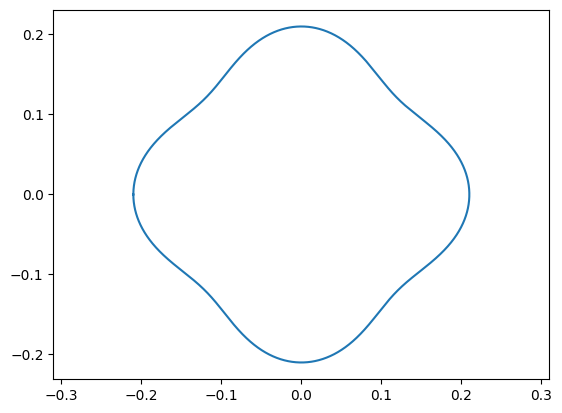

In [4]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
plt.plot(x, y)
plt.axis('equal')
# plt.show()
plt.savefig('arm_traj.png')
traj = list(zip(x,y))

### 1. Forward Model

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
\underline{\;\;\;\;} \\
\underline{\;\;\;\;}
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [5]:
import numpy as np

L0 = 0.1
L1 = 0.11

def getForwardModel(q0, q1):
    x = L0 * np.cos(q0) + L1 * np.cos(q0 + q1)
    y = L0 * np.sin(q0) + L1 * np.sin(q0 + q1)
    return np.array([x, y])

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [6]:
def getJacobian(q0, q1):
    J11 = -L0*np.sin(q0) - L1*np.sin(q0 + q1)
    J12 = -L1*np.sin(q0 + q1)
    J21 =  L0*np.cos(q0) + L1*np.cos(q0 + q1)
    J22 =  L1*np.cos(q0 + q1)

    return np.array([[J11, J12],
                     [J21, J22]])

### 3. X-Y controller

**Background:** for reasons beyond the scope of this course, it so happens that, for any robot,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot juxtaposed over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

Mean Squared Error (trajectory): 0.0011785902698290484


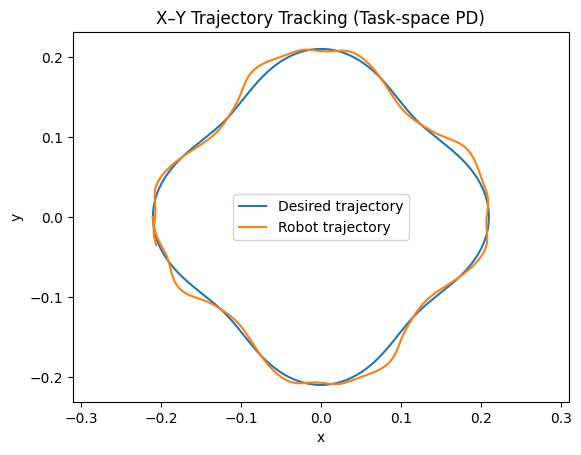

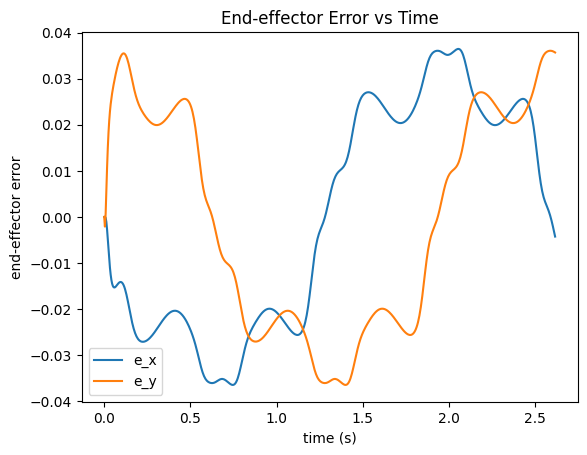

In [7]:
env.unwrapped.robot.central_joint.reset_position(np.pi, 0)
env.unwrapped.robot.elbow_joint.reset_position(0.0, 0)

Kp = np.diag([200.0, 200.0])   # task-space position gains
Kd = np.diag([20.0,  20.0 ])   # task-space velocity gains

dt = getattr(env.unwrapped, "dt", None)
if dt is None:
    dt = 1.0/240.0

traj_np = np.array(traj, dtype=float)

stride = 10
traj_ds = traj_np[::stride]
N = len(traj_ds)

xdes_dot = np.zeros_like(traj_ds)
xdes_dot[1:] = (traj_ds[1:] - traj_ds[:-1]) / dt

x_log   = np.zeros((N, 2))
err_log = np.zeros((N, 2))
t_log   = np.arange(N) * dt

for k in range(N):
    x_des  = traj_ds[k]
    xd_des = xdes_dot[k]

    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

    q0, q1 = float(q0), float(q1)
    qdot = np.array([float(q0_dot), float(q1_dot)], dtype=float)

    x = getForwardModel(q0, q1)
    J = getJacobian(q0, q1)
    xdot = J @ qdot

    e  = x_des  - x
    ed = xd_des - xdot
    F = (Kp @ e) + (Kd @ ed)

    tau = J.T @ F  # [tau0, tau1]

    obs, reward, done, info = env.step(tau)

    x_log[k]   = x
    err_log[k] = e

mse = np.mean(np.sum((x_log - traj_ds)**2, axis=1))
print("Mean Squared Error (trajectory):", mse)

plt.figure()
plt.plot(traj_ds[:, 0], traj_ds[:, 1], label="Desired trajectory")
plt.plot(x_log[:, 0],   x_log[:, 1],   label="Robot trajectory")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("X–Y Trajectory Tracking (Task-space PD)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t_log, err_log[:, 0], label="e_x")
plt.plot(t_log, err_log[:, 1], label="e_y")
plt.xlabel("time (s)")
plt.ylabel("end-effector error")
plt.title("End-effector Error vs Time")
plt.legend()
plt.show()

### 4. Inverse Kinematics

Using the functions `getForwardModel` and `getJacobian` from parts 1 and 2, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

In [8]:
def getIK(current_position, target_position, current_state):
    current_state = np.asarray(current_state, dtype=float).flatten()
    q0, q1 = float(current_state[0]), float(current_state[1])

    current_position = np.asarray(current_position, dtype=float).flatten()
    target_position  = np.asarray(target_position, dtype=float).flatten()
    e = target_position - current_position  # [ex, ey]

    J = getJacobian(q0, q1)  # 2x2

    lam = 1e-3
    JJt = J @ J.T
    J_pinv = J.T @ np.linalg.inv(JJt + (lam**2) * np.eye(2))

    alpha = 1.0  # step size (tune: smaller = more stable, larger = faster)
    dq = alpha * (J_pinv @ e)

    q_target = np.array([q0, q1], dtype=float) + dq
    return q_target

Now derive the analytical inverse kinematic solution; i.e. solve the problem using a closed-form equation, rather than an iterative method. _Show your work_. Correct answers without derivations will not receive full credit.

\begin{align*}
x &= l_0 \cos q_0 + l_1 \cos(q_0 + q_1) \\
y &= l_0 \sin q_0 + l_1 \sin(q_0 + q_1)
\end{align*}

Squaring and adding the two equations:

\begin{align*}
x^2 + y^2 
&= (l_0 \cos q_0 + l_1 \cos(q_0 + q_1))^2 
 + (l_0 \sin q_0 + l_1 \sin(q_0 + q_1))^2 \\
&= l_0^2 + l_1^2 + 2 l_0 l_1 \cos q_1
\end{align*}

Let $r^2 = x^2 + y^2$. Then by the law of cosines:

\begin{align*}
\cos q_1 
&= \frac{r^2 - l_0^2 - l_1^2}{2 l_0 l_1}
\end{align*}

Therefore,

\begin{align*}
q_1 &= \pm \arccos\!\left(
\frac{x^2 + y^2 - l_0^2 - l_1^2}
{2 l_0 l_1}
\right)
\end{align*}

To solve for $q_0$, define

\begin{align*}
\phi &= \tan^{-1}\!\left(\frac{y}{x}\right)
\end{align*}

From triangle geometry,

\begin{align*}
\beta &= \tan^{-1}\!\left(
\frac{l_1 \sin q_1}
{l_0 + l_1 \cos q_1}
\right)
\end{align*}

Thus,

\begin{align*}
q_0 &= \phi - \beta \\
&= \tan^{-1}\!\left(\frac{y}{x}\right)
   - \tan^{-1}\!\left(
     \frac{l_1 \sin q_1}
     {l_0 + l_1 \cos q_1}
   \right)
\end{align*}

\begin{align*}
q_0 &= \underline{
\tan^{-1}\!\left(\frac{y}{x}\right)
-
\tan^{-1}\!\left(
\frac{l_1 \sin q_1}
{l_0 + l_1 \cos q_1}
\right)
} \\[8pt]
q_1 &= \underline{
\pm \arccos\!\left(
\frac{x^2 + y^2 - l_0^2 - l_1^2}
{2 l_0 l_1}
\right)
}
\end{align*}

Explain what challenges there would be to use the analytical IK solution to track trajectories:

Complexity and cumbersome to solve or derive as there are more joints and trajectories to track.
While tracking a trajectory, the solution may suddenly switch branches if not carefully constrained. That produces violent discontinuities in joint angles.

### 5. IK controller

Implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot juxtaposed over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

Mean Squared Error (IK controller): 0.010726481731893651


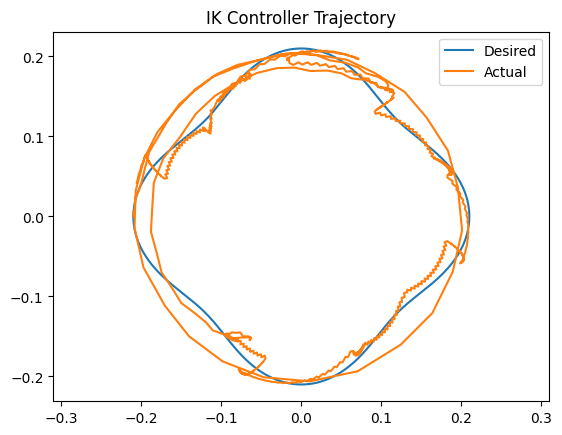

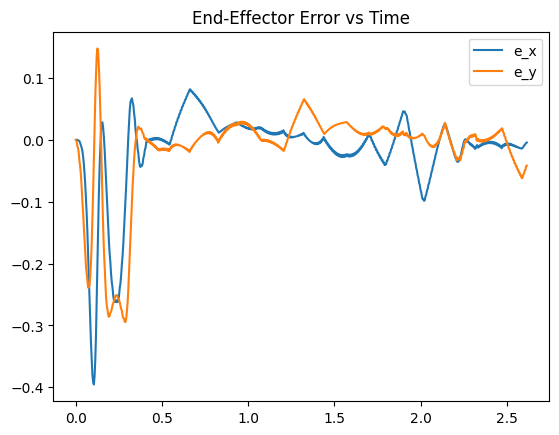

In [9]:
def analyticalIK(x, y):
    r2 = x**2 + y**2
    cos_q1 = (r2 - L0**2 - L1**2) / (2 * L0 * L1)

    # numerical safety
    cos_q1 = np.clip(cos_q1, -1.0, 1.0)

    q1 = np.arccos(cos_q1)   # elbow-down branch

    q0 = np.arctan2(y, x) - np.arctan2(
        L1 * np.sin(q1),
        L0 + L1 * np.cos(q1)
    )

    return np.array([q0, q1])


env.unwrapped.robot.central_joint.reset_position(np.pi, 0)
env.unwrapped.robot.elbow_joint.reset_position(0.0, 0)

Kp = np.diag([100.0, 100.0])
Kd = np.diag([10.0, 10.0])

dt = 1.0 / 240.0

traj_np = np.array(traj)
stride = 10
traj_ds = traj_np[::stride]
N = len(traj_ds)

x_log = np.zeros((N, 2))
x_des_log = traj_ds.copy()
err_log = np.zeros((N, 2))
t_log = np.arange(N) * dt

for k in range(N):

    x_des = traj_ds[k]

    q_des = analyticalIK(x_des[0], x_des[1])
    qd_des = np.zeros(2)   # assume desired joint velocity = 0

    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

    q = np.array([q0, q1])
    qdot = np.array([q0_dot, q1_dot])

    e = q_des - q
    ed = qd_des - qdot
    tau = (Kp @ e) + (Kd @ ed)

    obs, reward, done, info = env.step(tau)

    x_current = getForwardModel(q0, q1)
    x_log[k] = x_current
    err_log[k] = x_des - x_current


mse = np.mean(np.sum((x_log - x_des_log)**2, axis=1))
print("Mean Squared Error (IK controller):", mse)

plt.figure()
plt.plot(x_des_log[:,0], x_des_log[:,1], label="Desired")
plt.plot(x_log[:,0], x_log[:,1], label="Actual")
plt.axis("equal")
plt.title("IK Controller Trajectory")
plt.legend()
plt.show()

plt.figure()
plt.plot(t_log, err_log[:,0], label="e_x")
plt.plot(t_log, err_log[:,1], label="e_y")
plt.title("End-Effector Error vs Time")
plt.legend()
plt.show()


### 6. Race Car

The objective of the `racecar` environment is to make the race car travel as far as possible on a track within the given time. There are 3 tracks vailable: `FigureEight`, `Linear`, and `Circle` (default).
Each track has a different shape, time limit, and horizon length. To set up an environment with a particular track, you can pass the track name while instantiating the environment. For example, to set up the figure eight trajectory:

```python
from racecar.SDRaceCar import SDRaceCar
env = SDRaceCar(render_env=True, track='FigureEight')
```

To install the race car environment, run the following commands:
```bash
~ git clone https://github.com/ucsdarclab/RaceCar.git
~ cd RaceCar
~ pip install -e .
```

The action space of the environment consists of [wheel angle, thrust]. The range of both these values are normalized to be between $\pm 1$.The observation space consists of [$x, y, \theta, v_x, v_y, \dot\theta, h$], where ($x, y, \theta$) is the intertial frame position of the car; $v_x, v_y$ are the longitudinal and lateral velocities  respectively; and $\dot\theta$ is the yaw rate. $h$ is the co-ordinate on the track the car has to reach.

At each time step, the race car environment gives a reward that is proportional to the speed of the car and its proximity to the track. It terminates (`done = True`) after a fixed amount of time, or if the car gets too far from the track.

Using these observations implement a controller that can traverse all three tracks. You may use different gains for different tracks, but the controller itself must be the same. Record the cumulative reward for each track; these rewards will be summed together to create your controller's score. If your controller has the highest score, you win!

_Tip:_ if you call `env.render()` at each step to visualize the car's path, you may find that Jupyter interprets each step as a separate image. To avoid this, try running
```IPython
%matplotlib tk # others include qt, wx, gtk, osx
```
to load results as animations in a separate window. You may have to experiment with several different backends to find the one that works best with your system.

In [10]:
from racecar.SDRaceCar import SDRaceCar

In [14]:
import numpy as np
from racecar.SDRaceCar import SDRaceCar

def to_scalar(v):
    """Convert nested lists/arrays/tensors into a Python float."""
    a = np.asarray(v)
    # if it's not a scalar, take the first element (env sometimes wraps scalars in [ ])
    return float(a.reshape(-1)[0])

def wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def track_point(track, h):
    if track == "Circle":
        return np.cos(h), np.sin(h)
    elif track == "Linear":
        return h, 0.0
    elif track == "FigureEight":
        return np.sin(h), np.sin(h) * np.cos(h)
    else:
        return np.cos(h), np.sin(h)

class RaceCarController:
    def __init__(self, track_name):
        self.track = track_name
        self.lookahead = {"Circle": 0.40, "Linear": 0.80, "FigureEight": 0.35}.get(track_name, 0.50)
        self.k_steer   = {"Circle": 1.8,  "Linear": 1.2,  "FigureEight": 2.2 }.get(track_name, 1.6)
        self.throttle_base = {"Circle": 0.55, "Linear": 0.80, "FigureEight": 0.50}.get(track_name, 0.65)
        self.k_slow    = {"Circle": 0.75, "Linear": 0.40, "FigureEight": 0.95}.get(track_name, 0.70)

    def __call__(self, obs):
        # obs may be list-of-arrays; handle robustly
        if isinstance(obs, (list, tuple)) and len(obs) >= 7:
            x, y, theta, vx, vy, theta_dot, h = [to_scalar(v) for v in obs[:7]]
        else:
            obs_arr = np.asarray(obs, dtype=object).reshape(-1)
            if obs_arr.size < 7:
                raise ValueError(f"Expected obs with 7 elements, got shape {np.asarray(obs).shape}, size {obs_arr.size}")
            x, y, theta, vx, vy, theta_dot, h = [to_scalar(v) for v in obs_arr[:7]]

        # lookahead target
        h_ref = h + self.lookahead
        x_ref, y_ref = track_point(self.track, h_ref)

        # heading error to target point
        dx, dy = x_ref - x, y_ref - y
        heading_to_target = np.arctan2(dy, dx)
        e_theta = wrap_to_pi(heading_to_target - theta)

        wheel = np.clip(self.k_steer * e_theta, -1.0, 1.0)

        # throttle reduces with heading error
        align = np.clip(1.0 - self.k_slow * abs(e_theta), 0.0, 1.0)
        thrust = self.throttle_base * align
        if abs(e_theta) < 0.15:
            thrust = min(1.0, thrust + 0.15)
        thrust = np.clip(thrust, -1.0, 1.0)

        return np.array([wheel, thrust], dtype=np.float32)

def run_track(track_name, render=False, max_steps=5000):
    env = SDRaceCar(render_env=render, track=track_name)
    obs = env.reset()
    ctrl = RaceCarController(track_name)

    total_reward = 0.0
    for _ in range(max_steps):
        action = ctrl(obs)
        obs, reward, done, info = env.step(action)
        total_reward += float(reward)
        if render:
            env.render()
        if done:
            break
    return total_reward

tracks = ["Circle", "Linear", "FigureEight"]
scores = {tr: run_track(tr, render=False) for tr in tracks}
print("Per-track rewards:", scores)
print("Total score:", sum(scores.values()))

Per-track rewards: {'Circle': 9.89067883765901, 'Linear': 70.64862595824543, 'FigureEight': 13.990103366324377}
Total score: 94.52940816222882


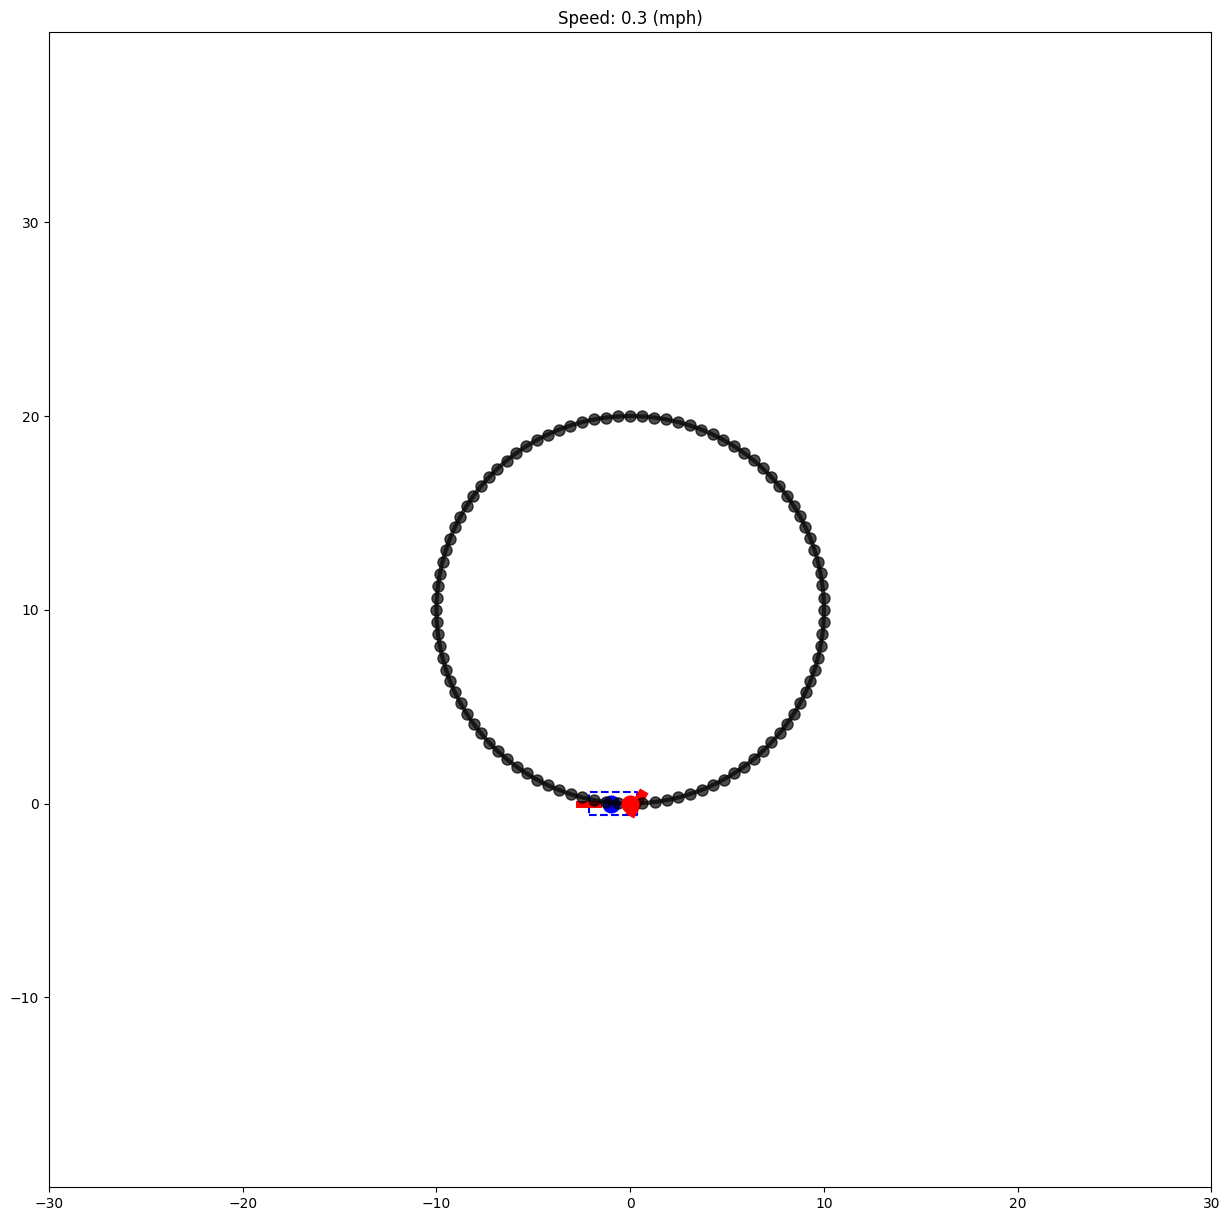

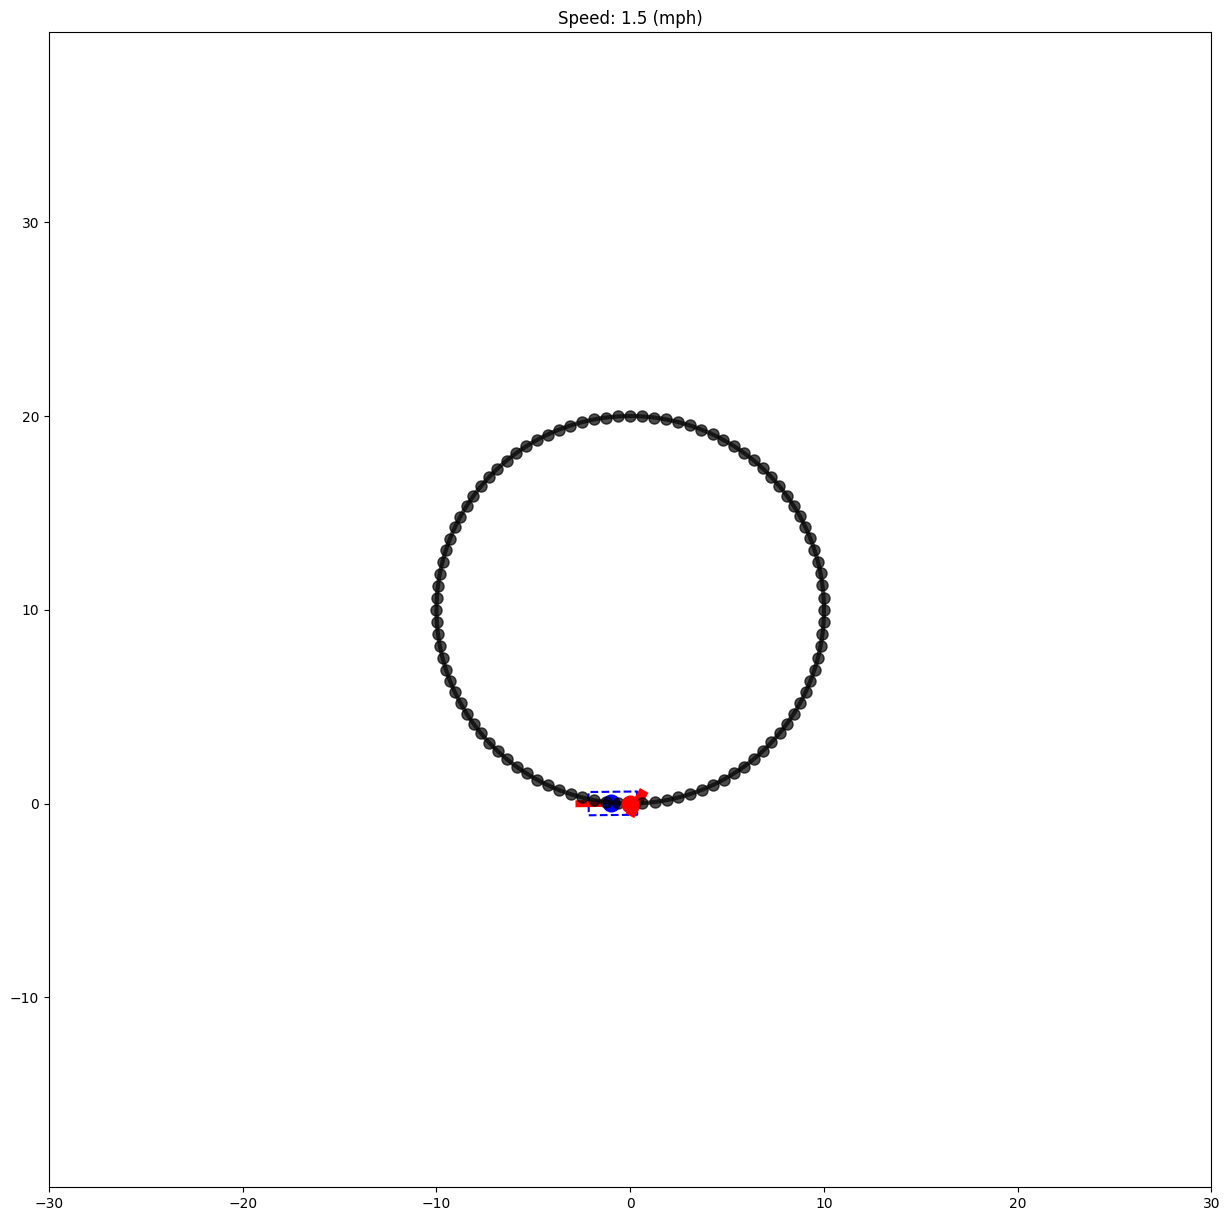

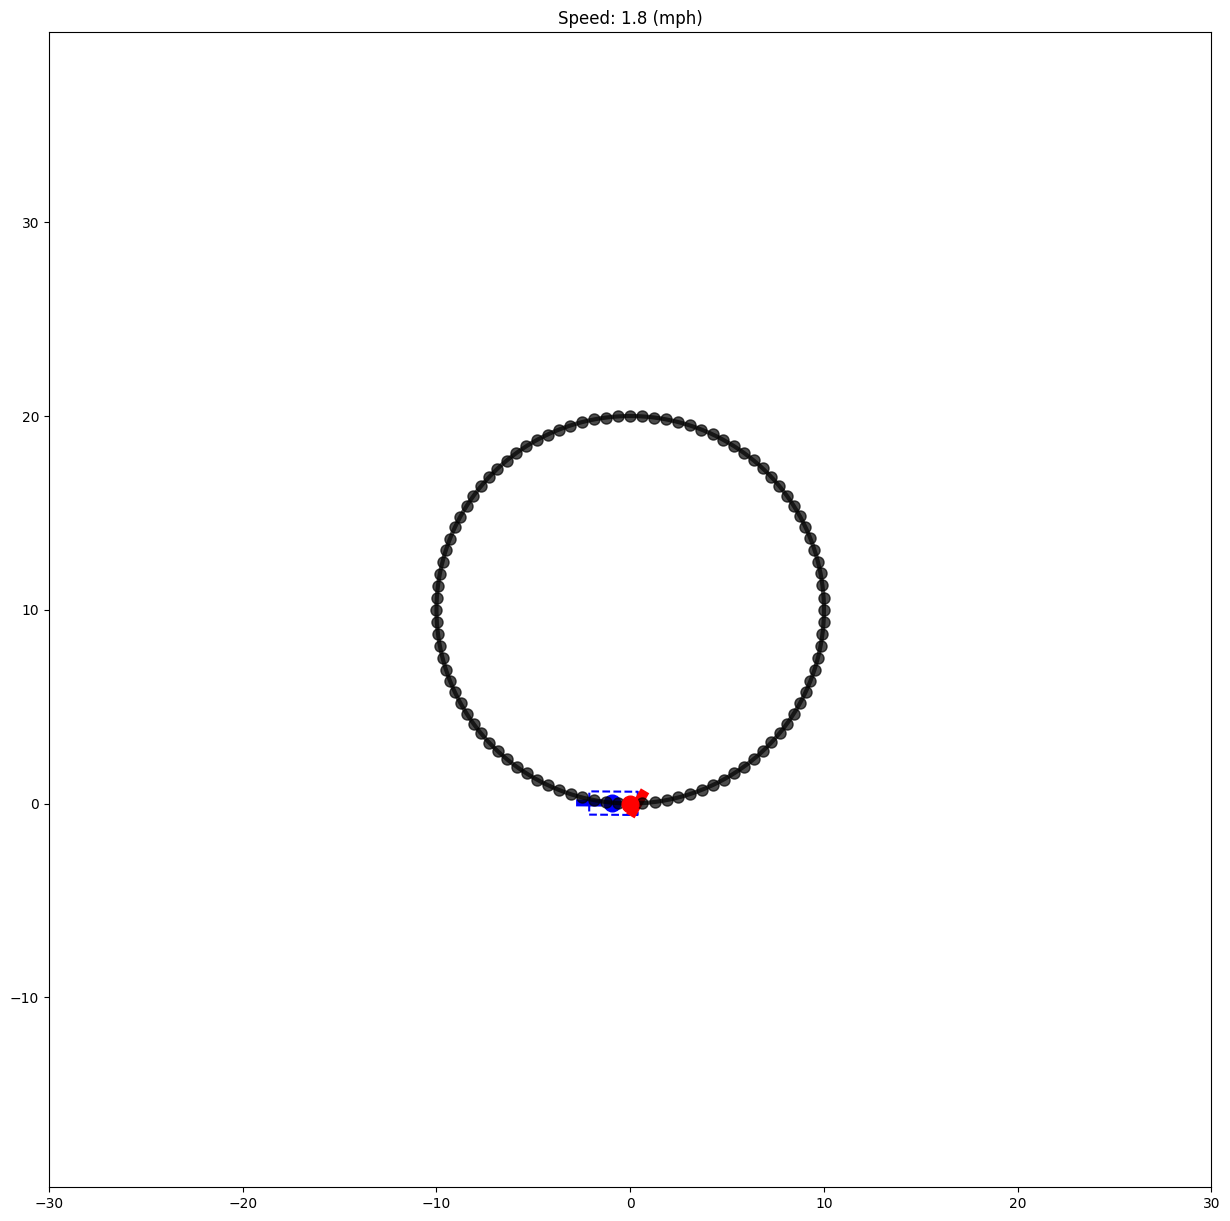

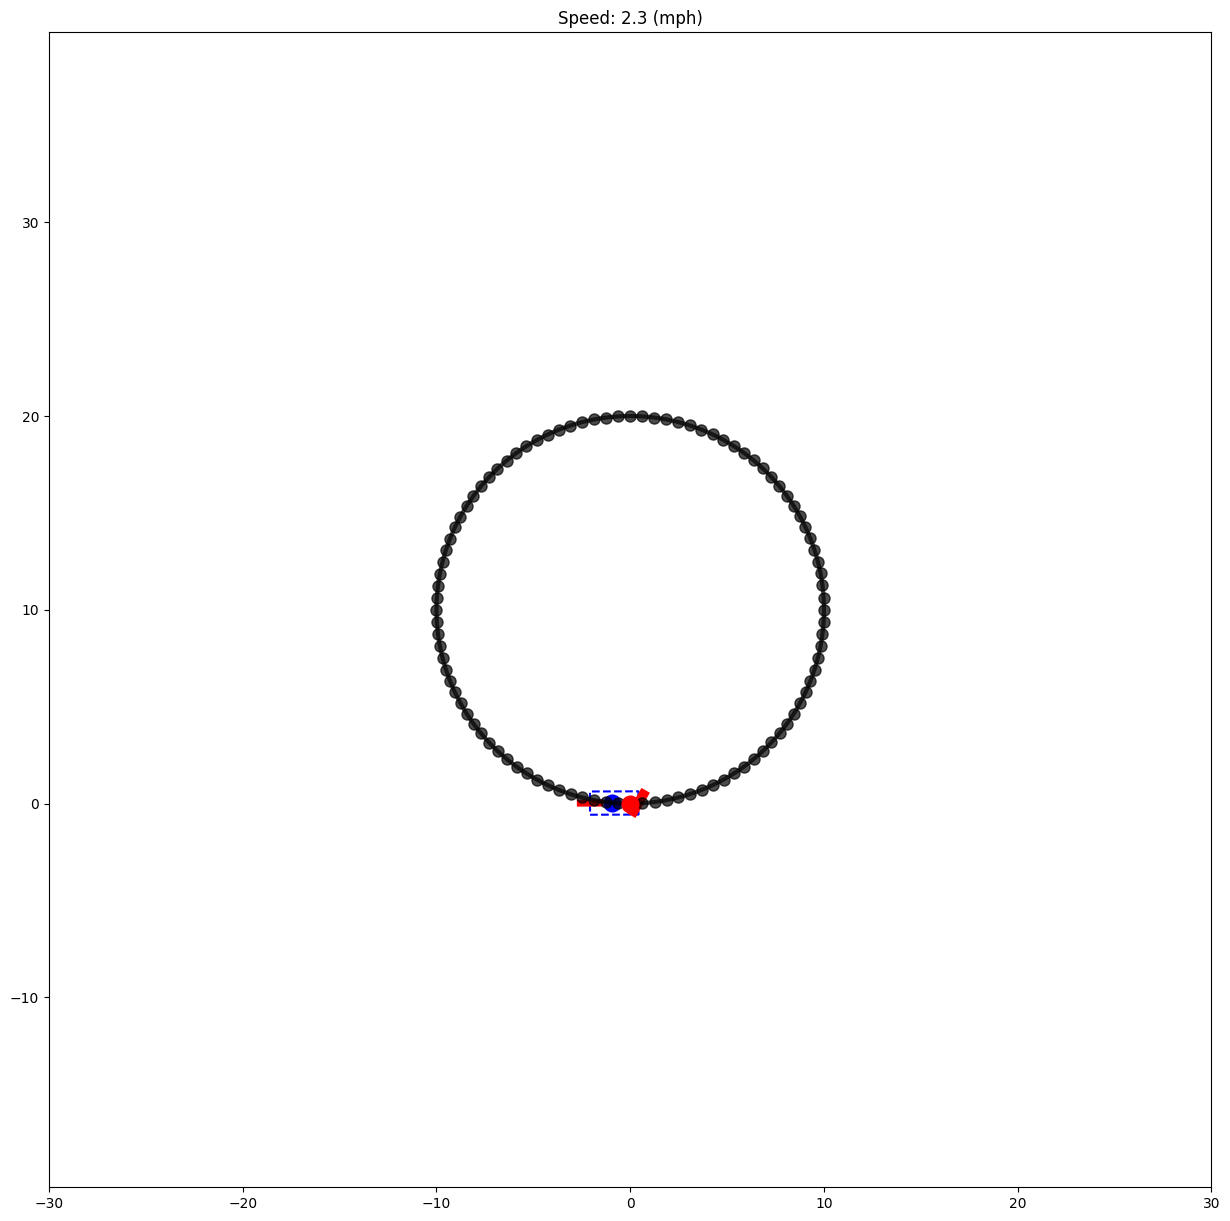

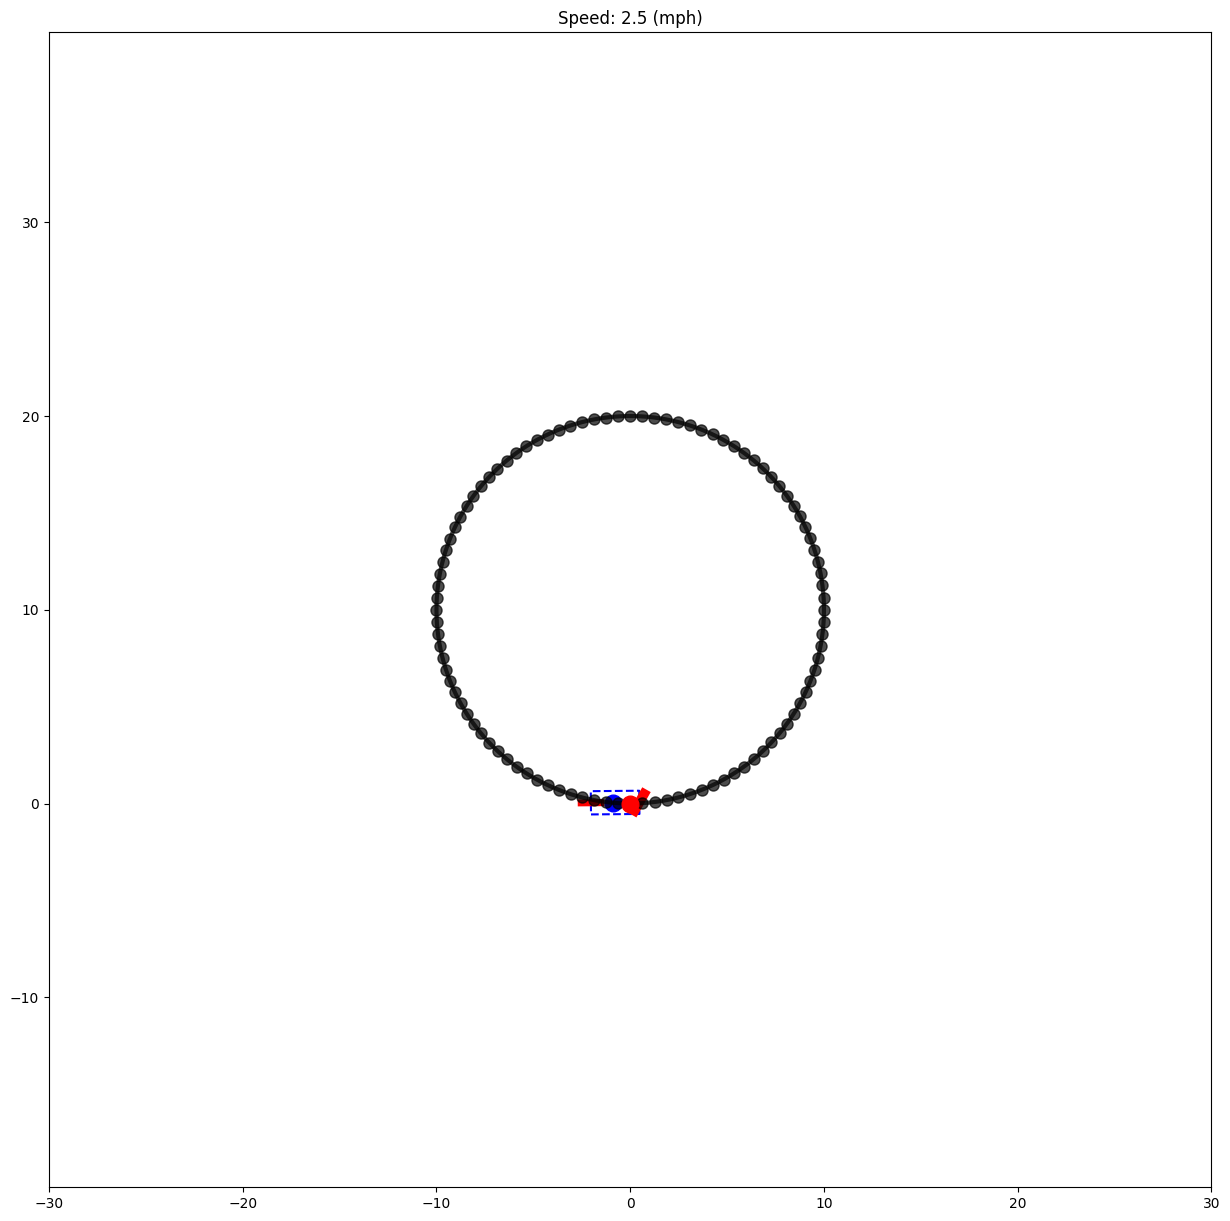

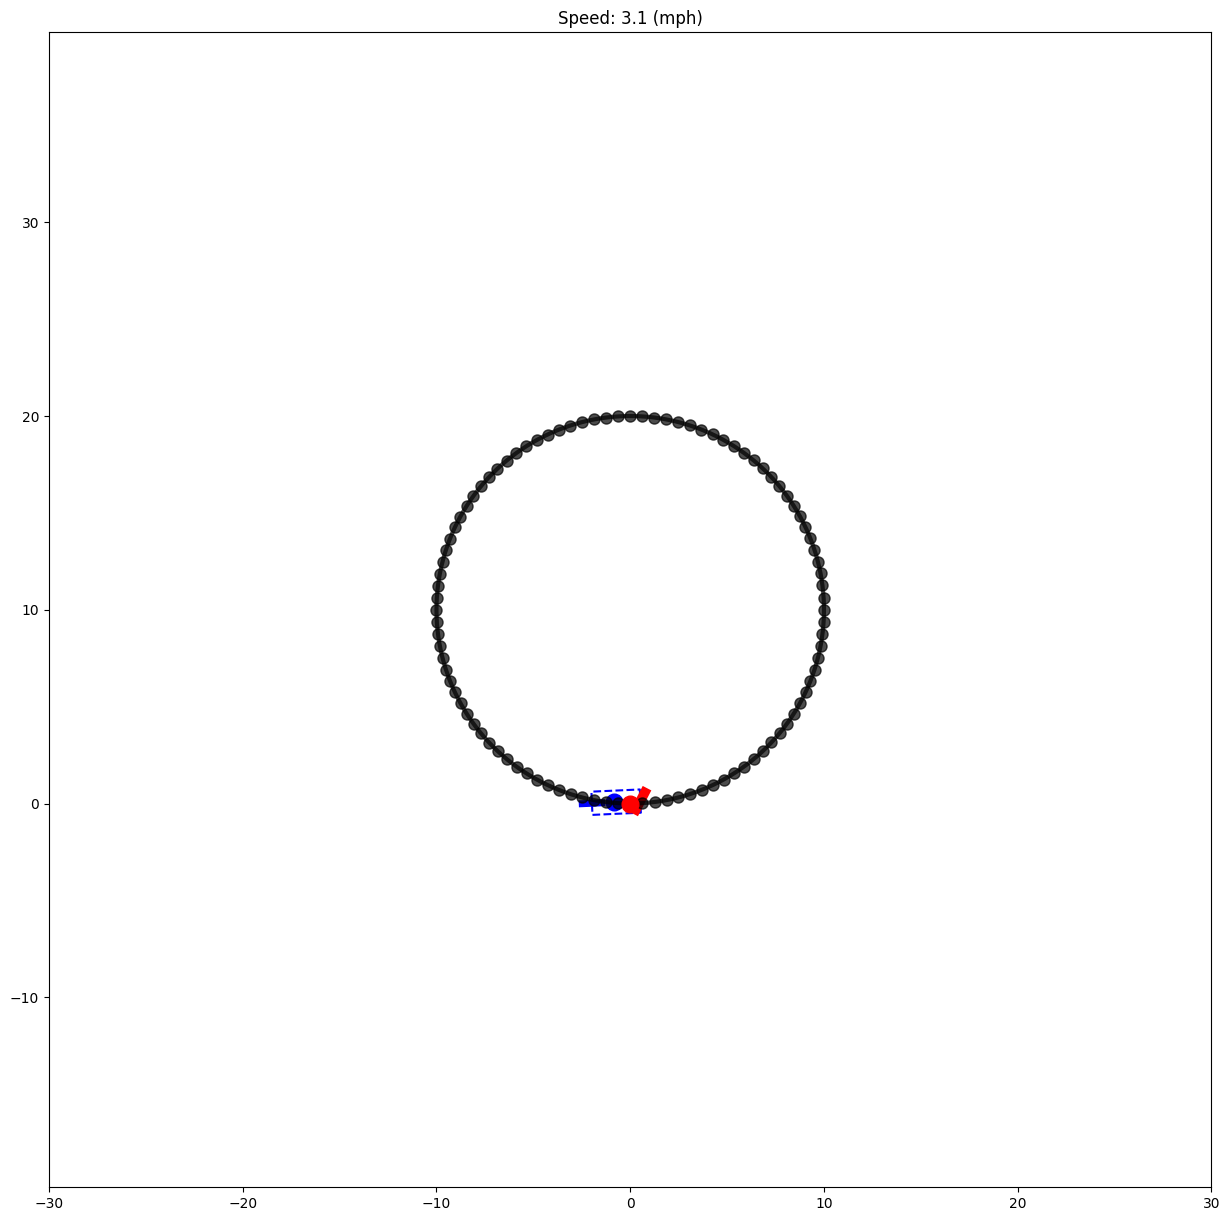

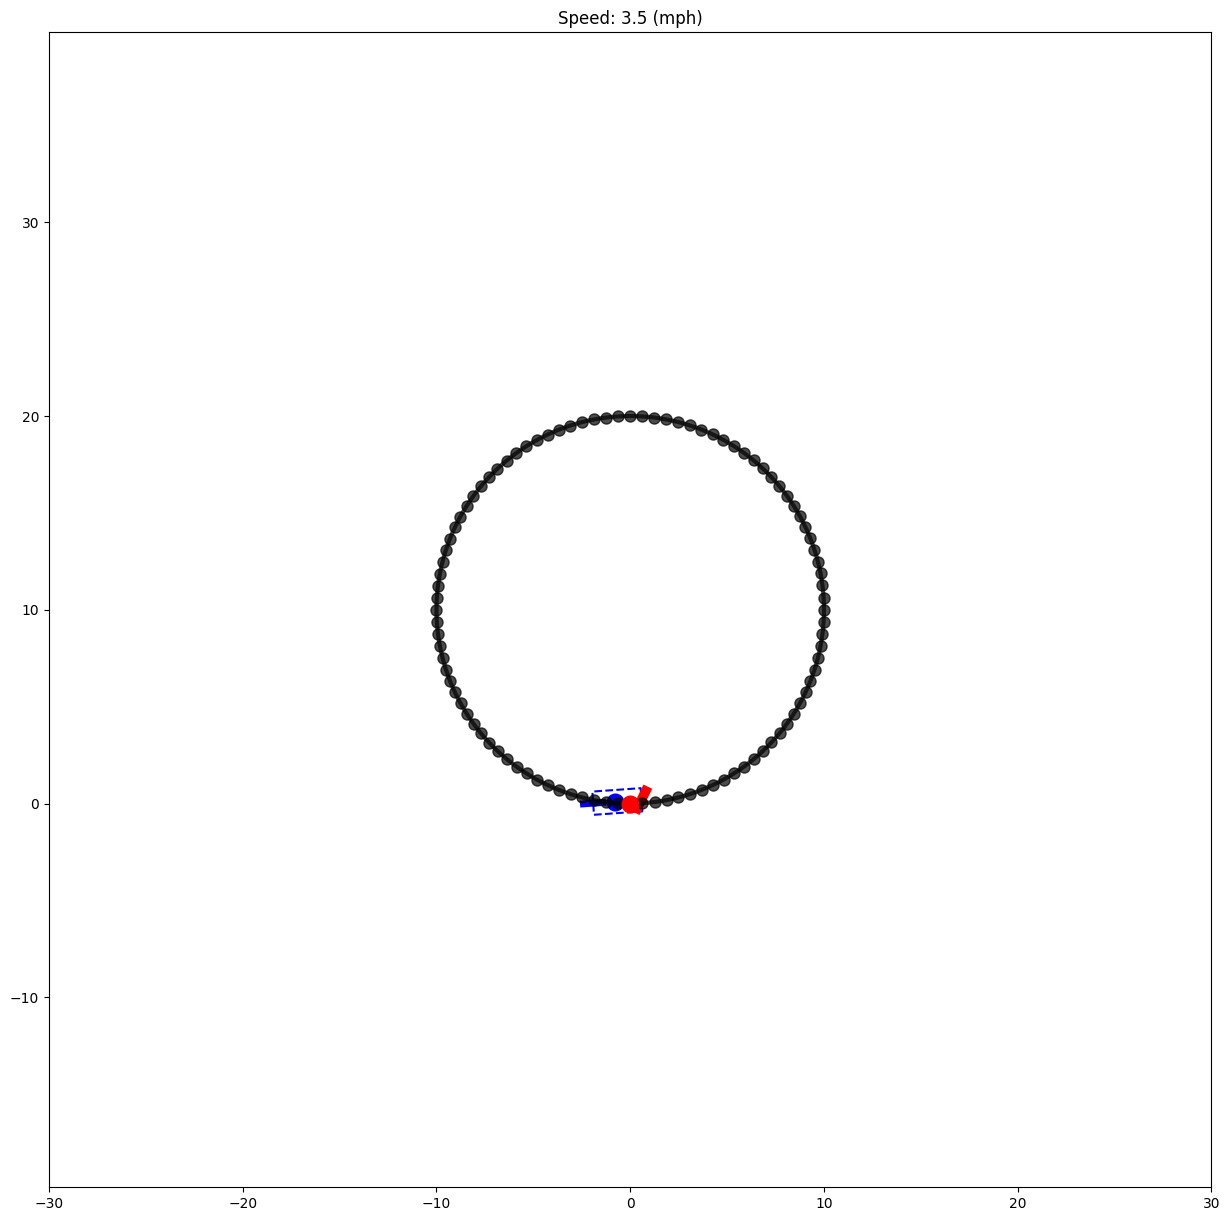

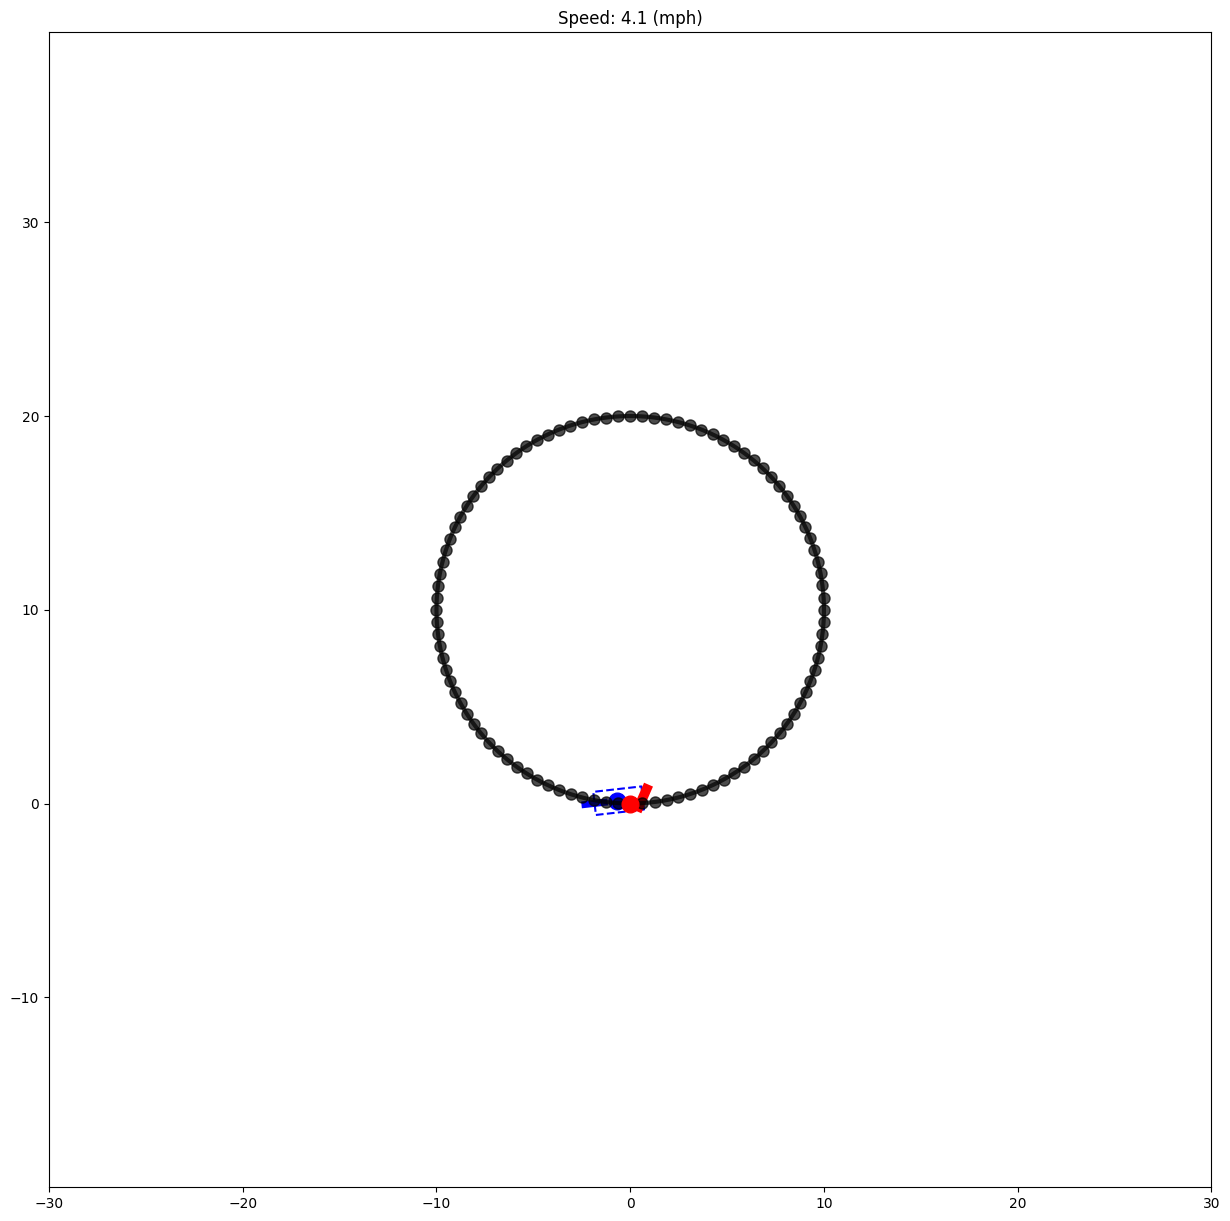

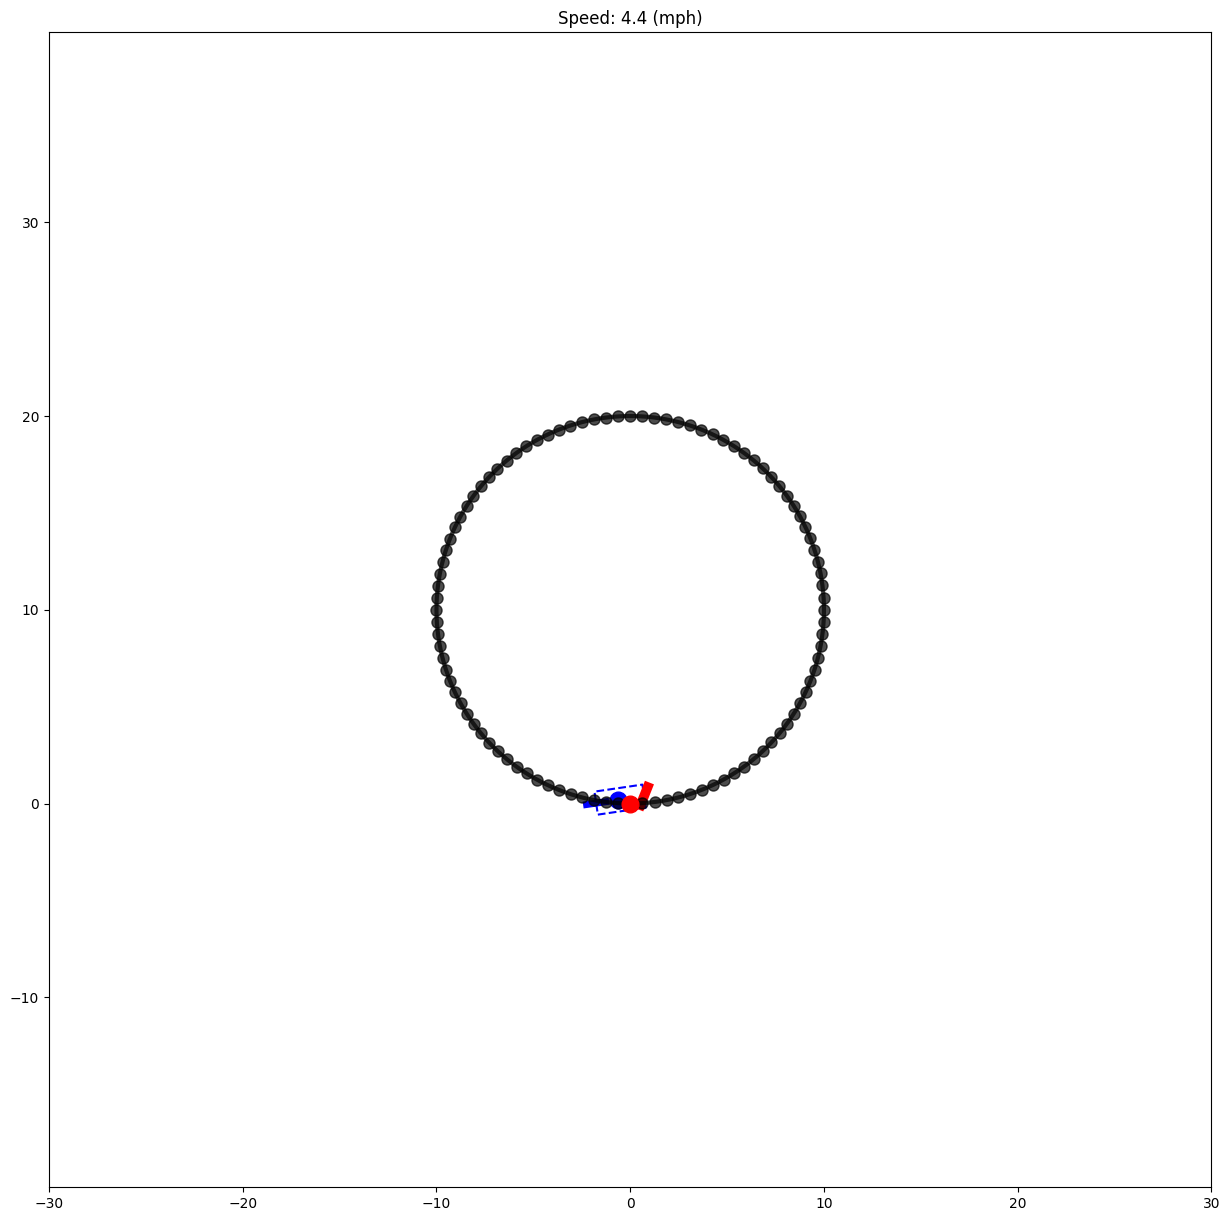

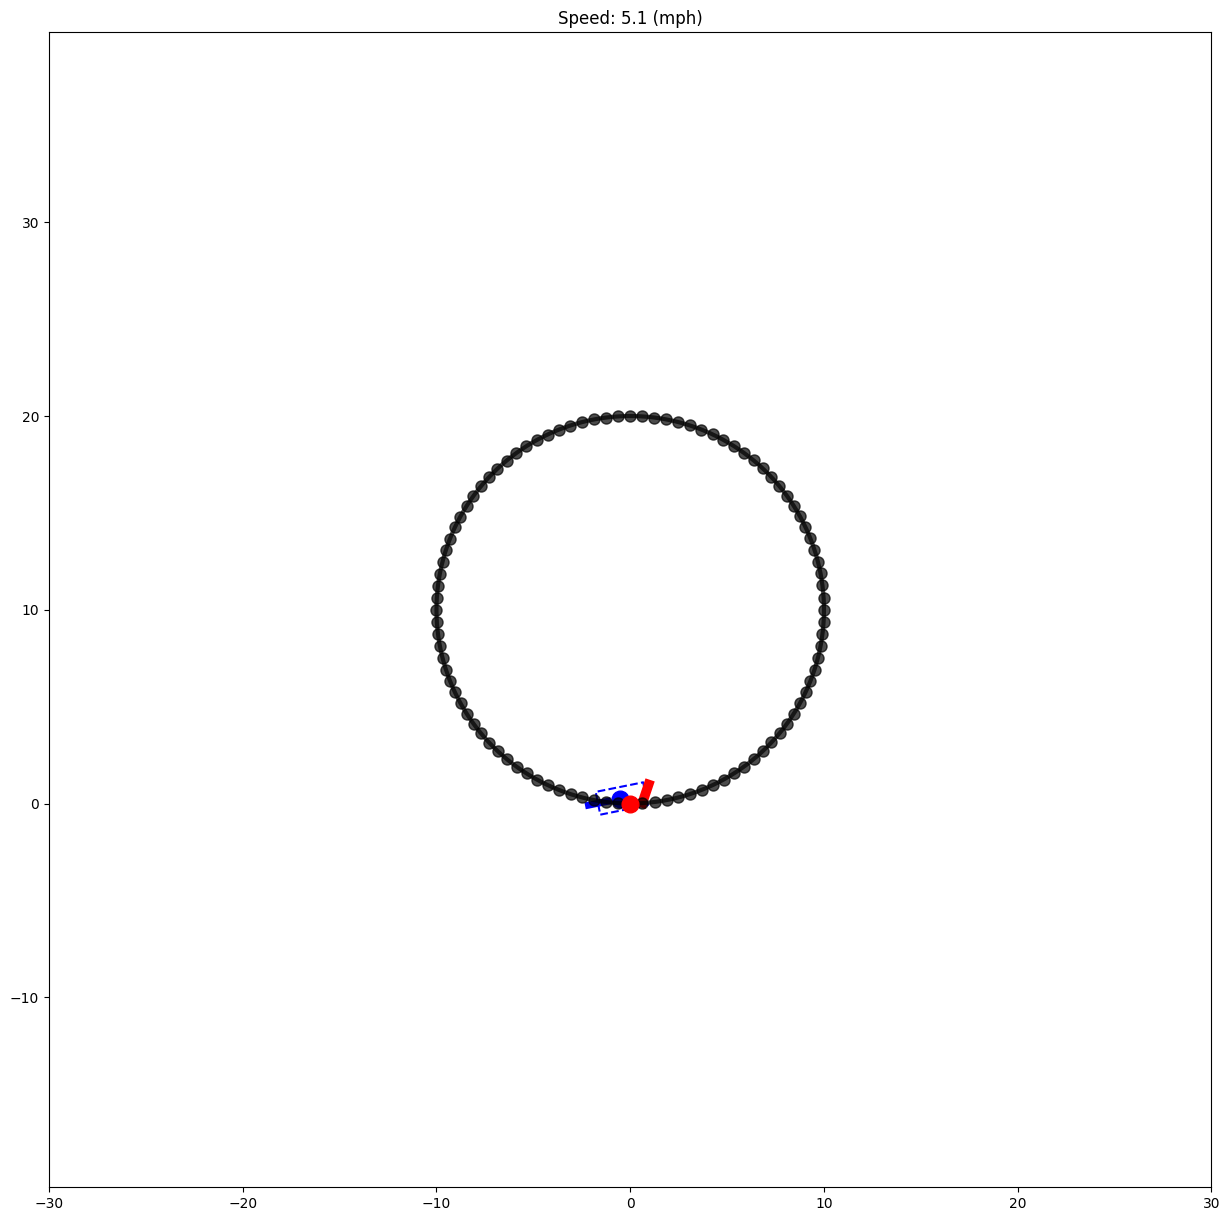

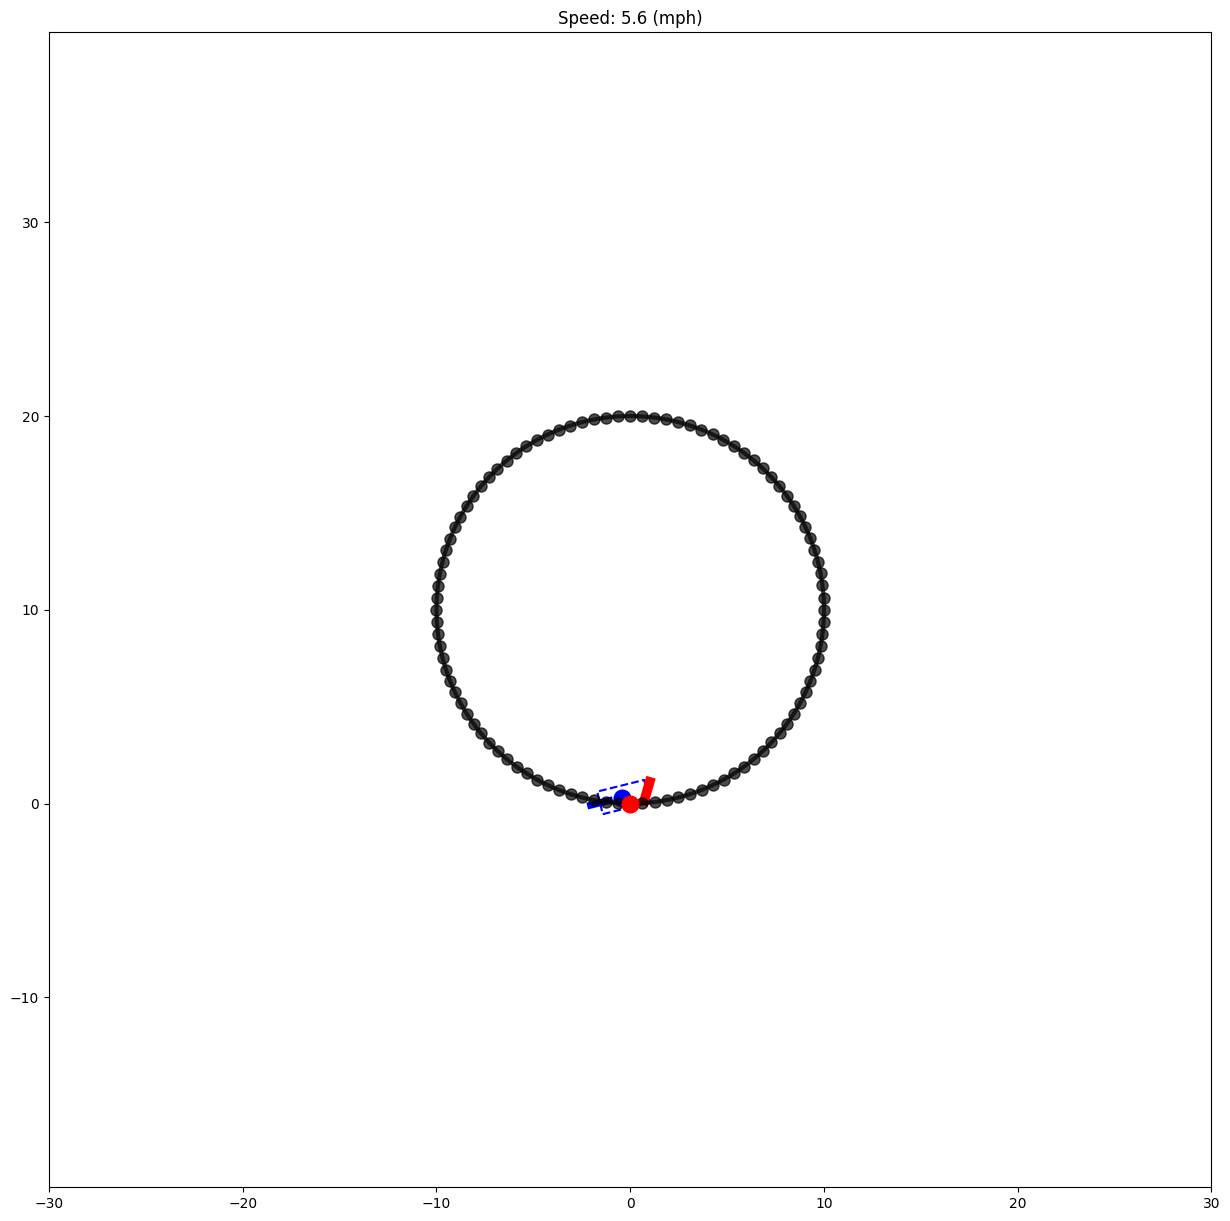

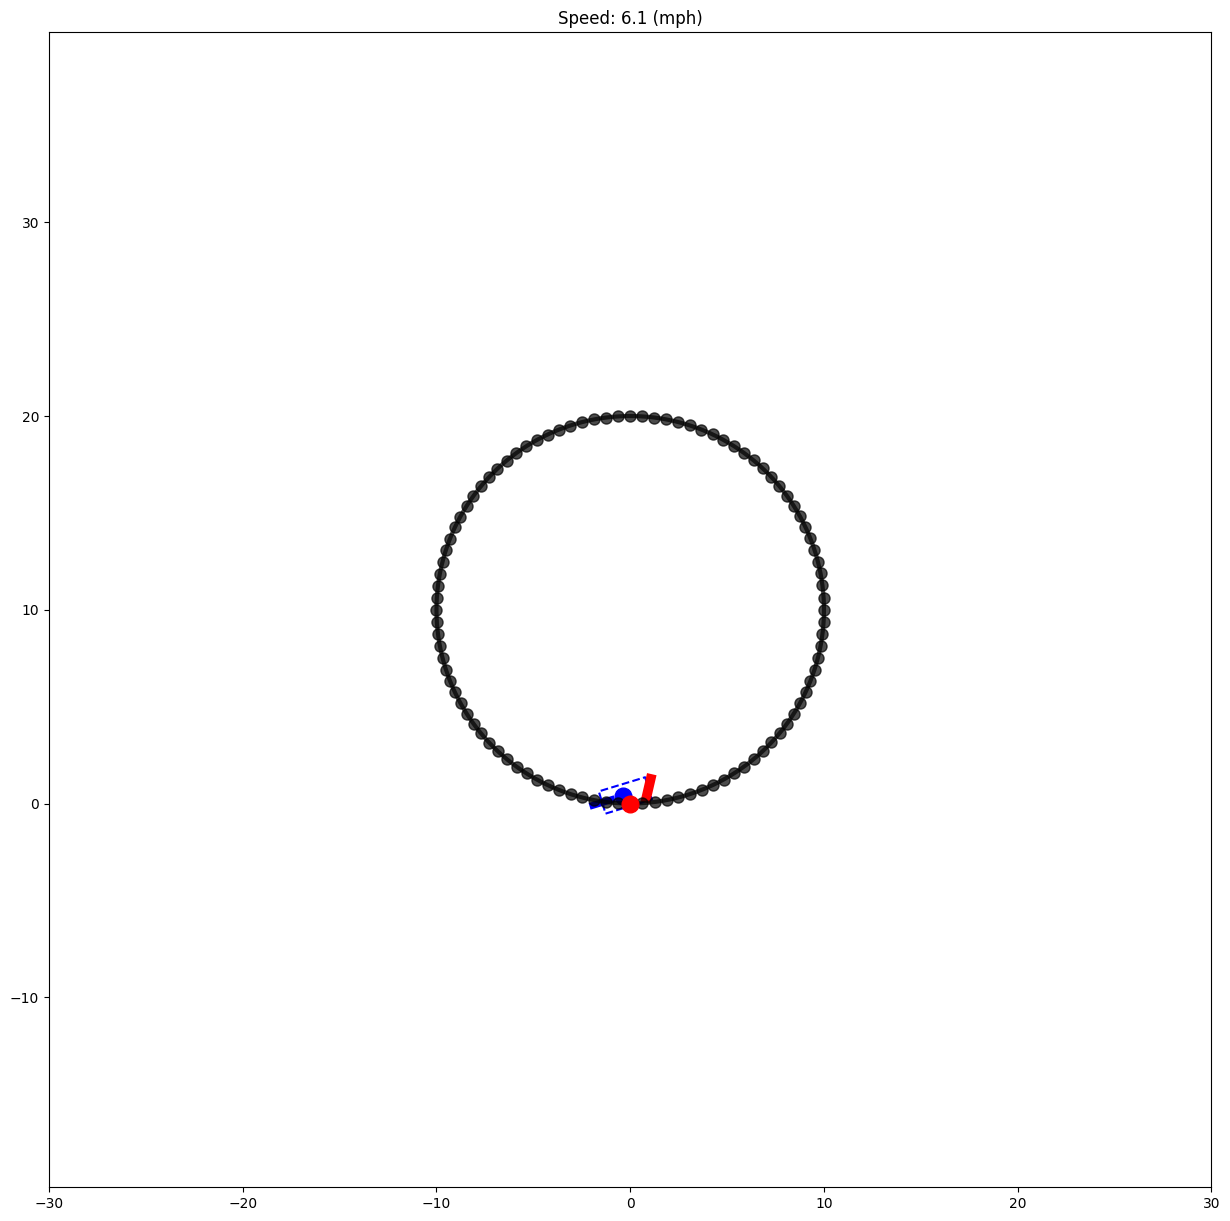

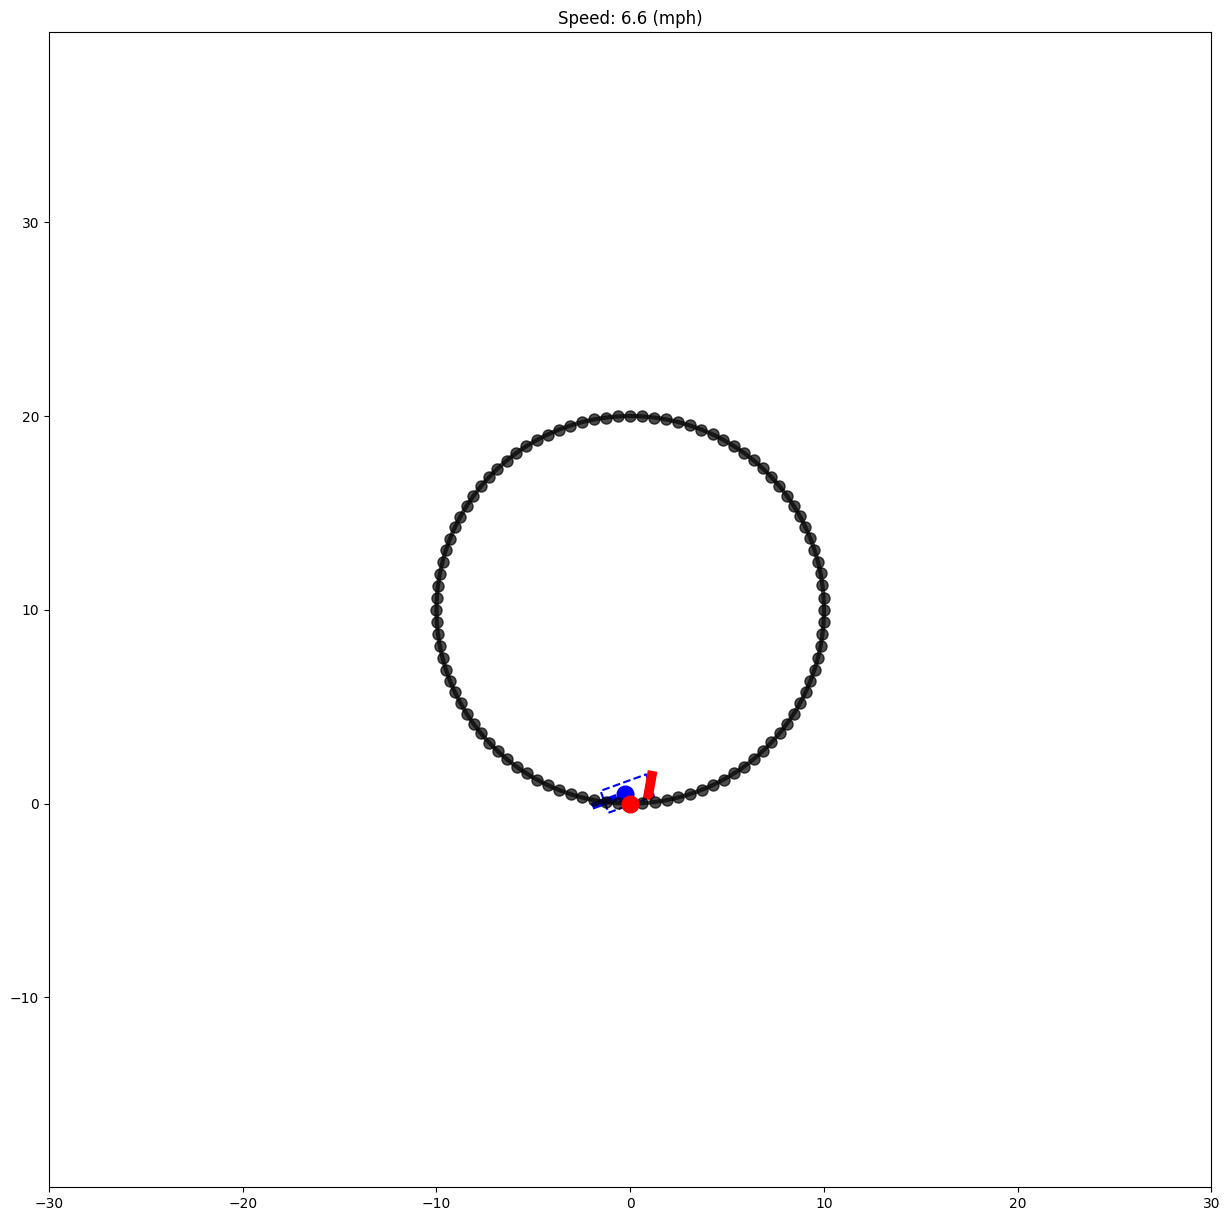

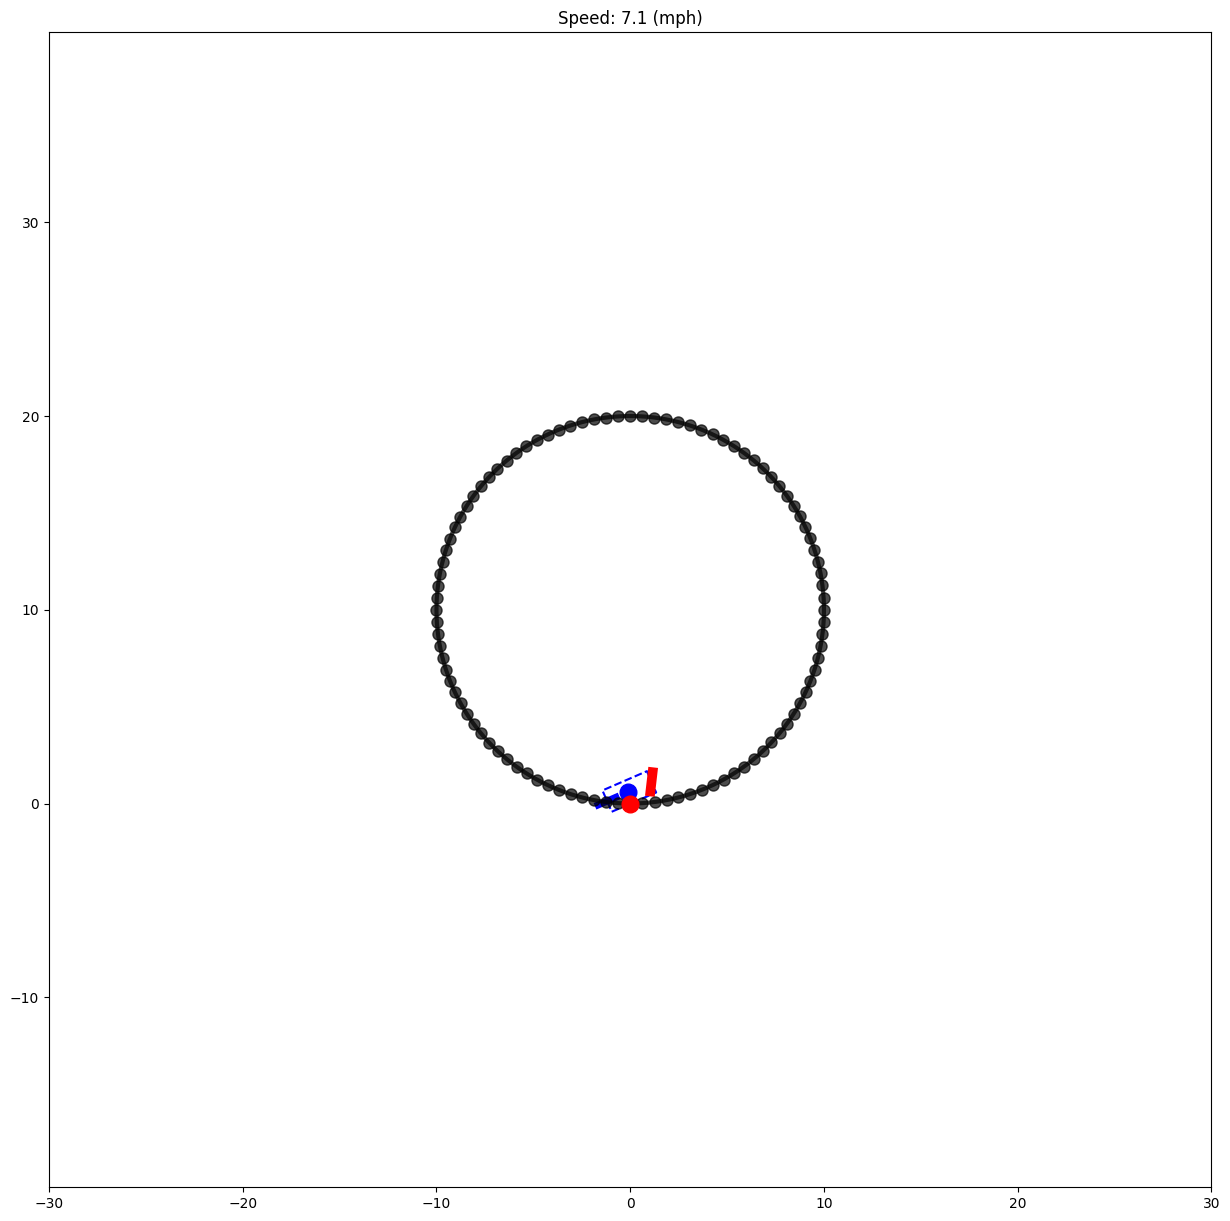

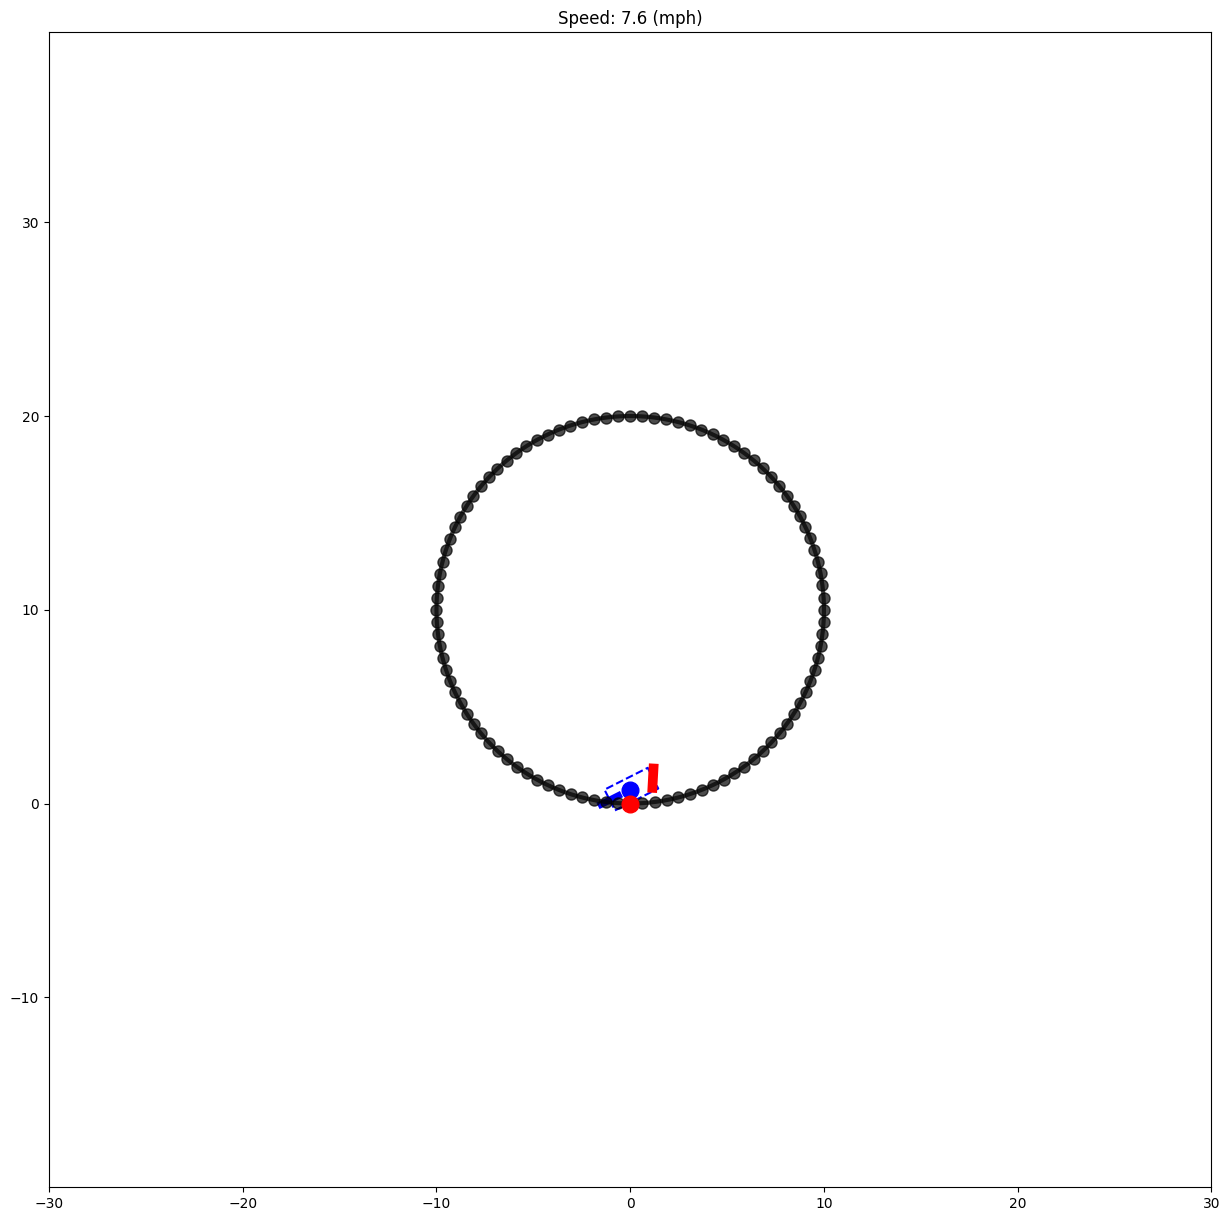

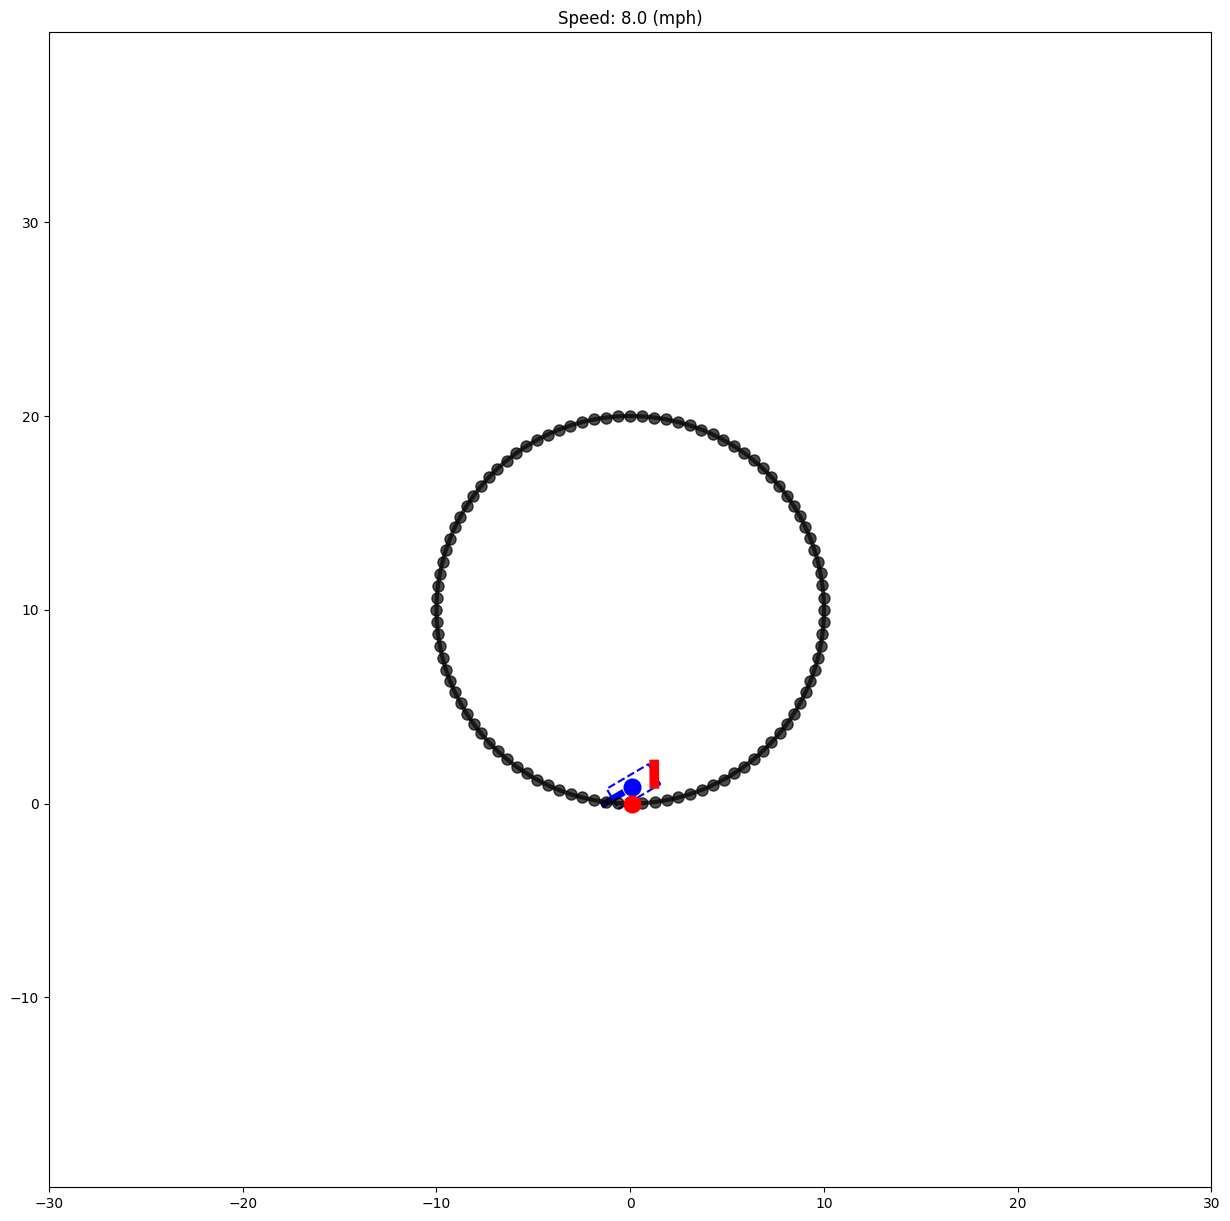

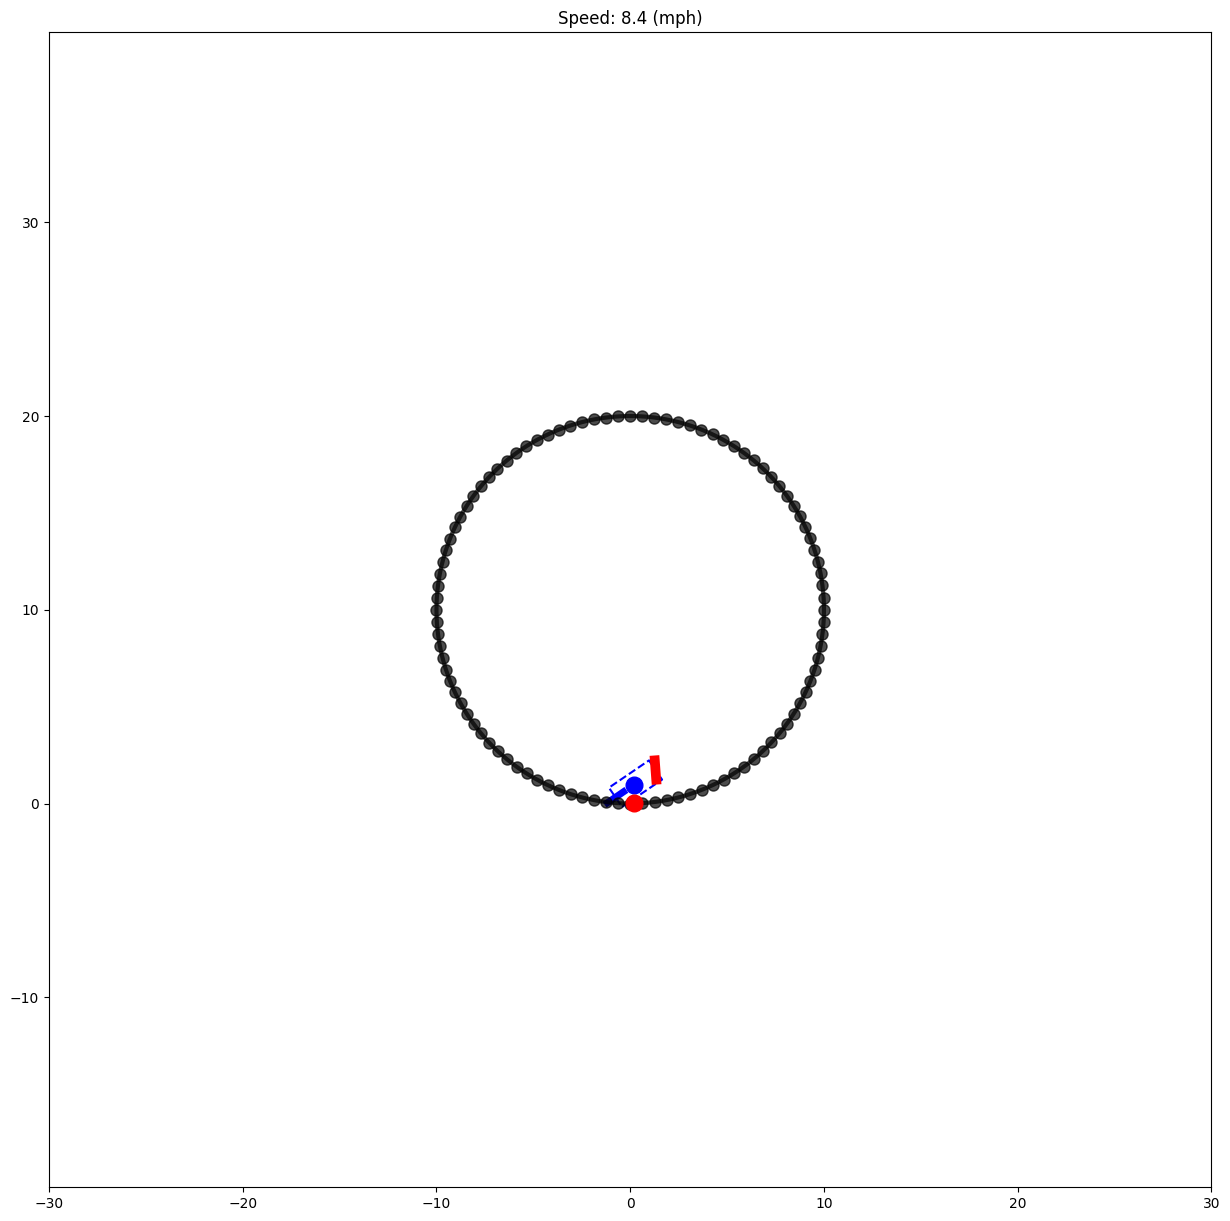

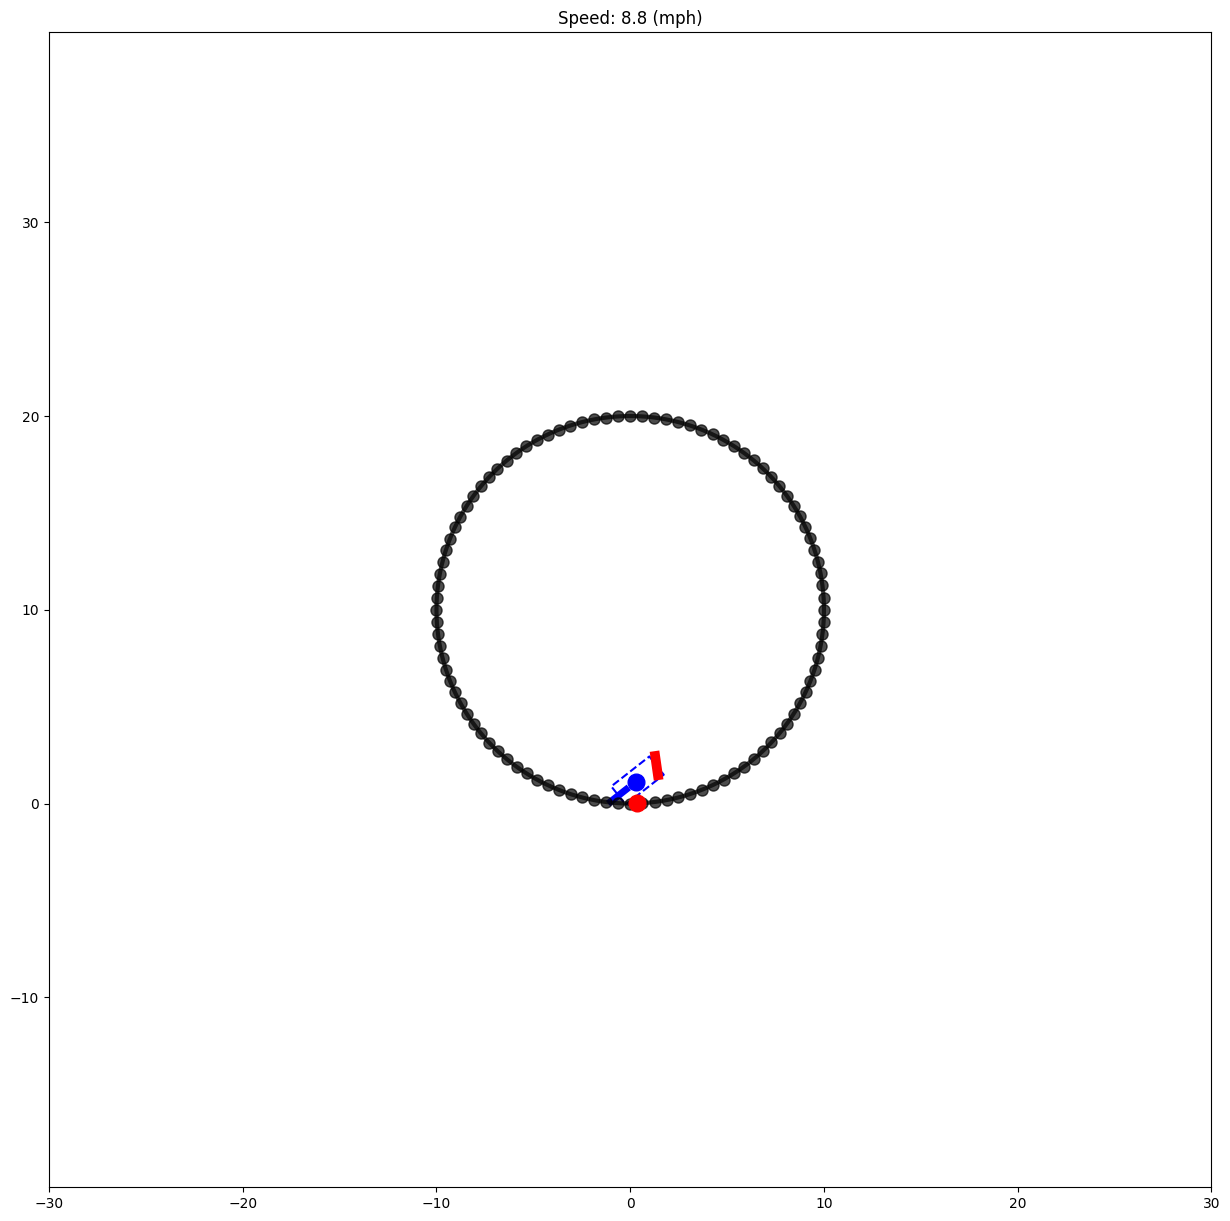

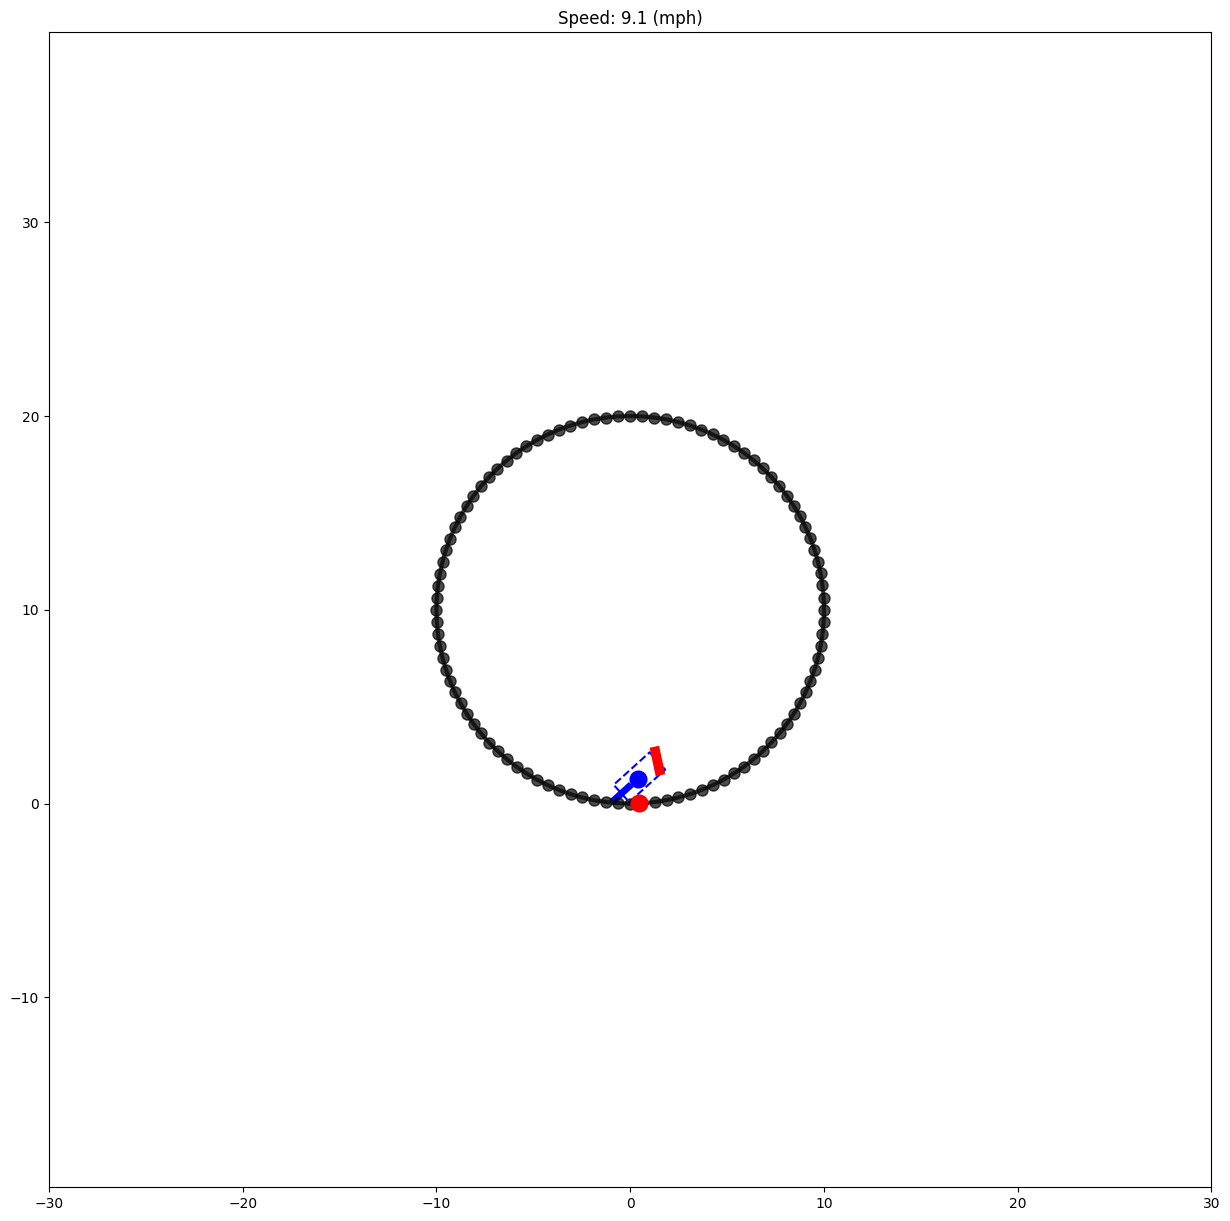

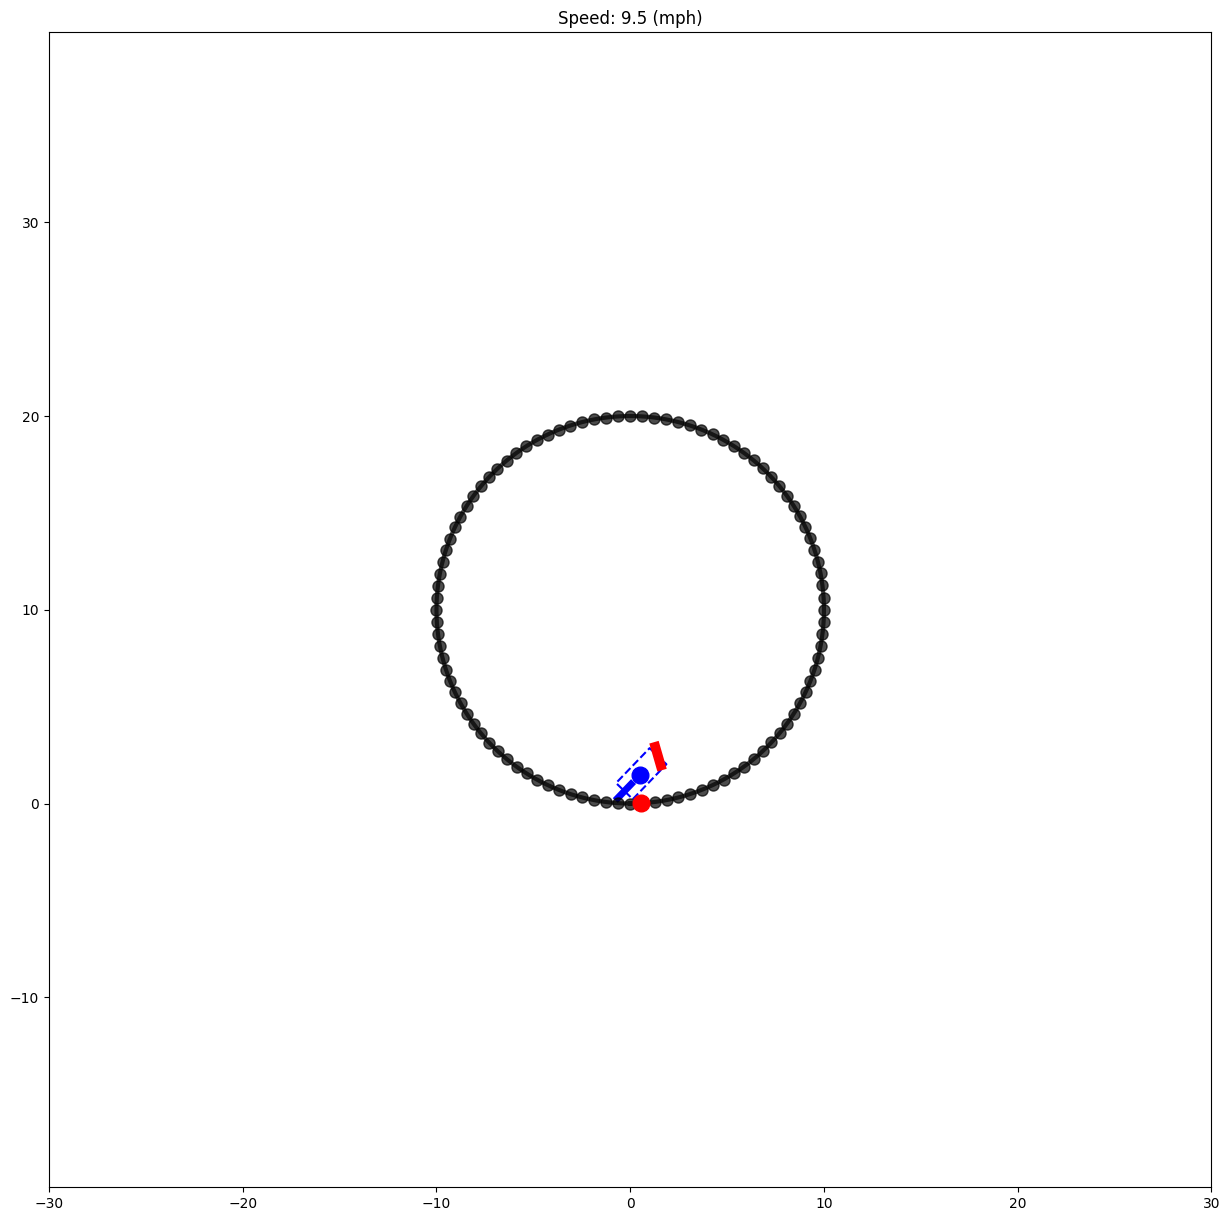

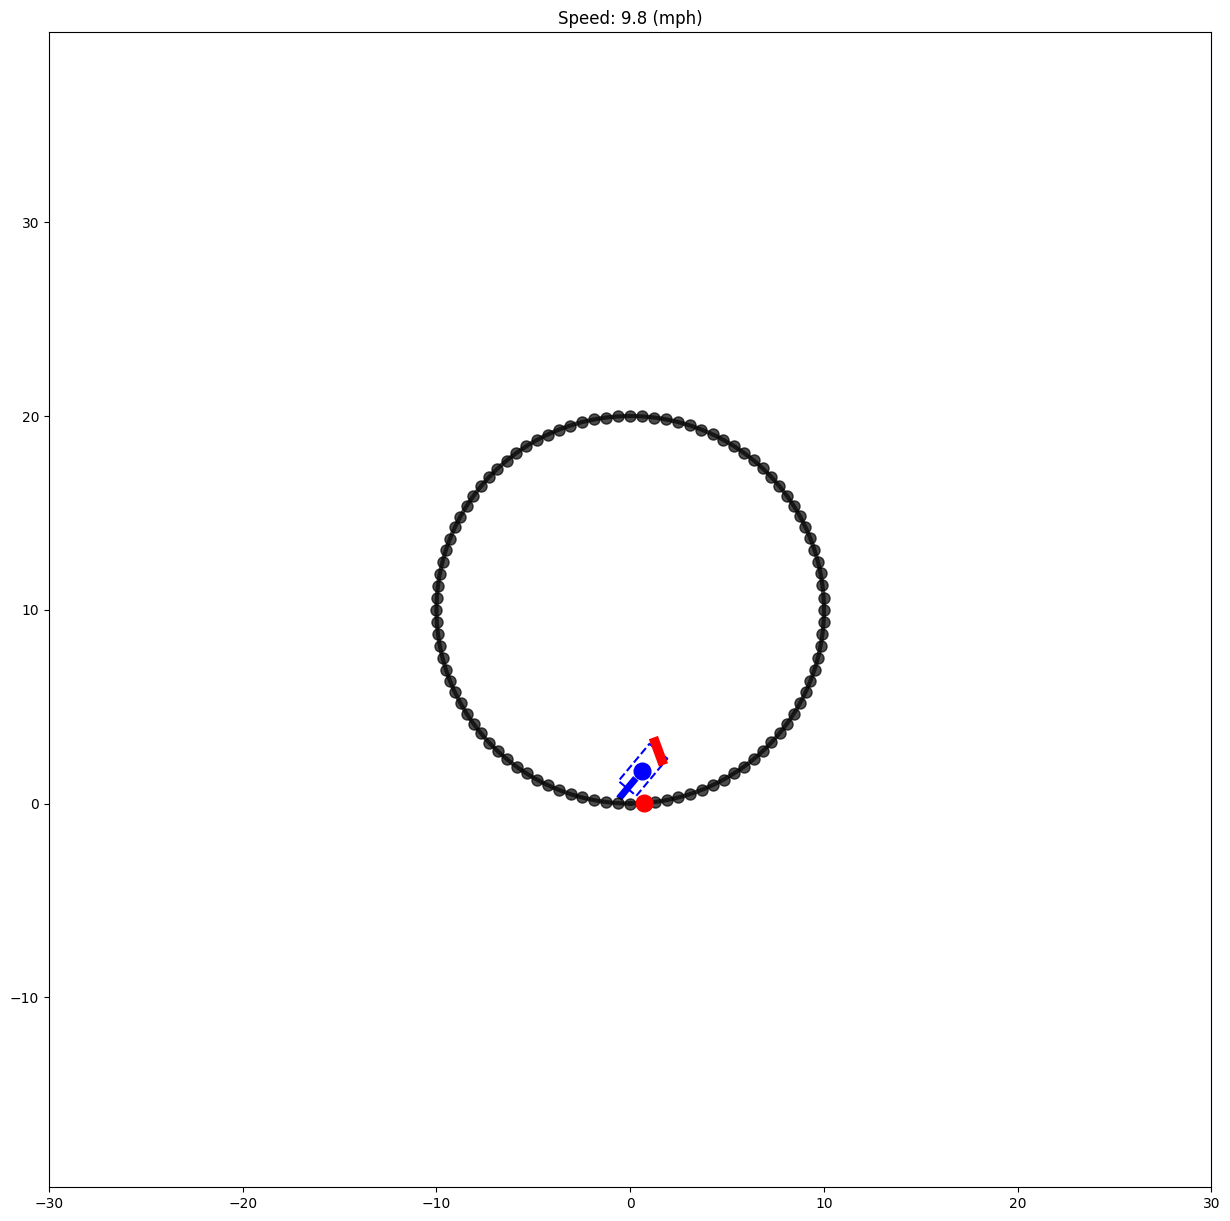

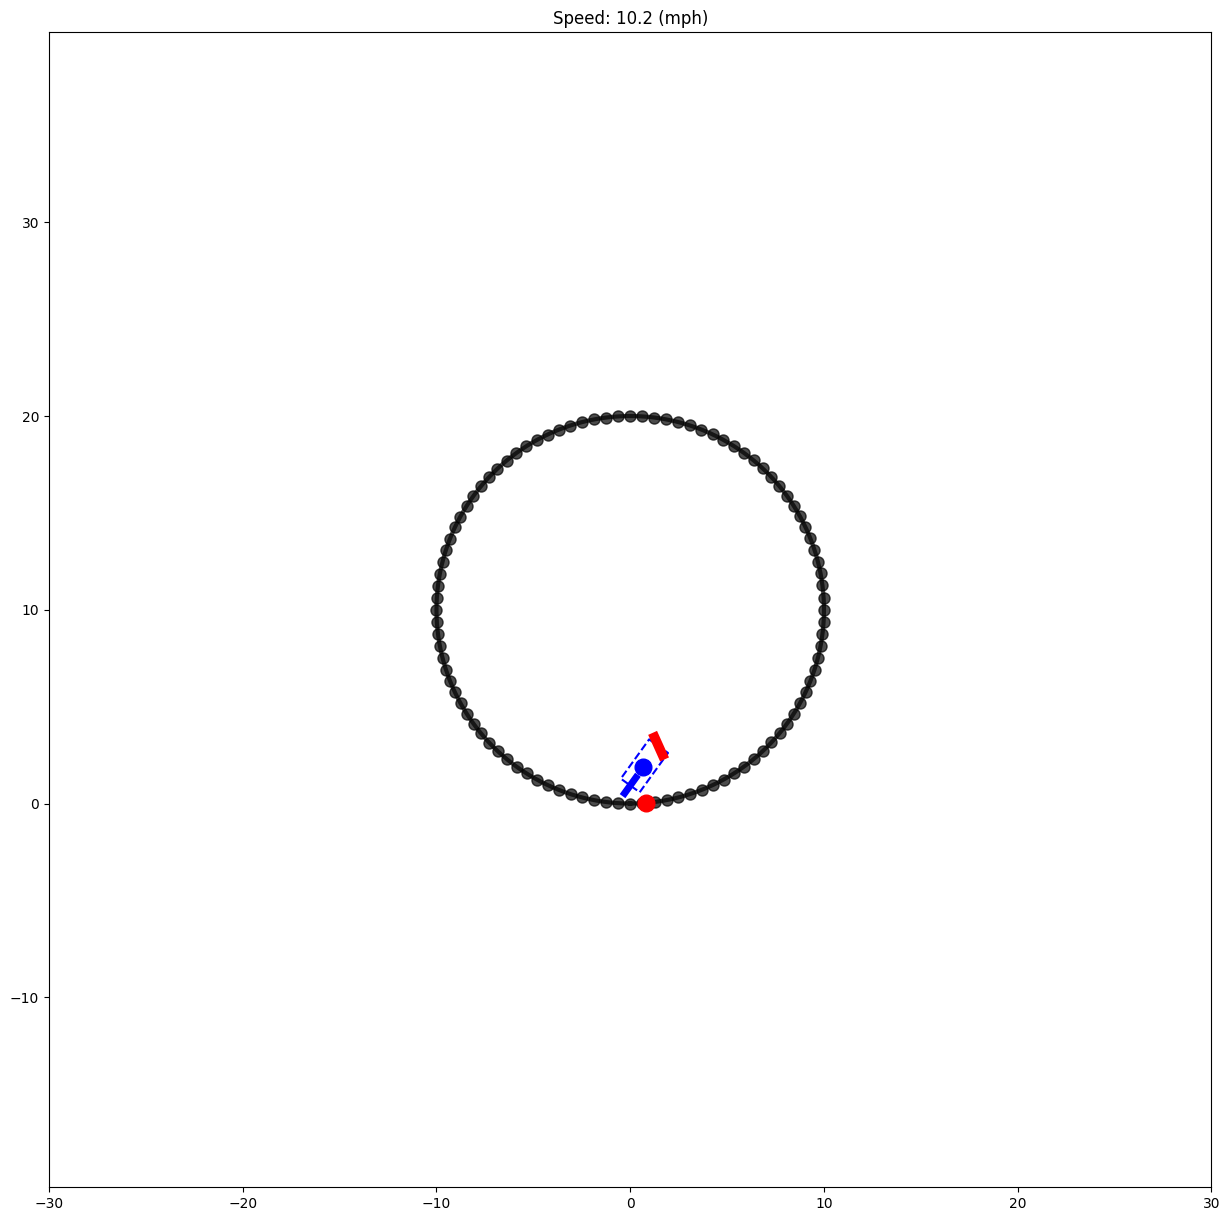

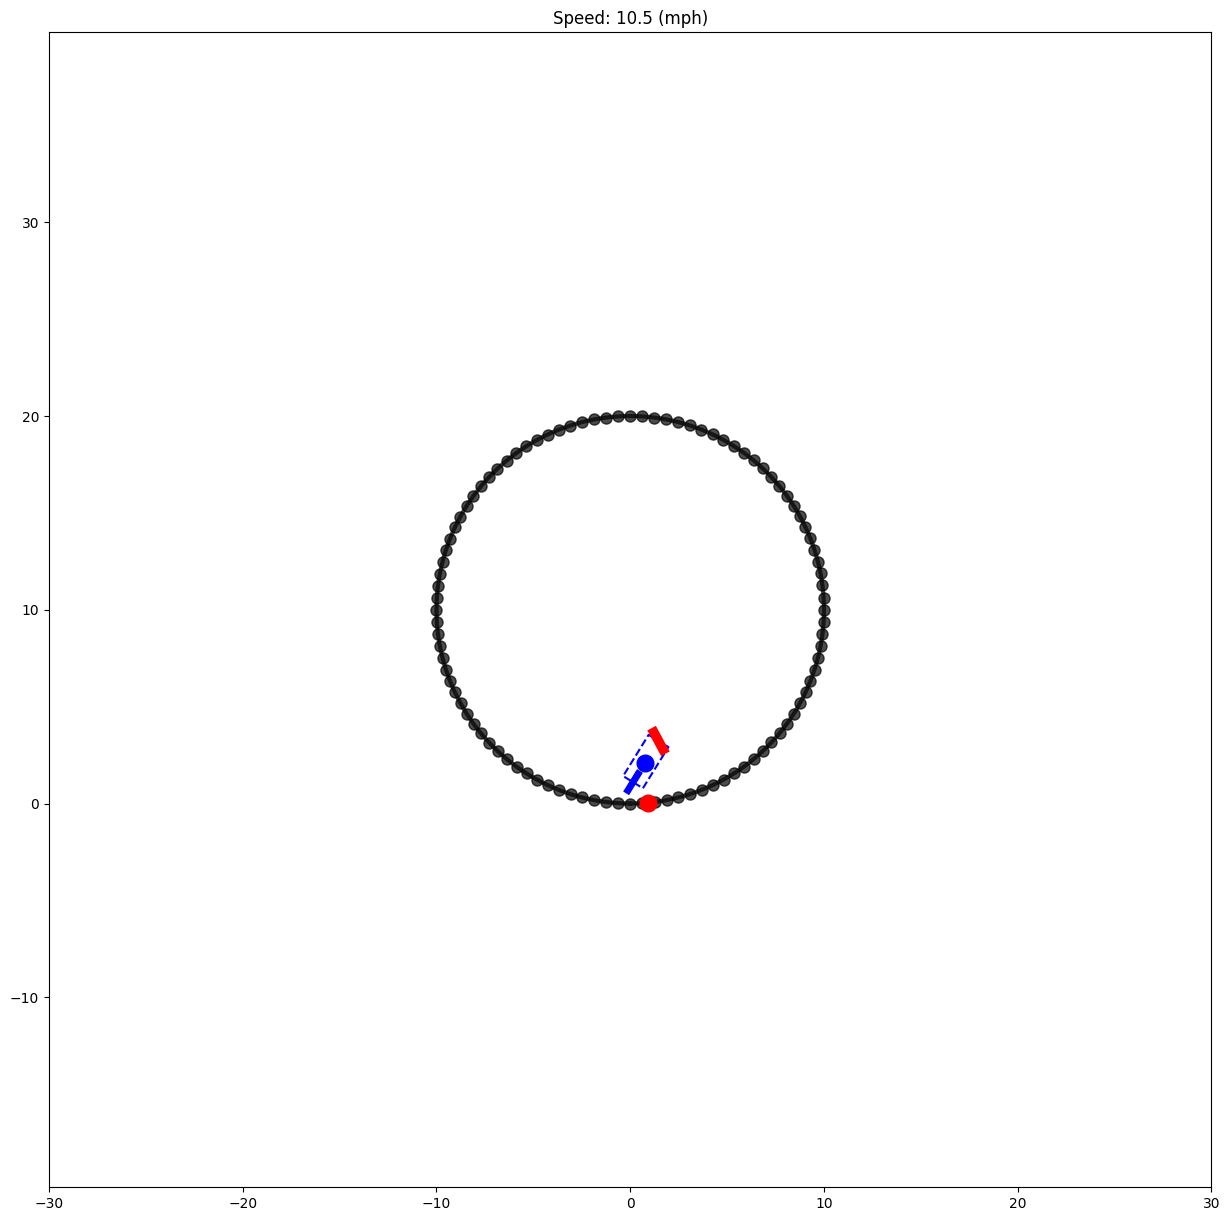

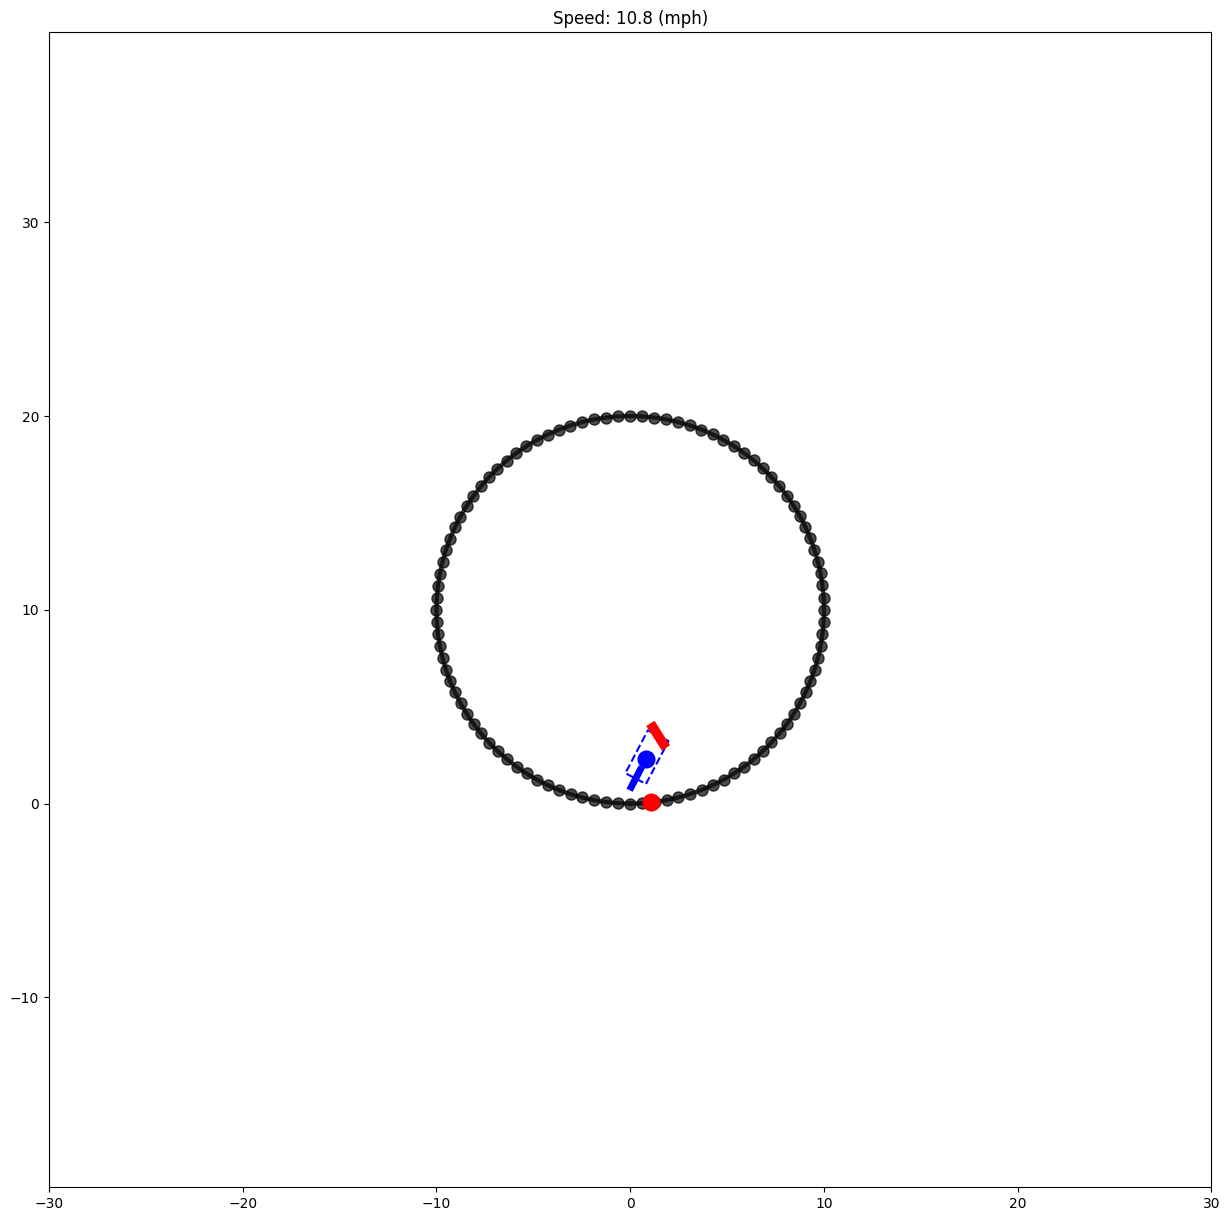

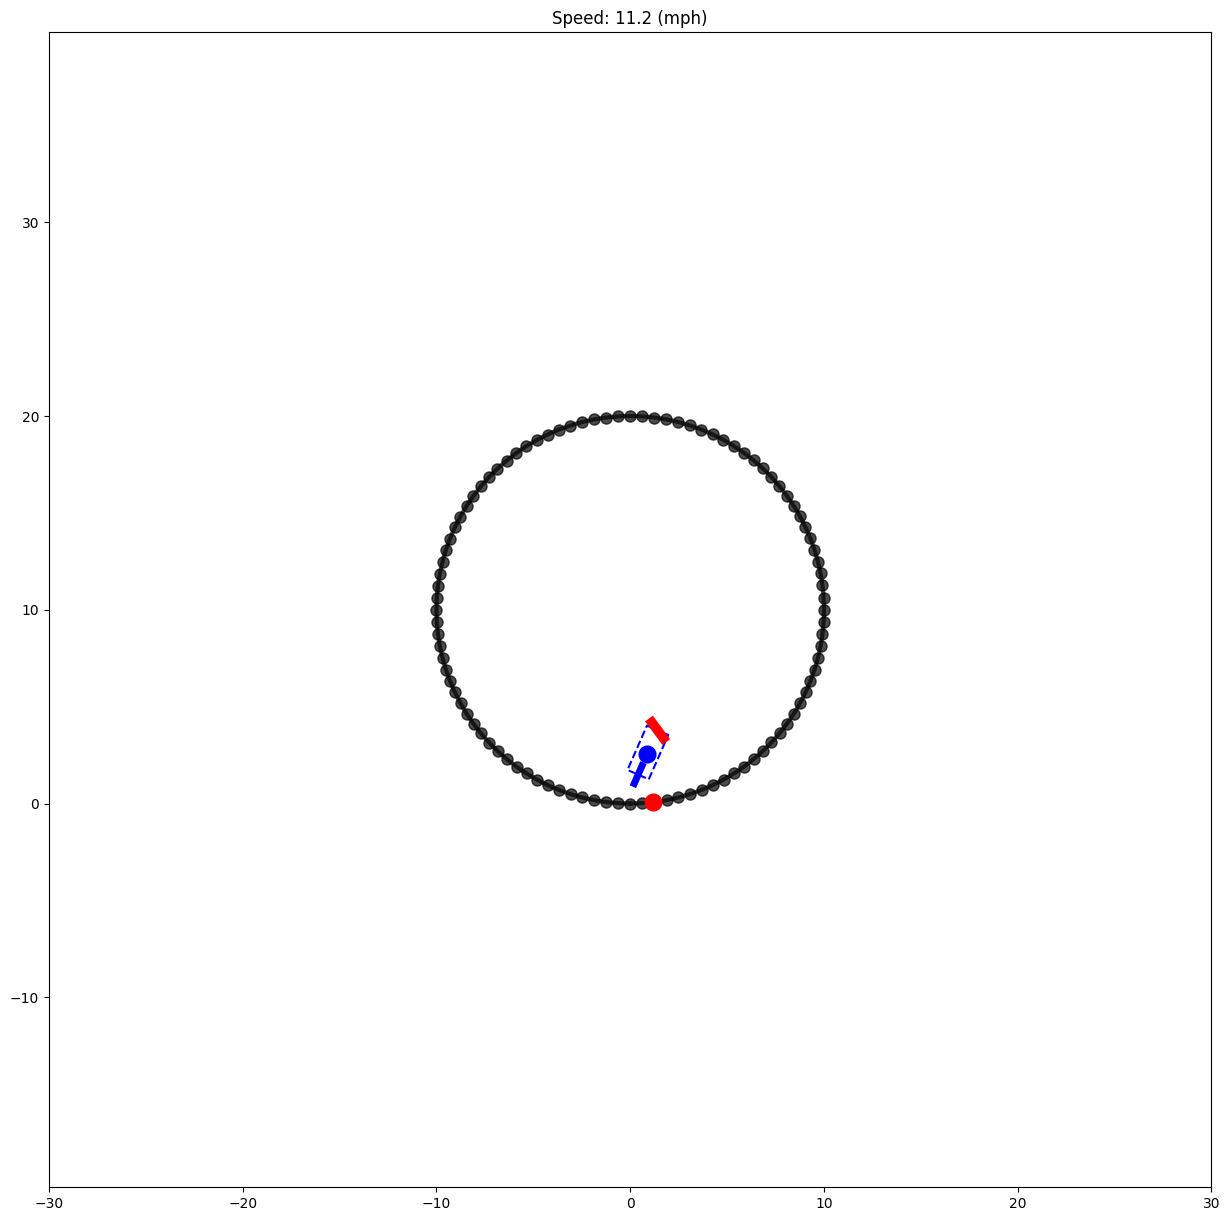

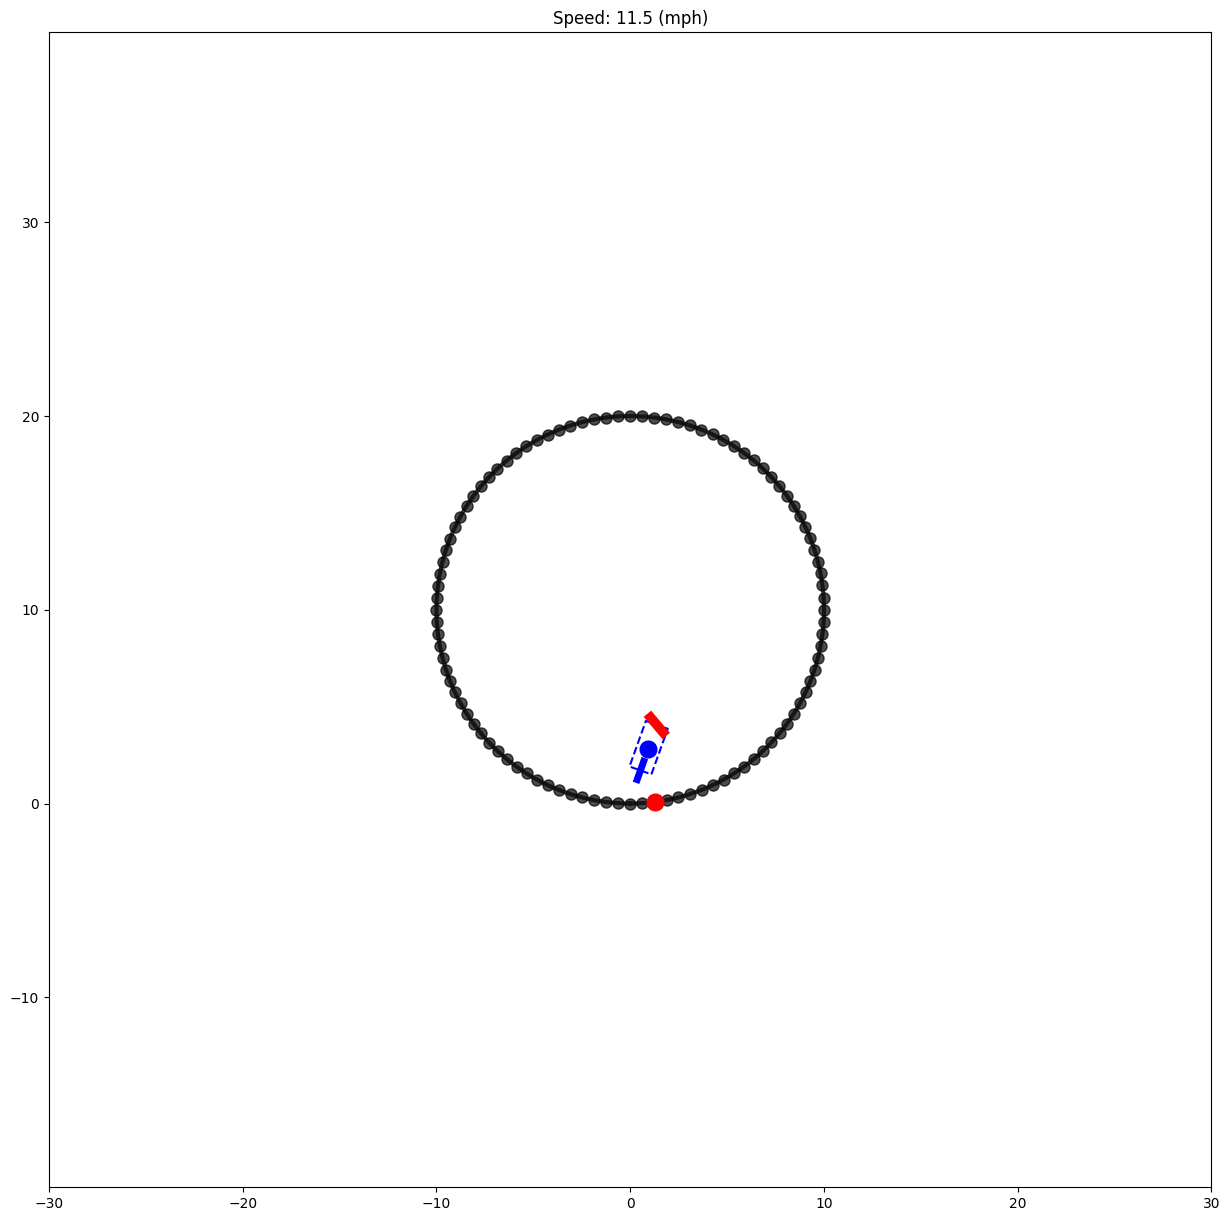

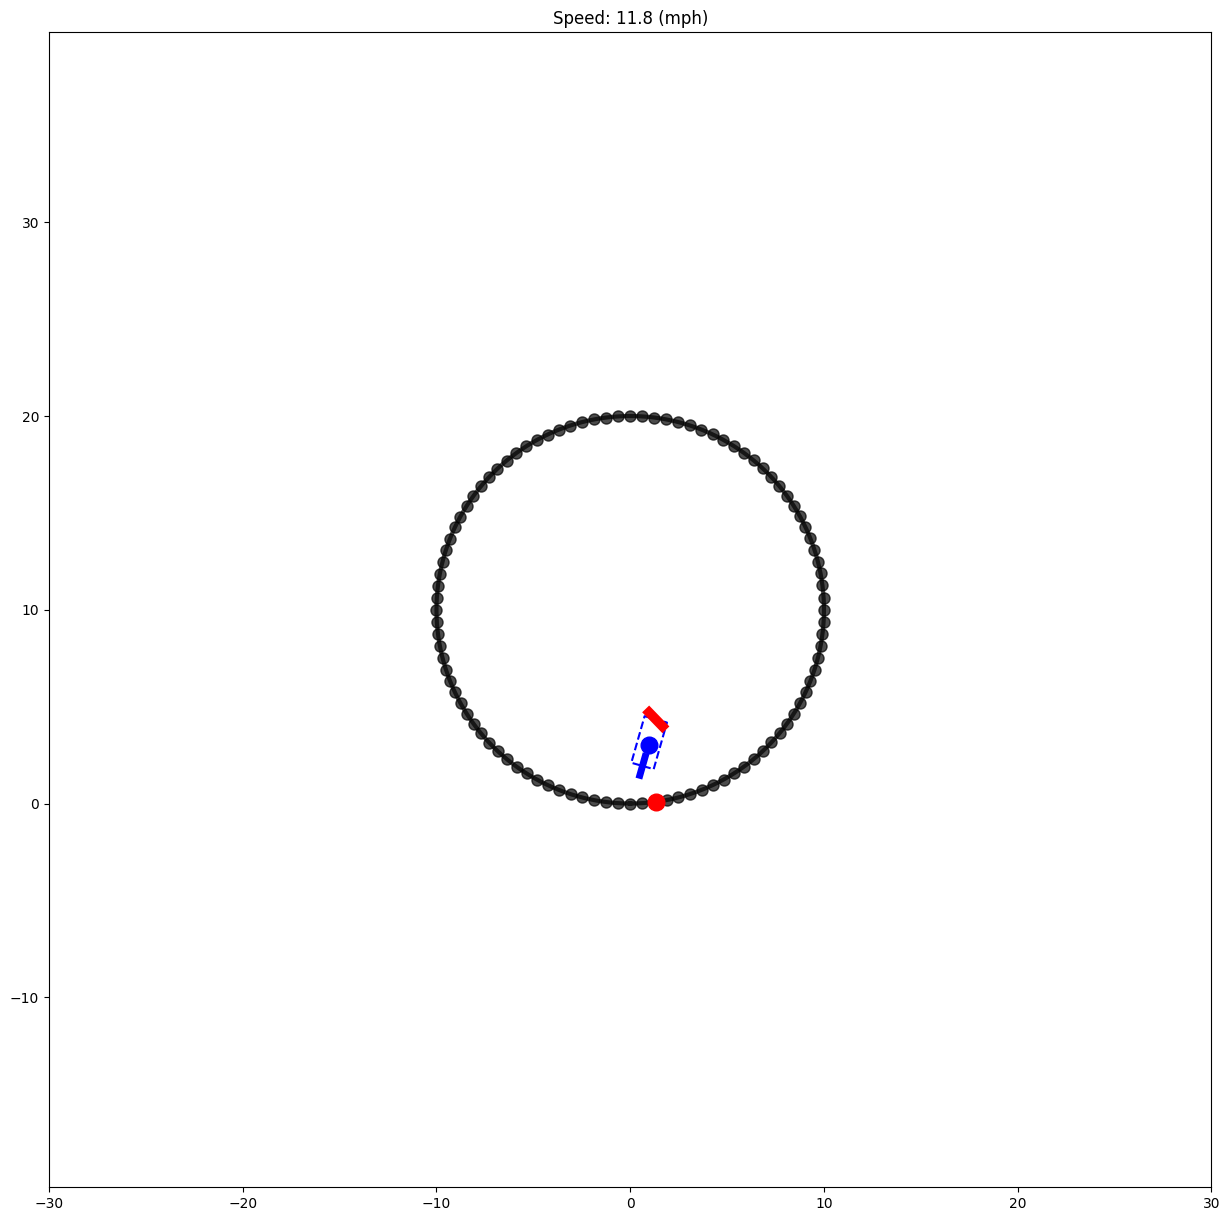

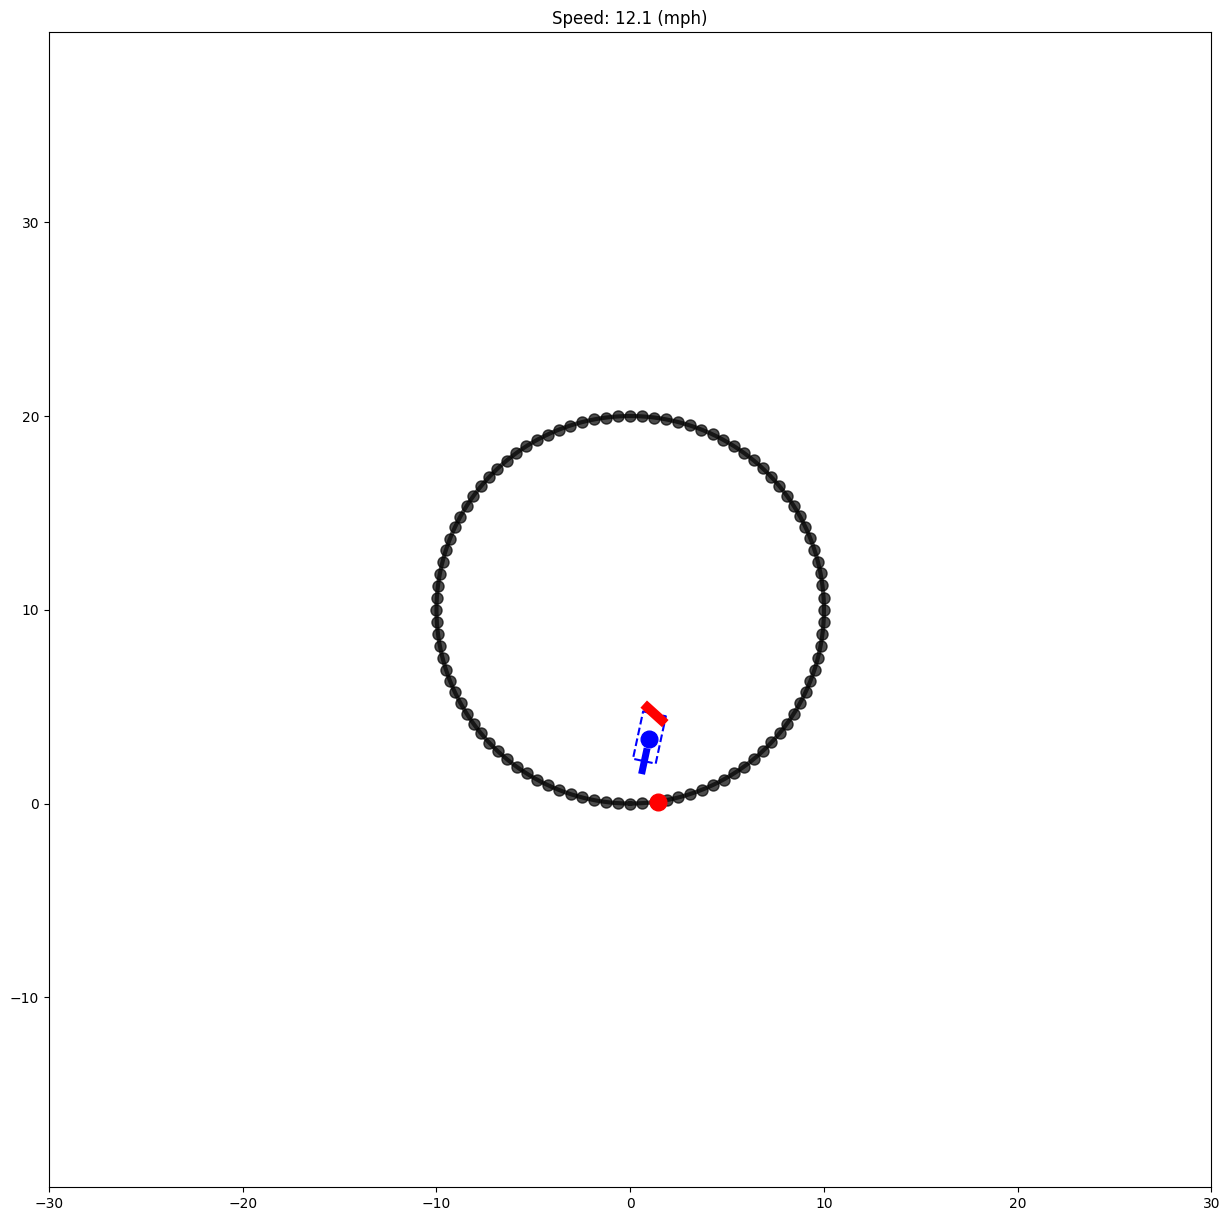

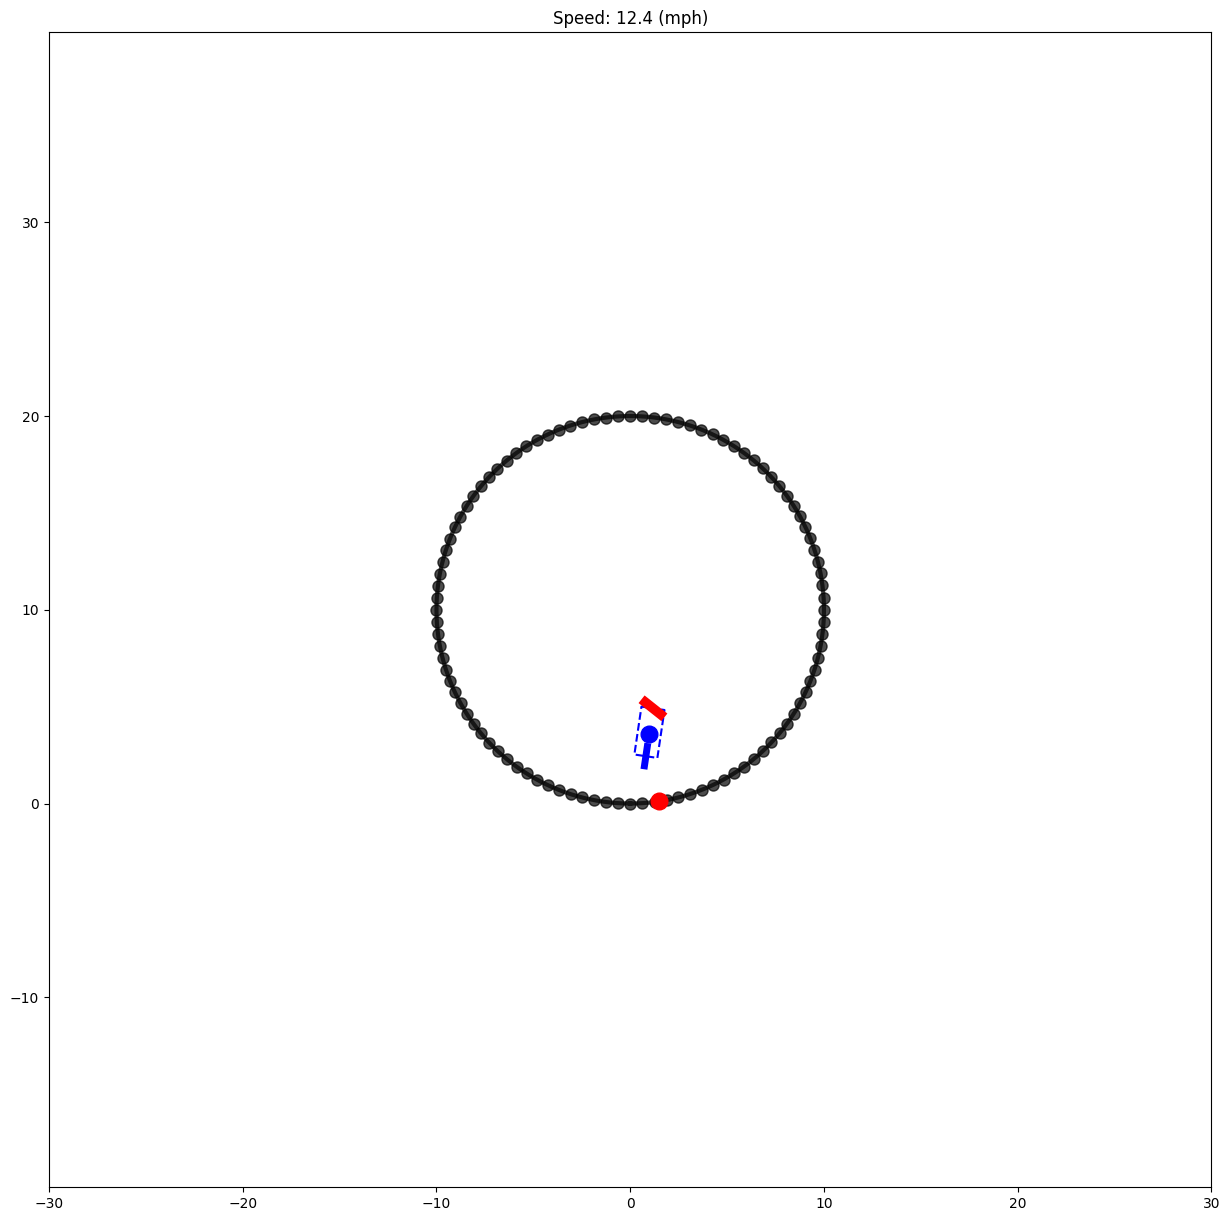

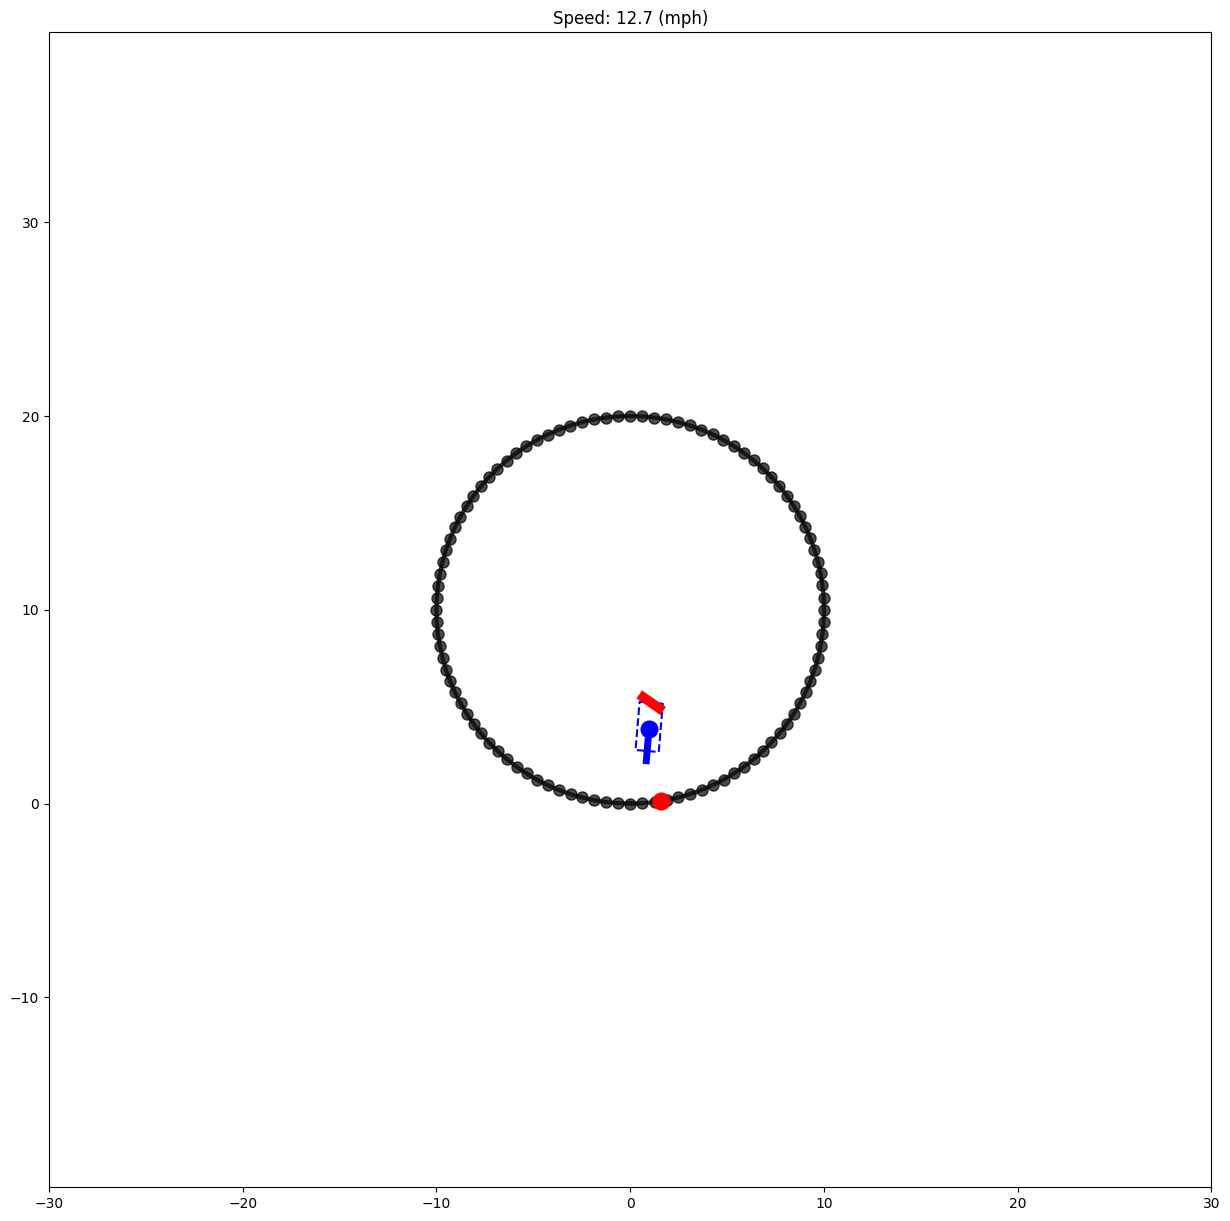

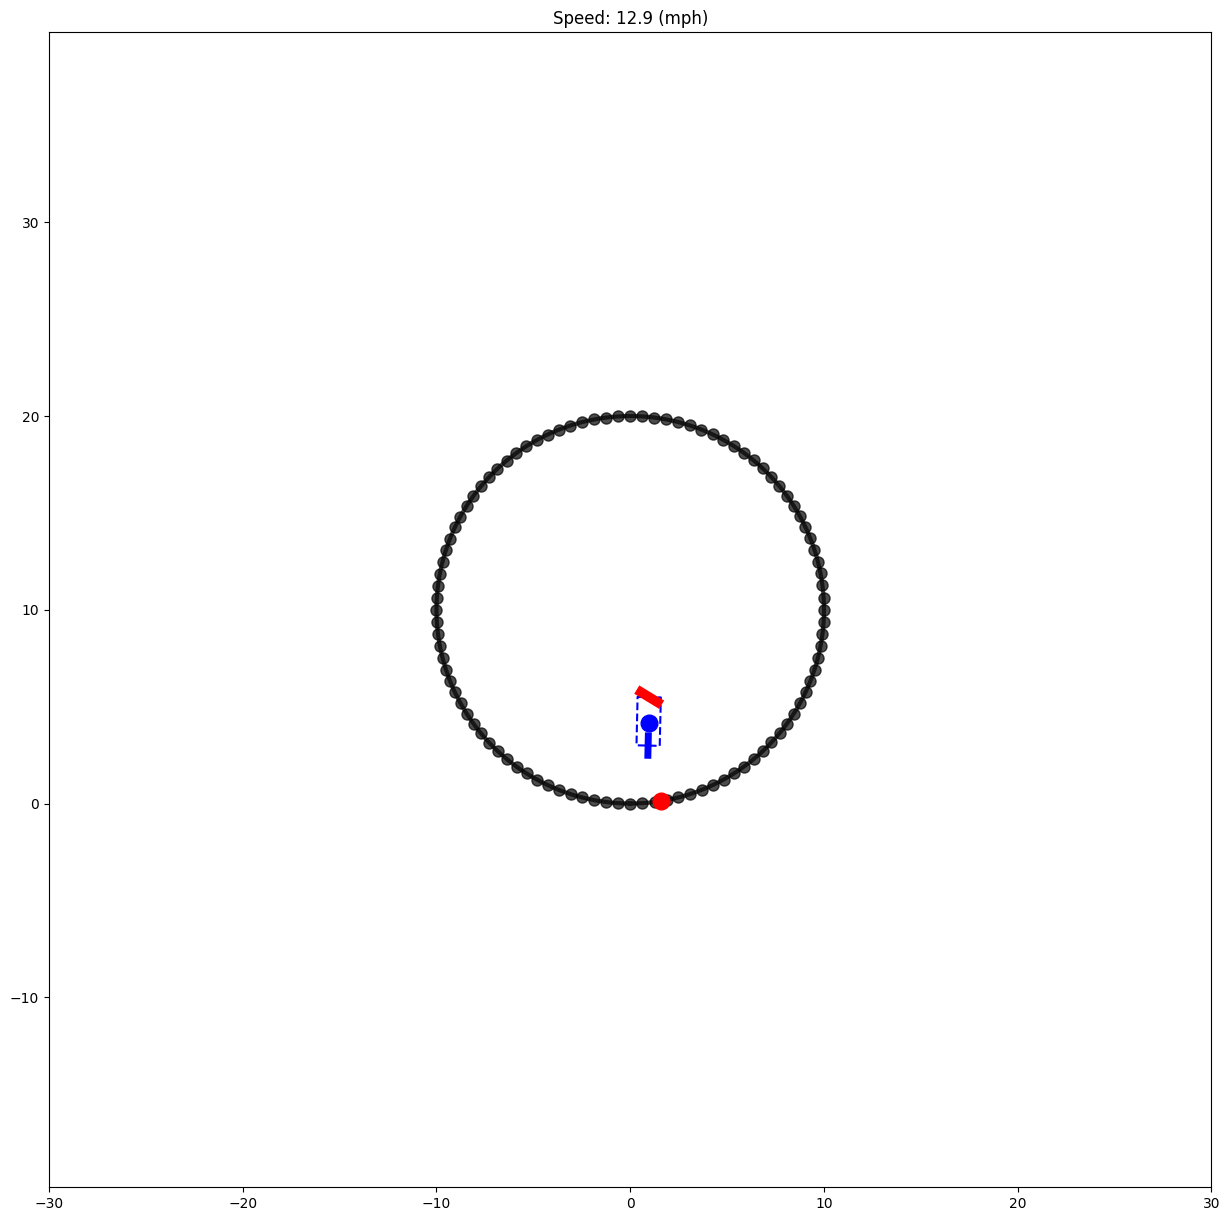

Circle total reward: 9.89067883765901


In [16]:
rc_env = SDRaceCar(render_env=True,track='Circle')
controller = RaceCarController("Circle")

obs = rc_env.reset()
total_reward = 0.0

for step in range(5000):
    action = controller(obs)
    obs, reward, done, info = rc_env.step(action)
    total_reward += float(reward)

    rc_env.render()

    if done:
        break

print("Circle total reward:", total_reward)


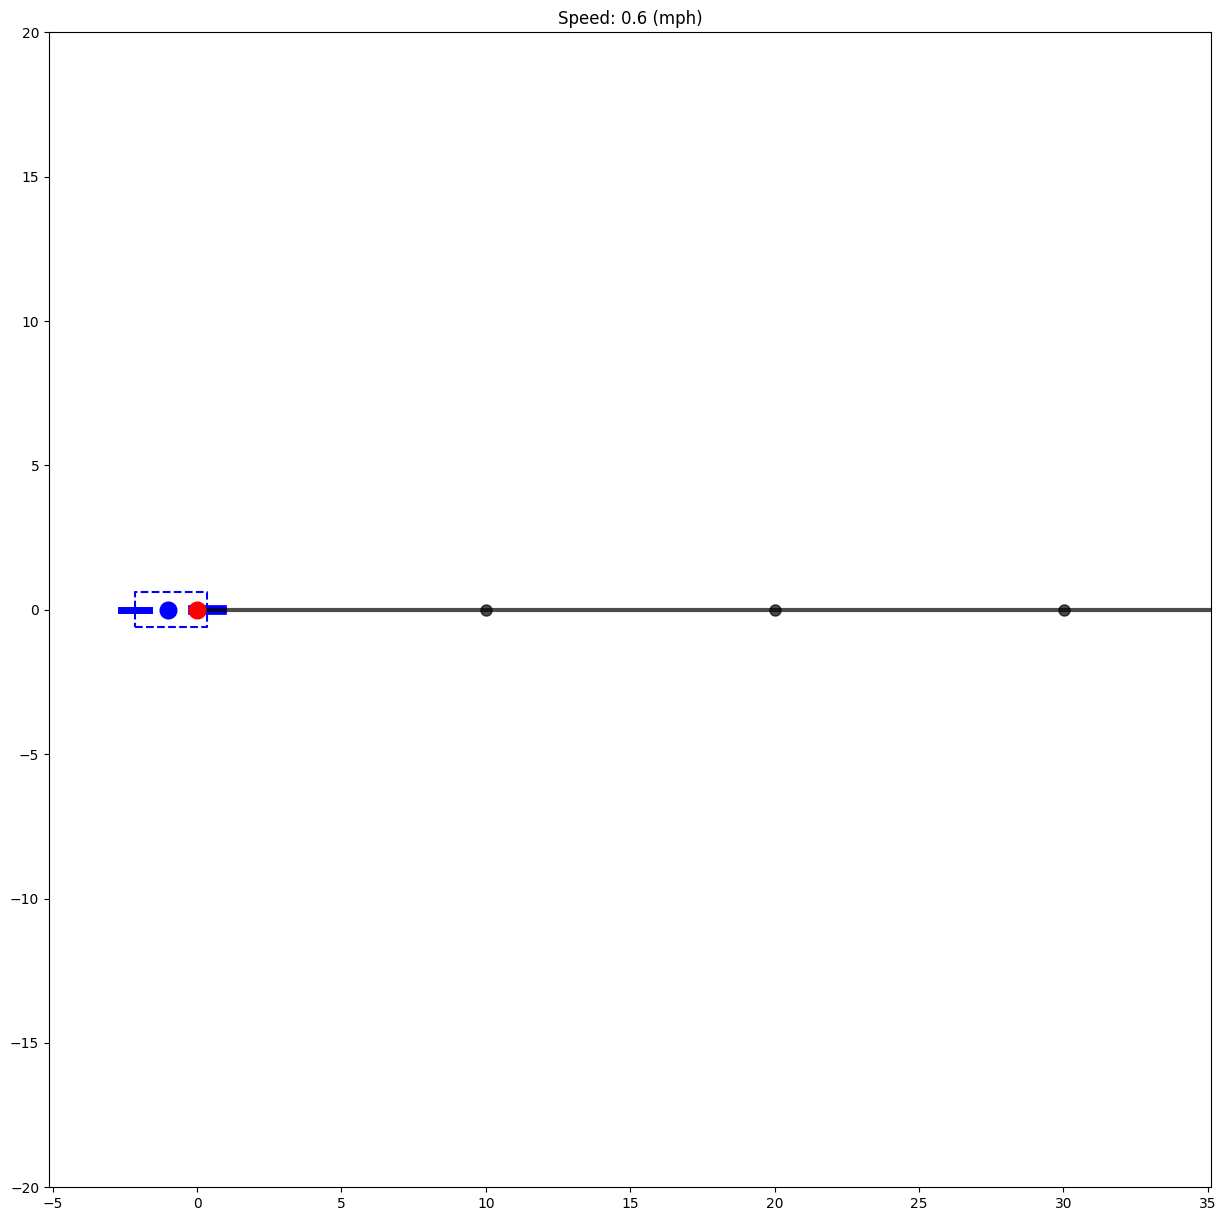

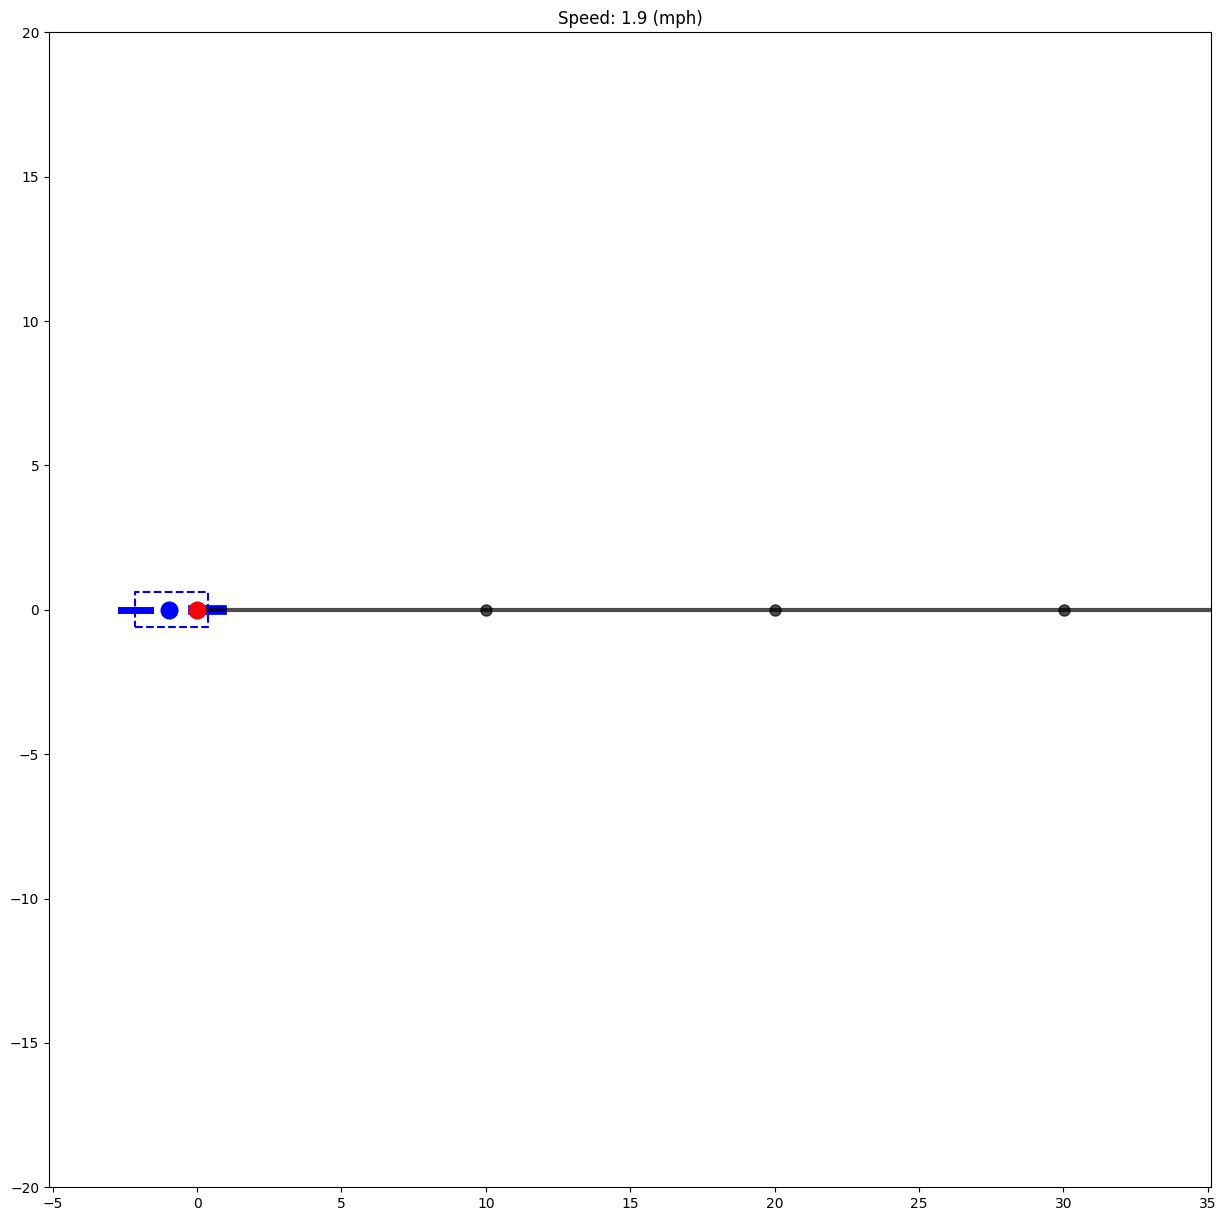

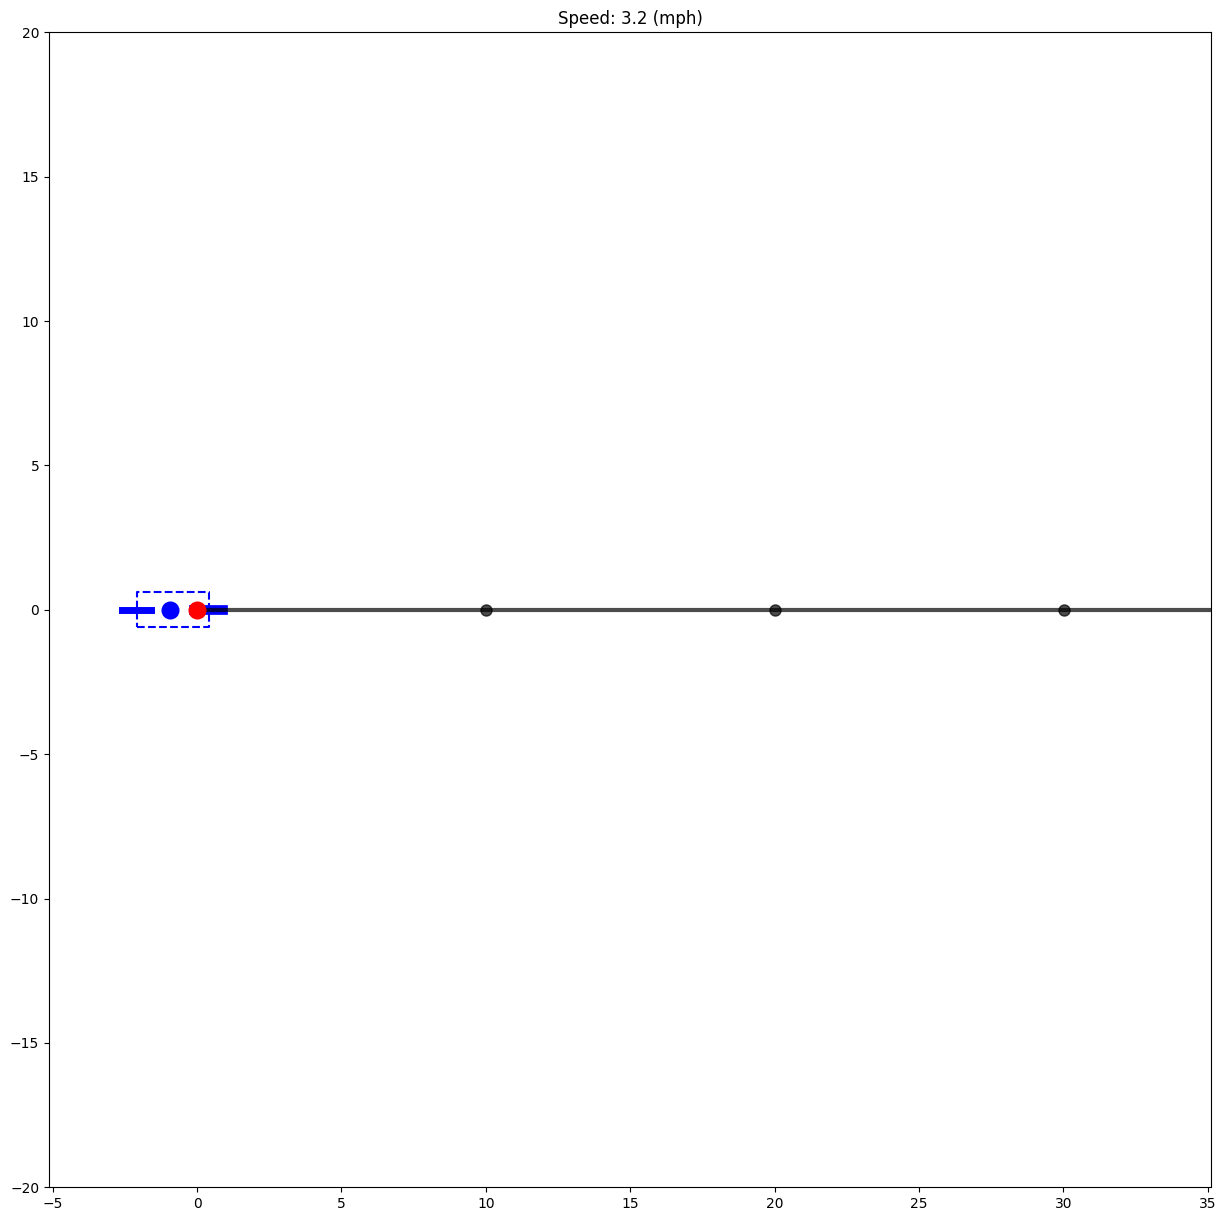

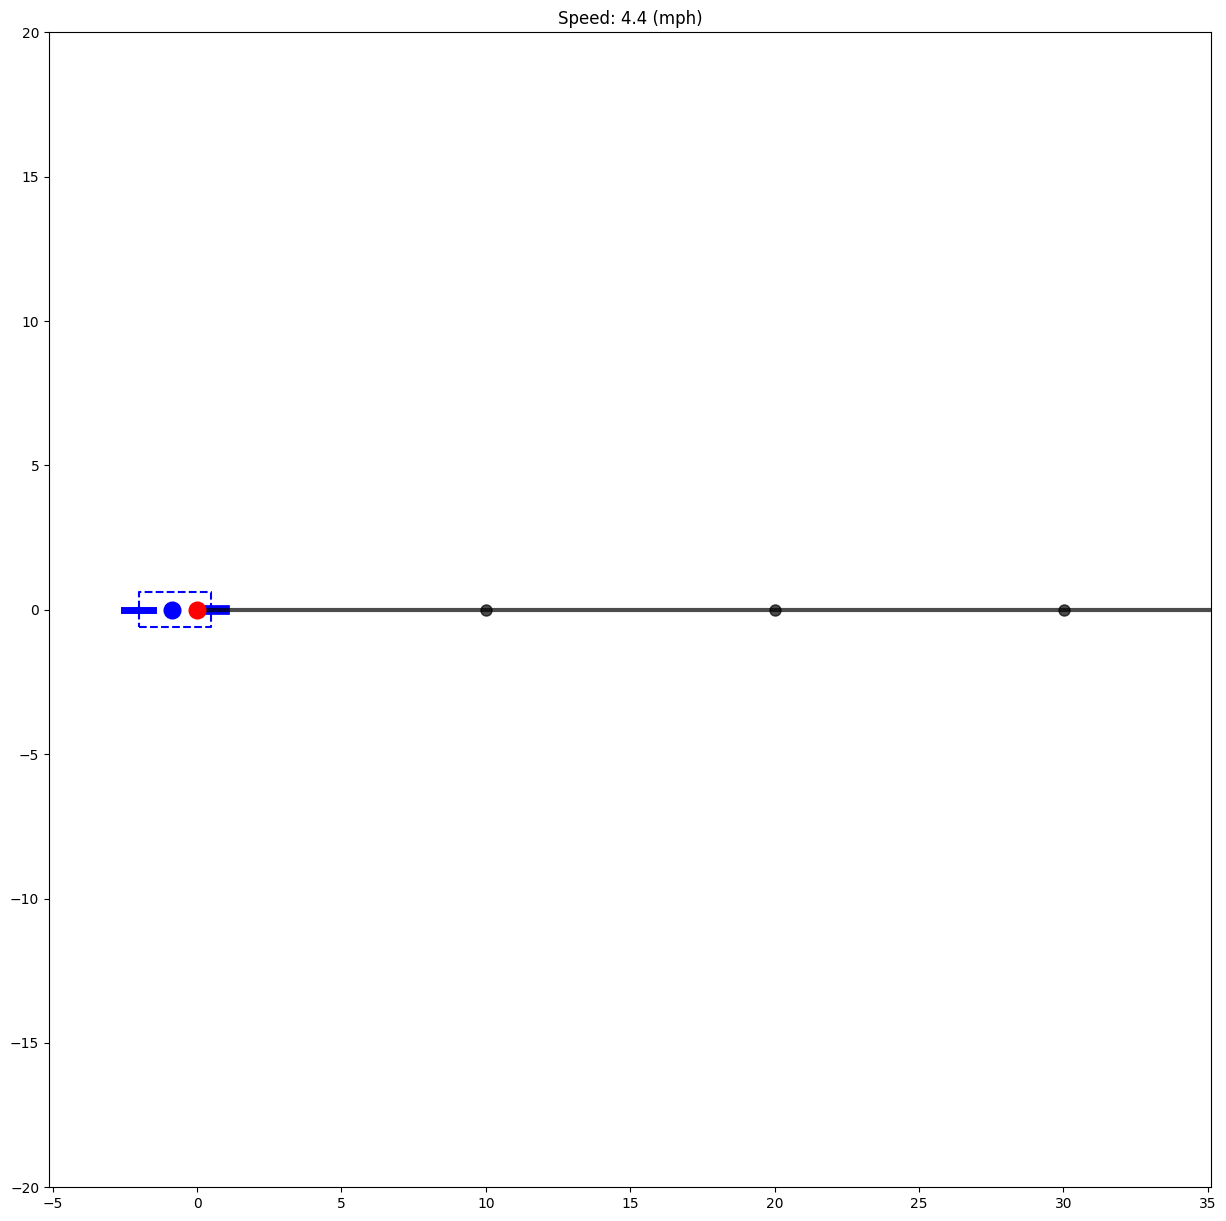

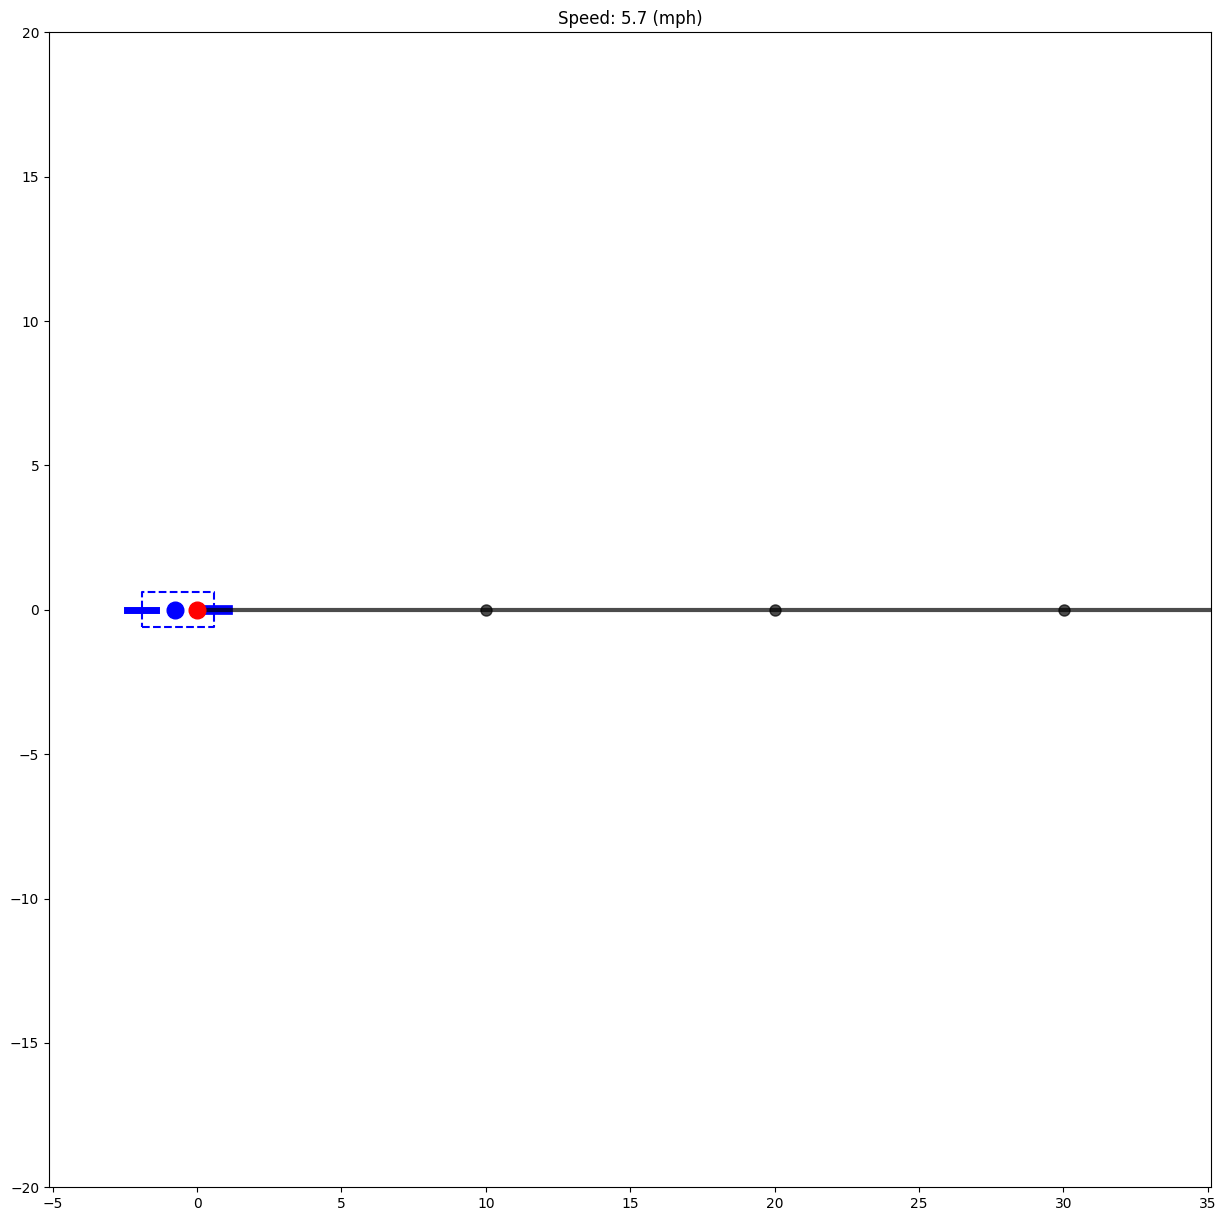

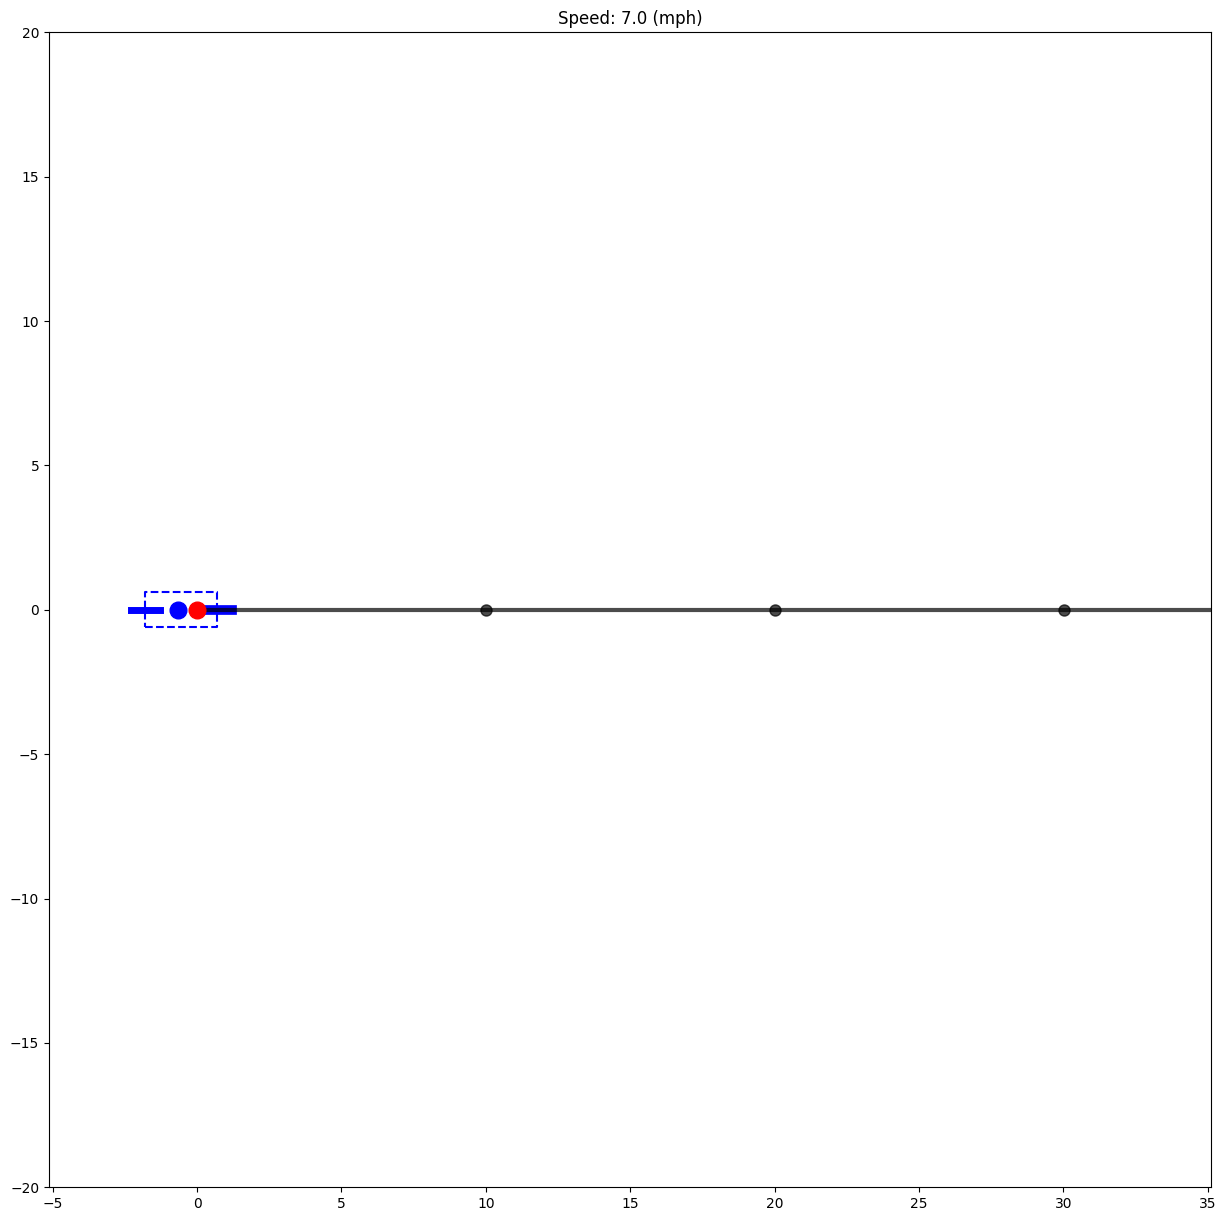

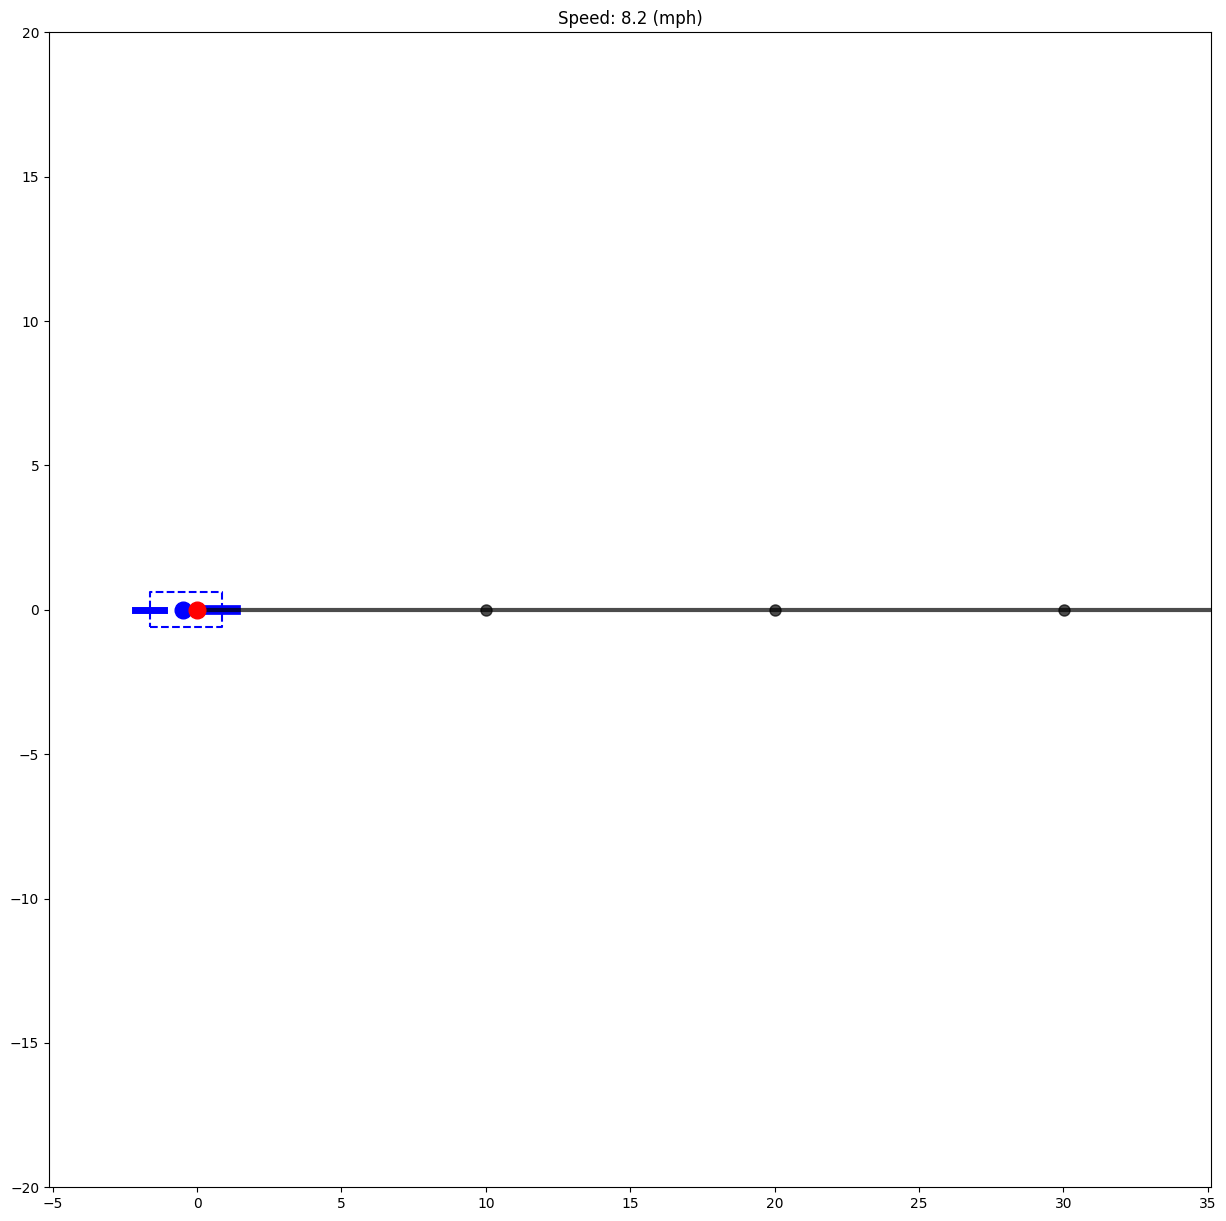

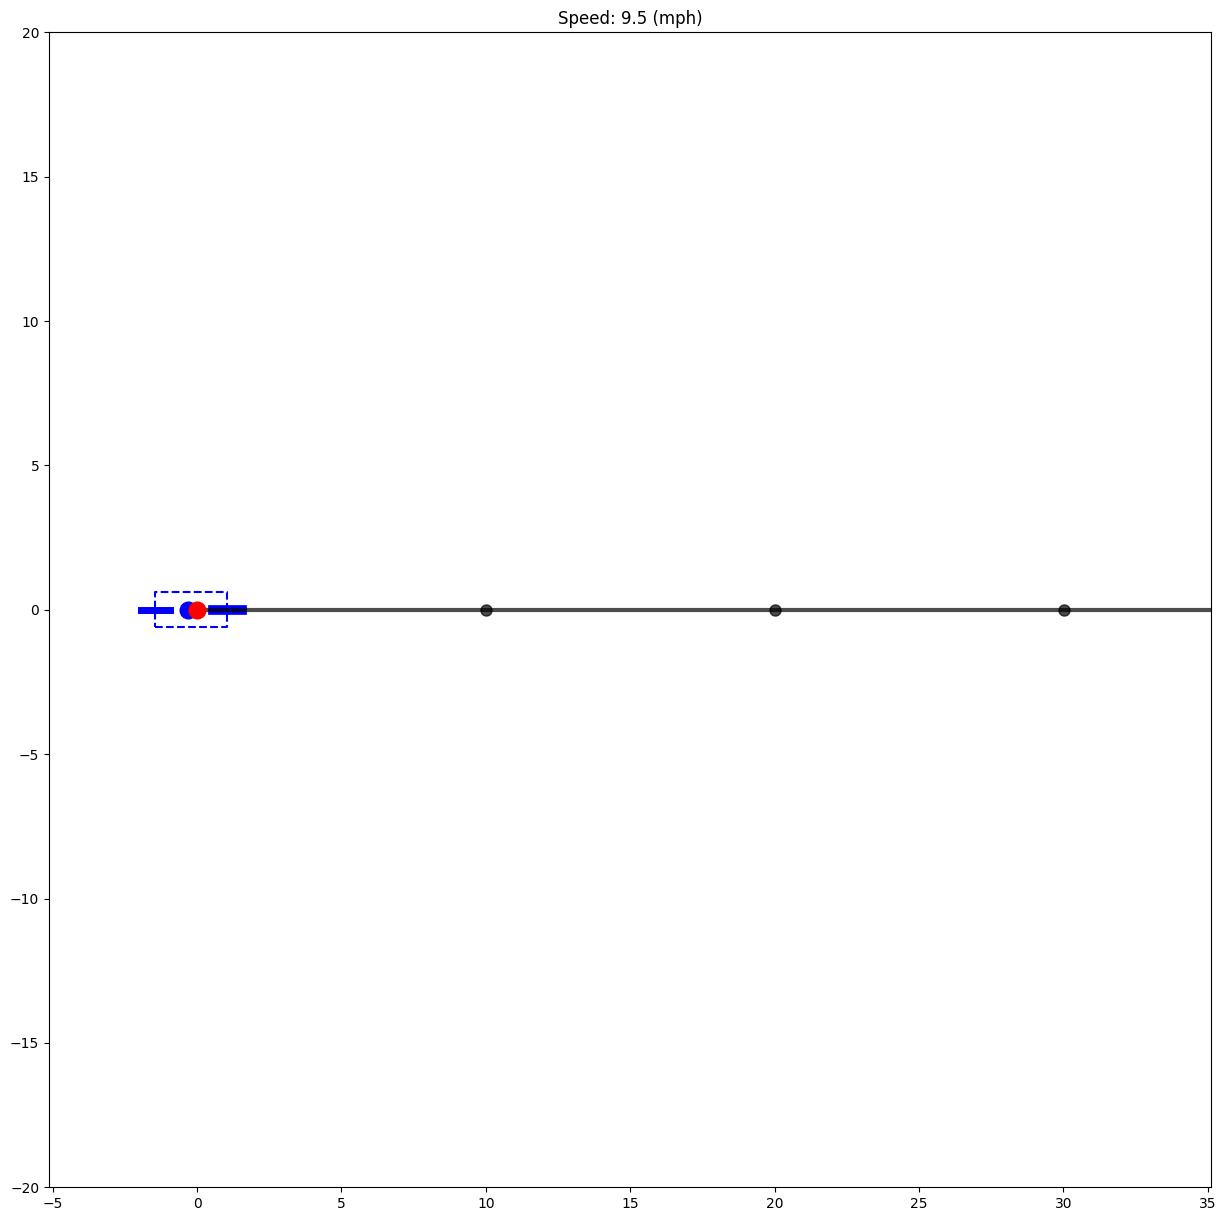

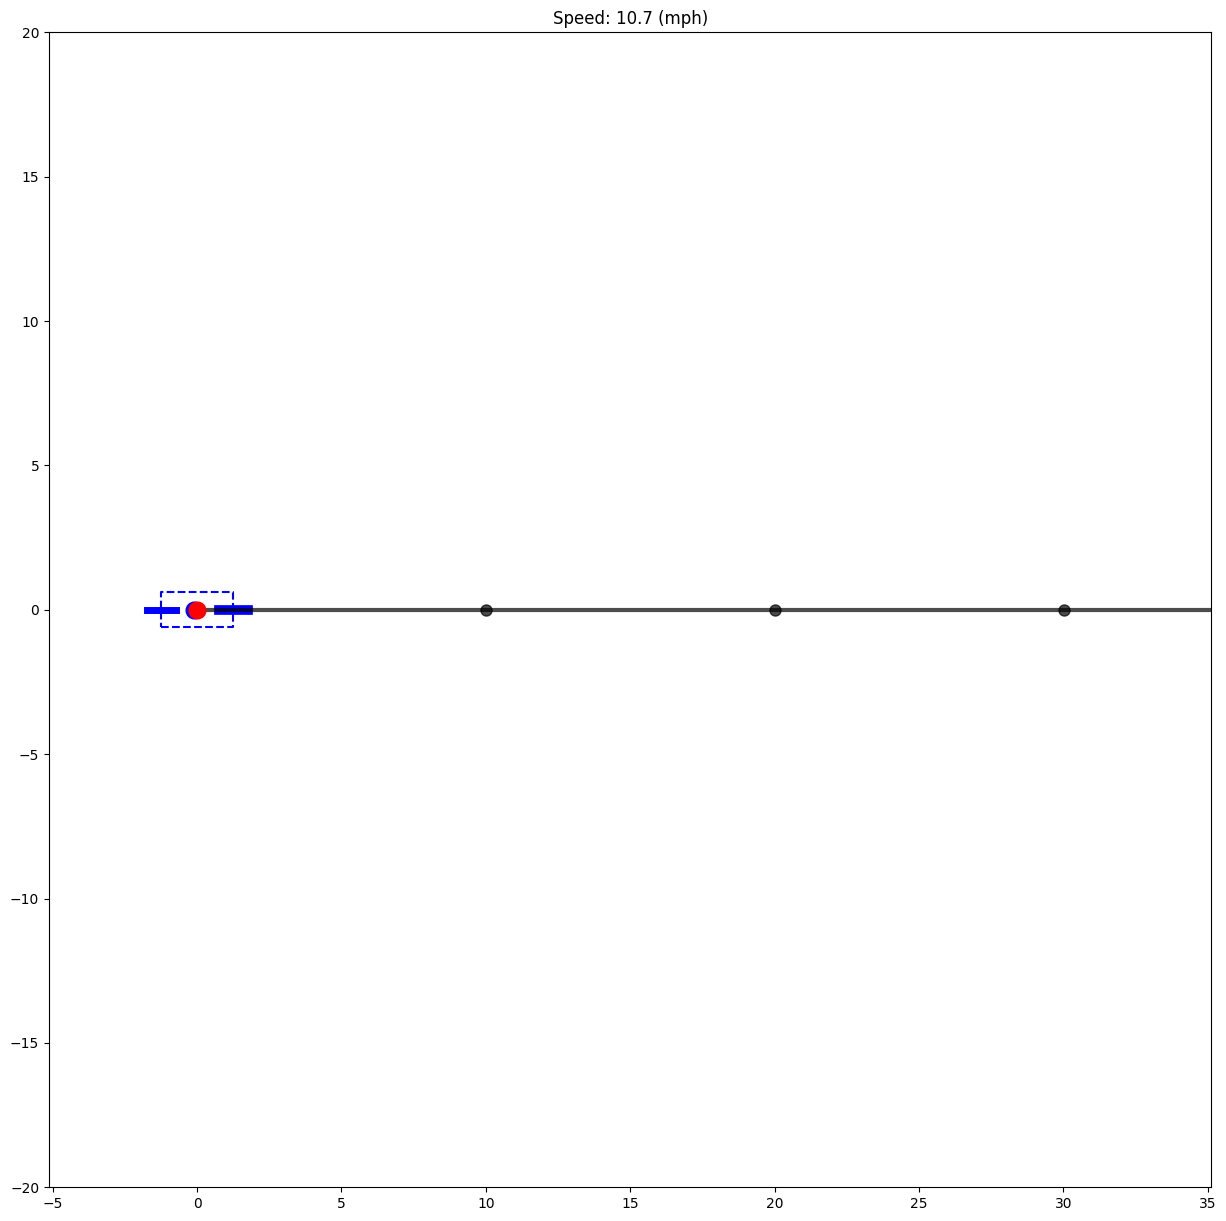

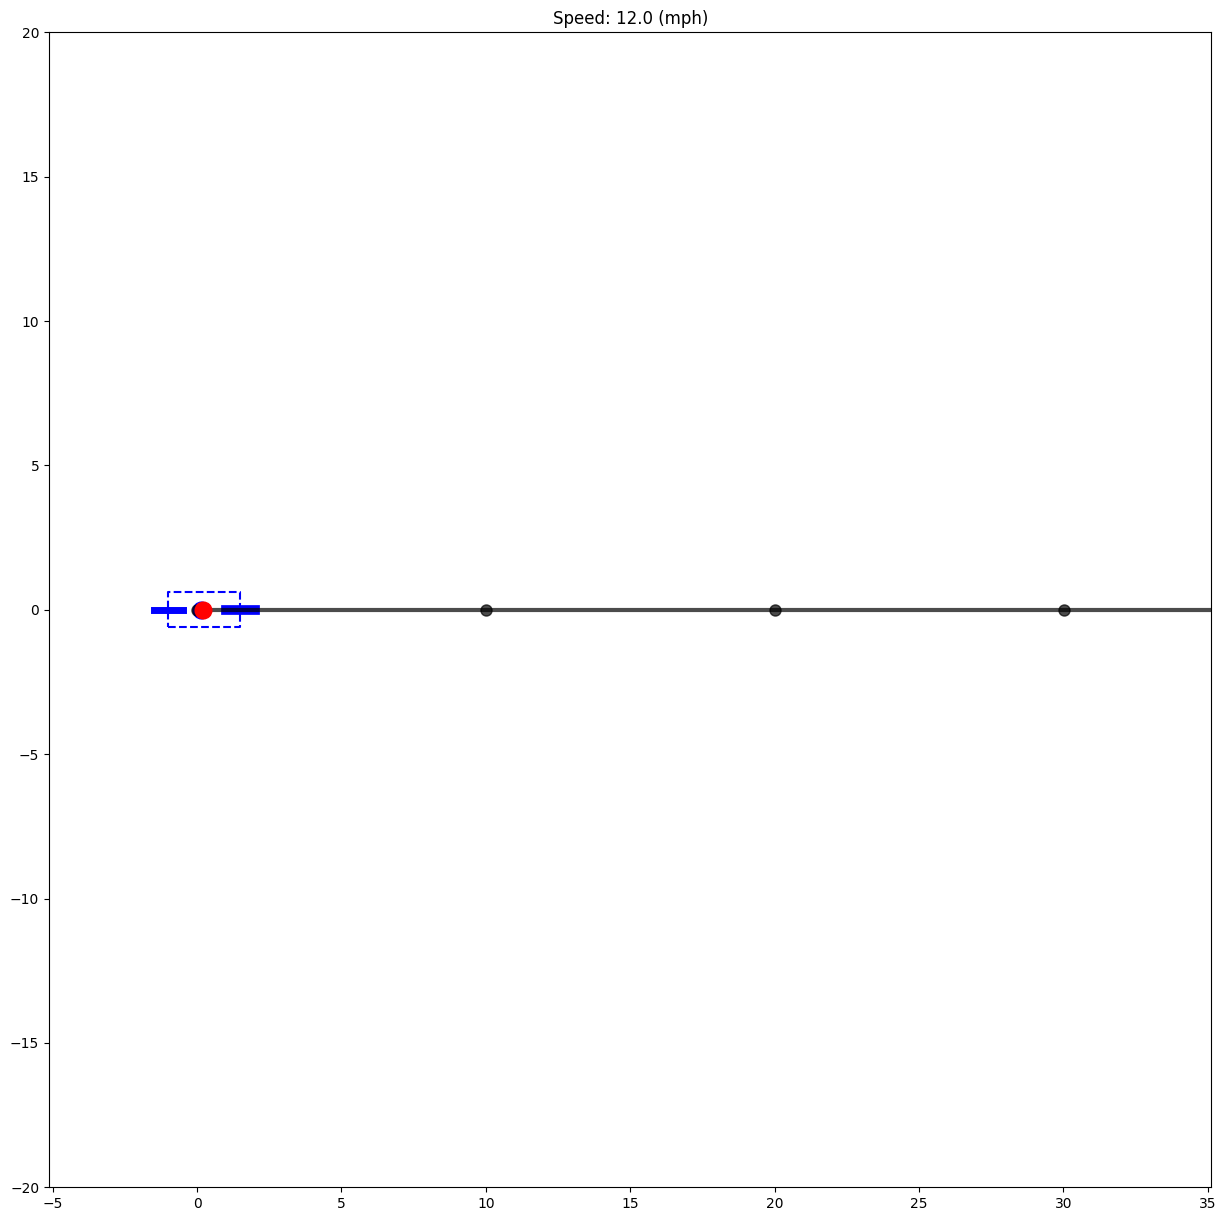

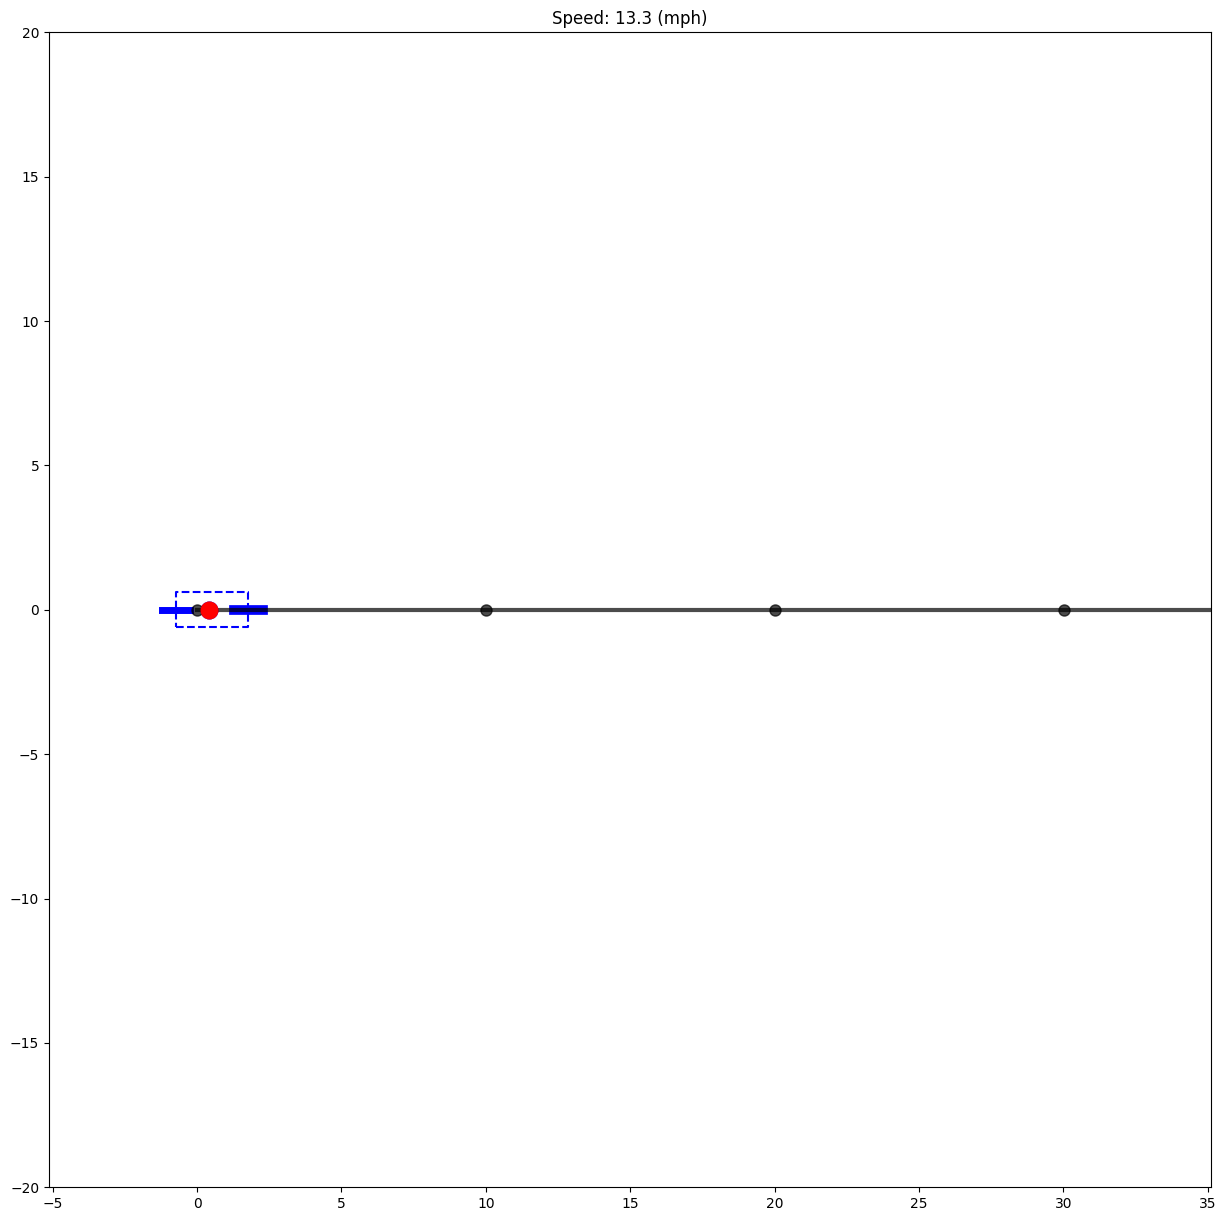

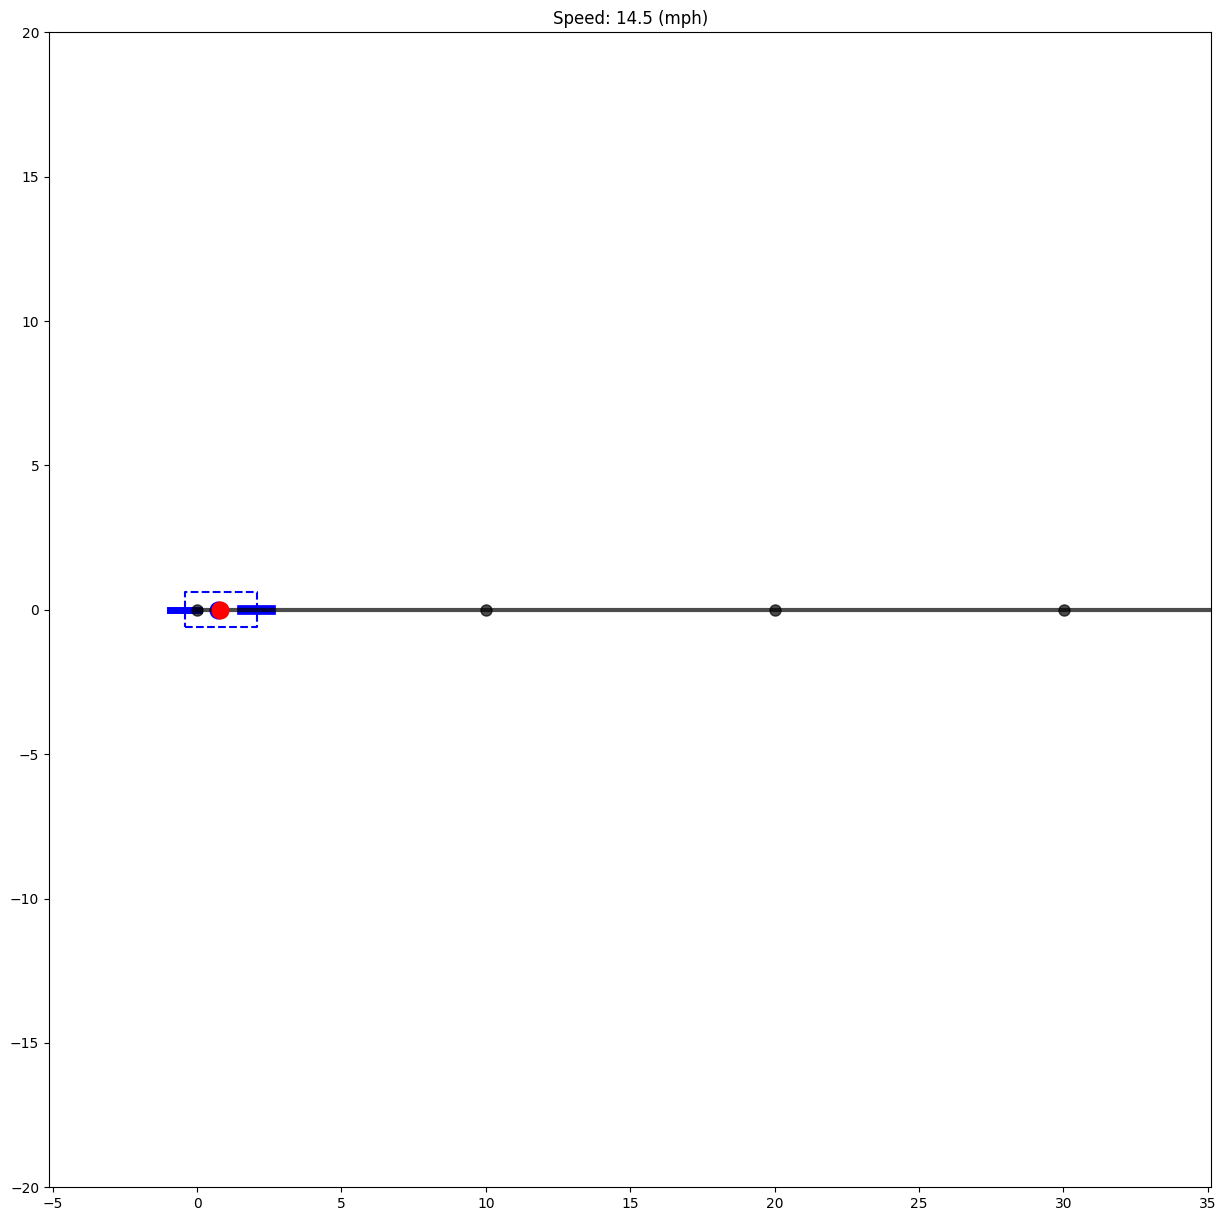

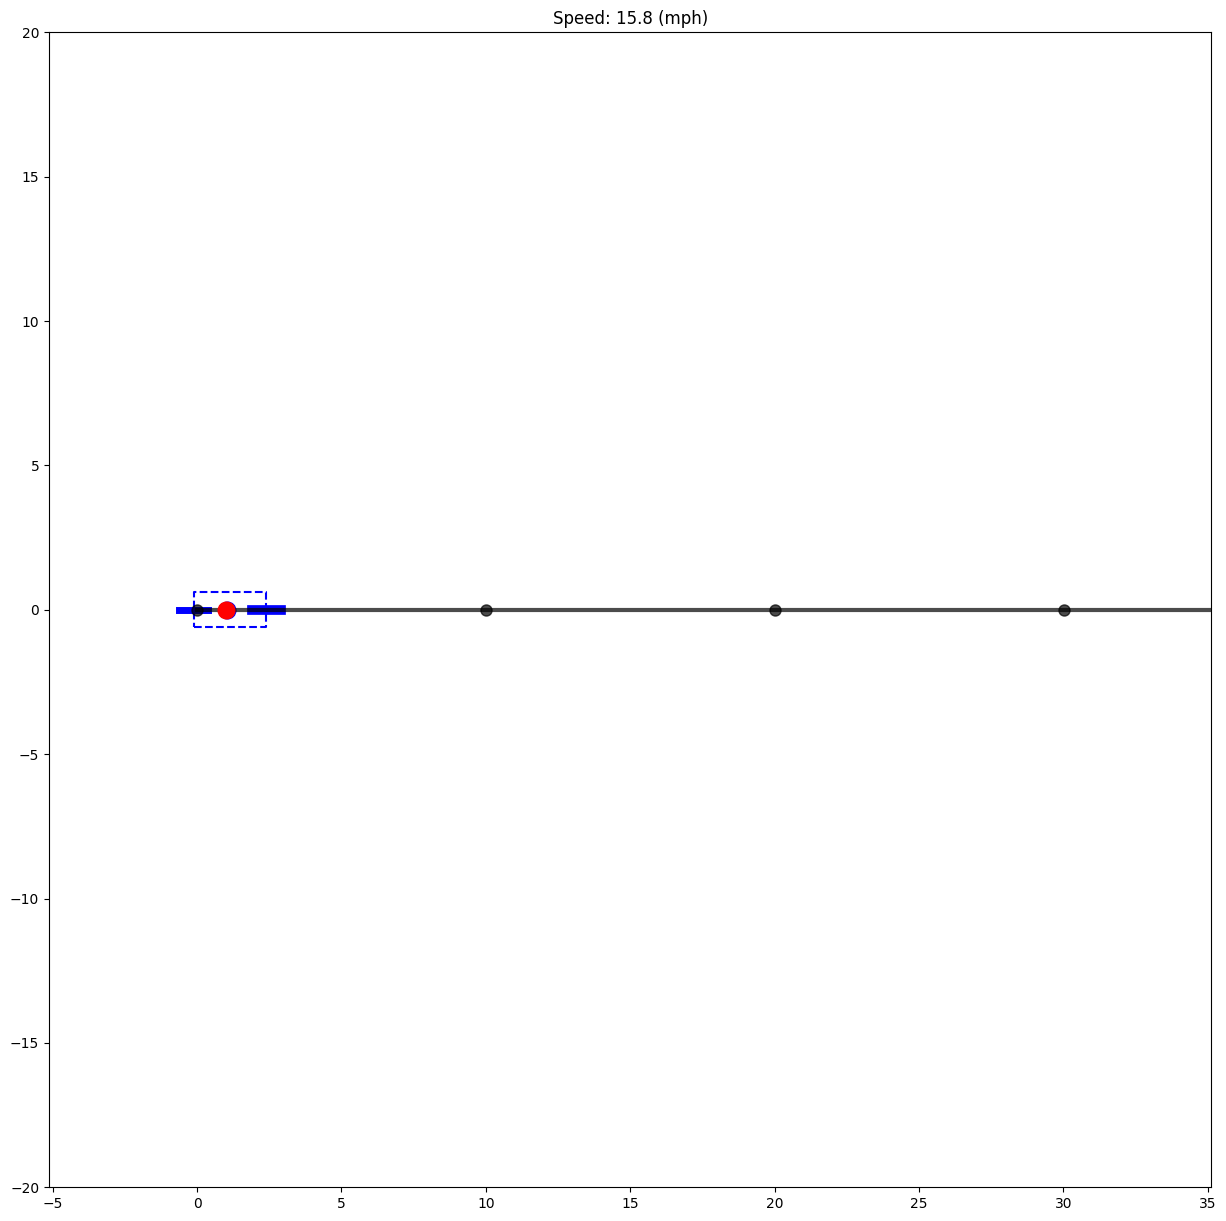

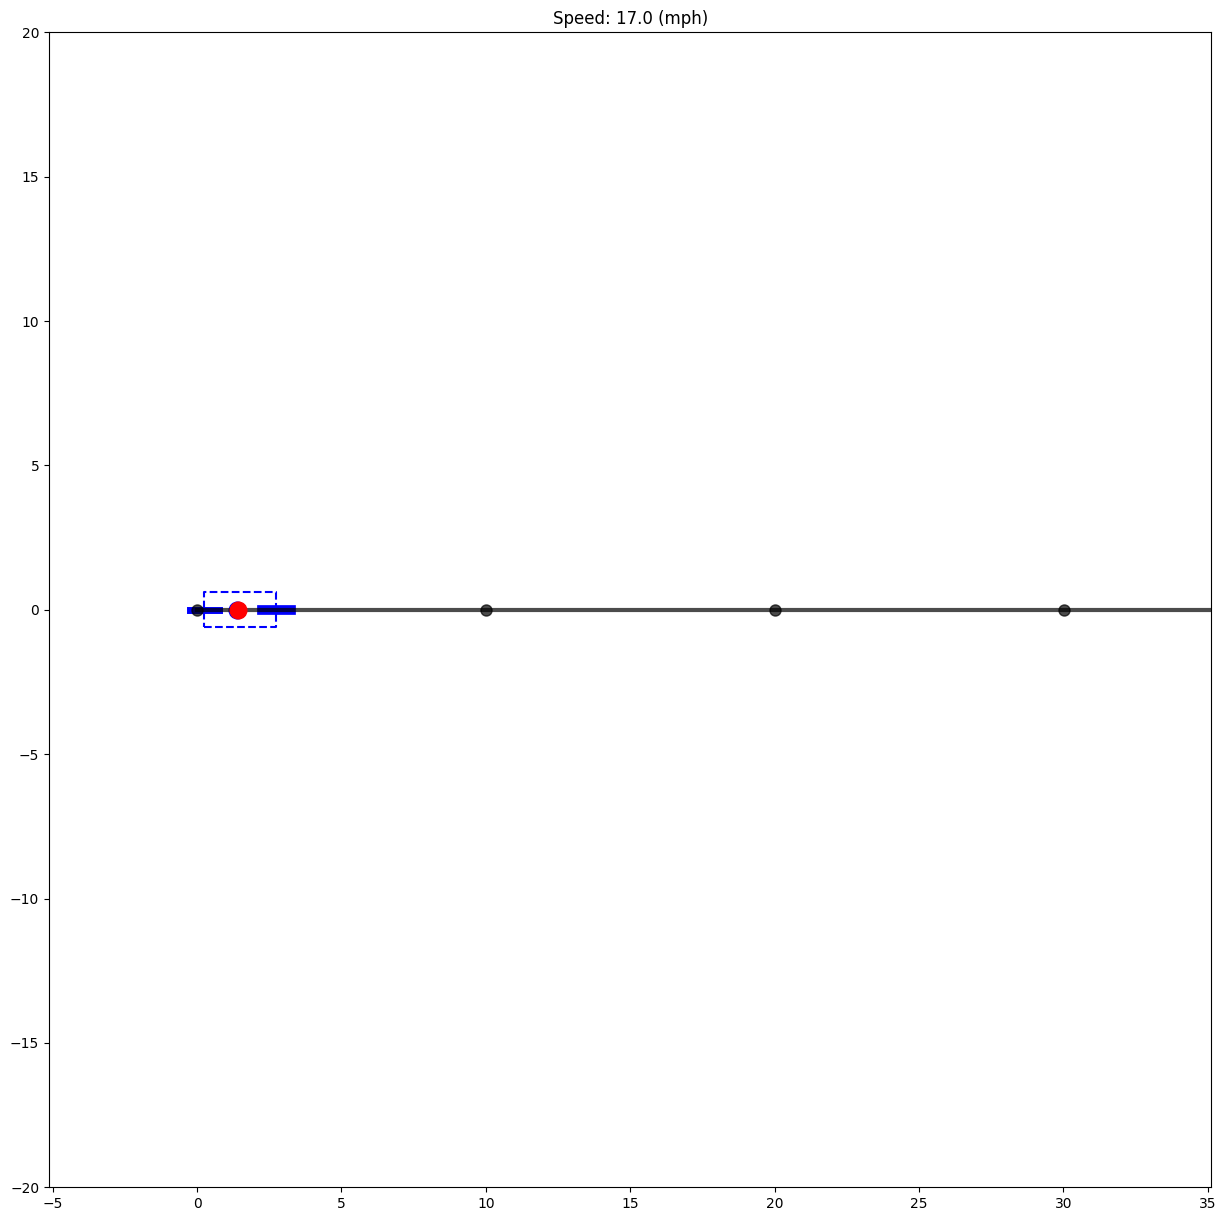

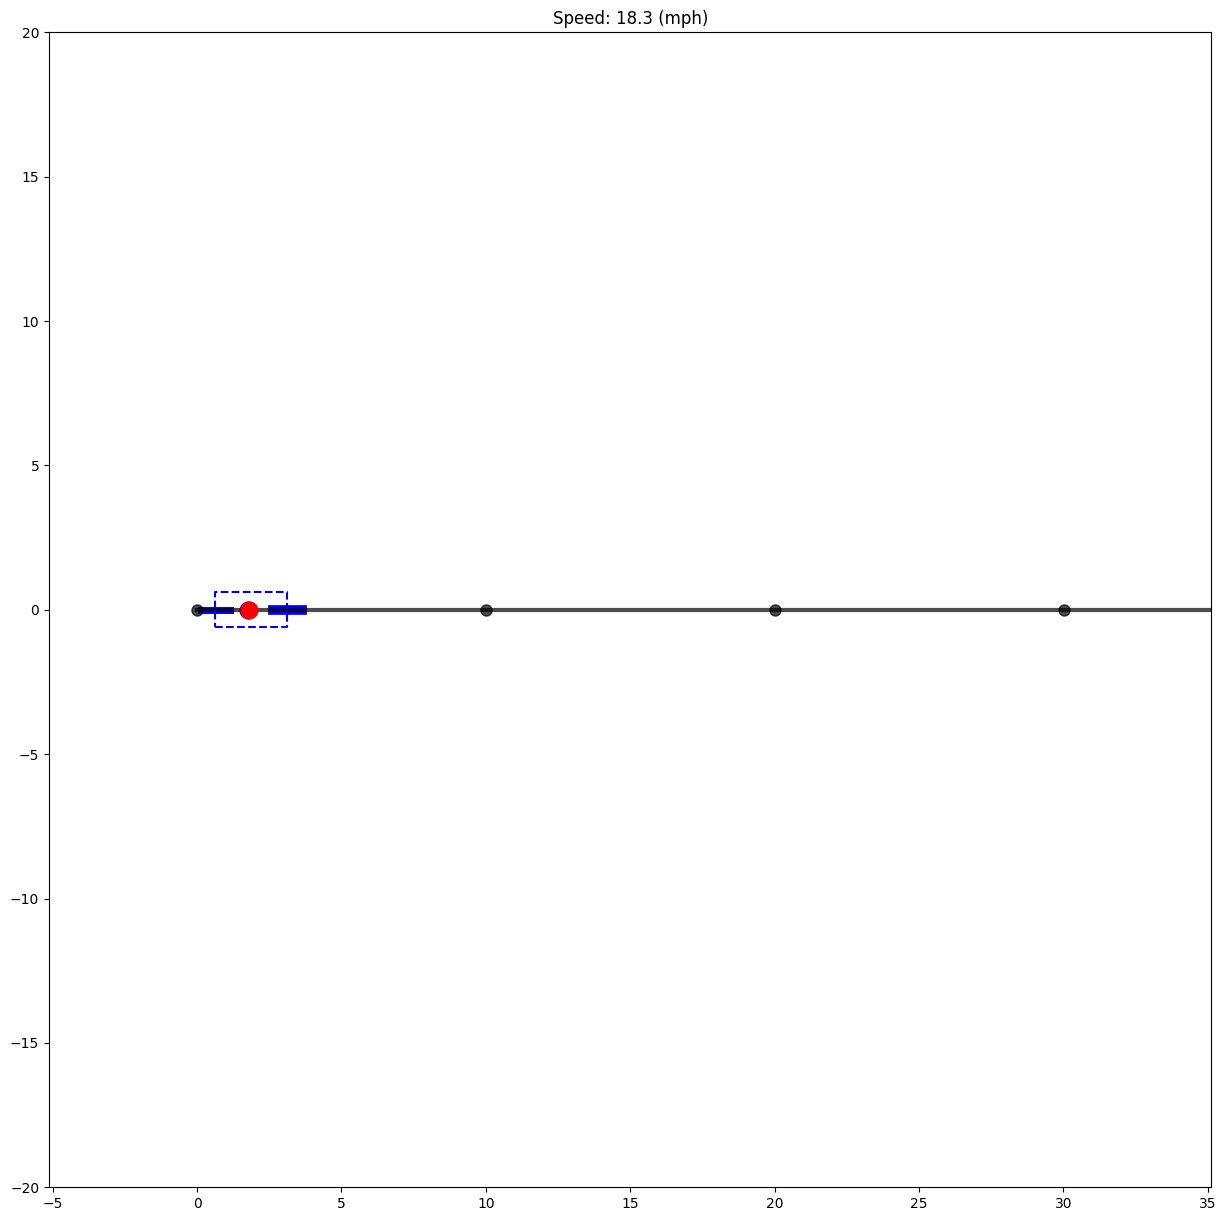

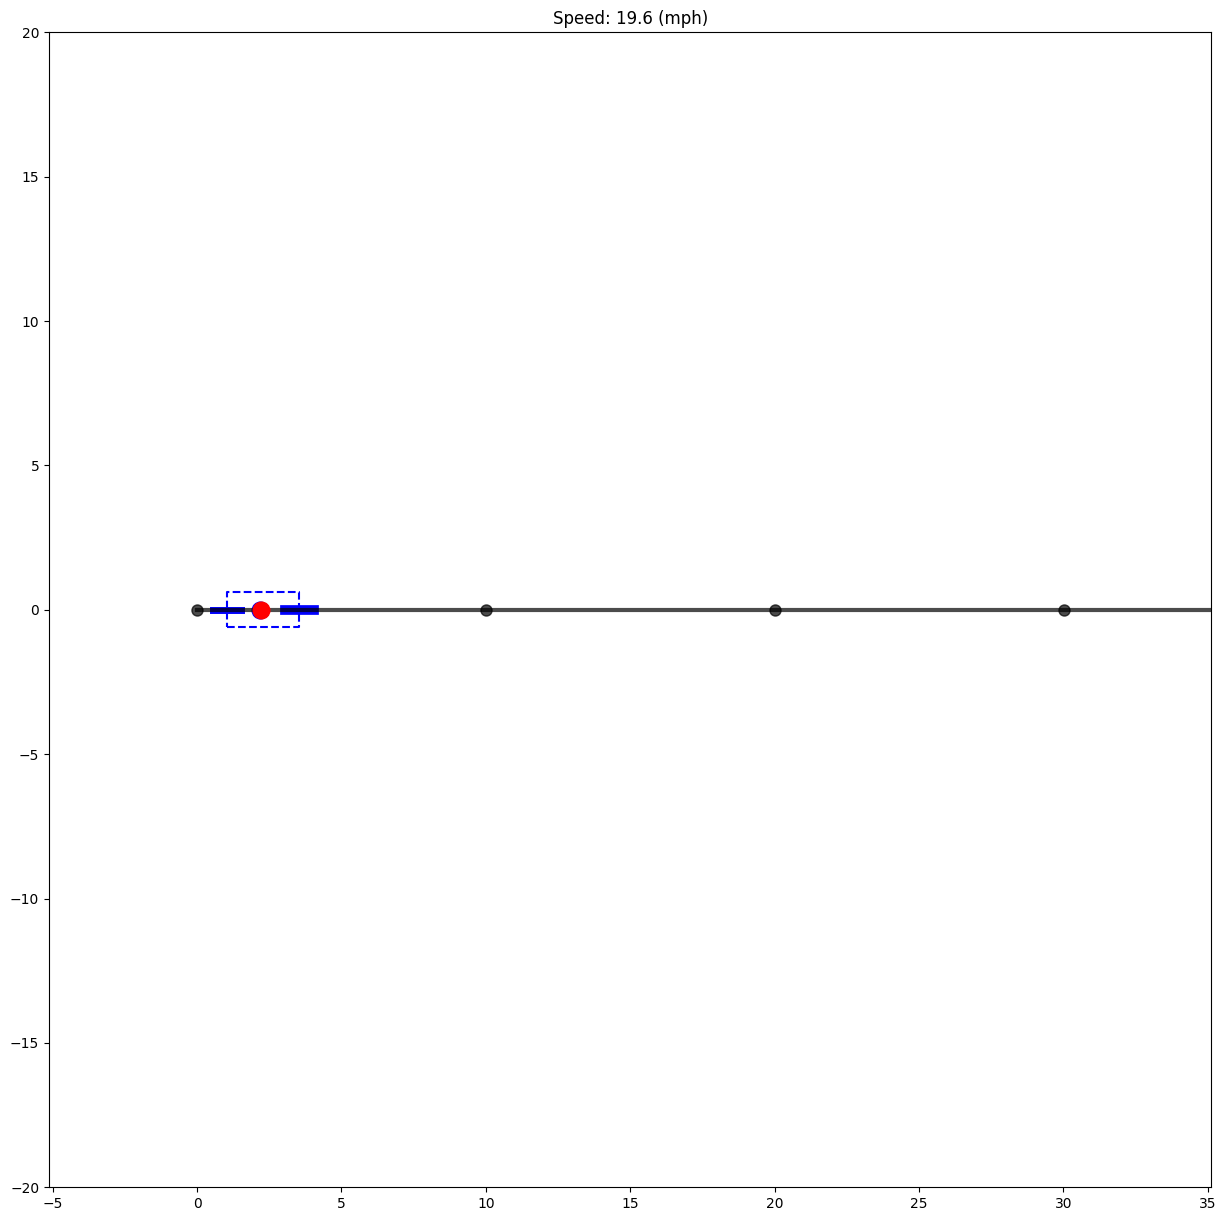

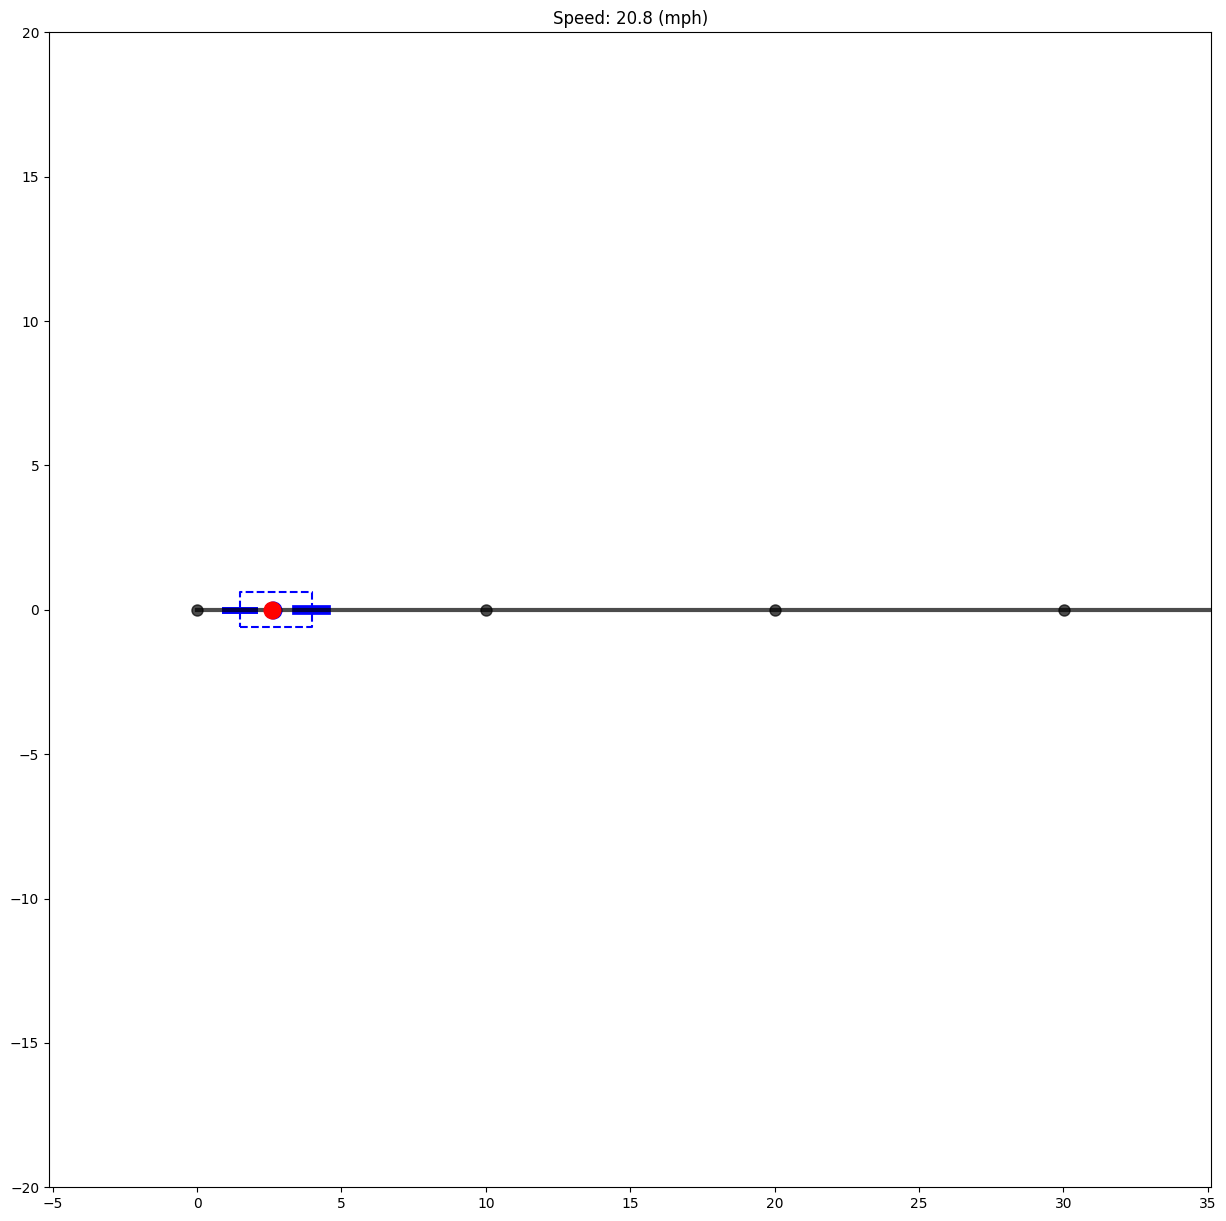

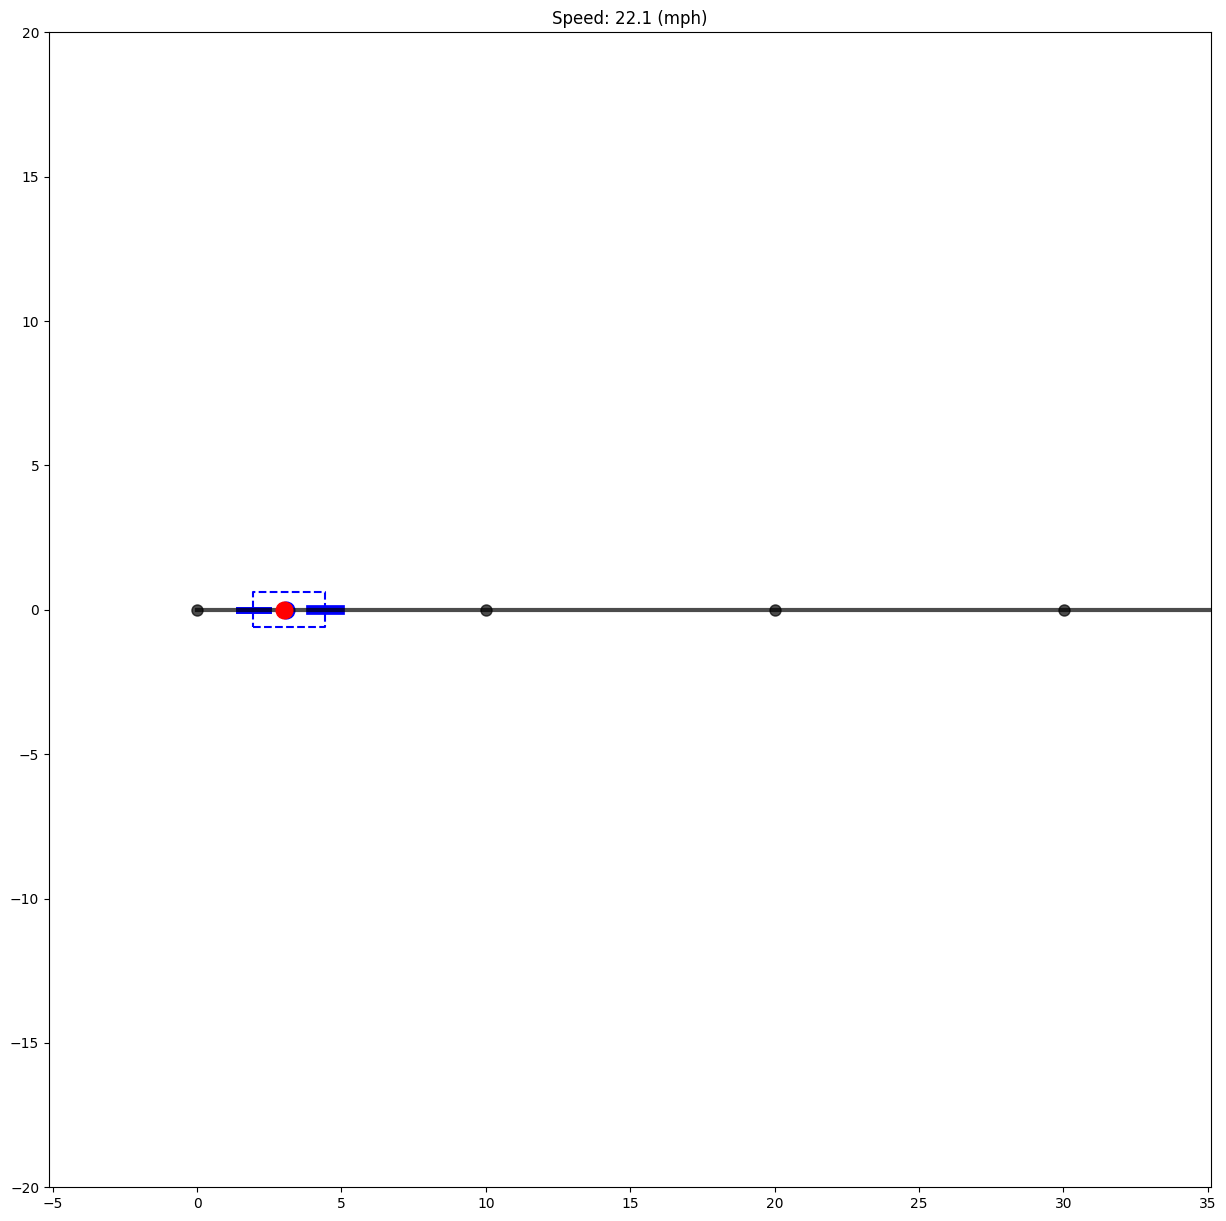

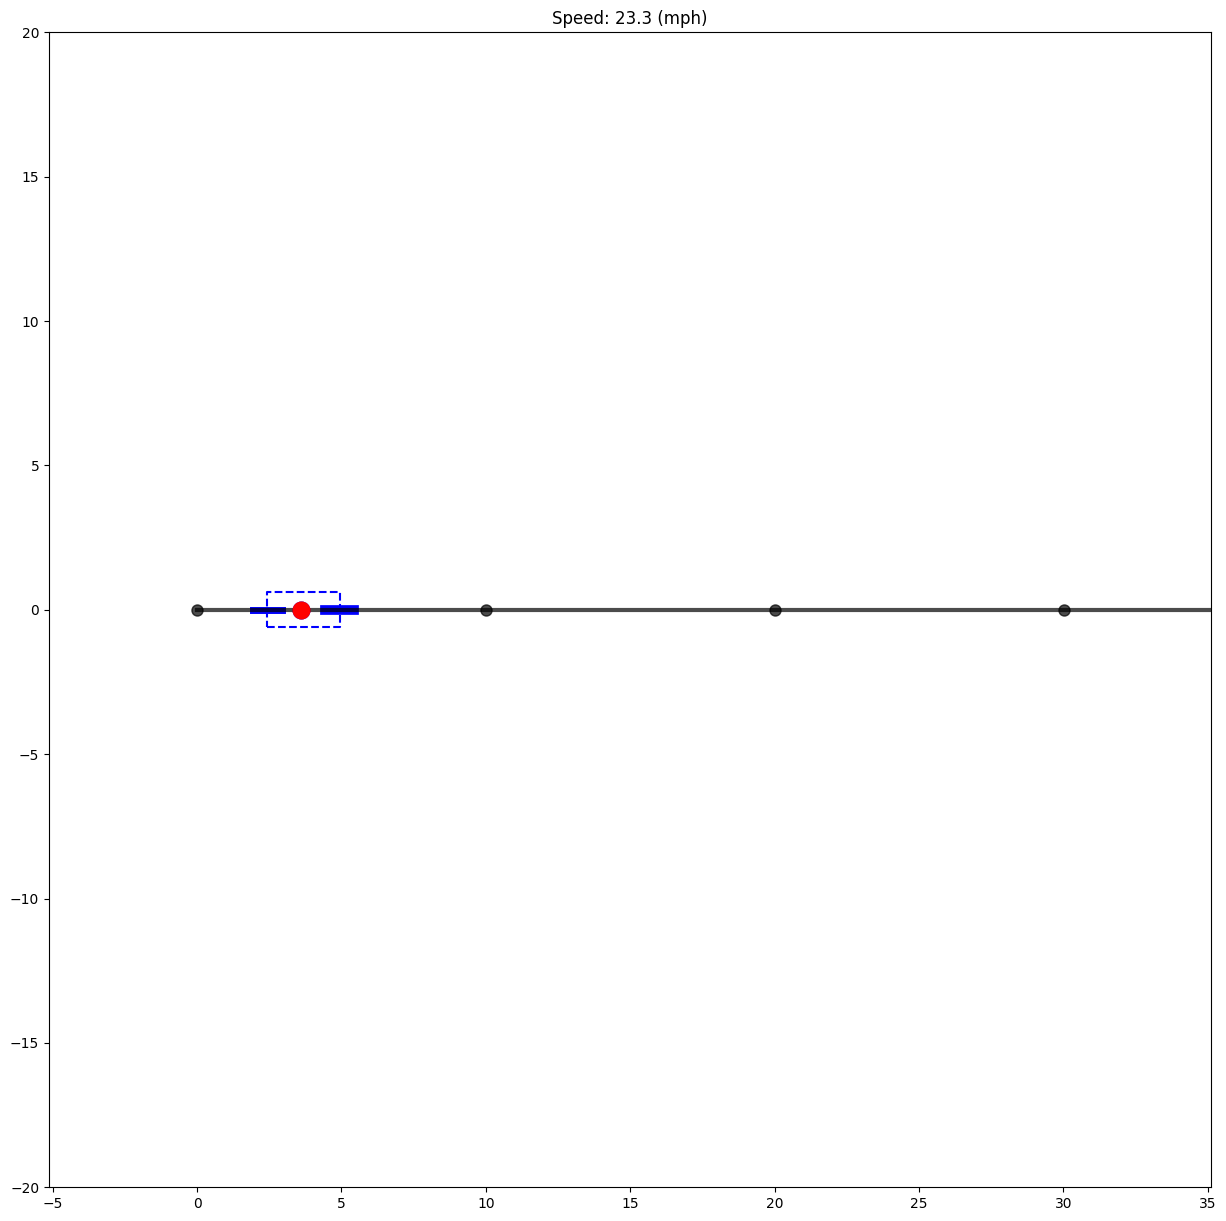

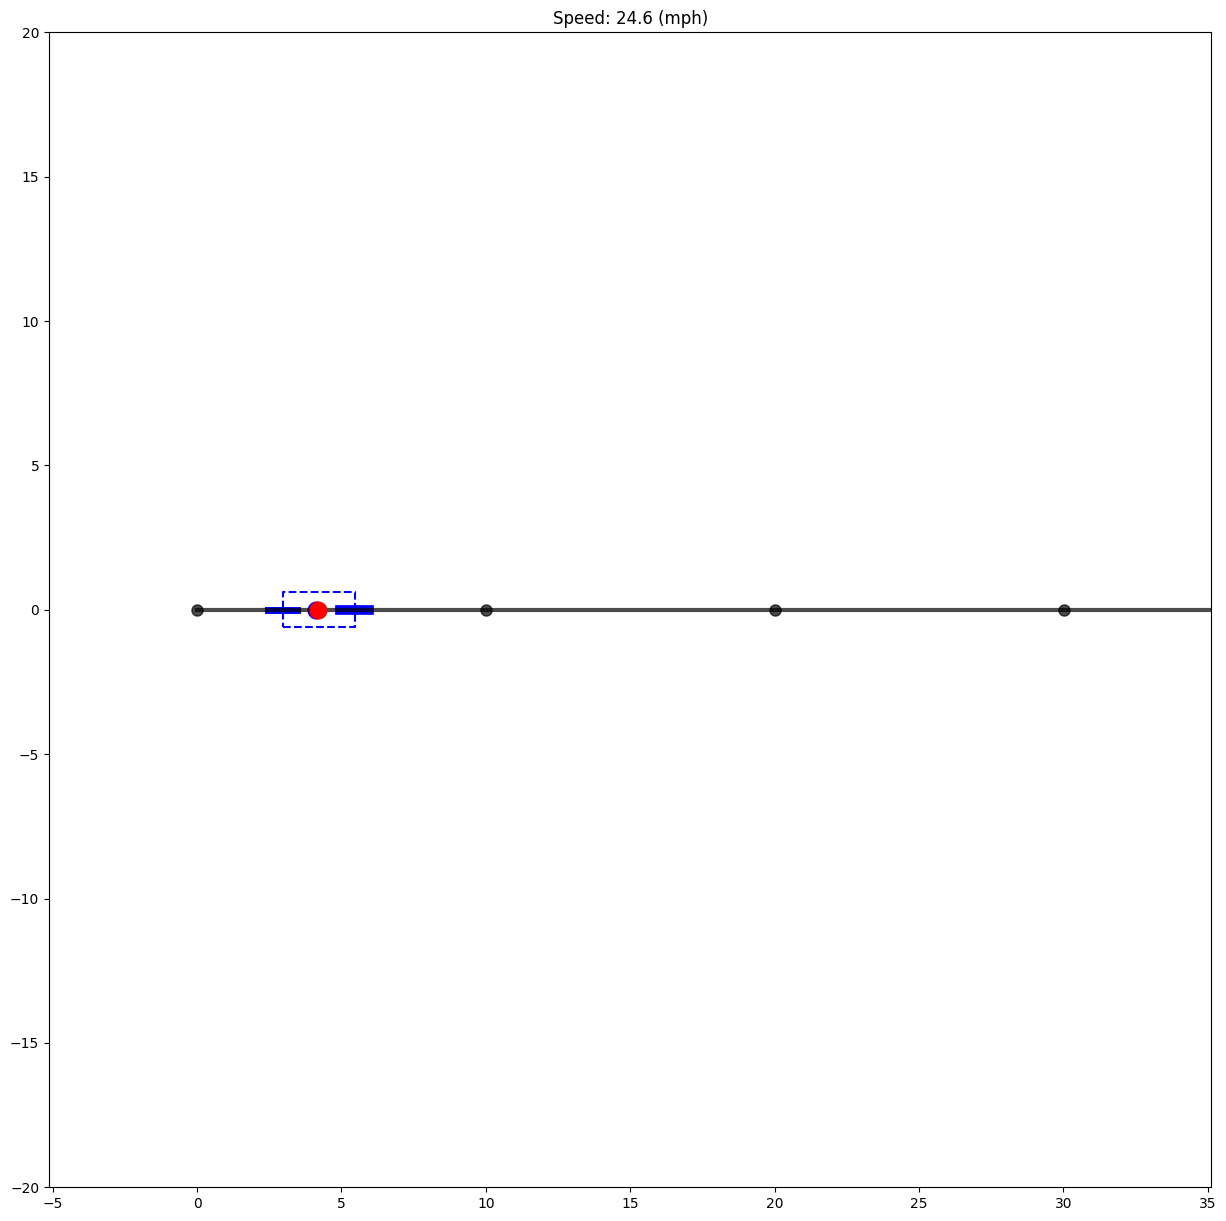

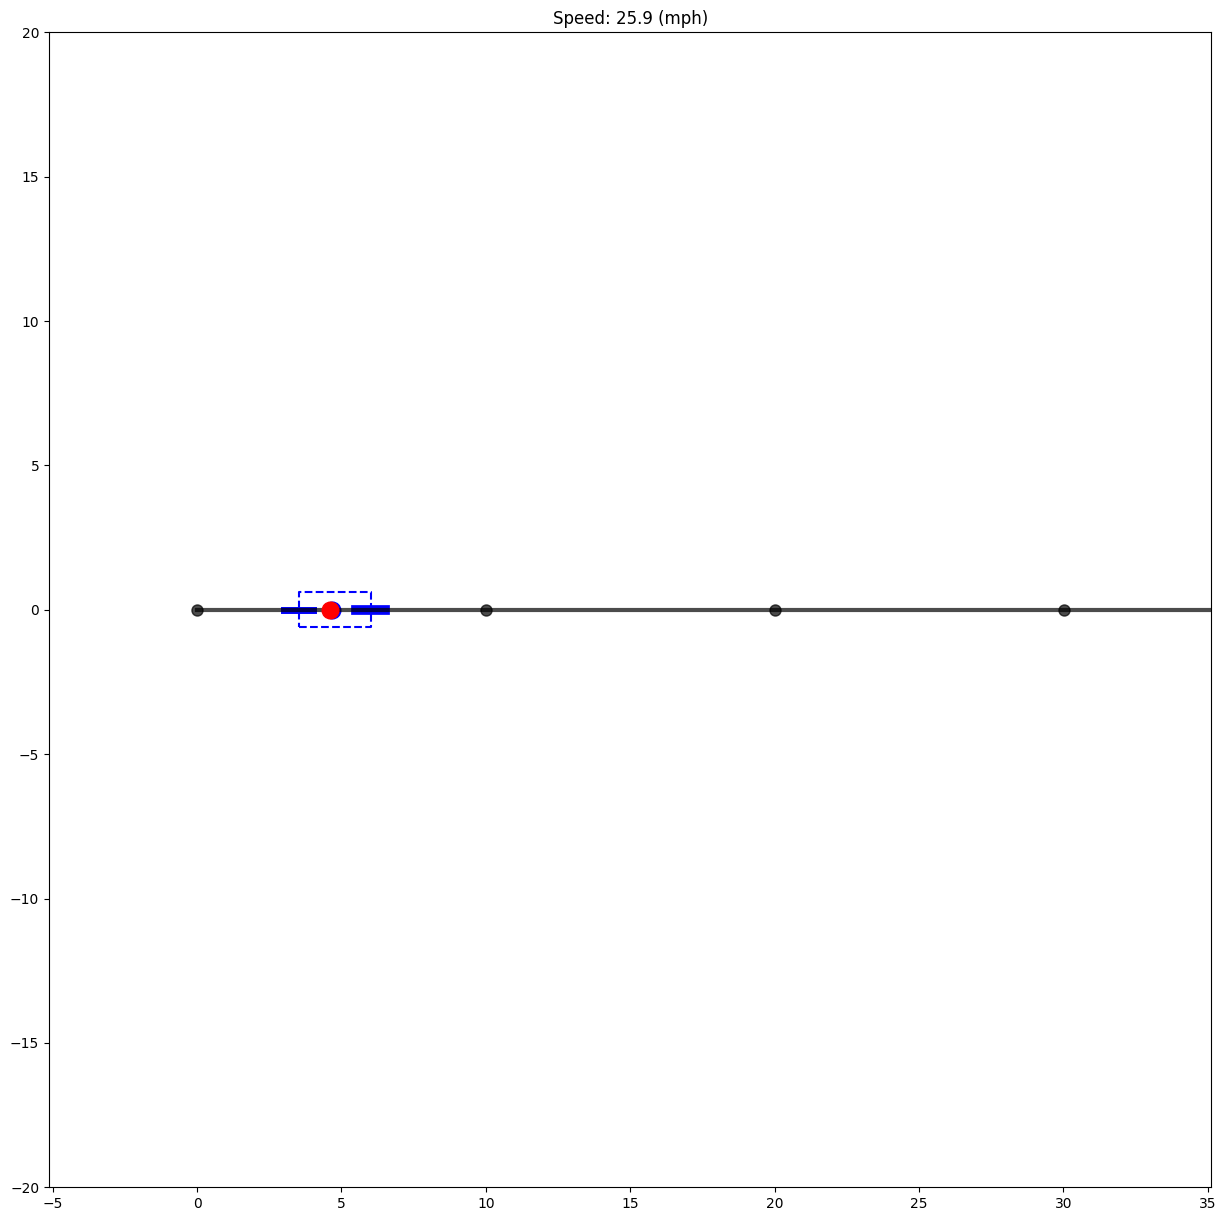

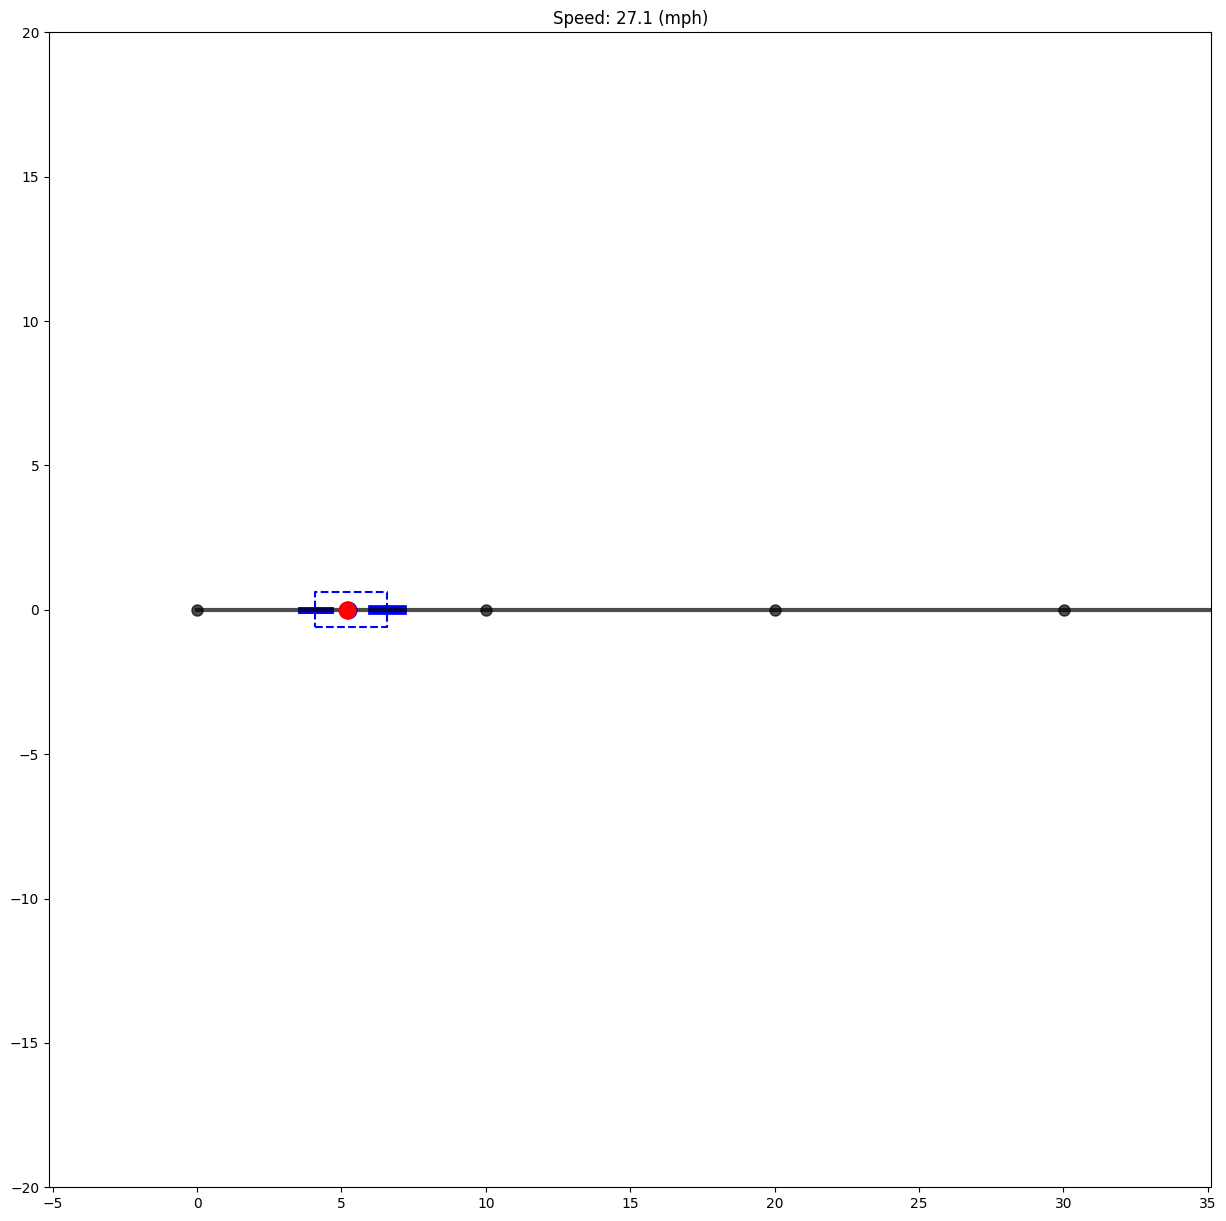

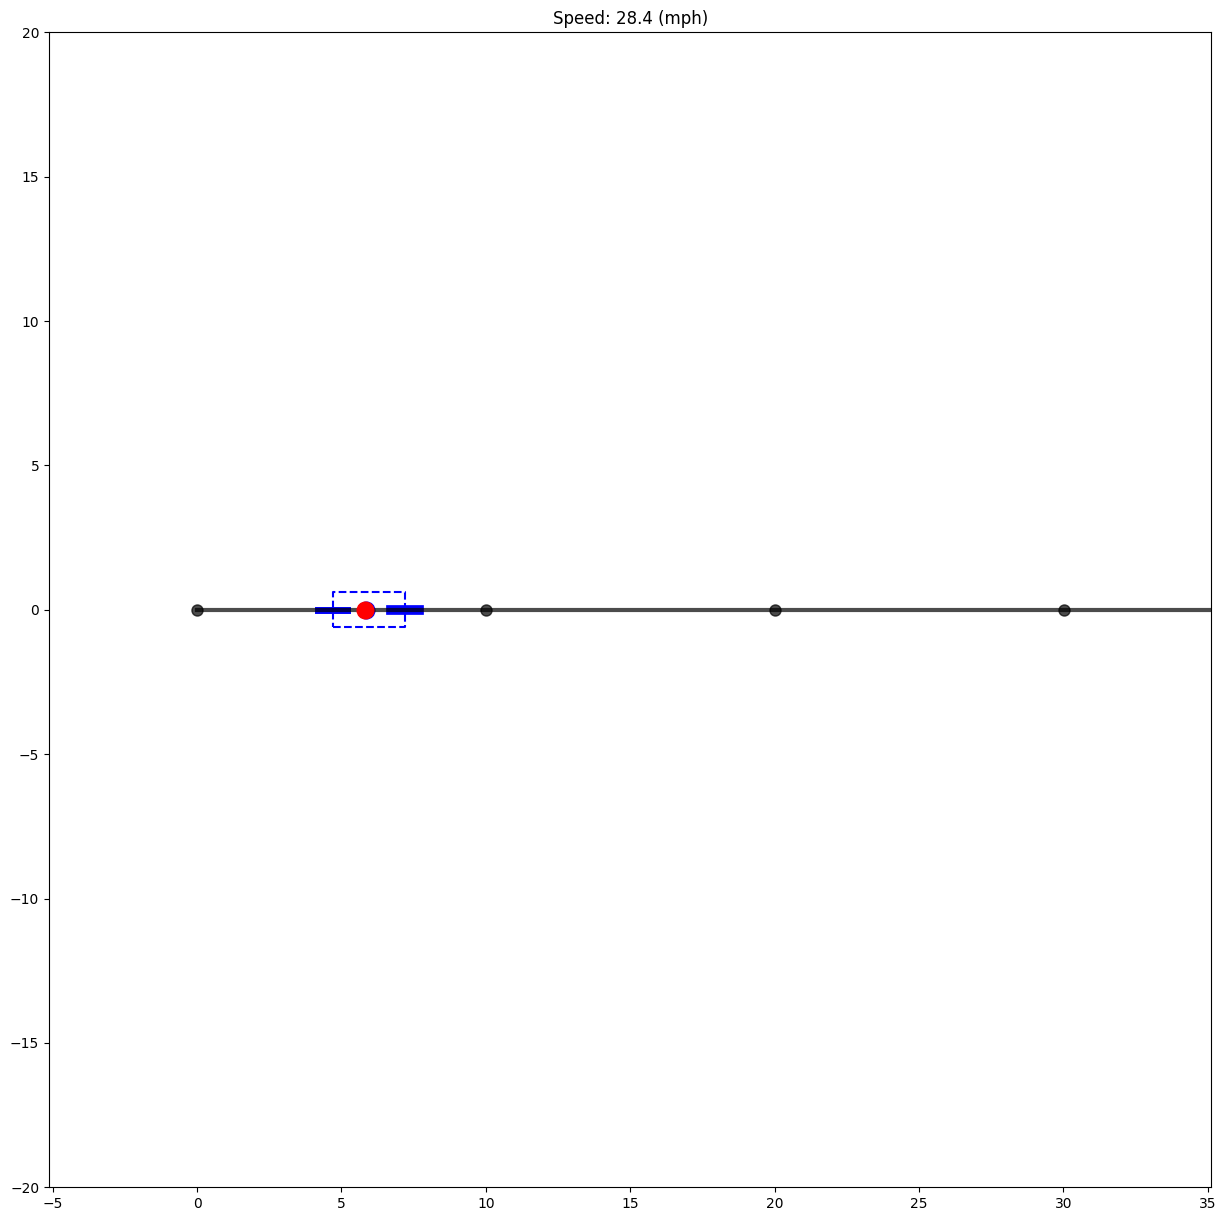

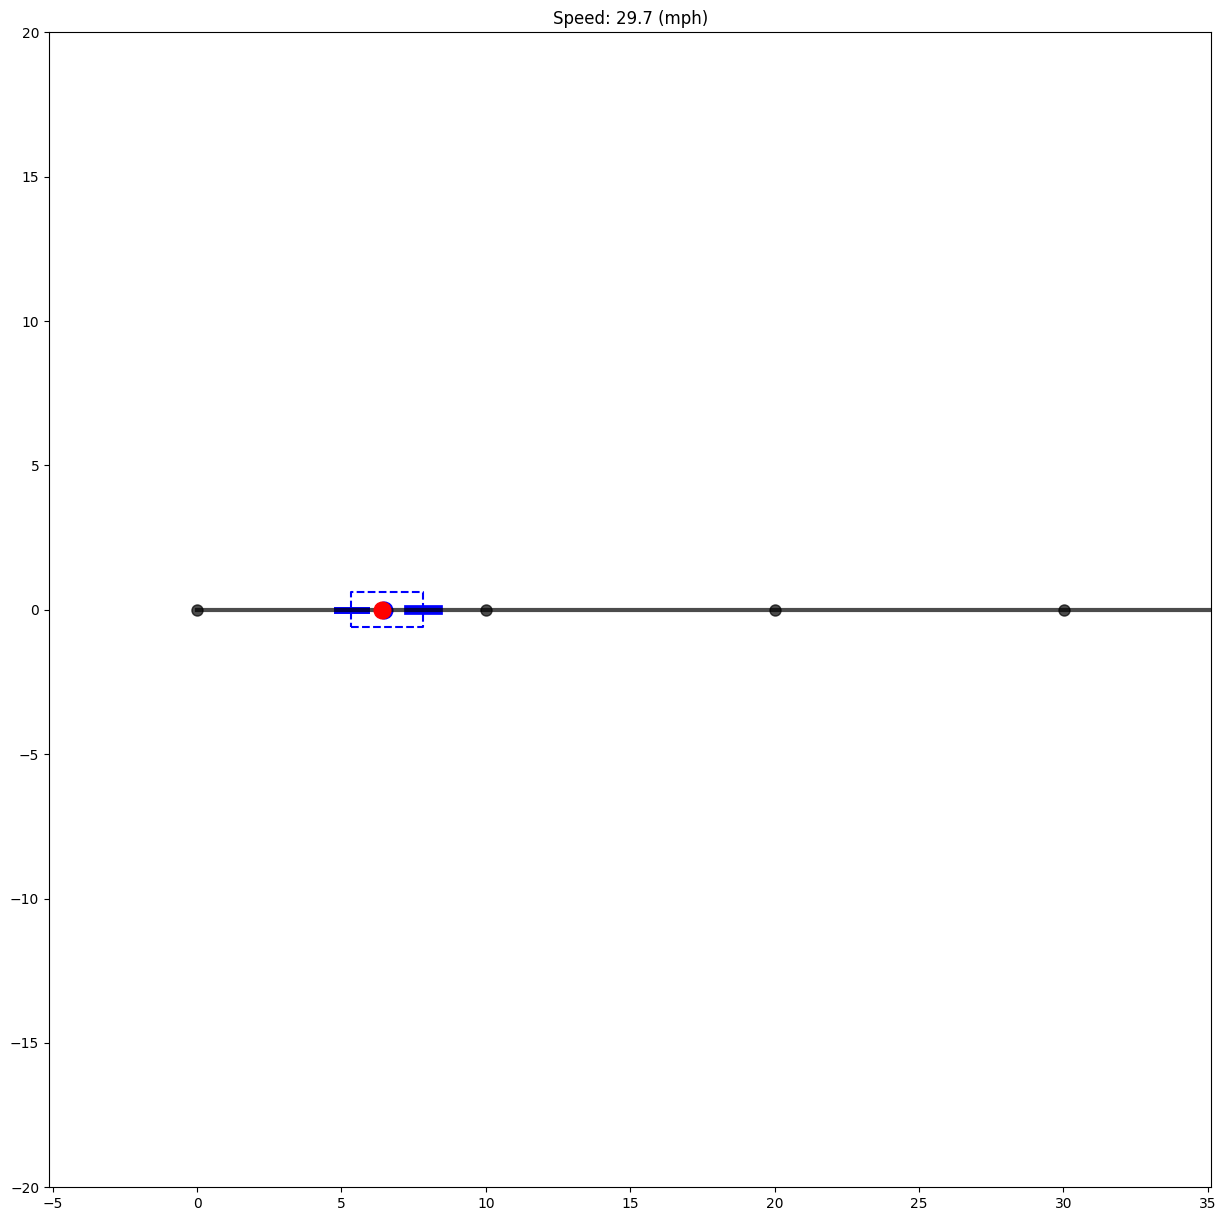

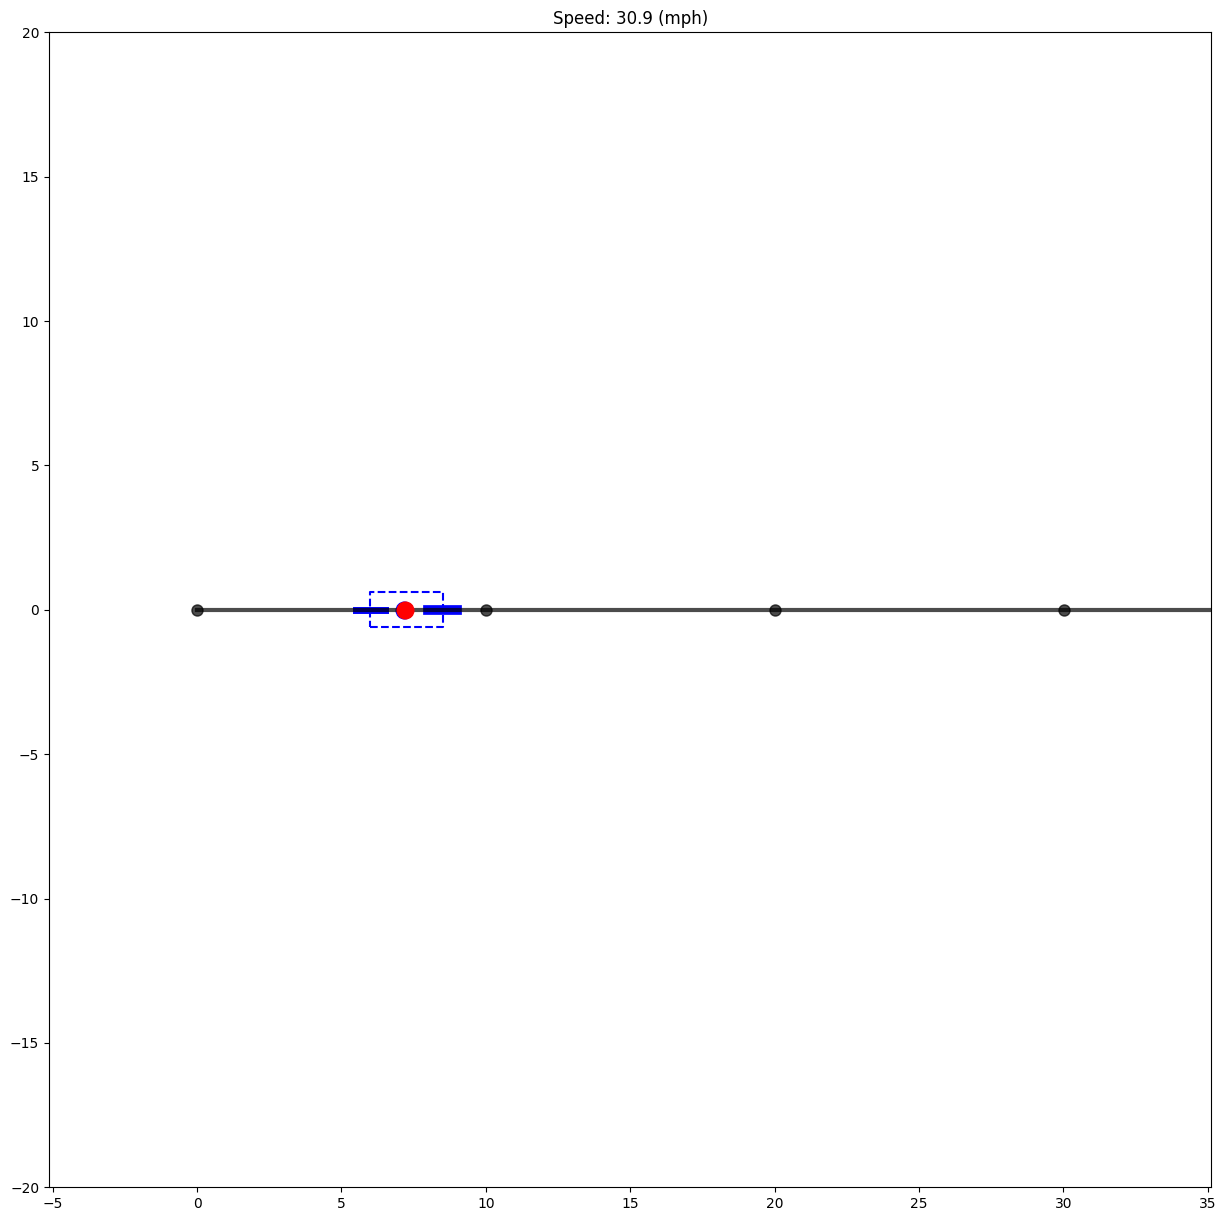

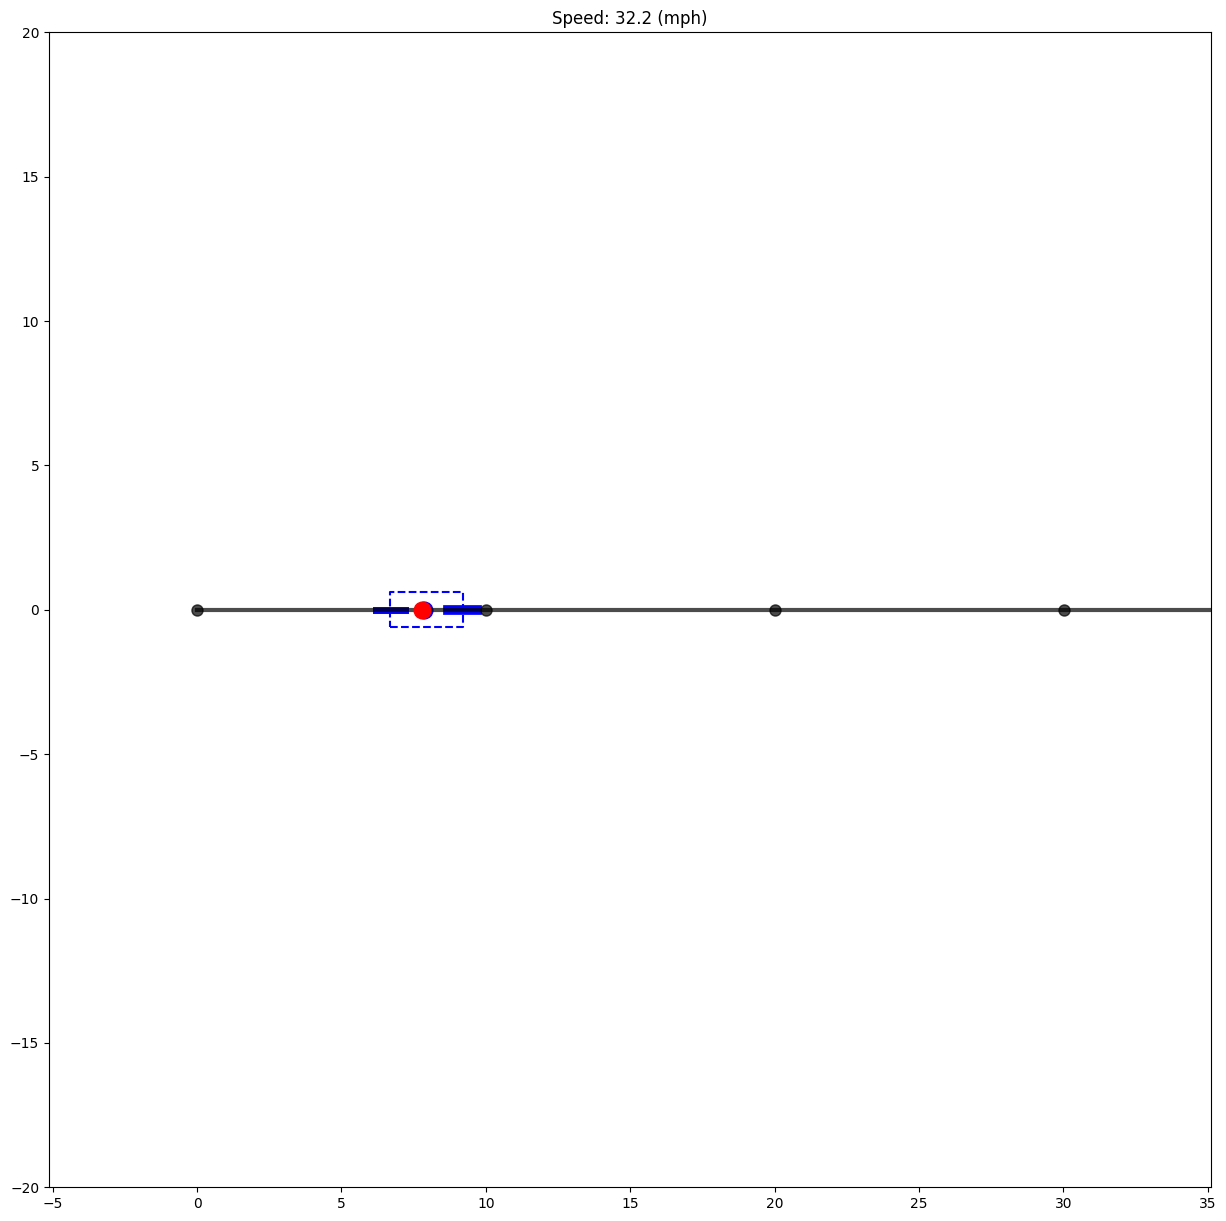

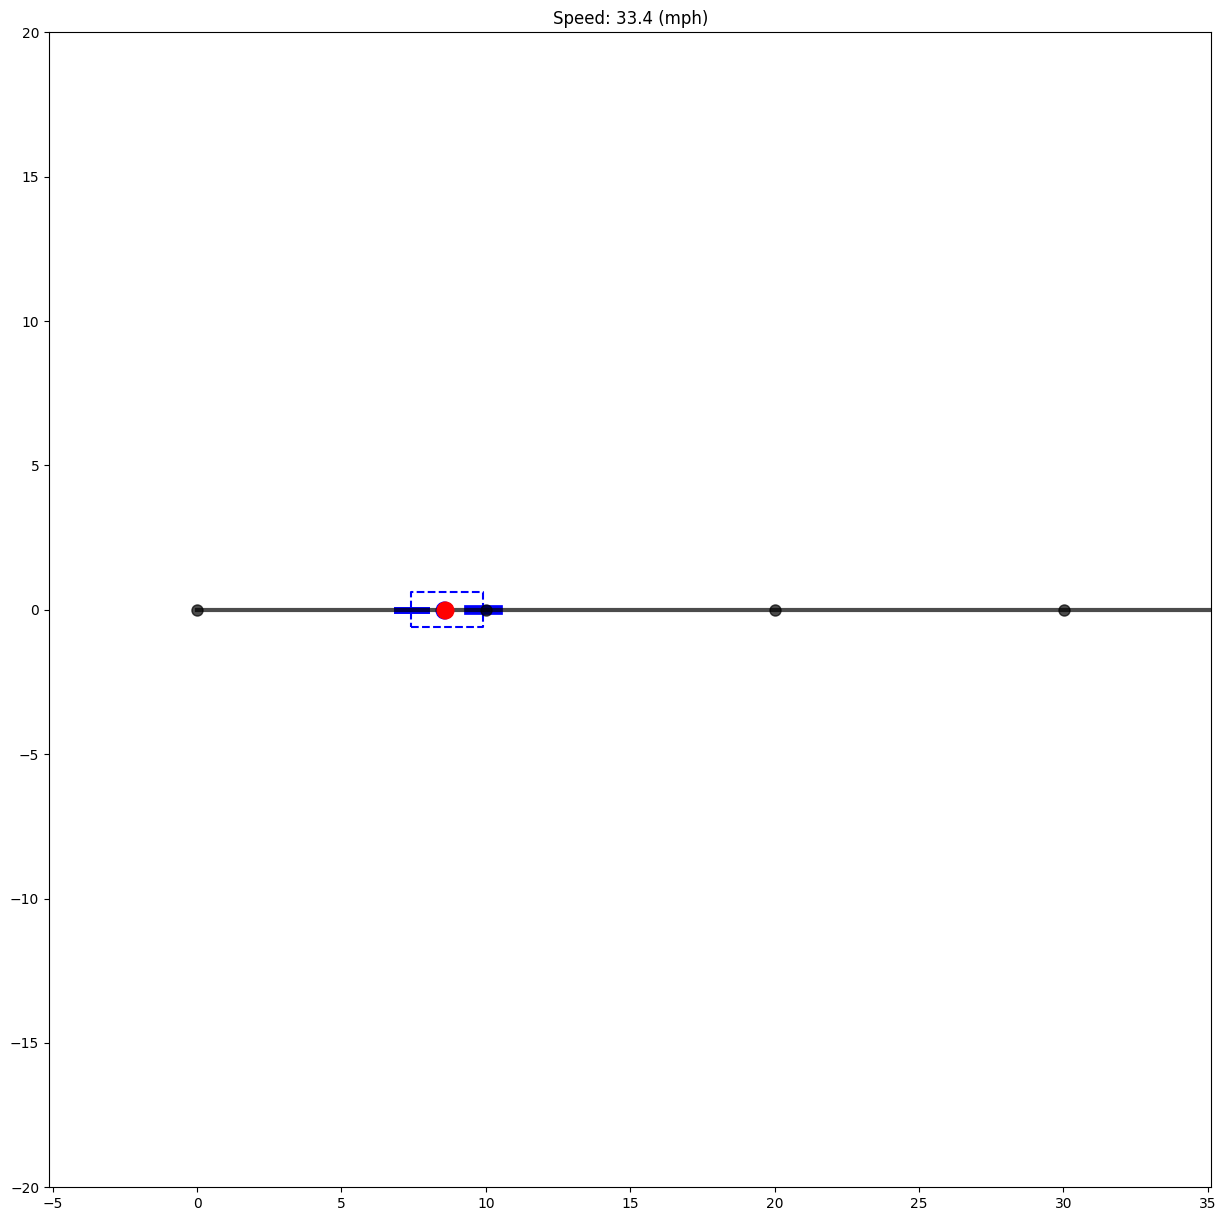

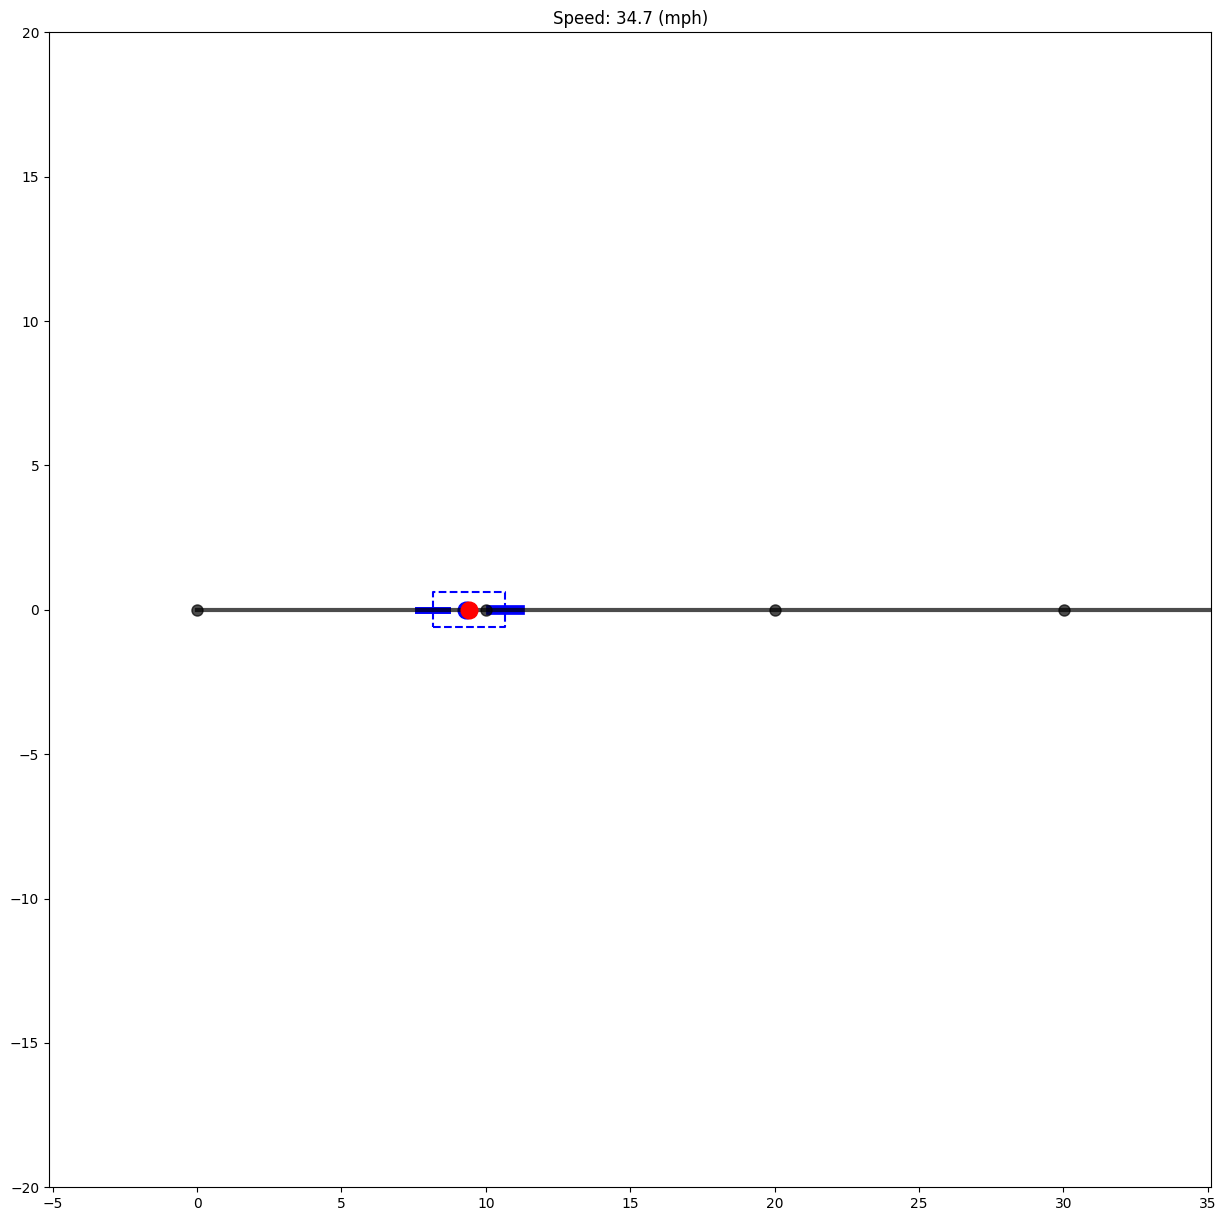

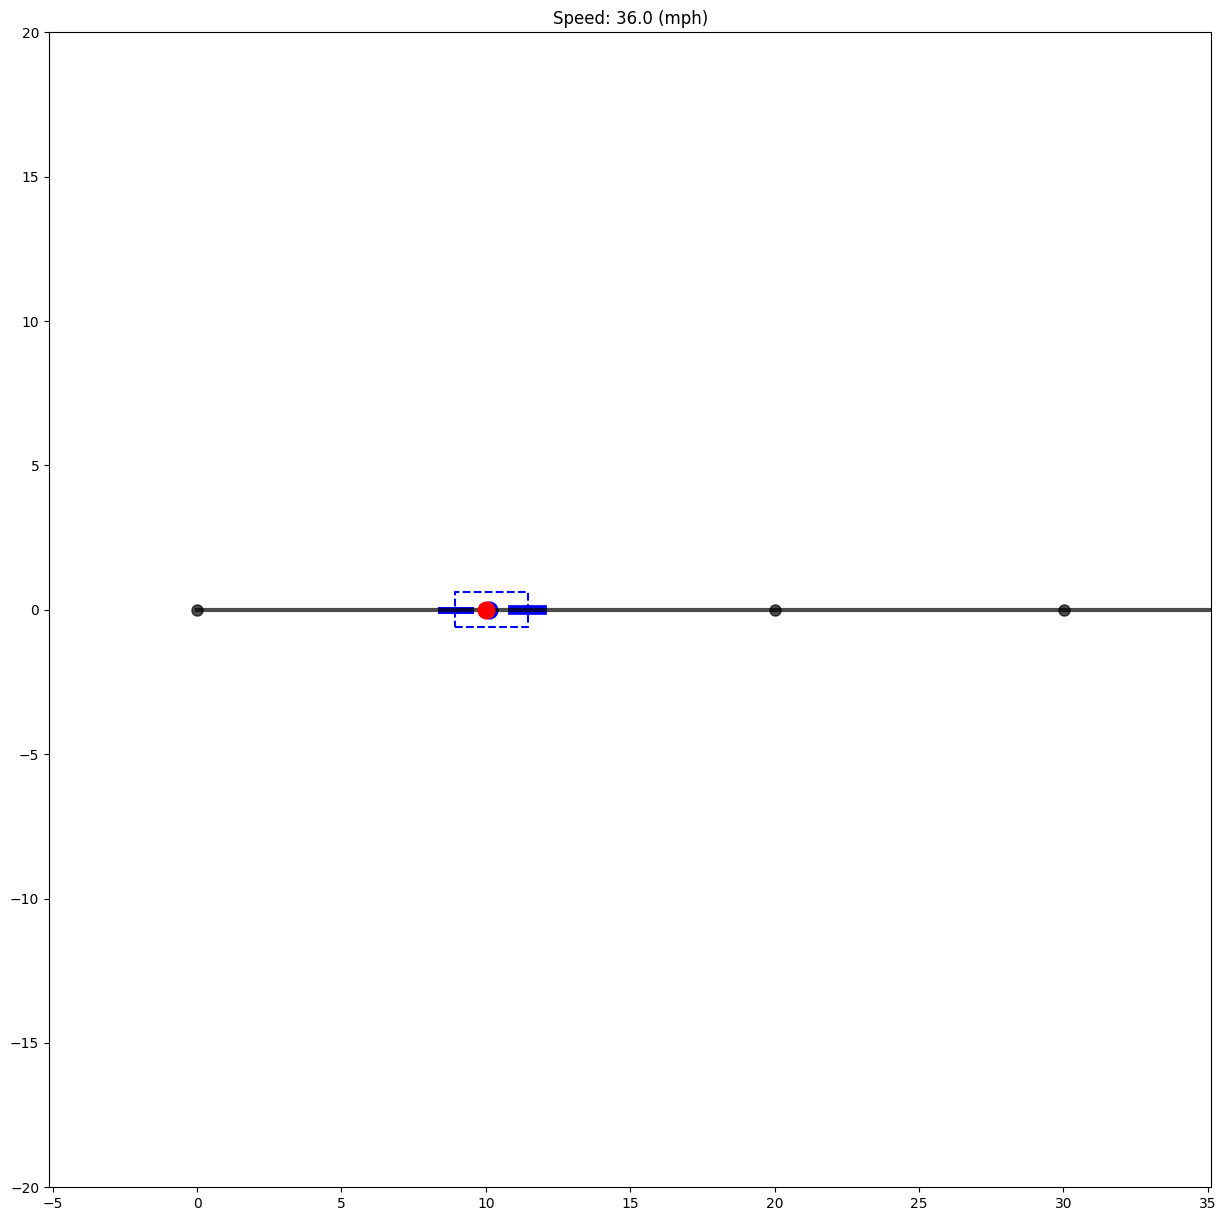

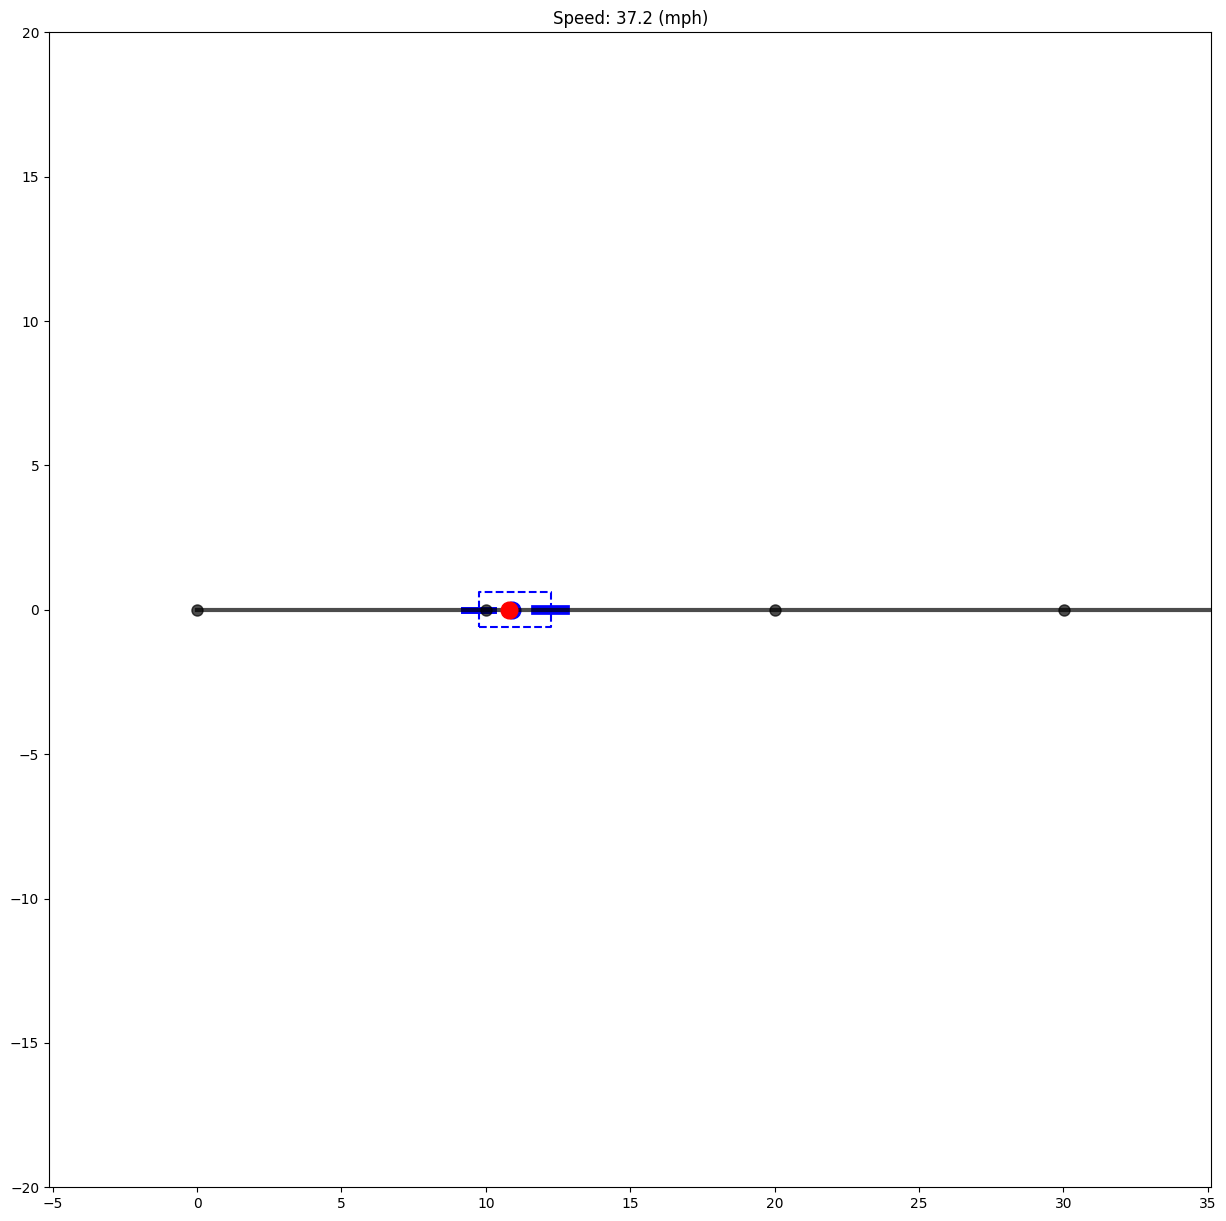

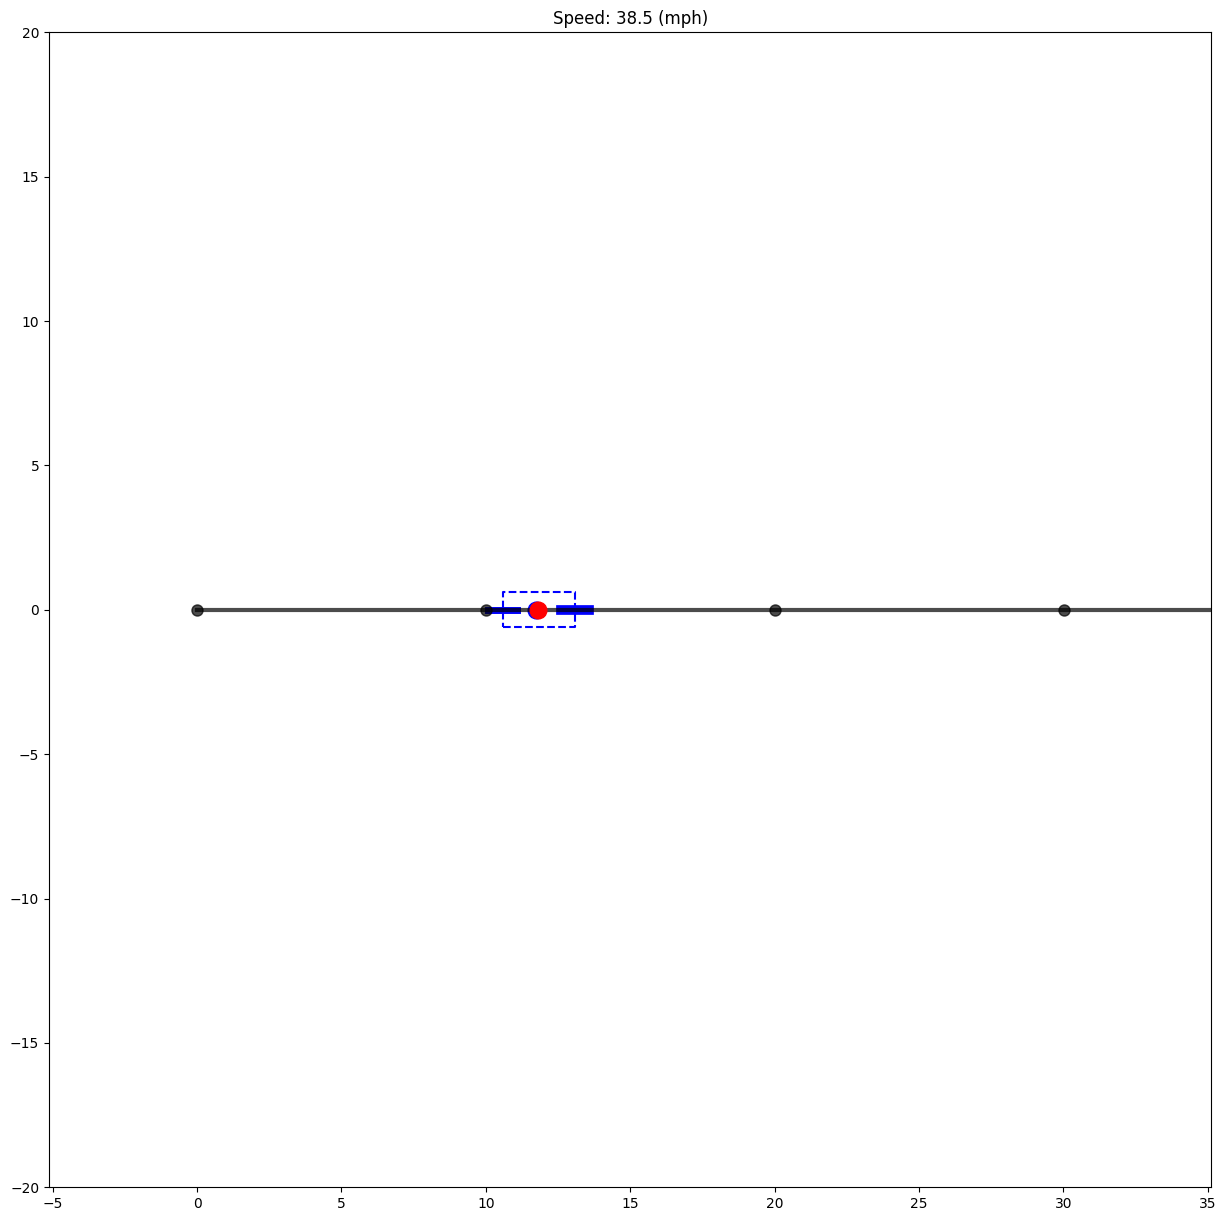

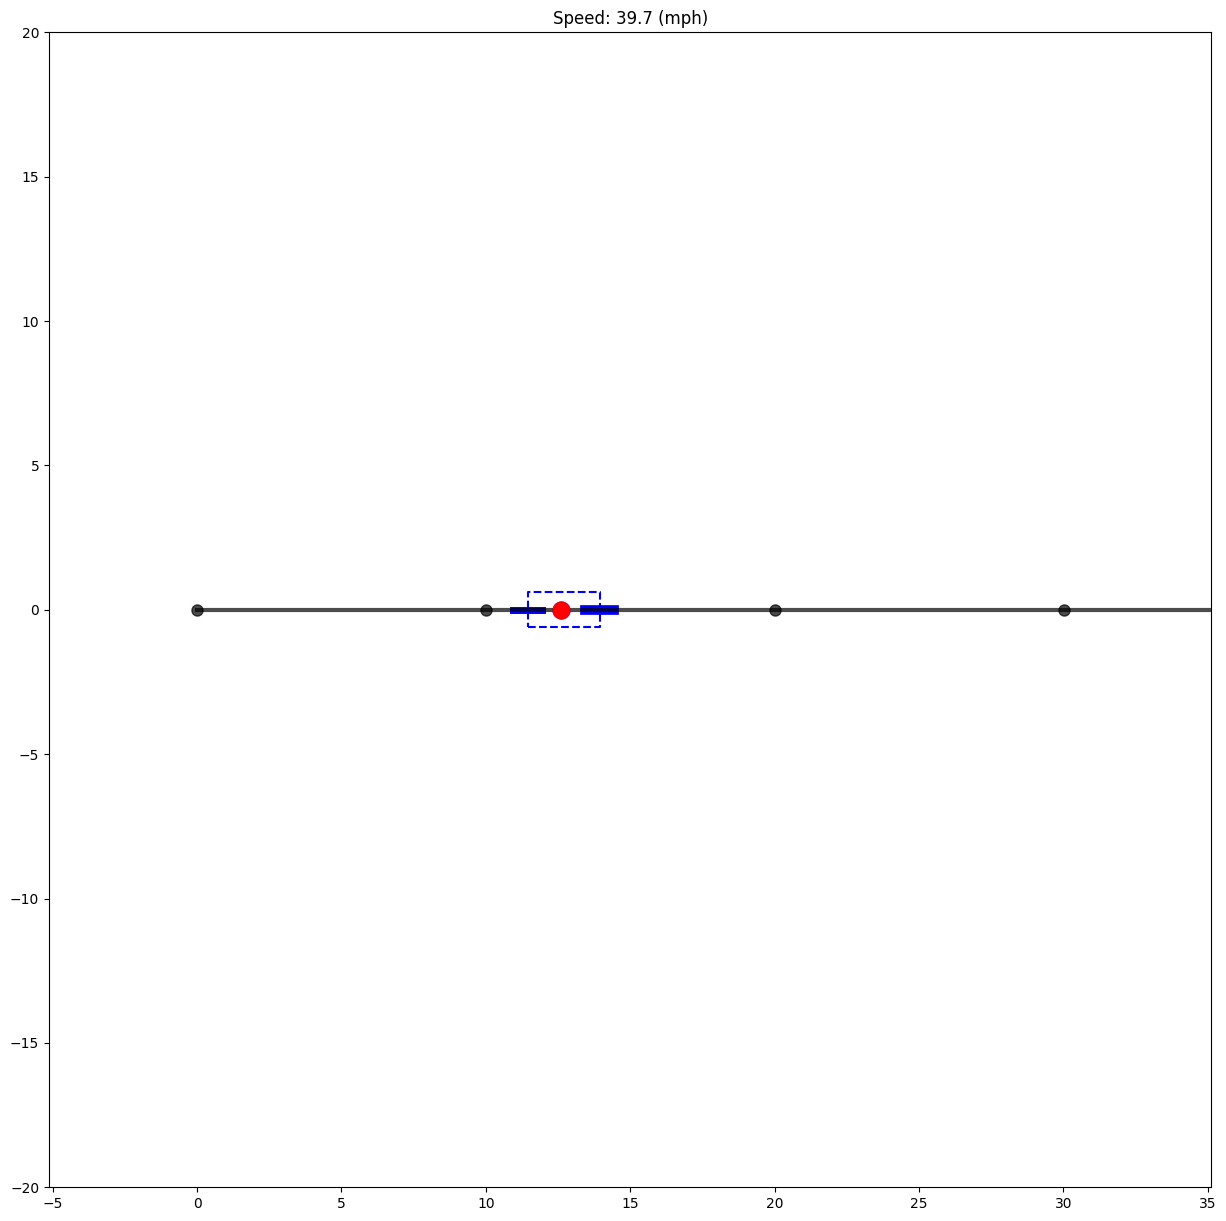

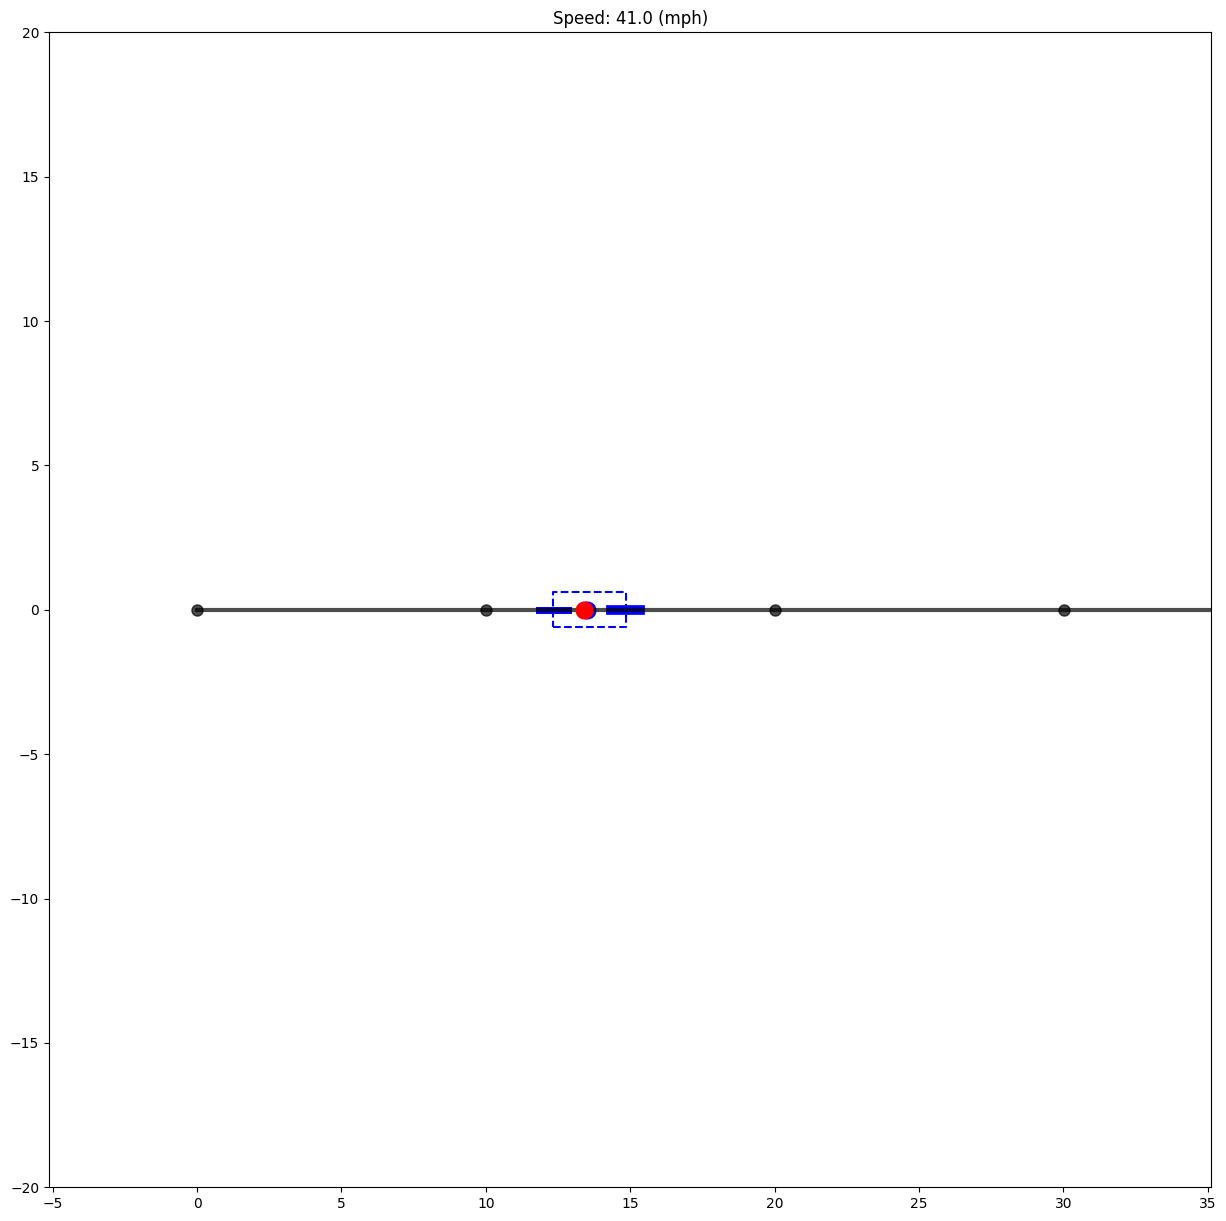

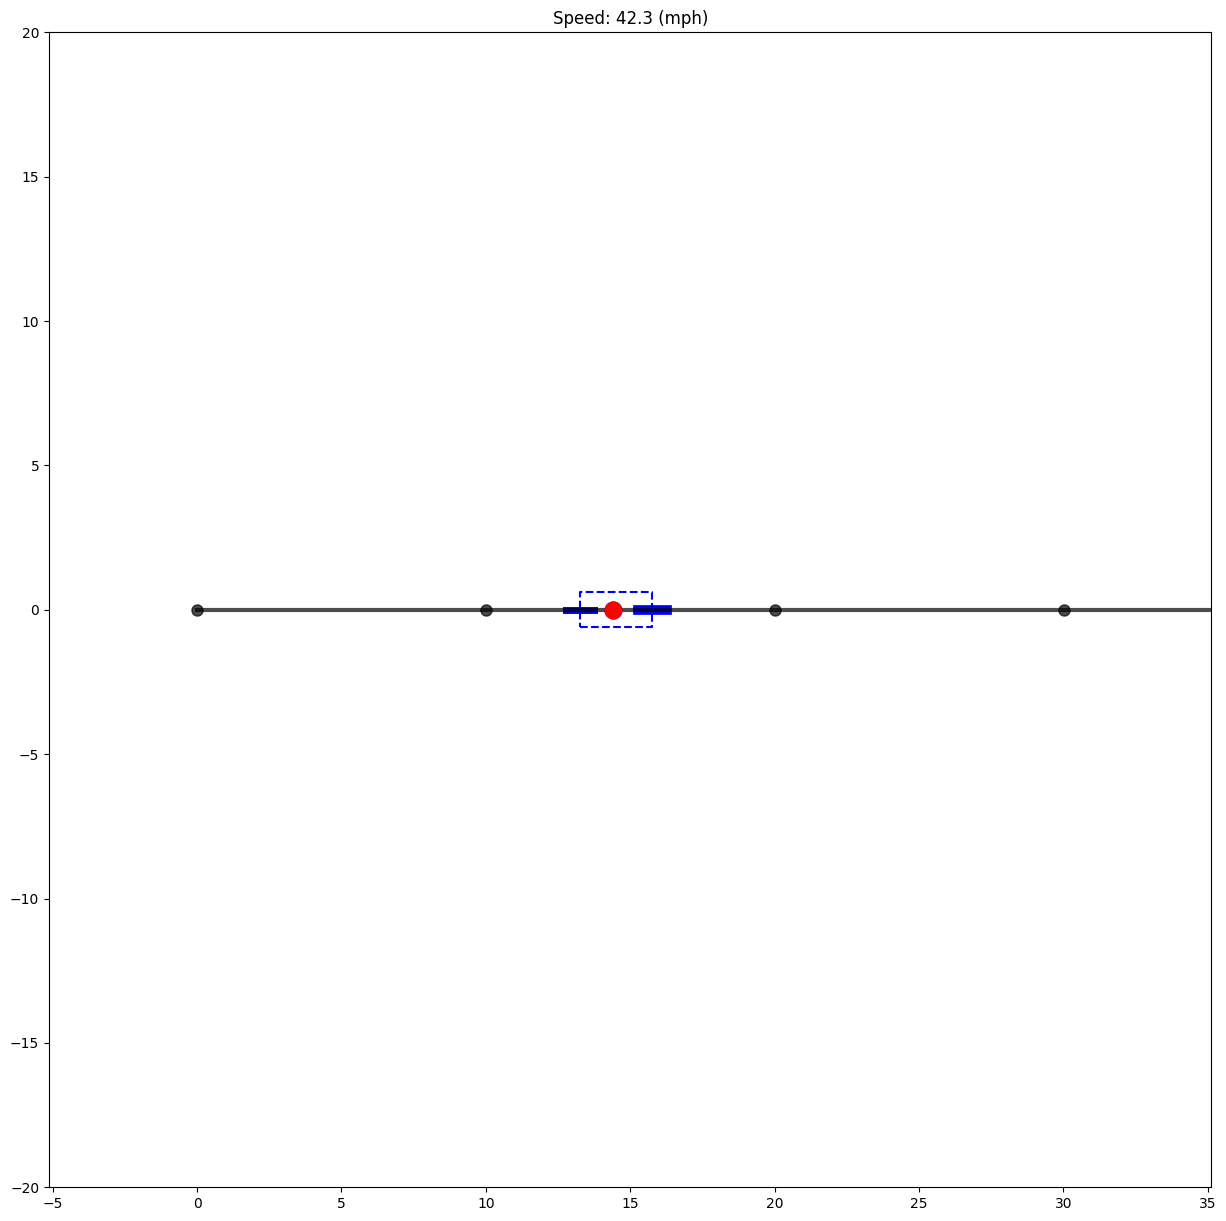

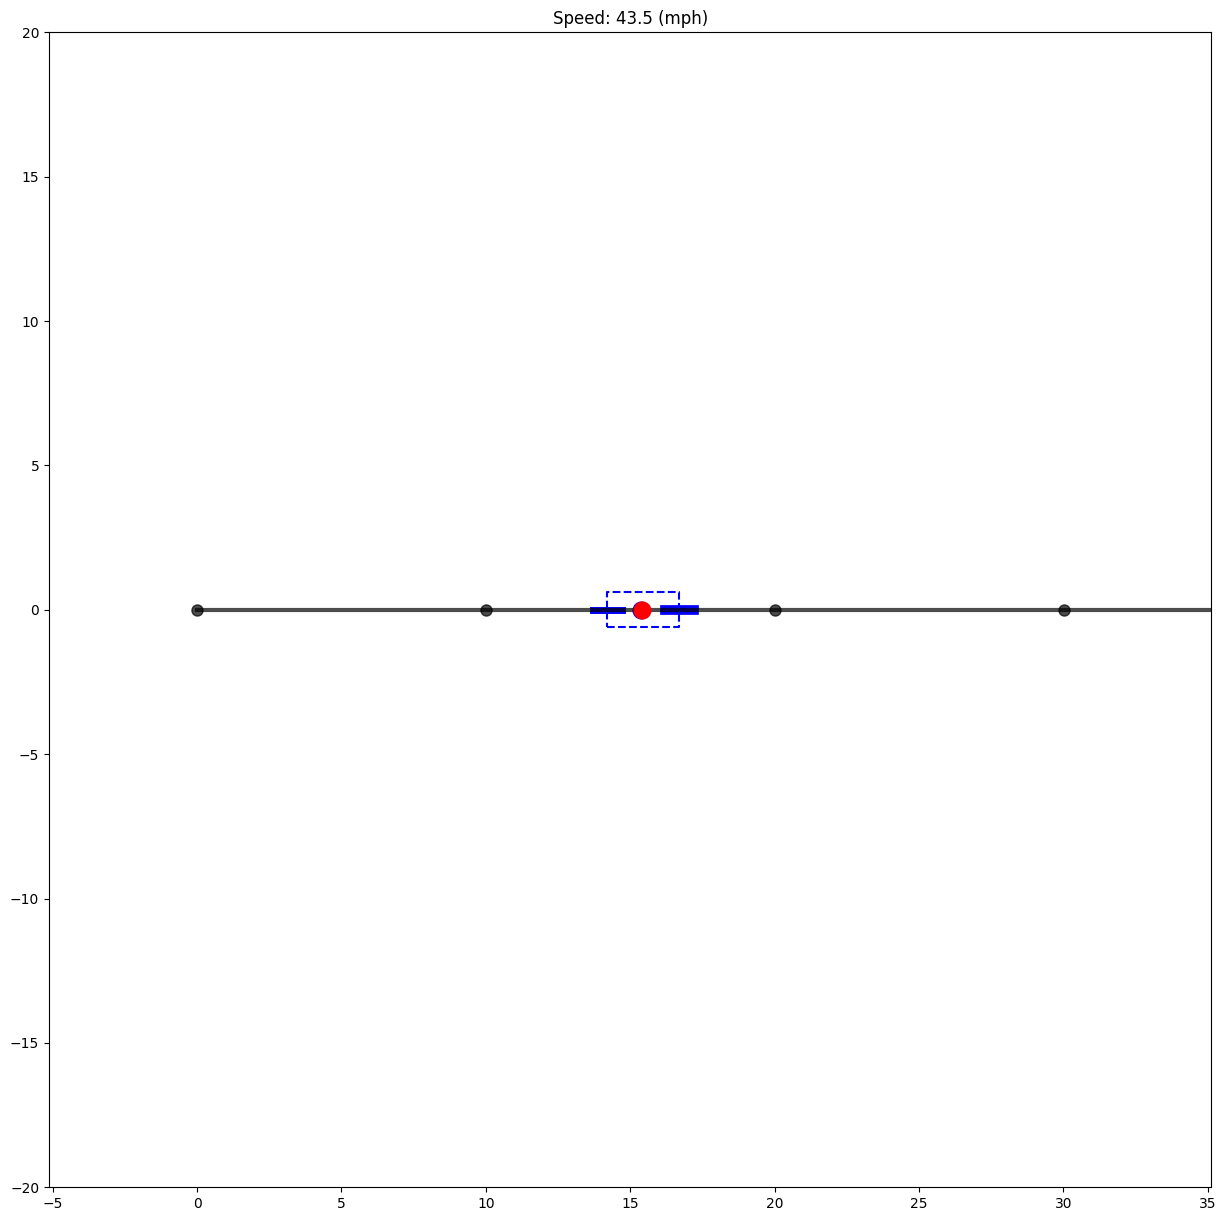

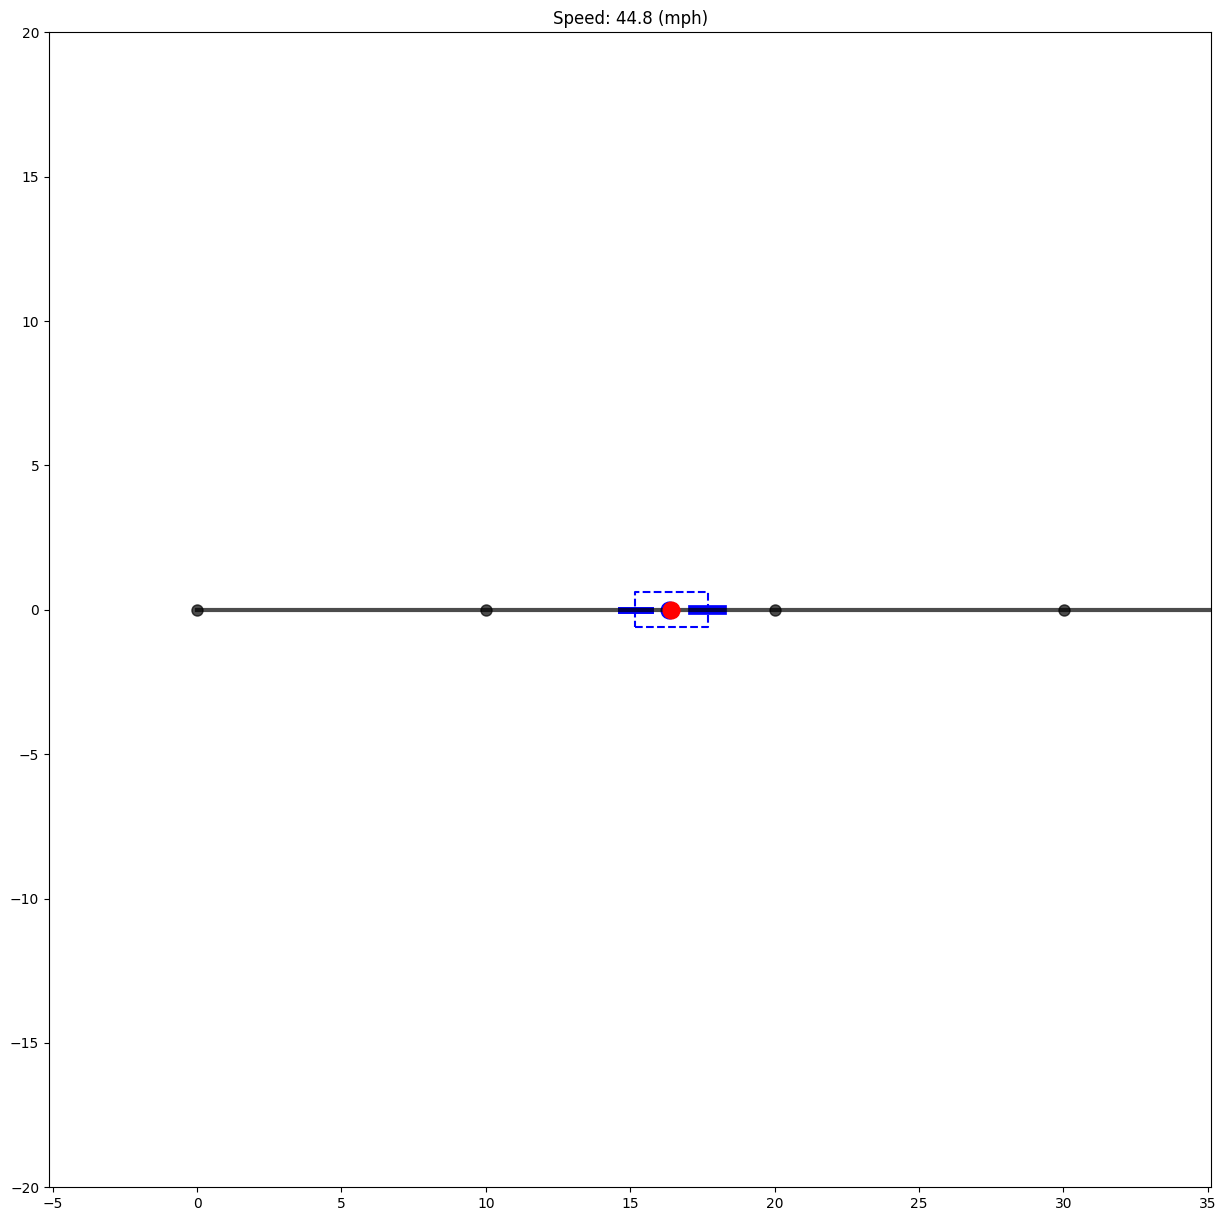

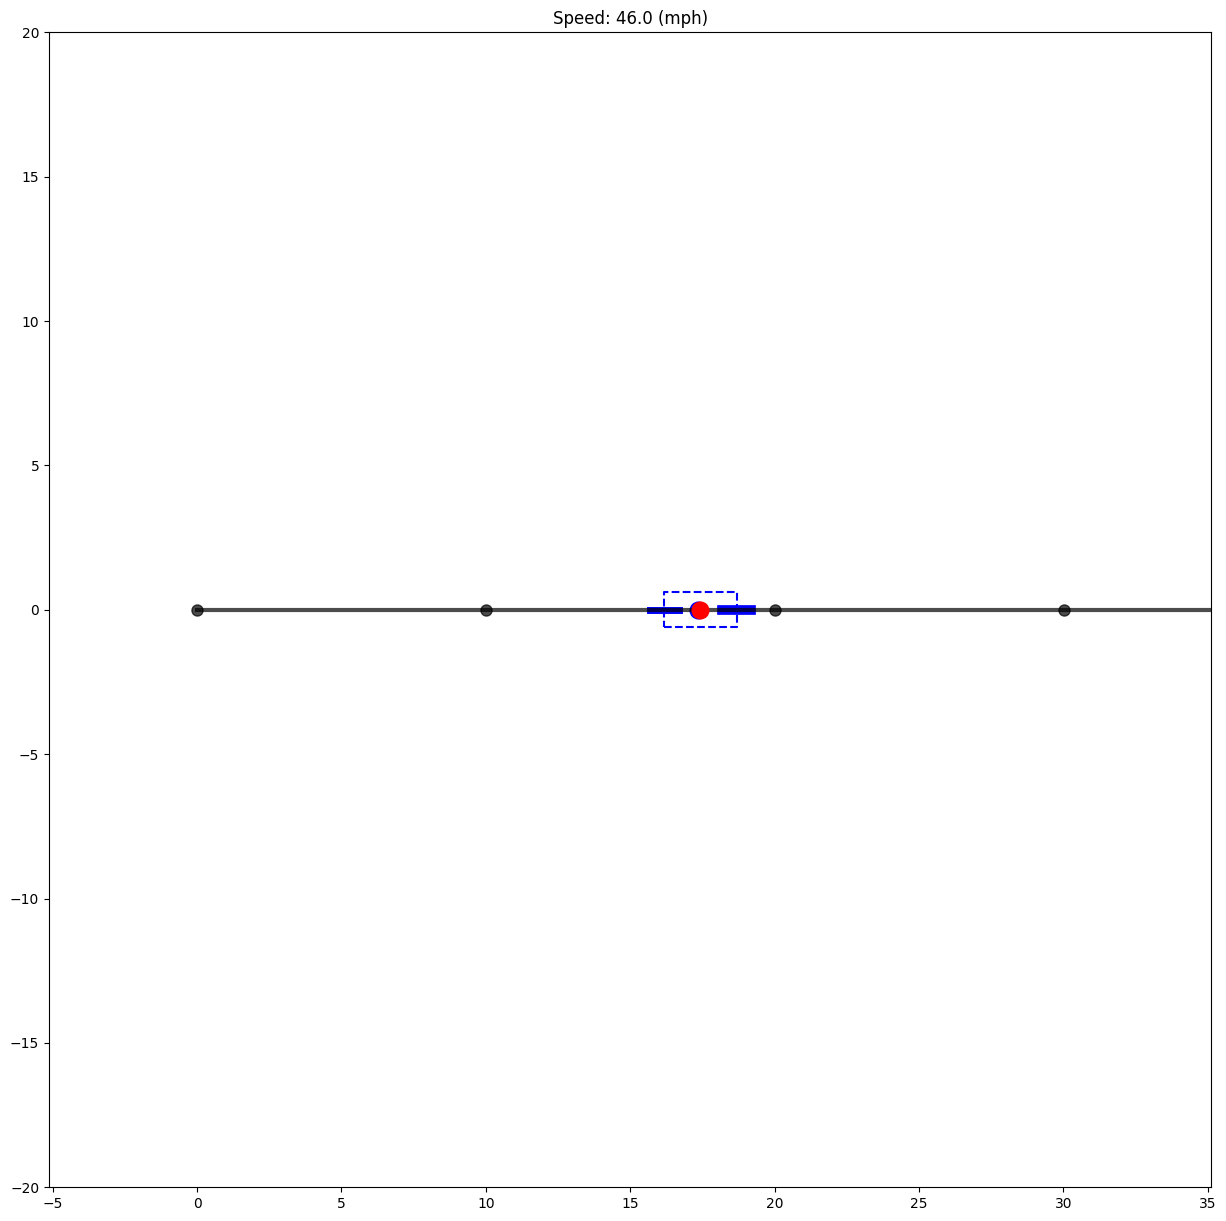

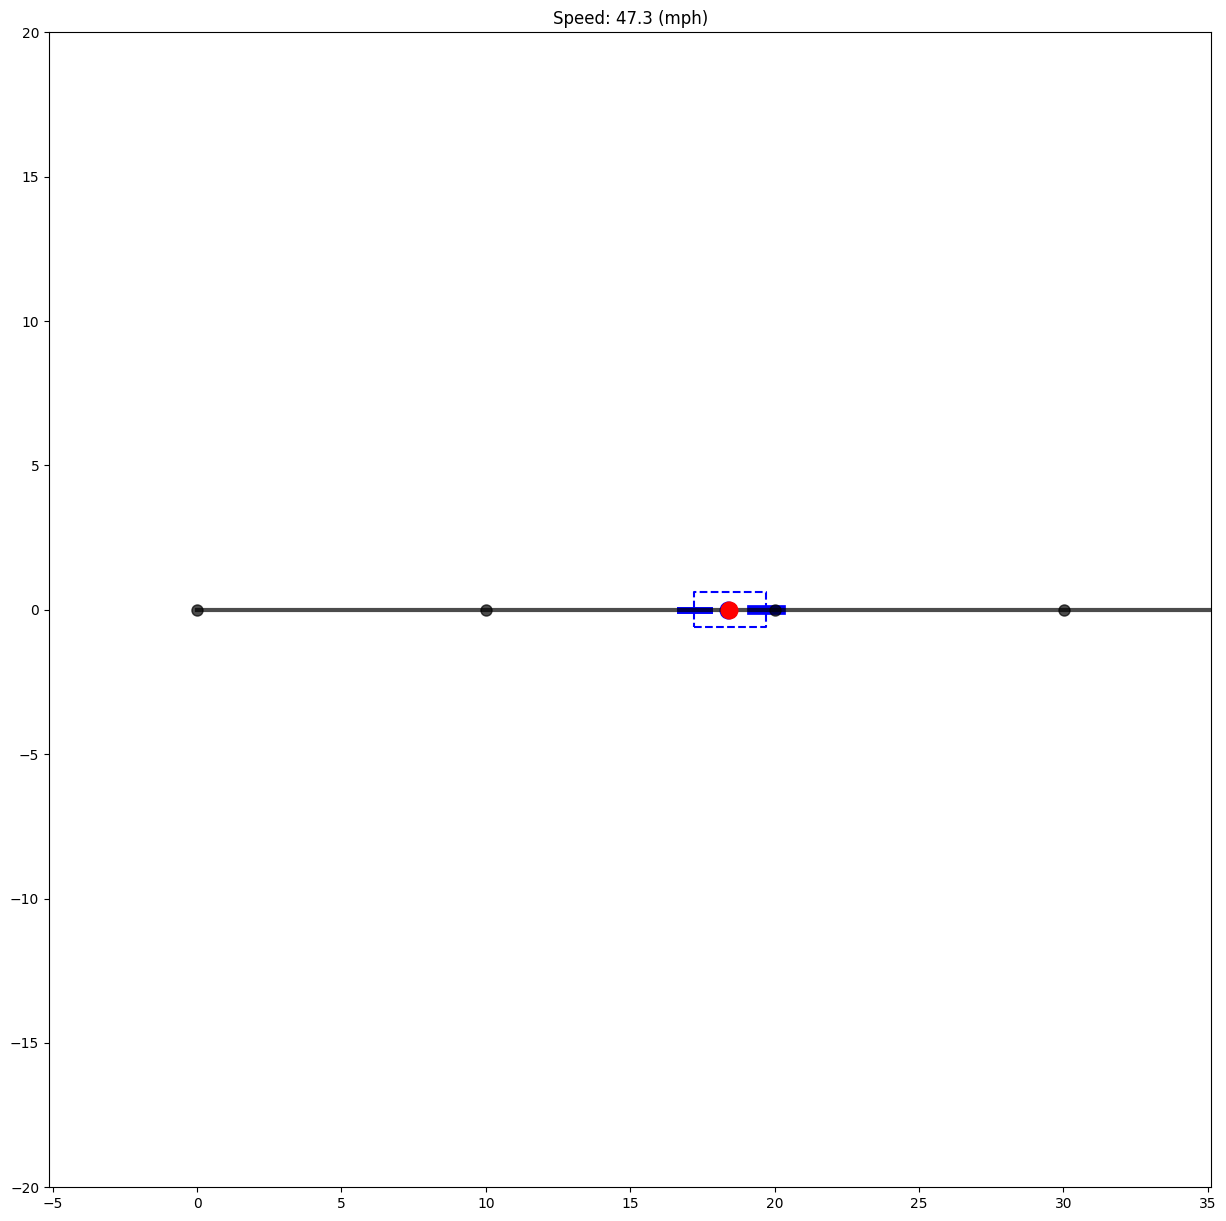

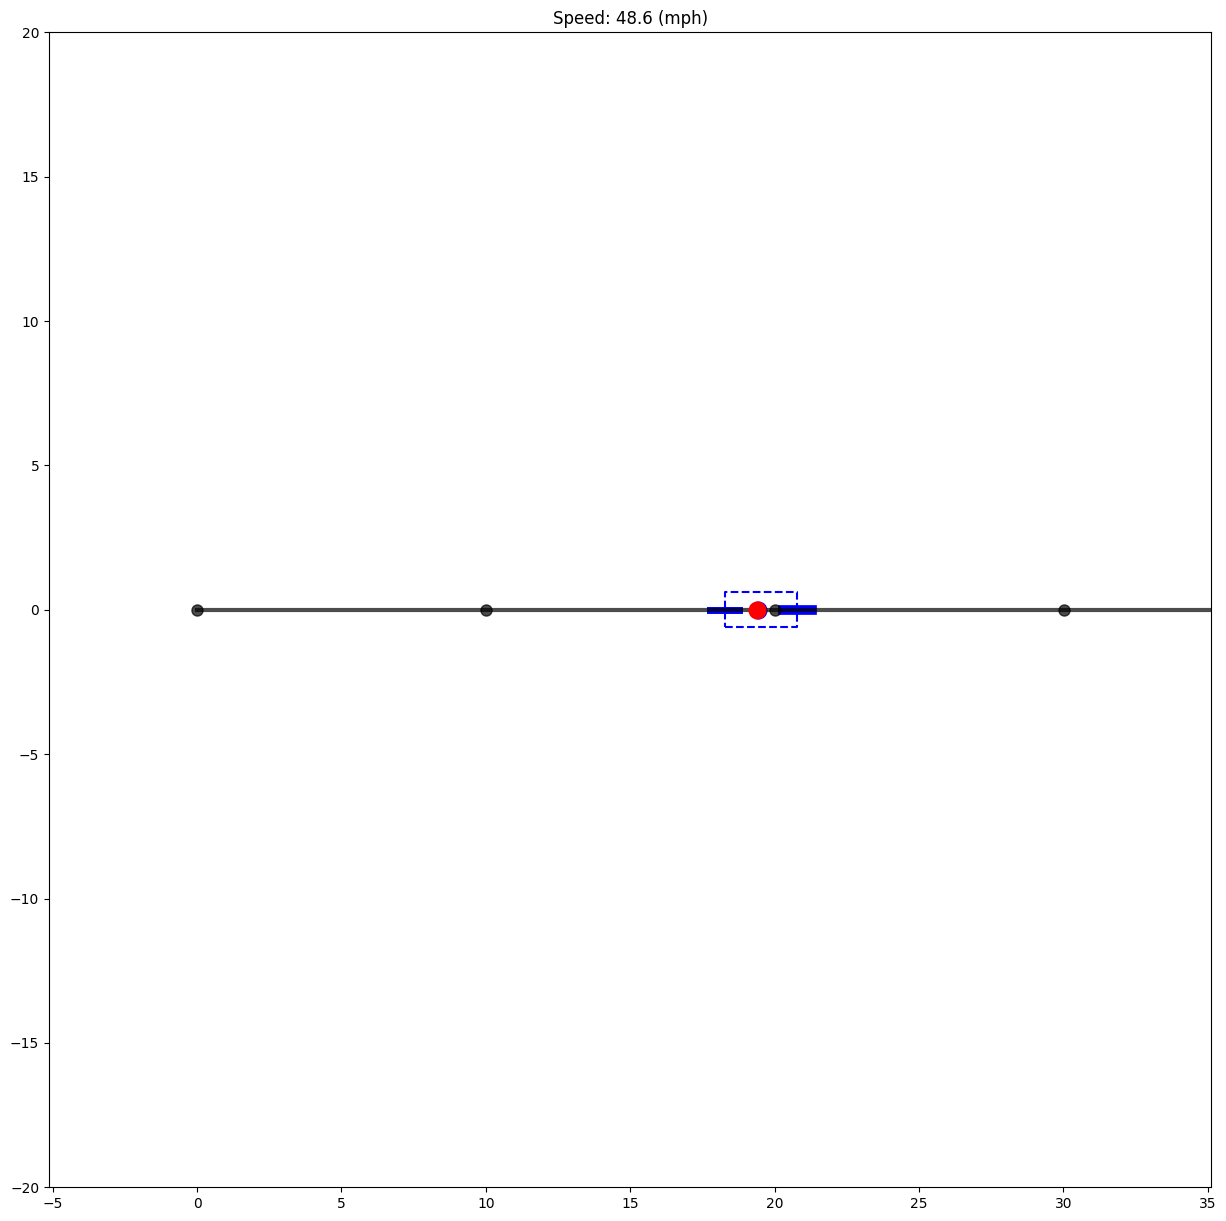

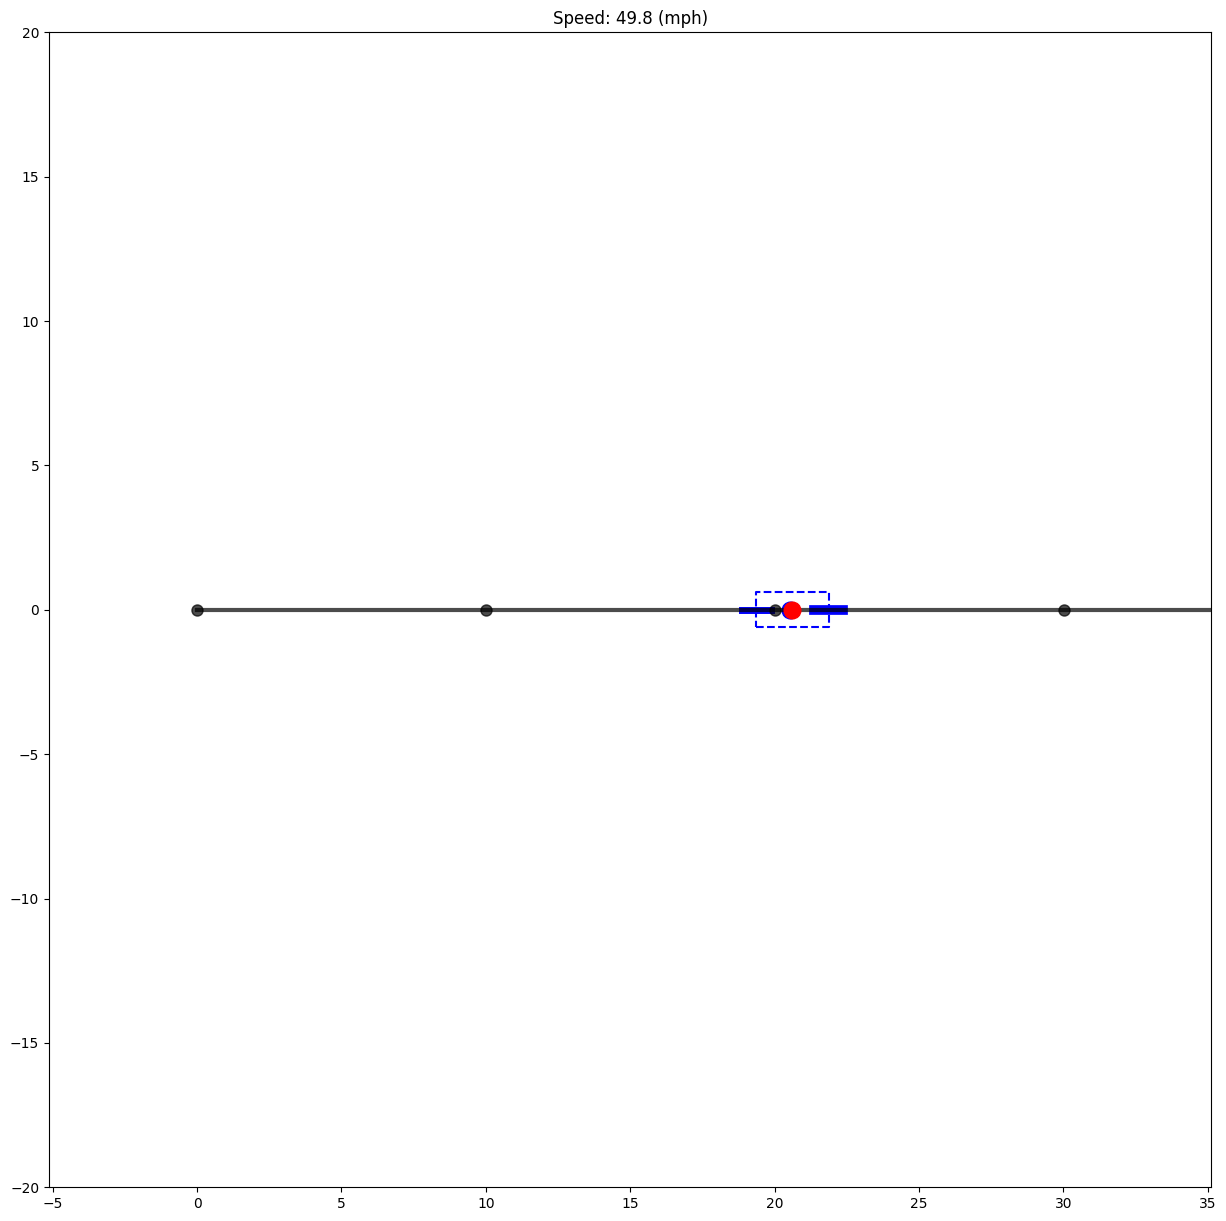

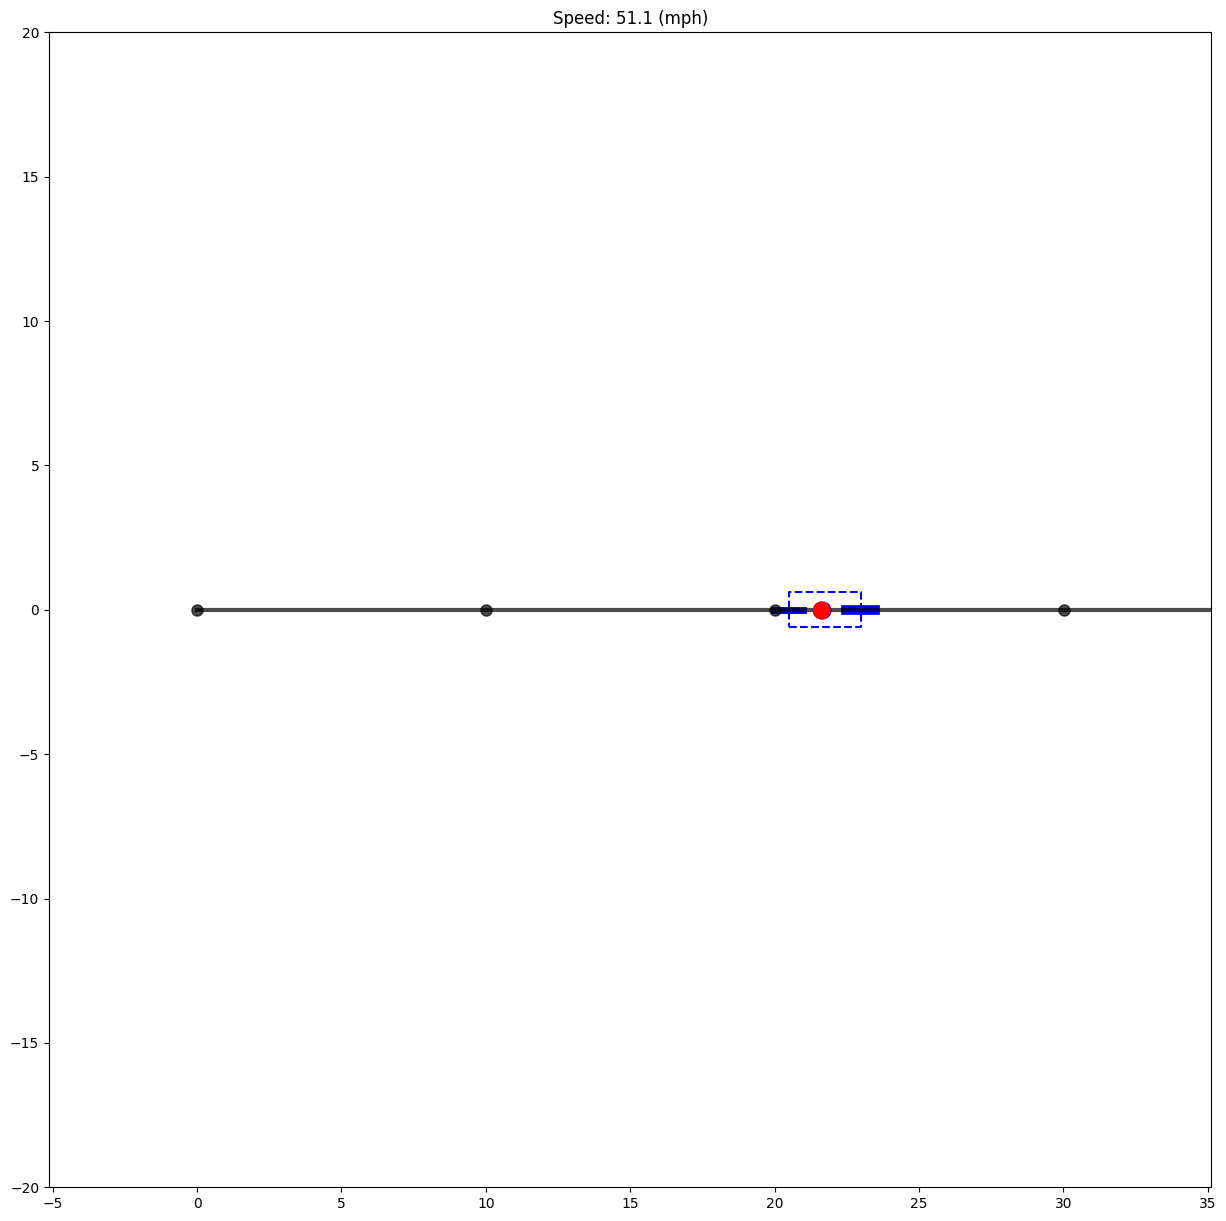

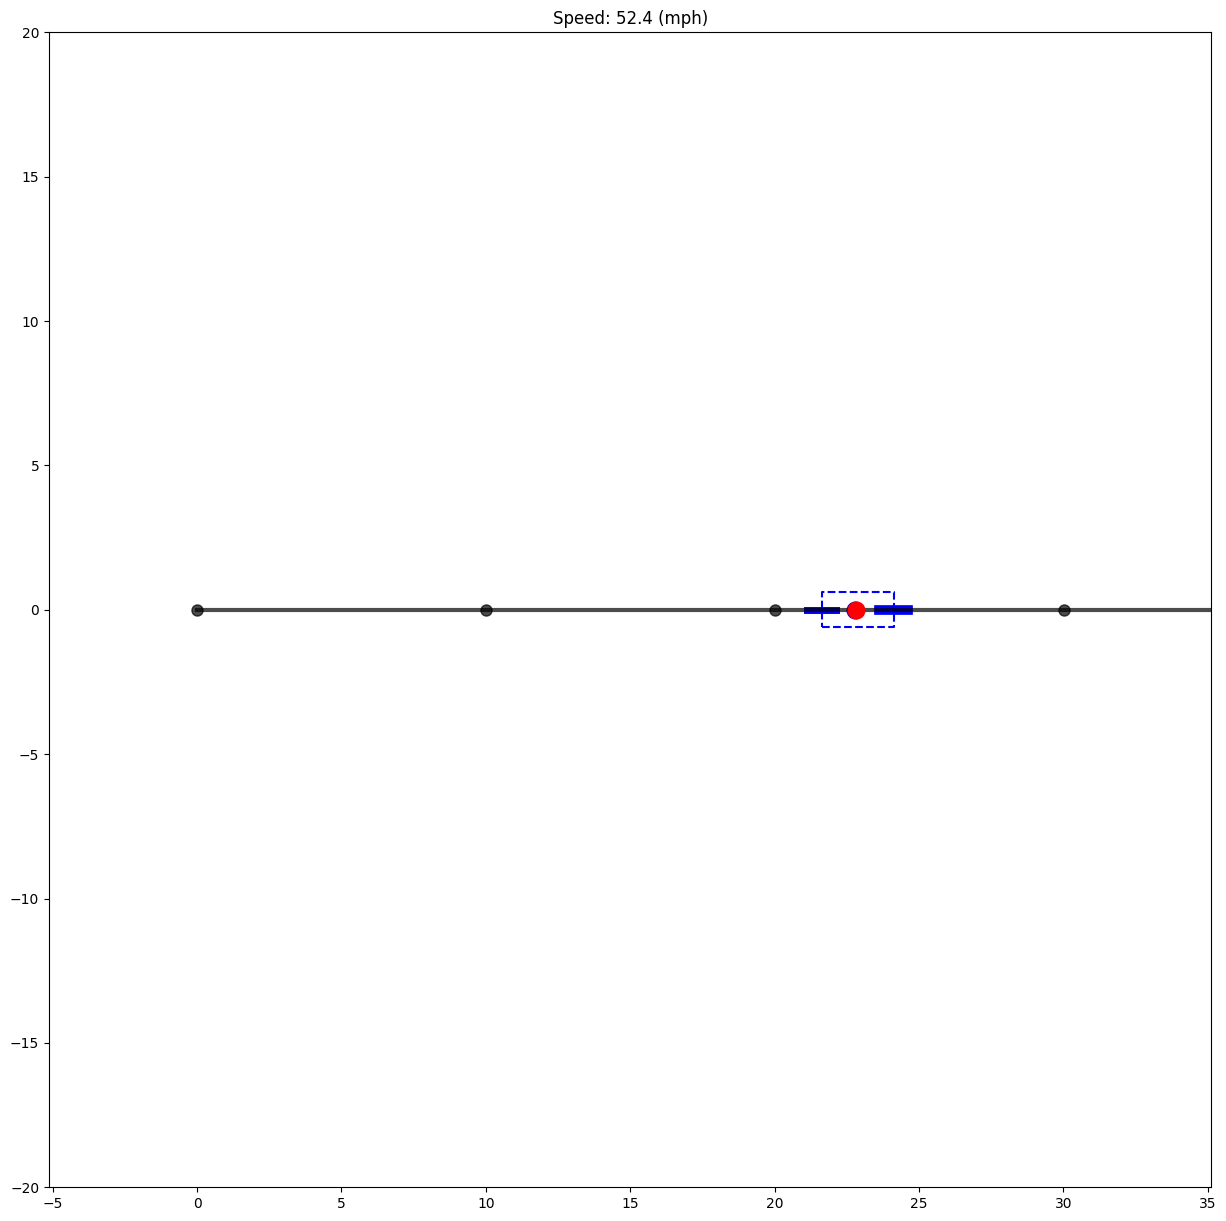

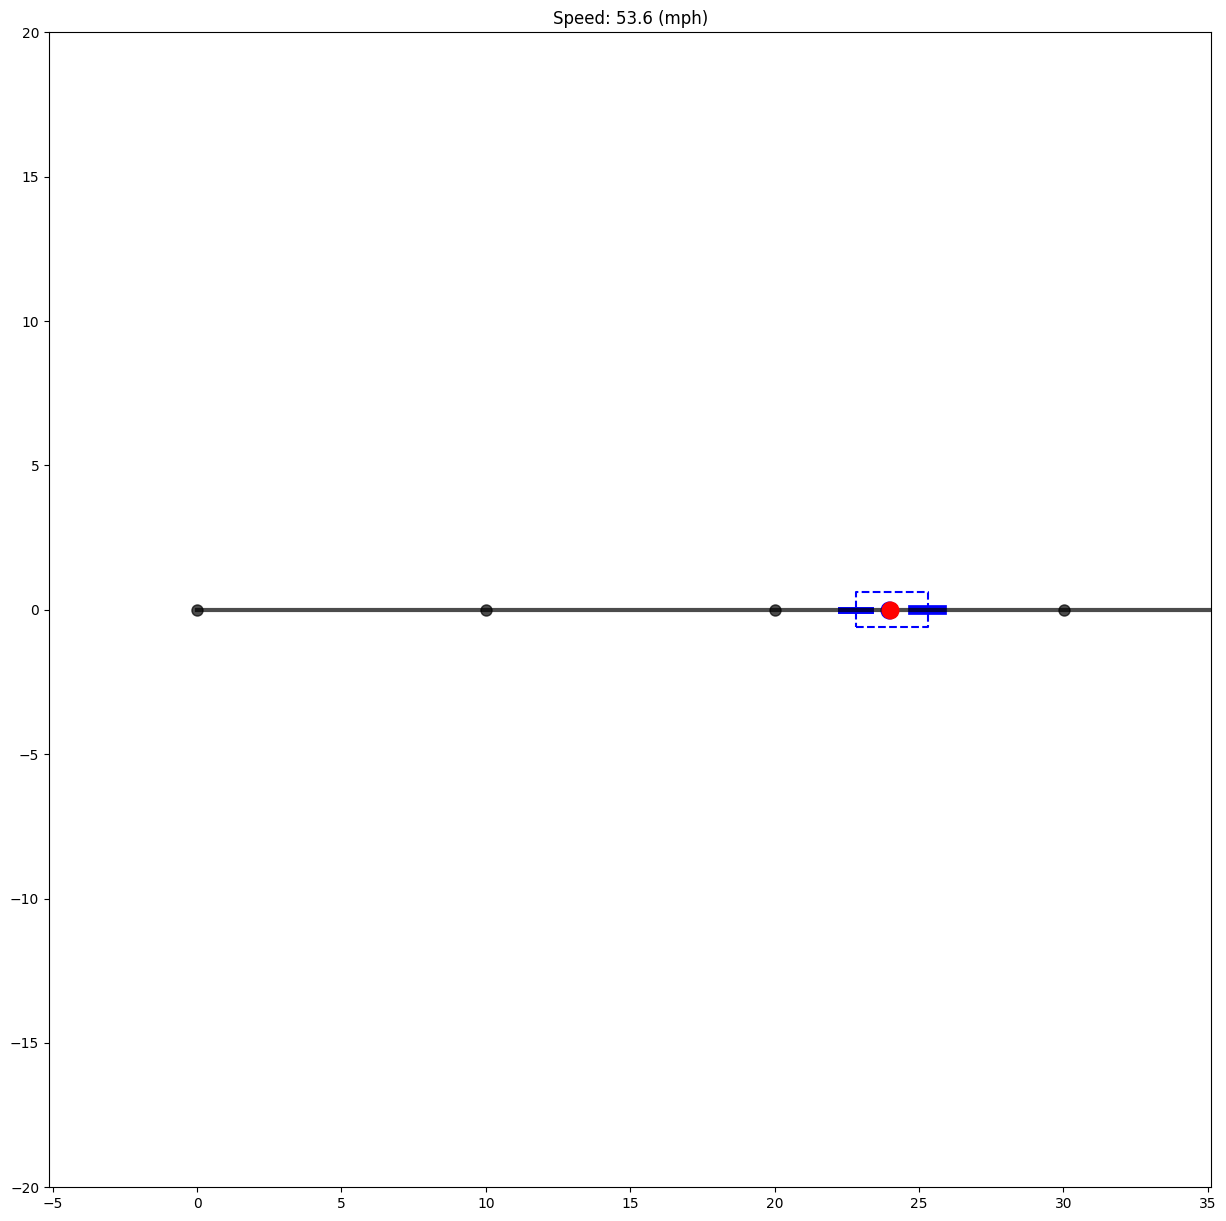

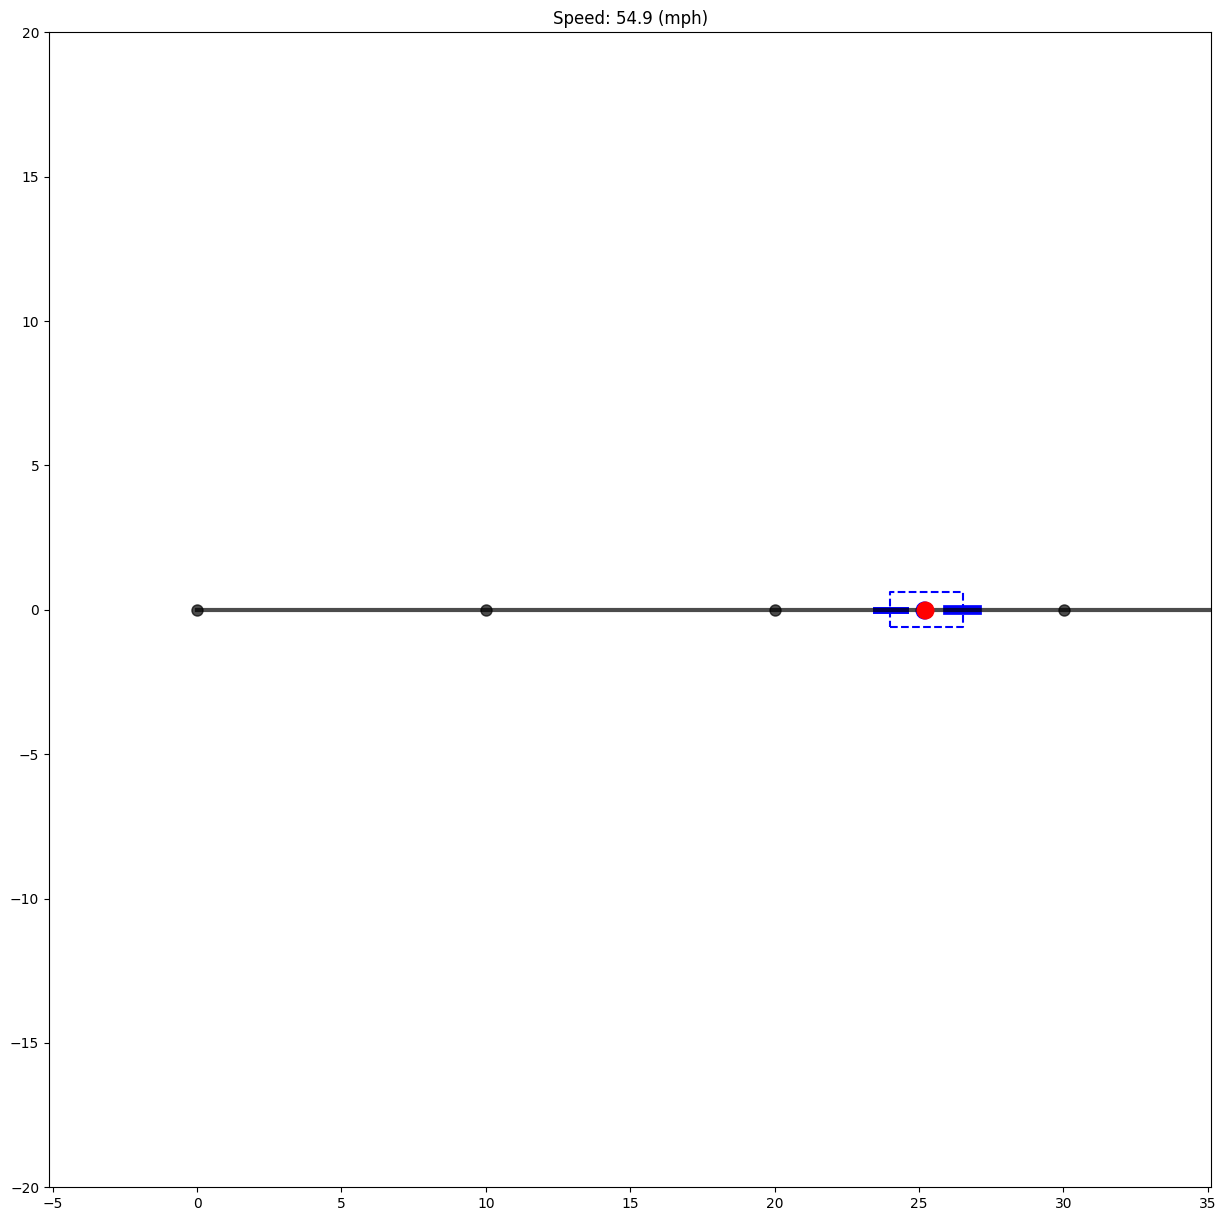

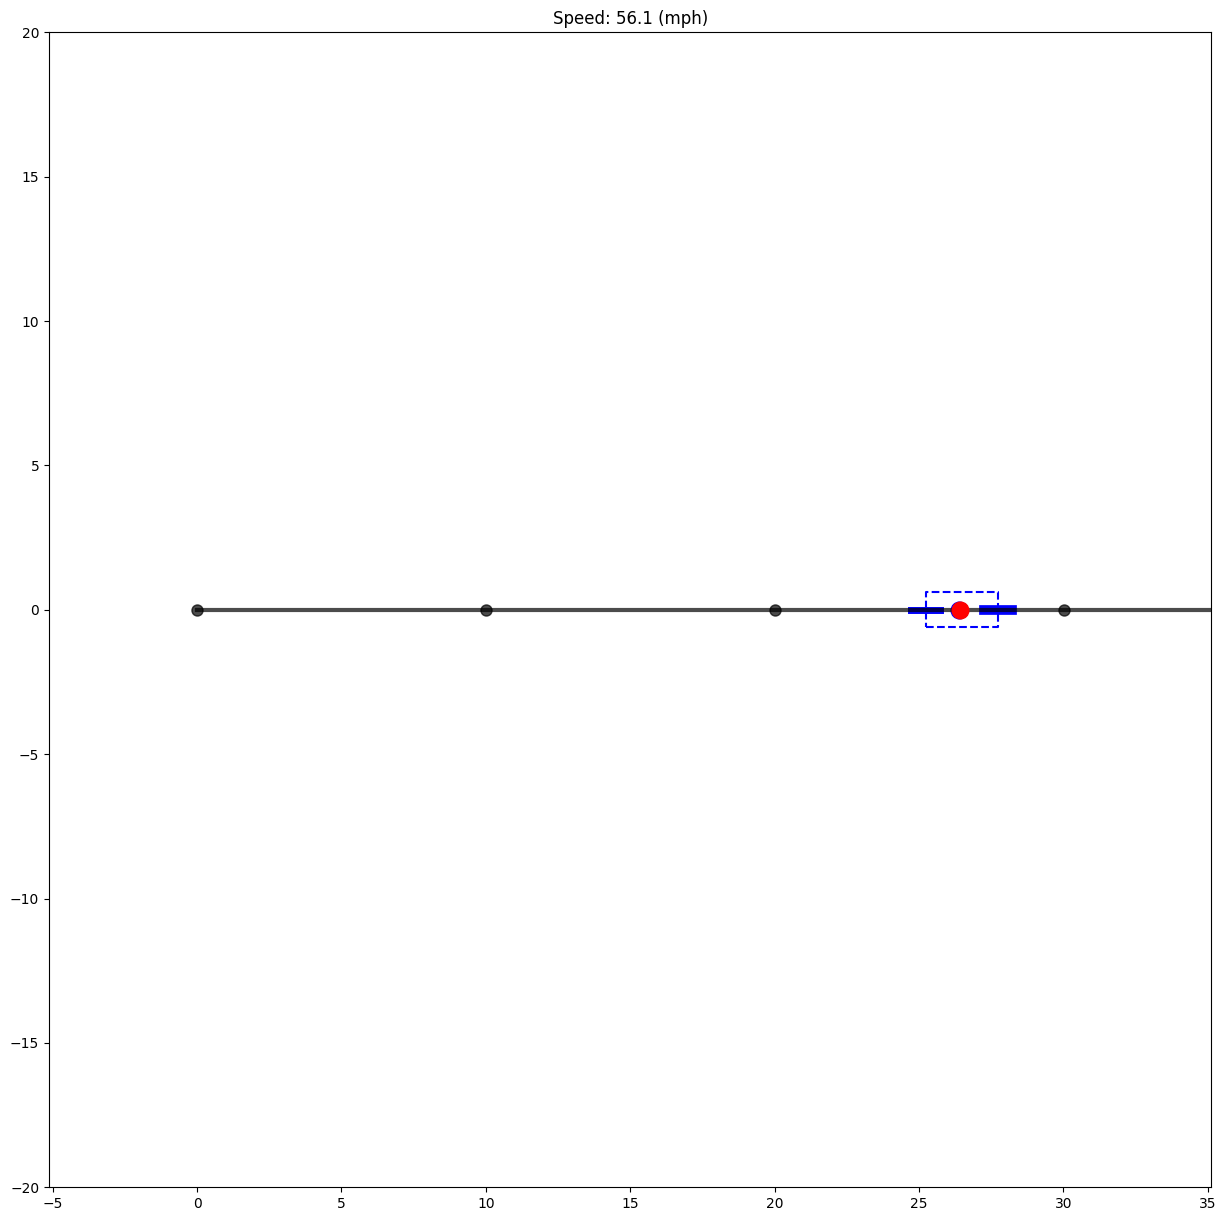

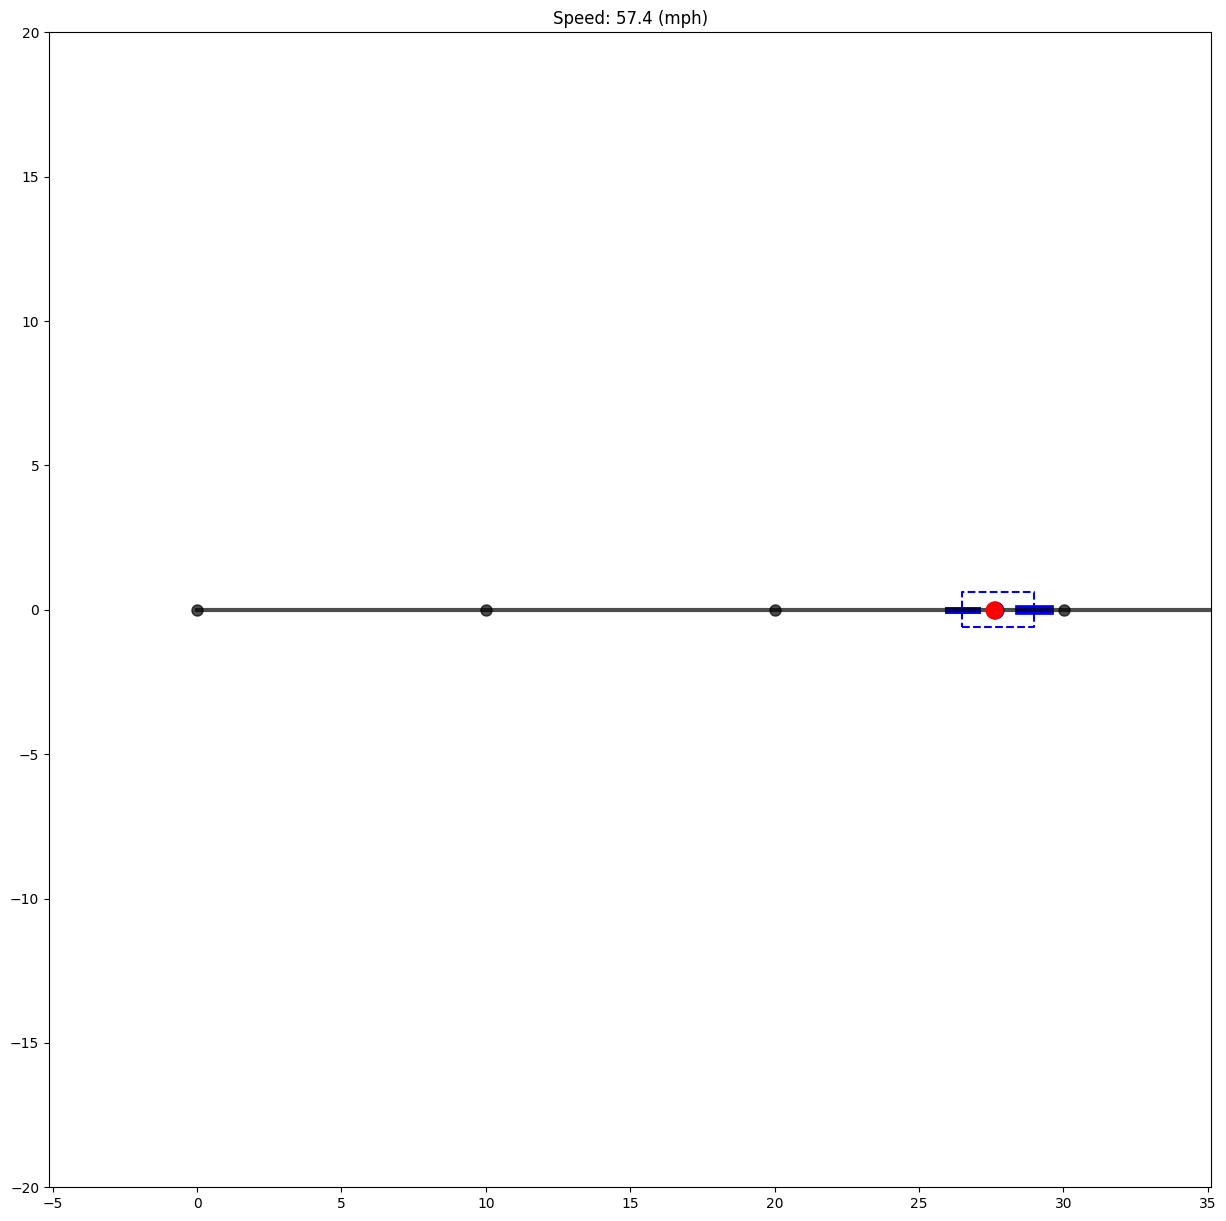

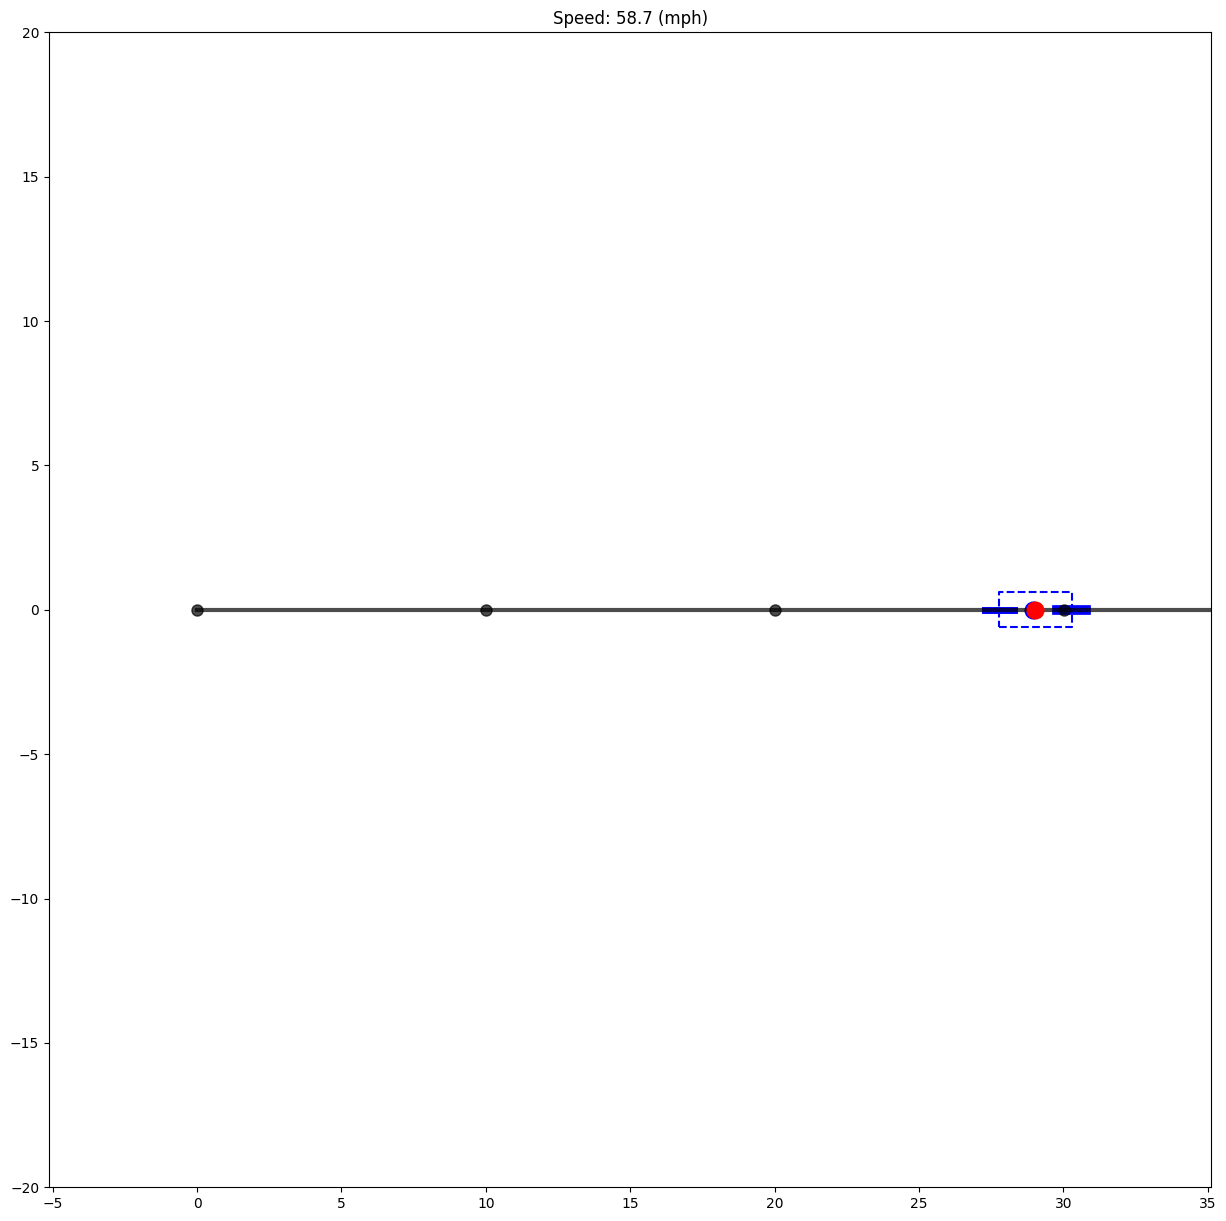

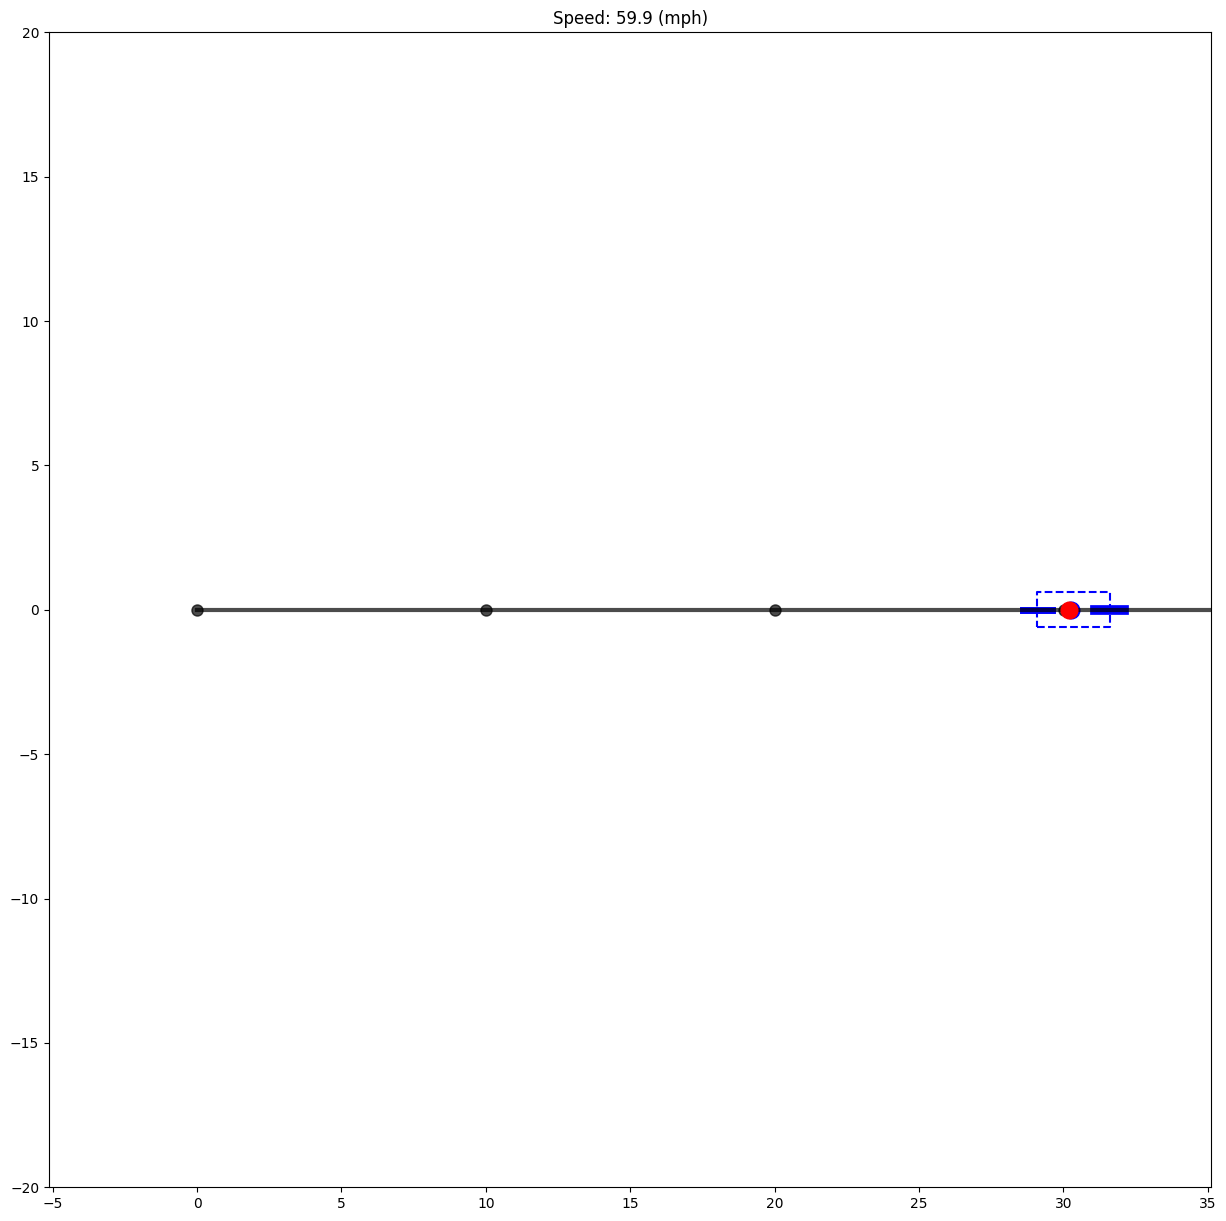

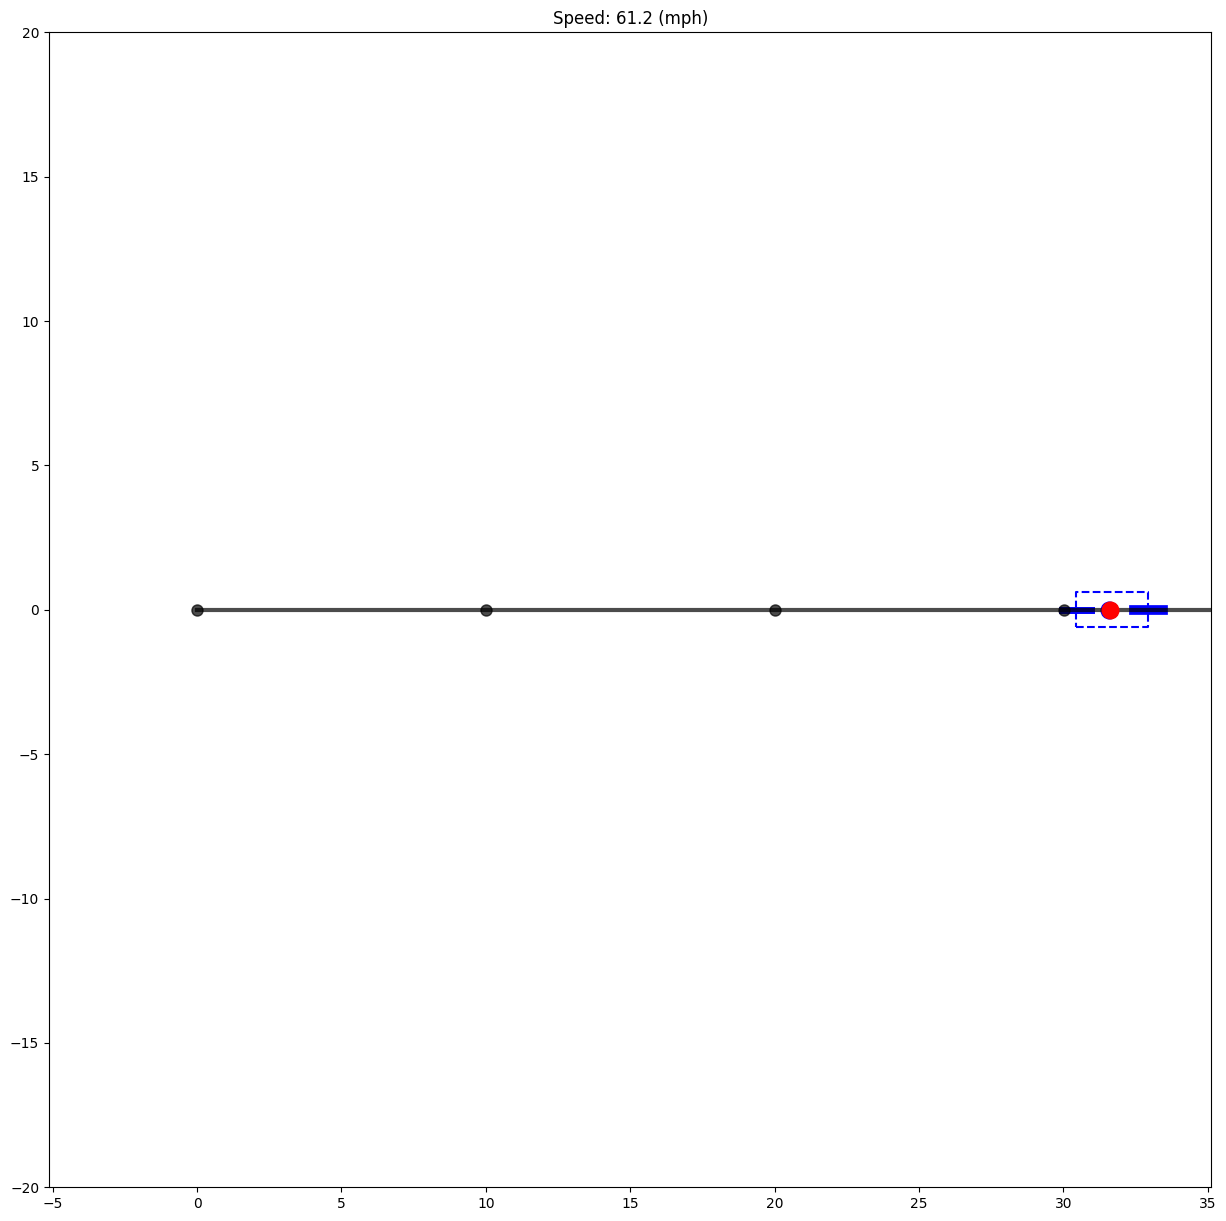

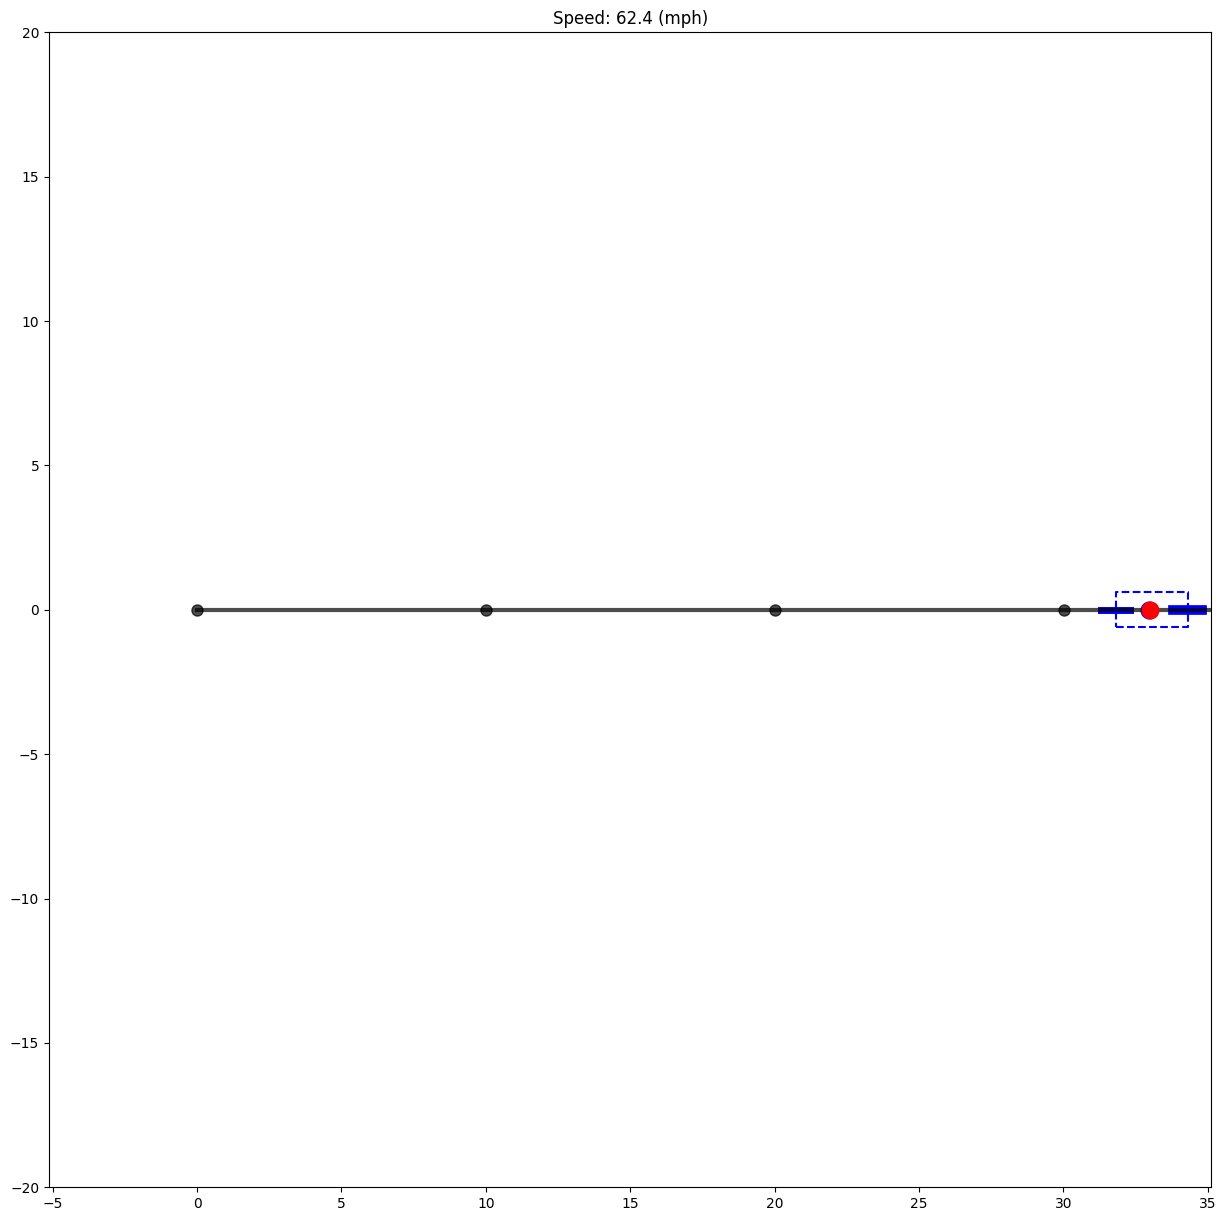

Linear total reward: 70.64862595824543


In [17]:
rc_env = SDRaceCar(render_env=True,track='Linear')
controller = RaceCarController("Linear")

obs = rc_env.reset()
total_reward = 0.0

for step in range(5000):
    action = controller(obs)
    obs, reward, done, info = rc_env.step(action)
    total_reward += float(reward)

    rc_env.render()

    if done:
        break

print("Linear total reward:", total_reward)



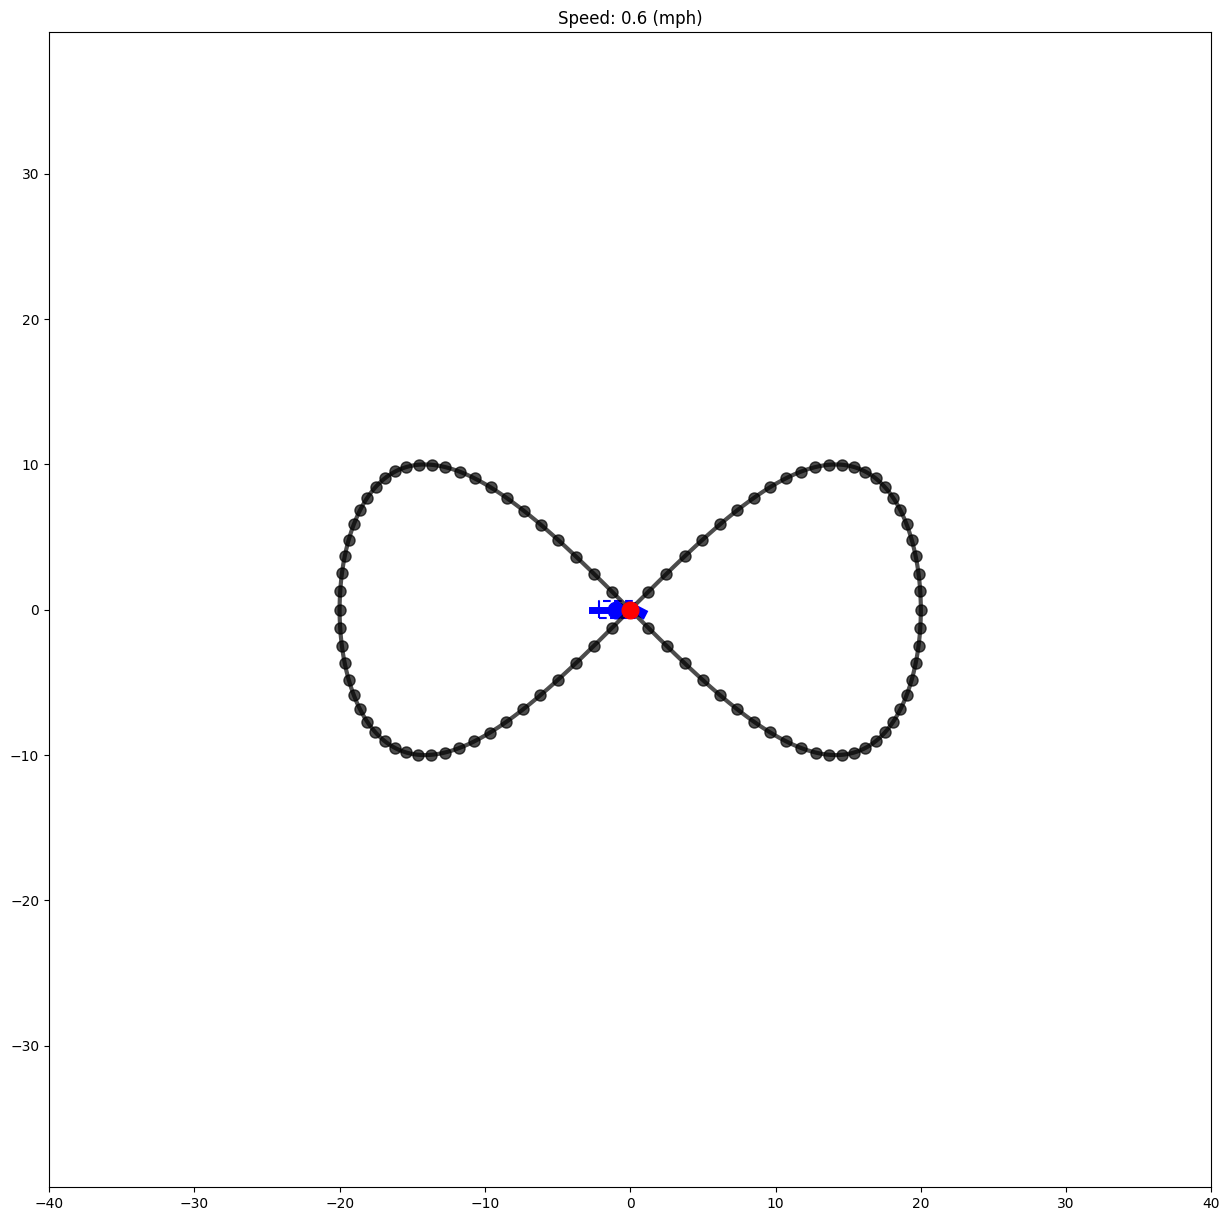

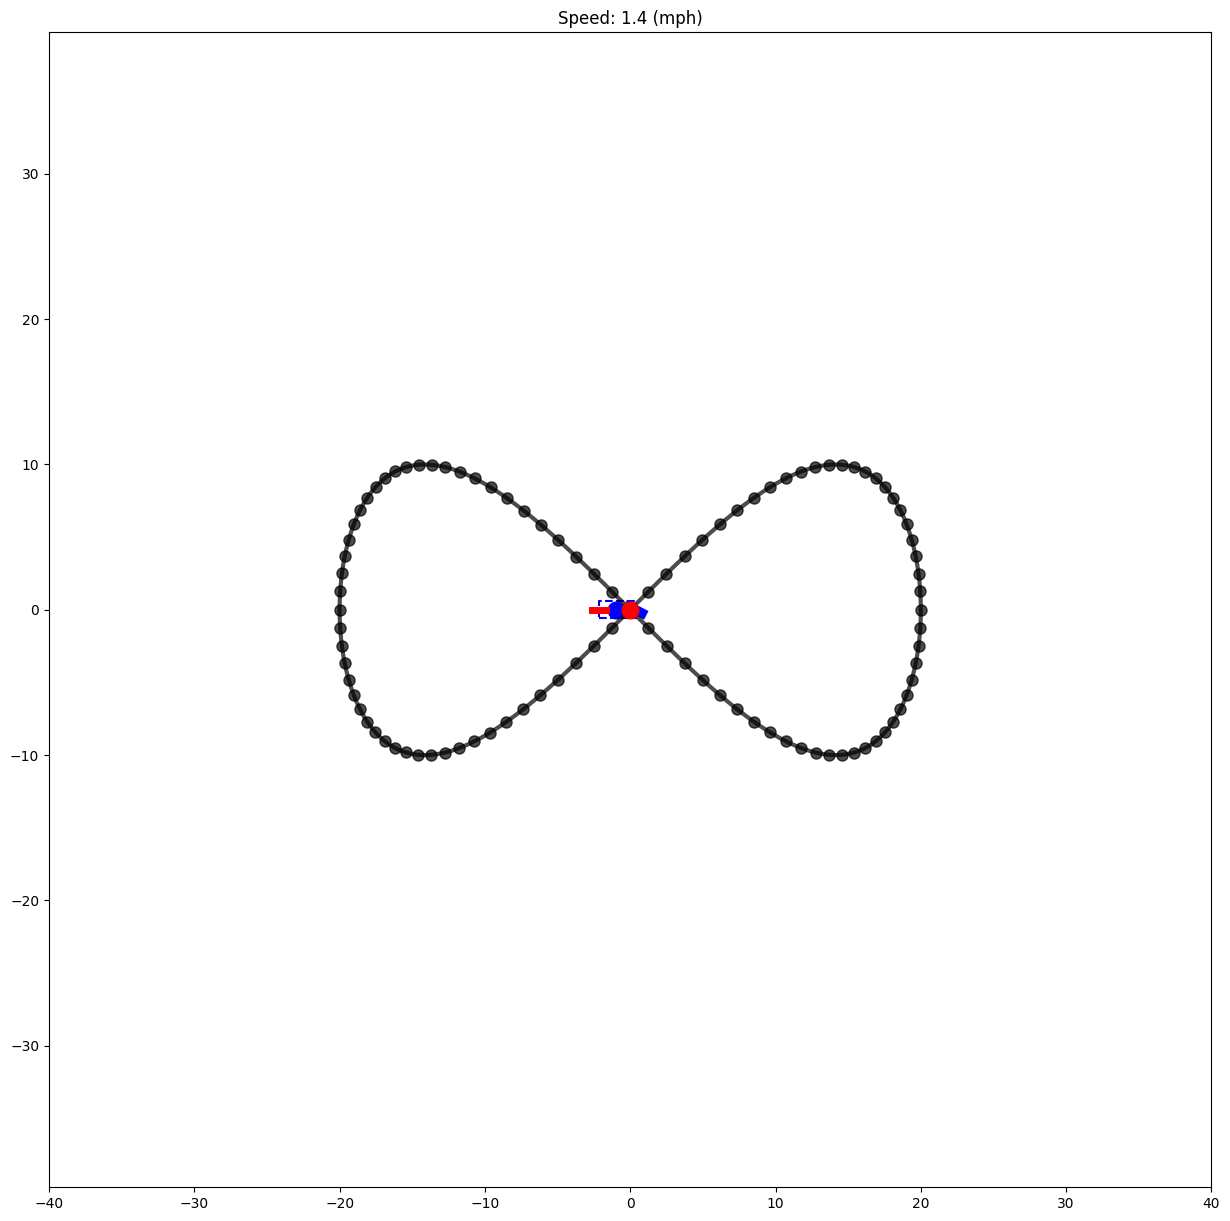

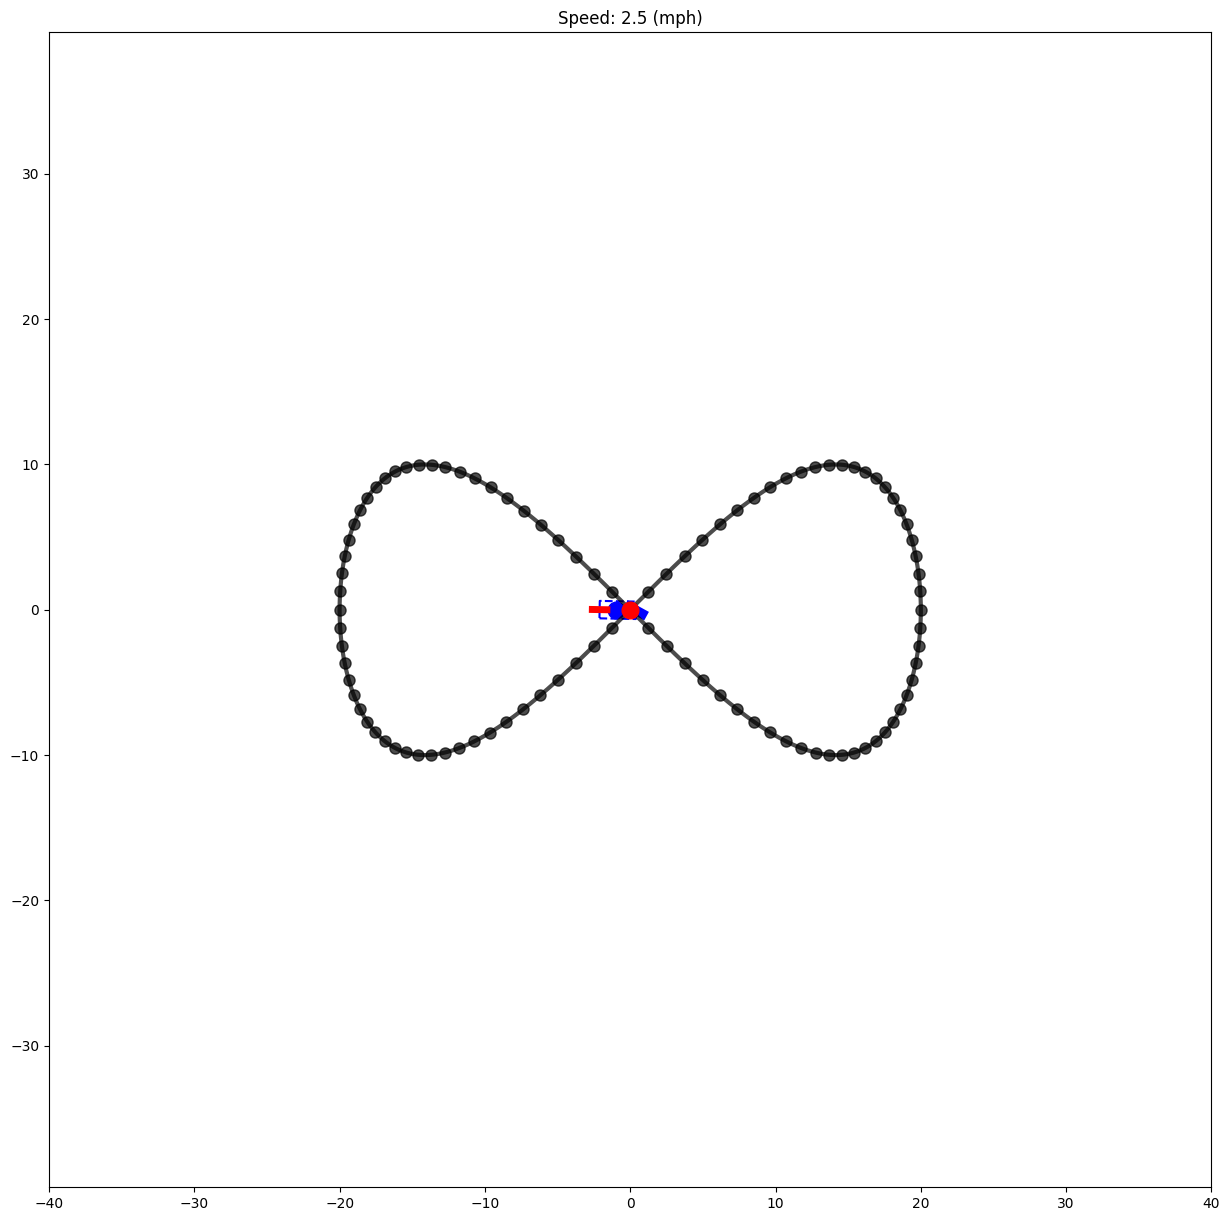

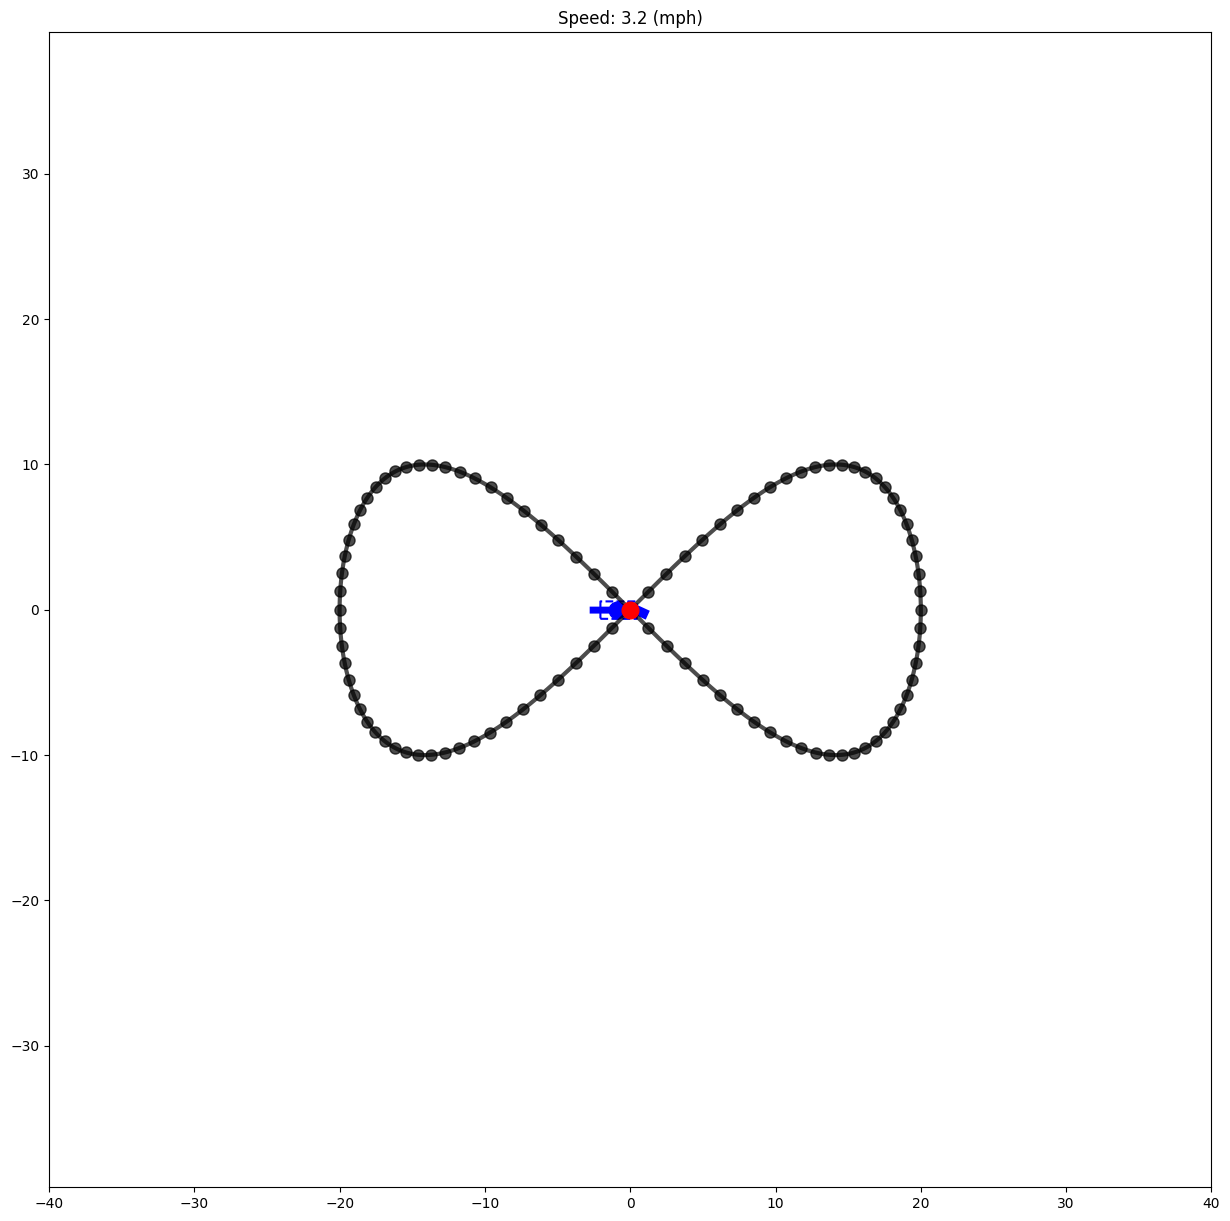

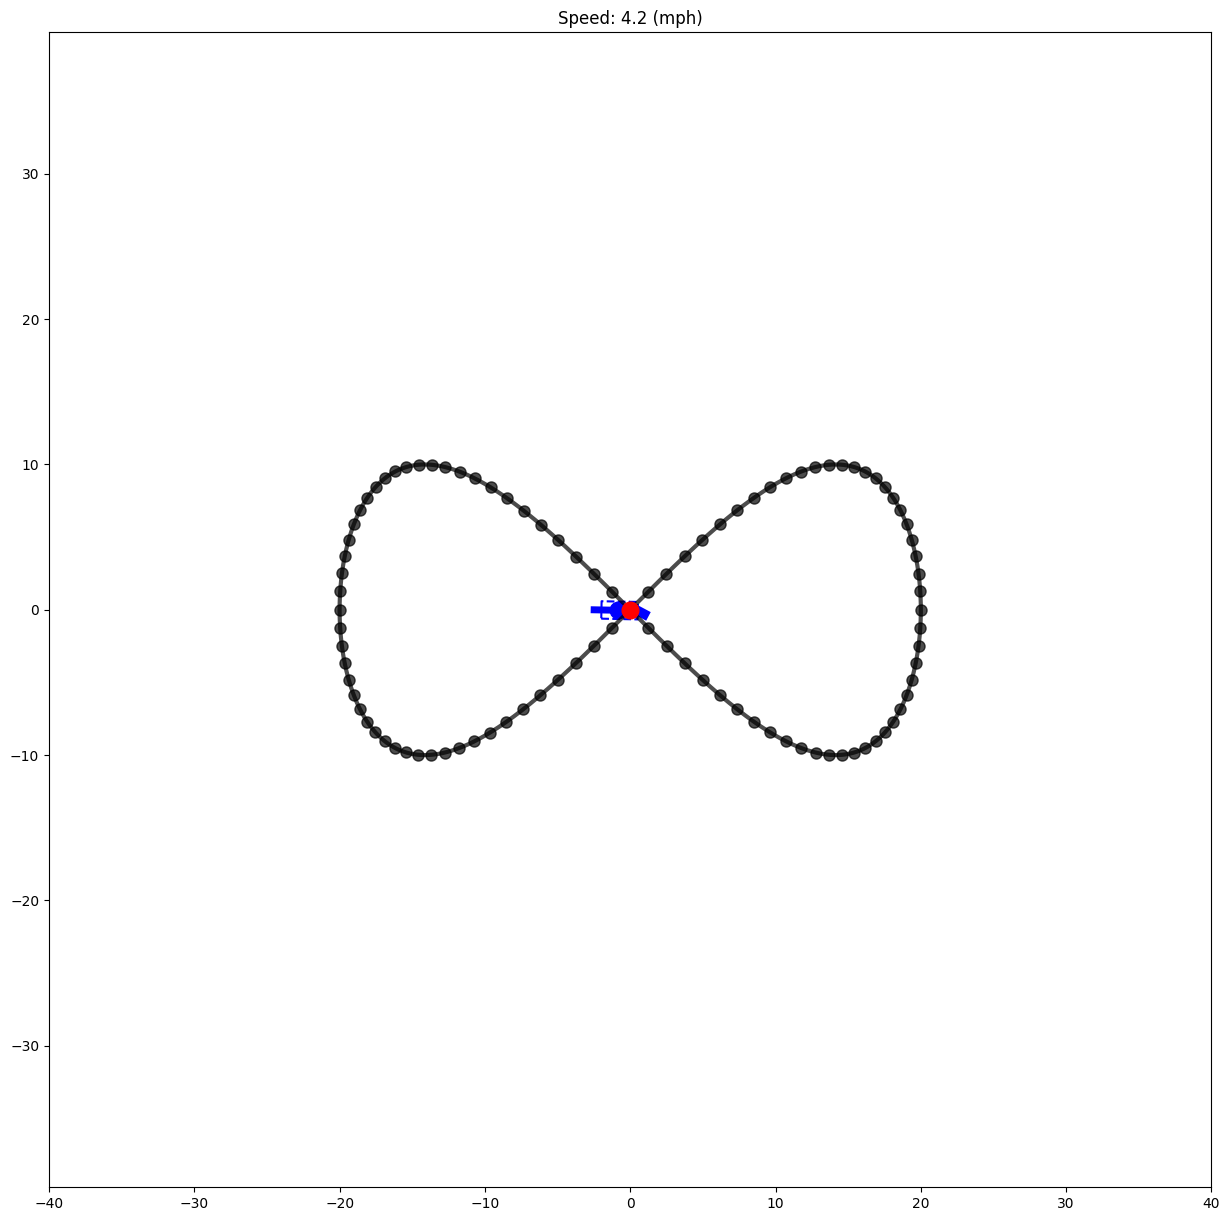

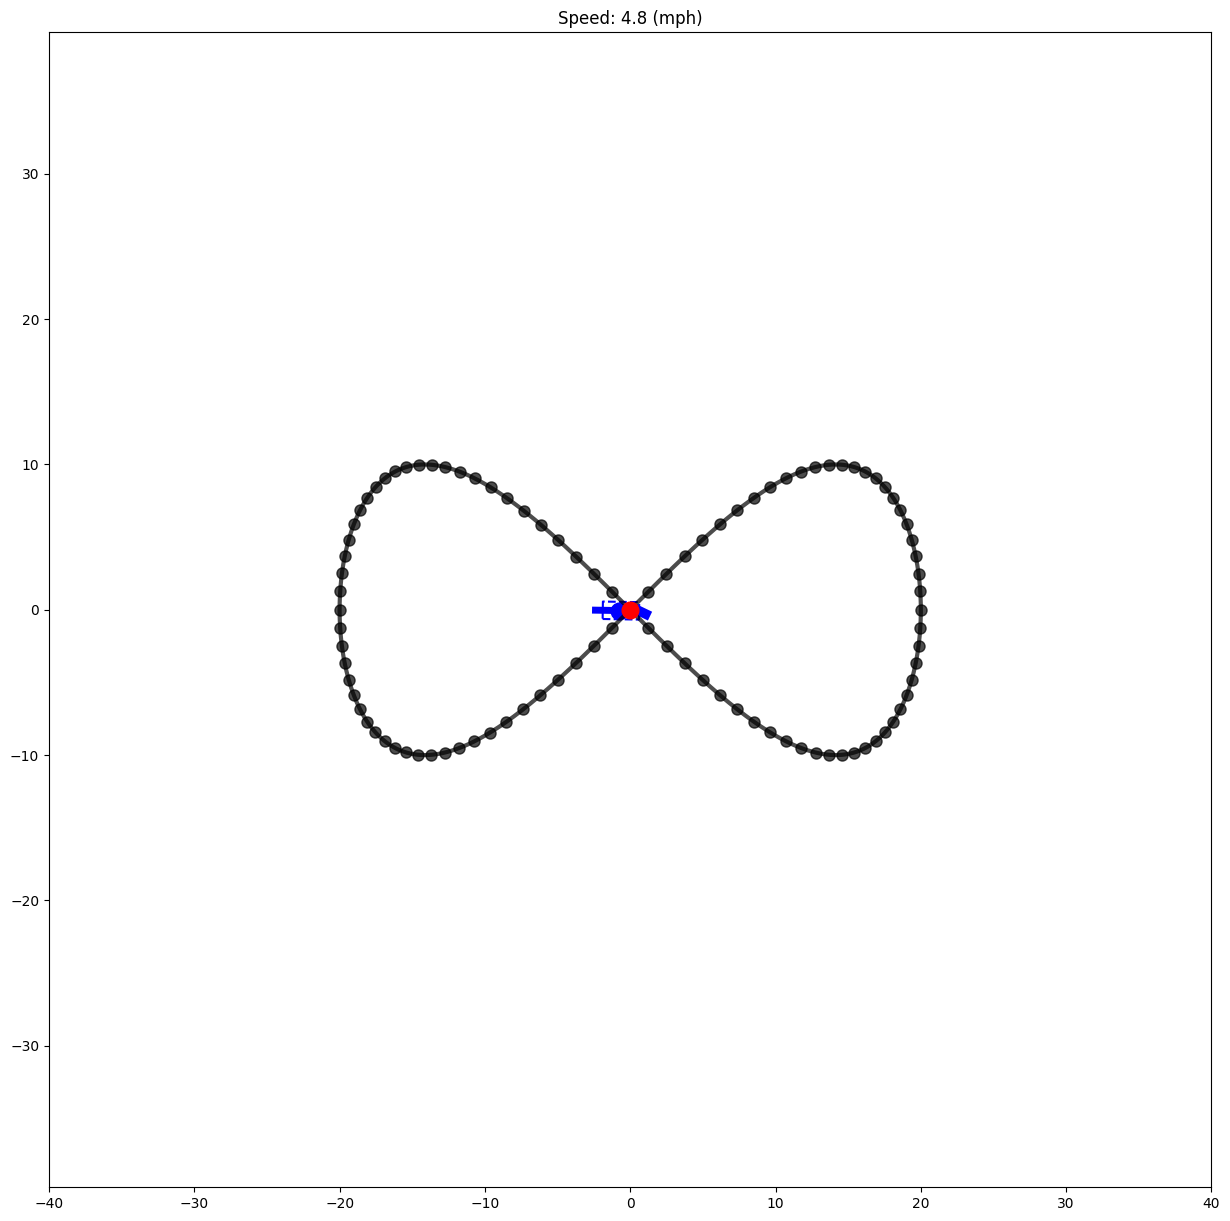

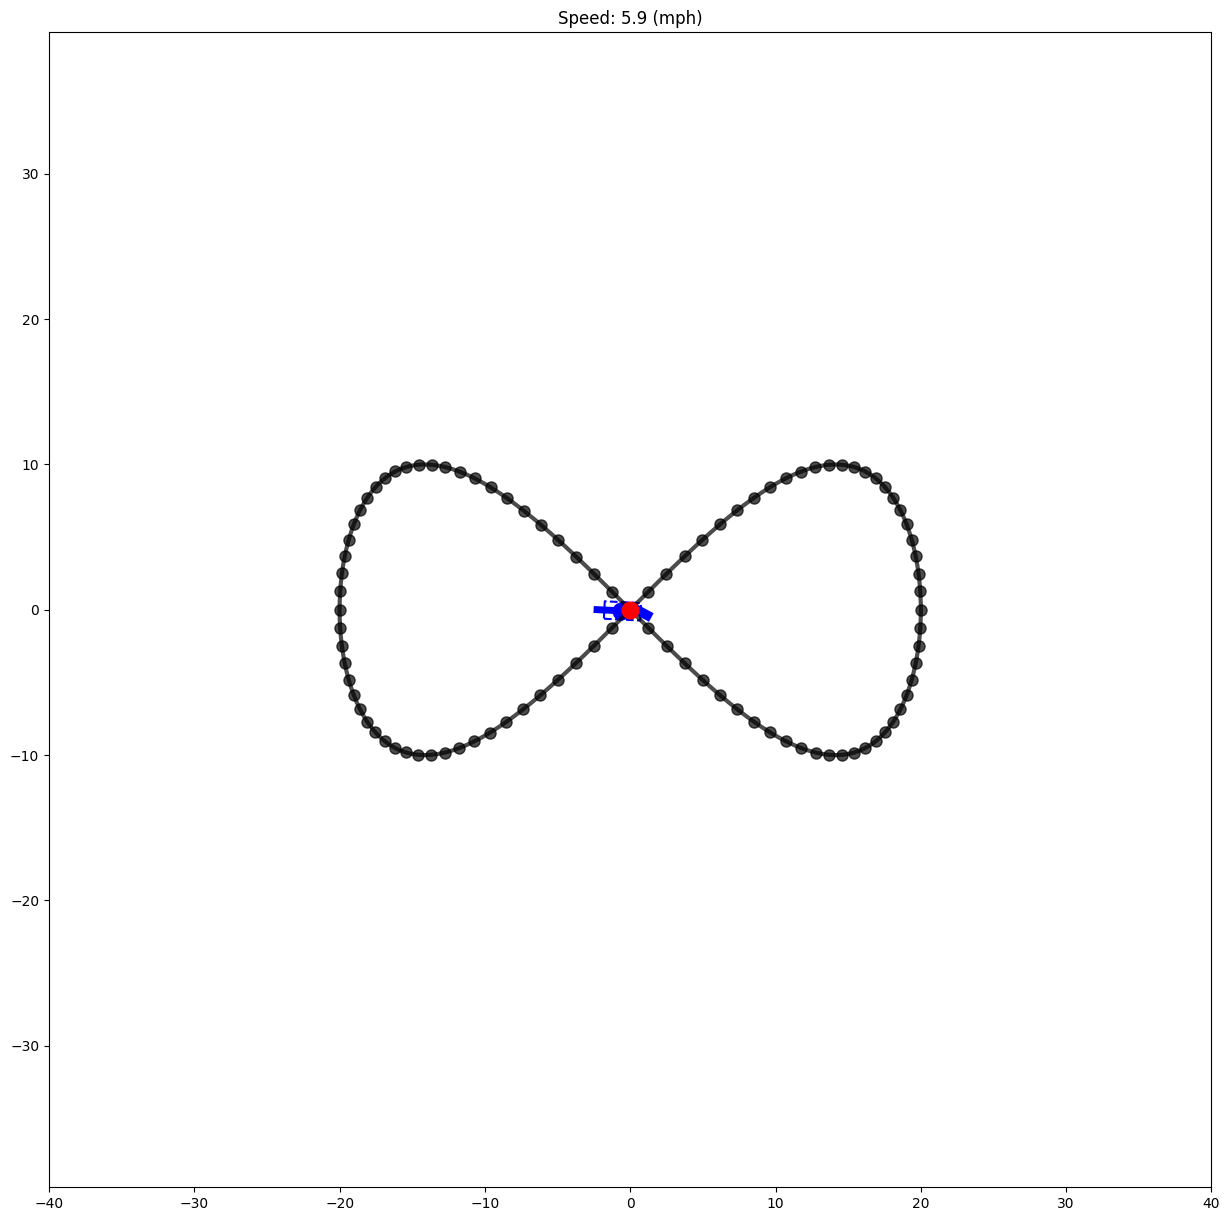

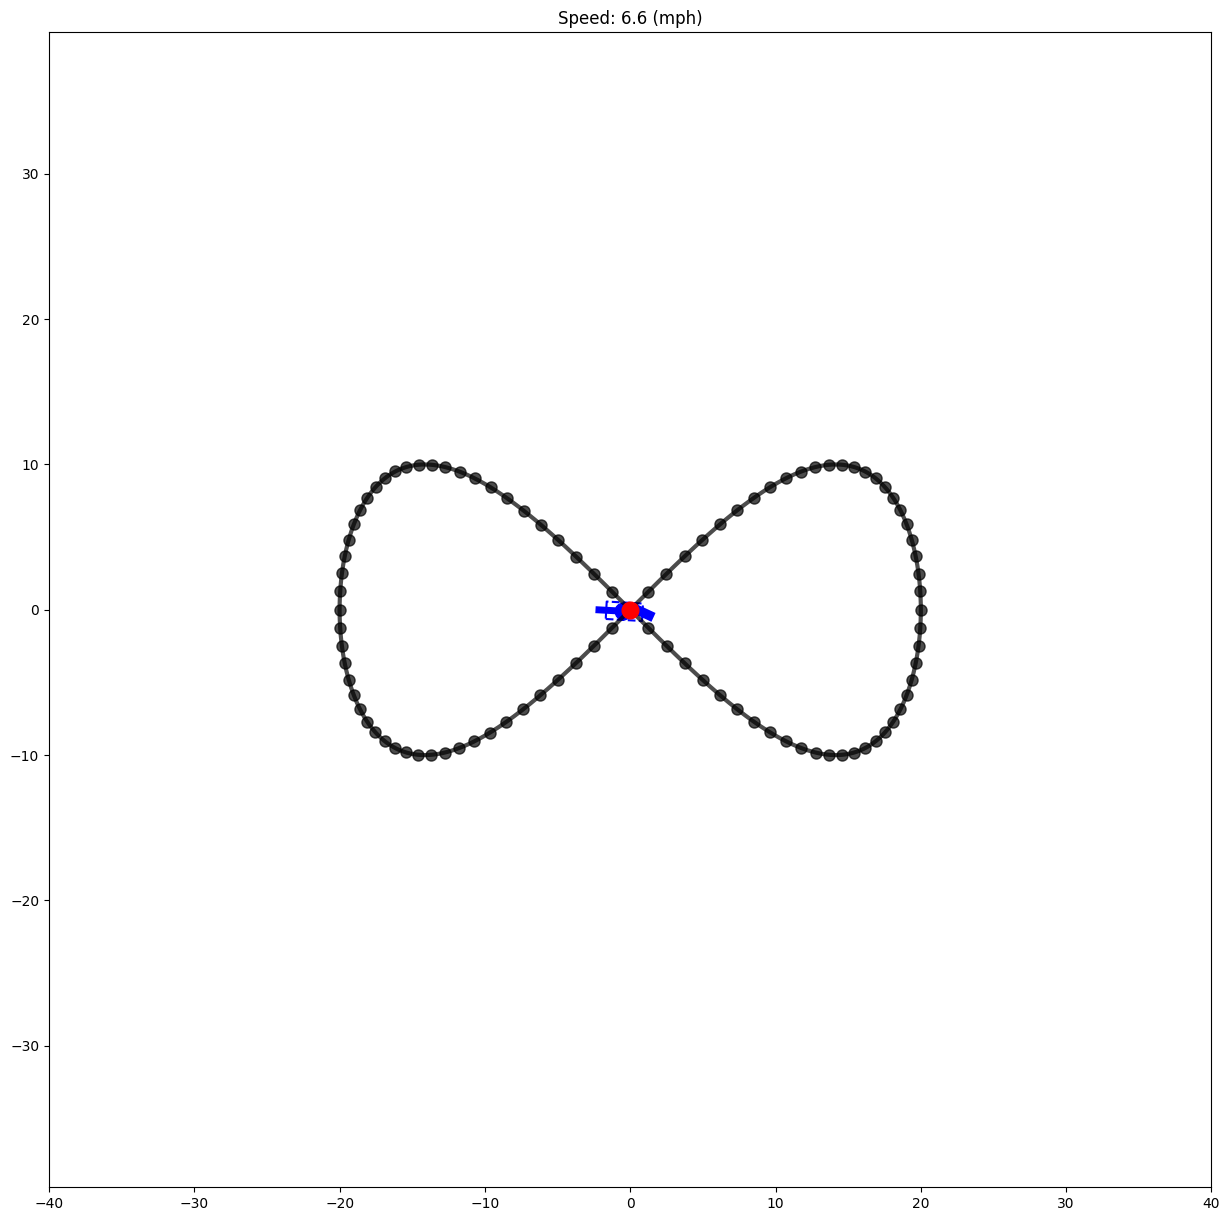

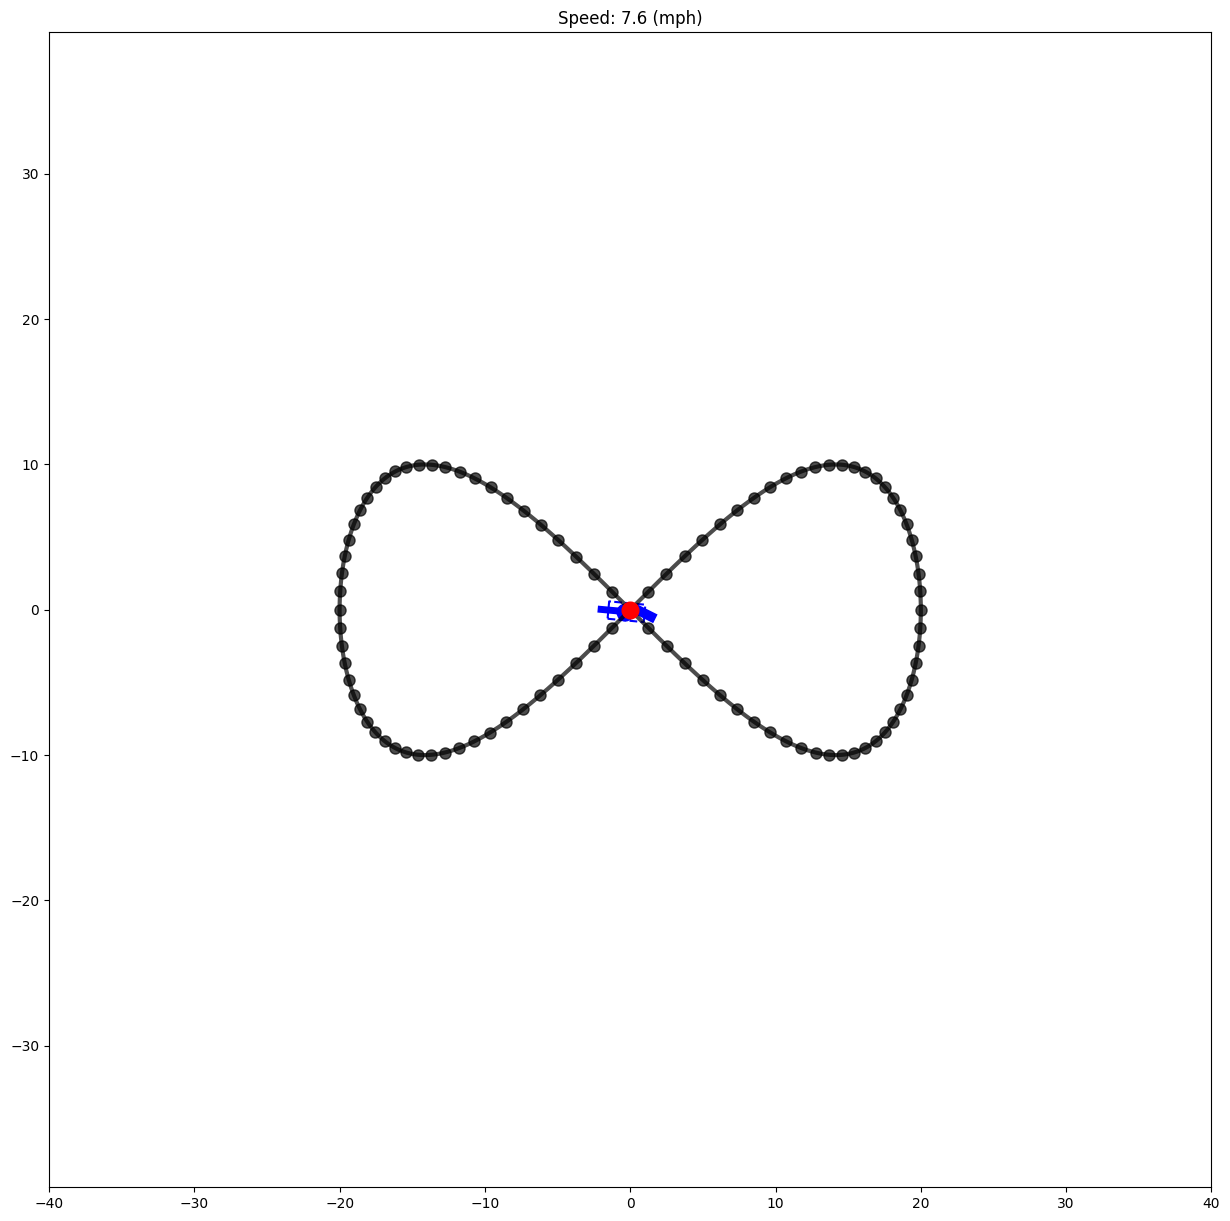

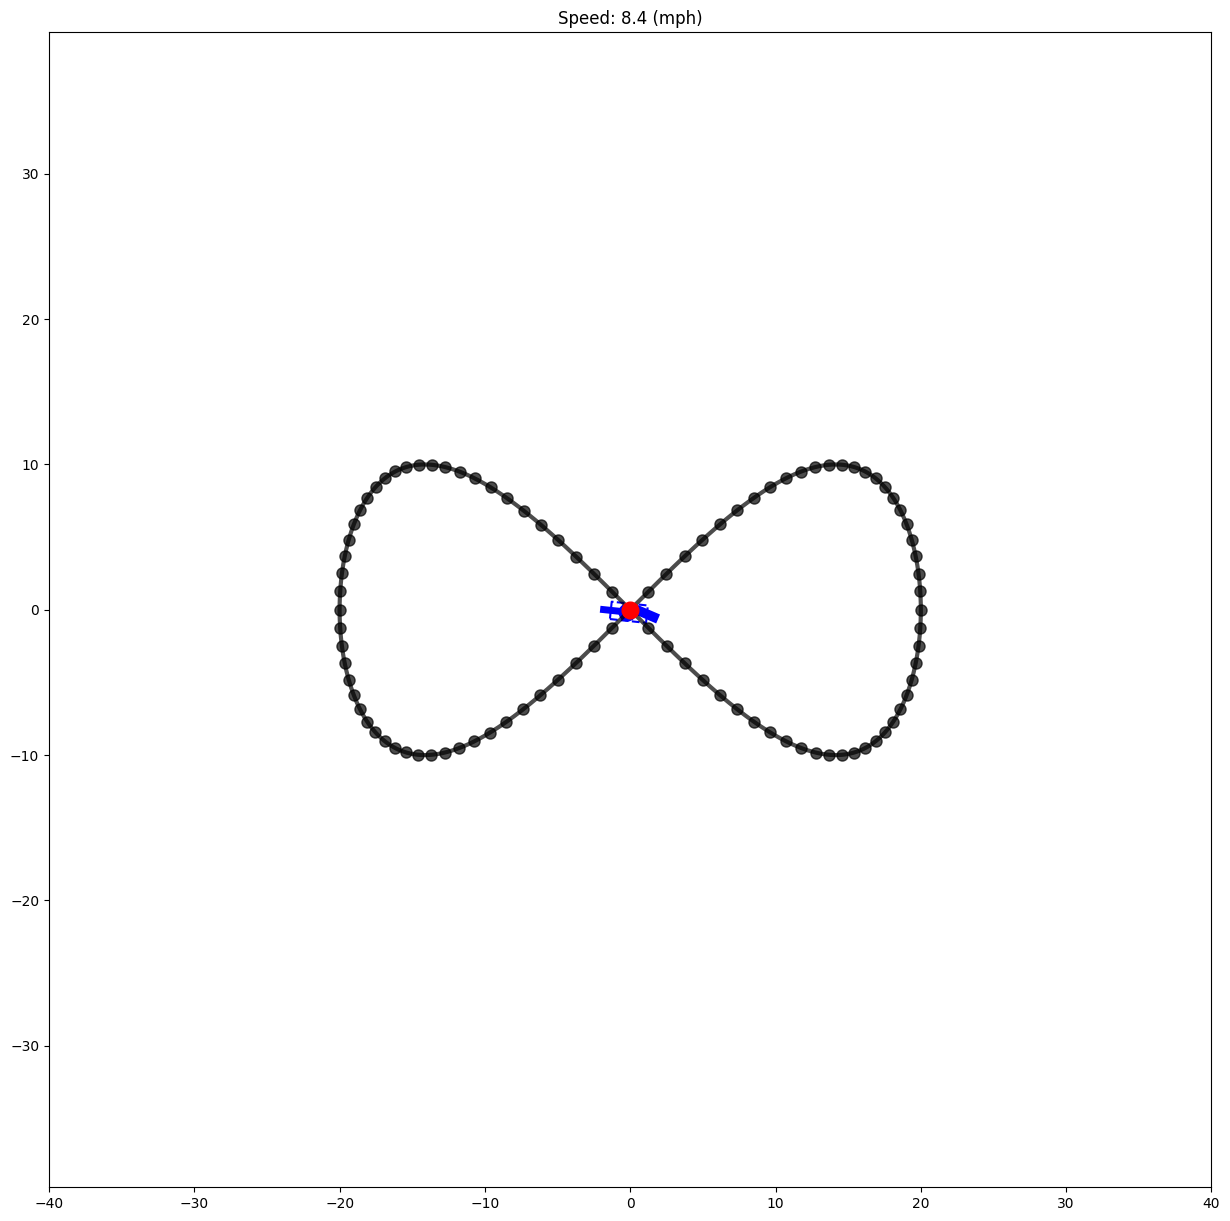

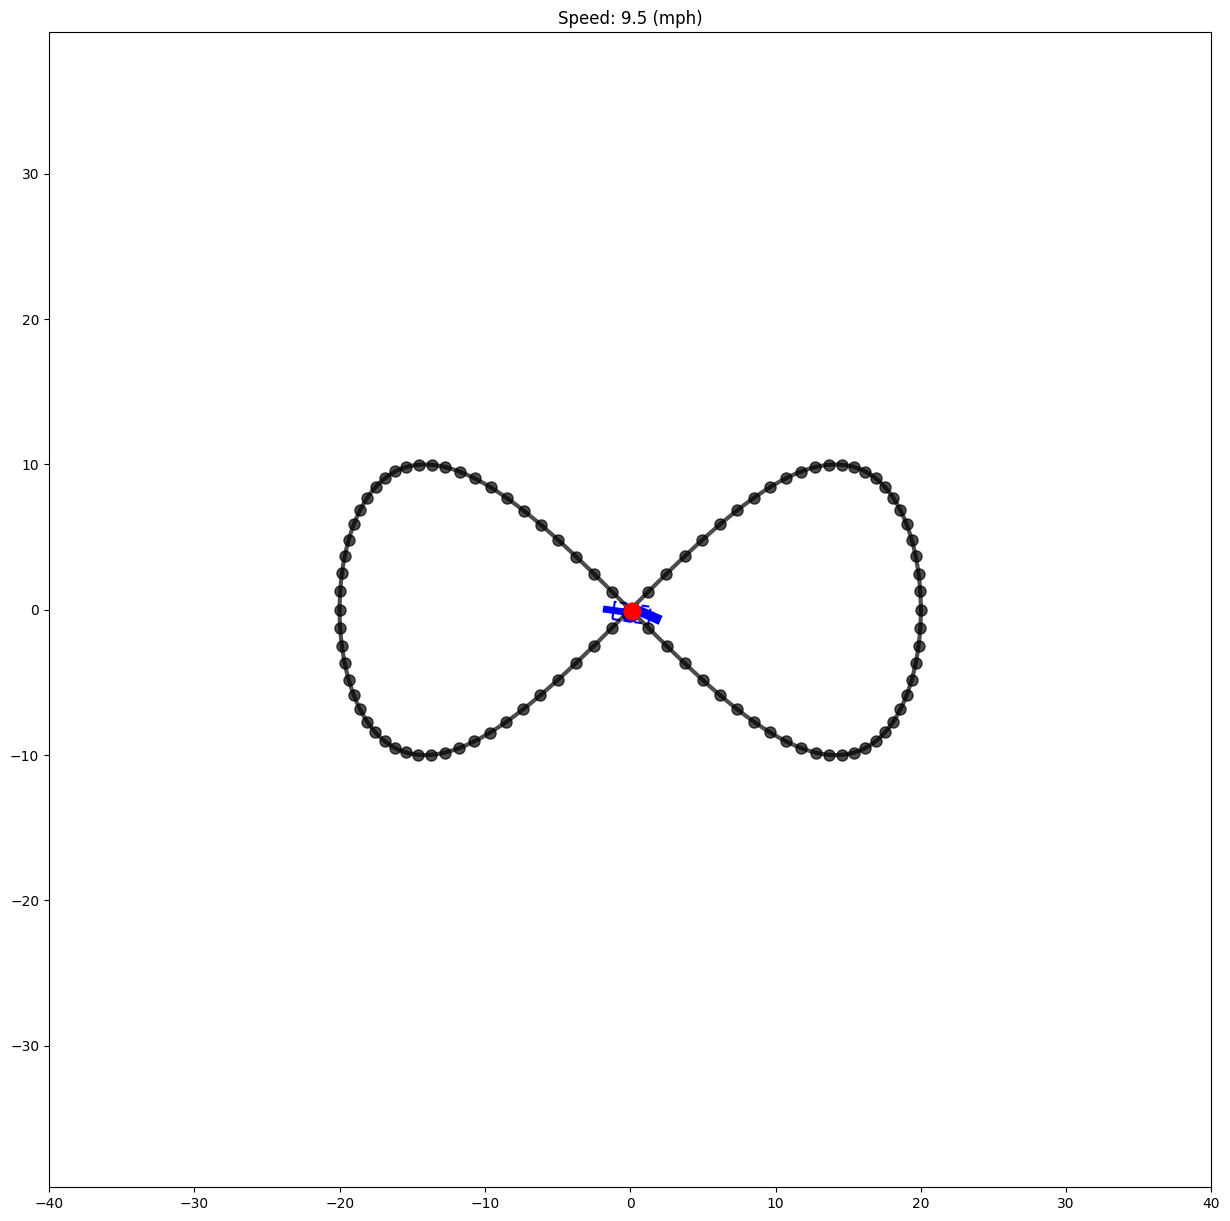

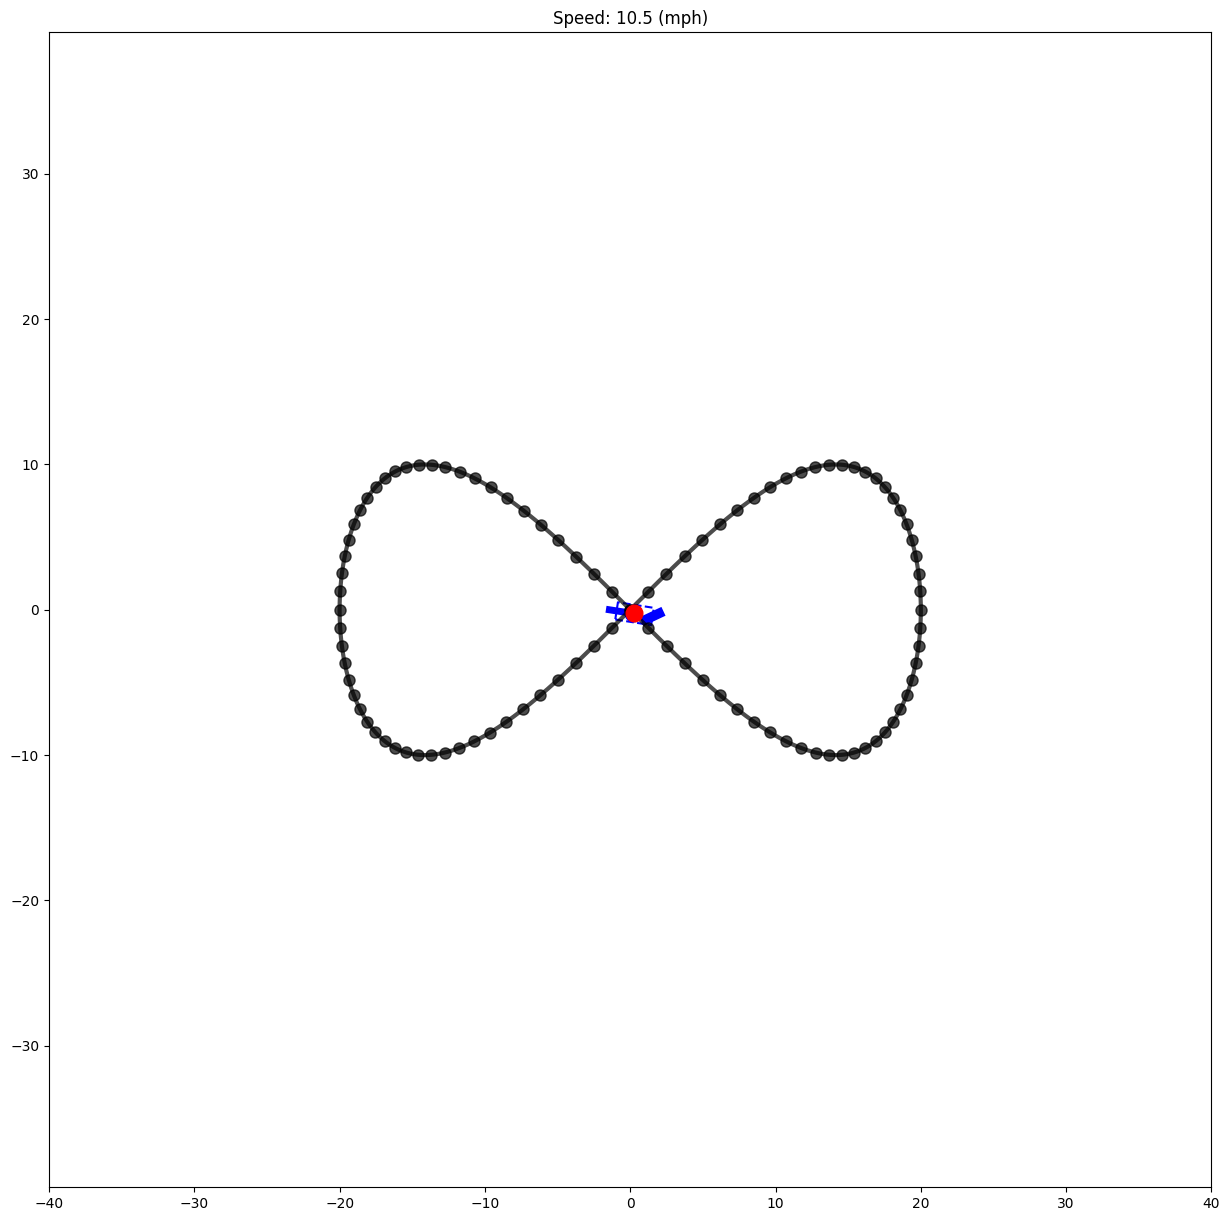

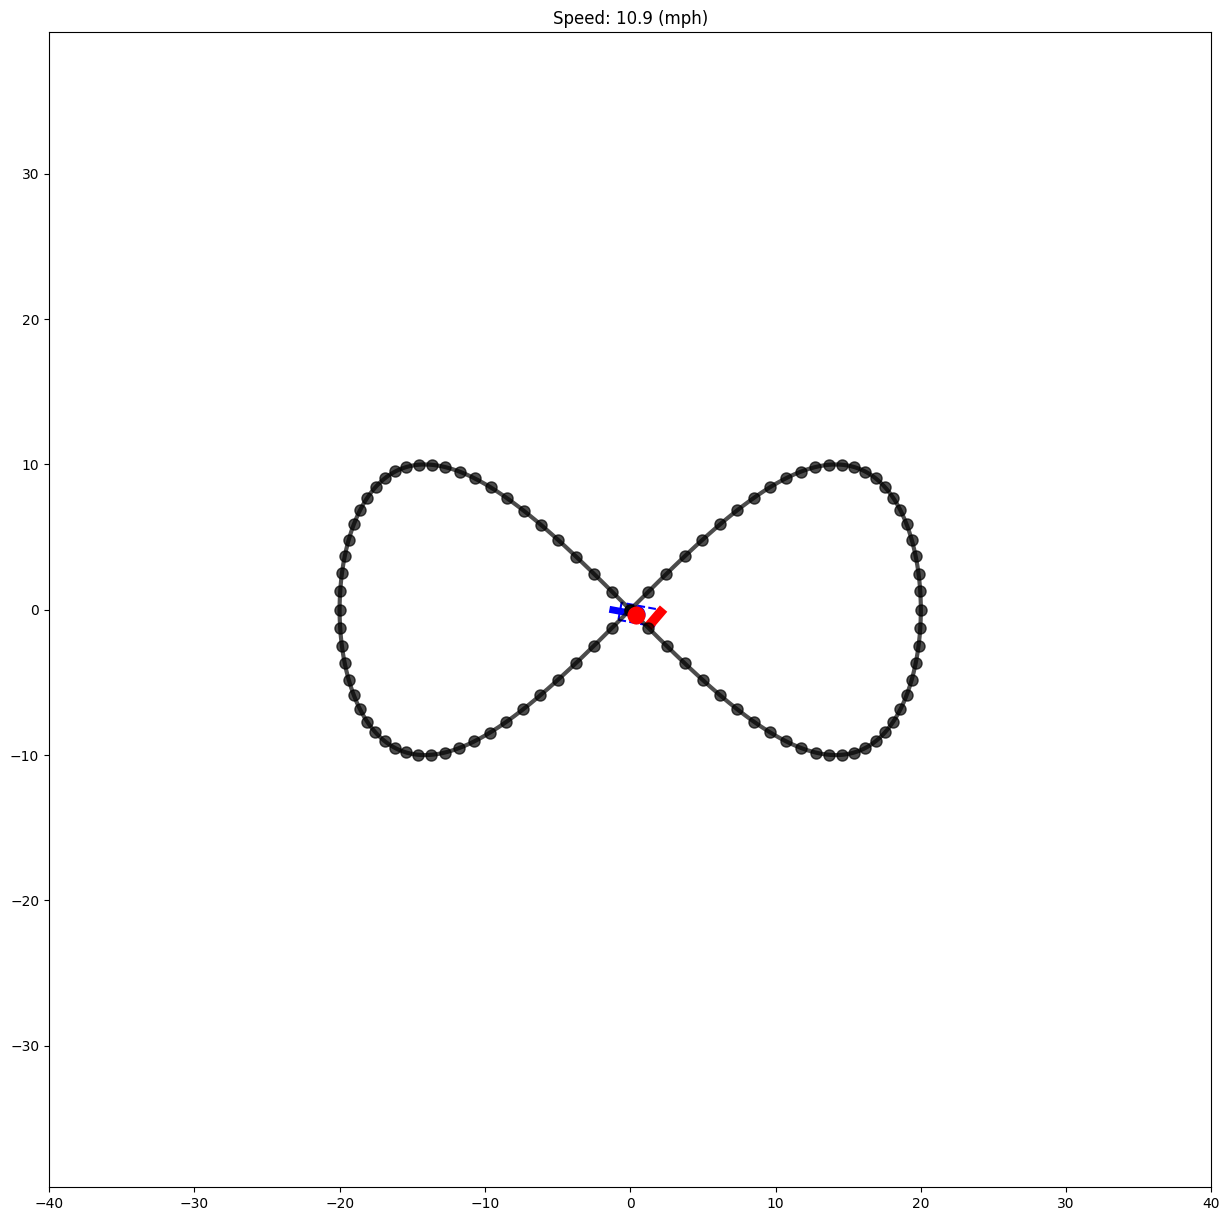

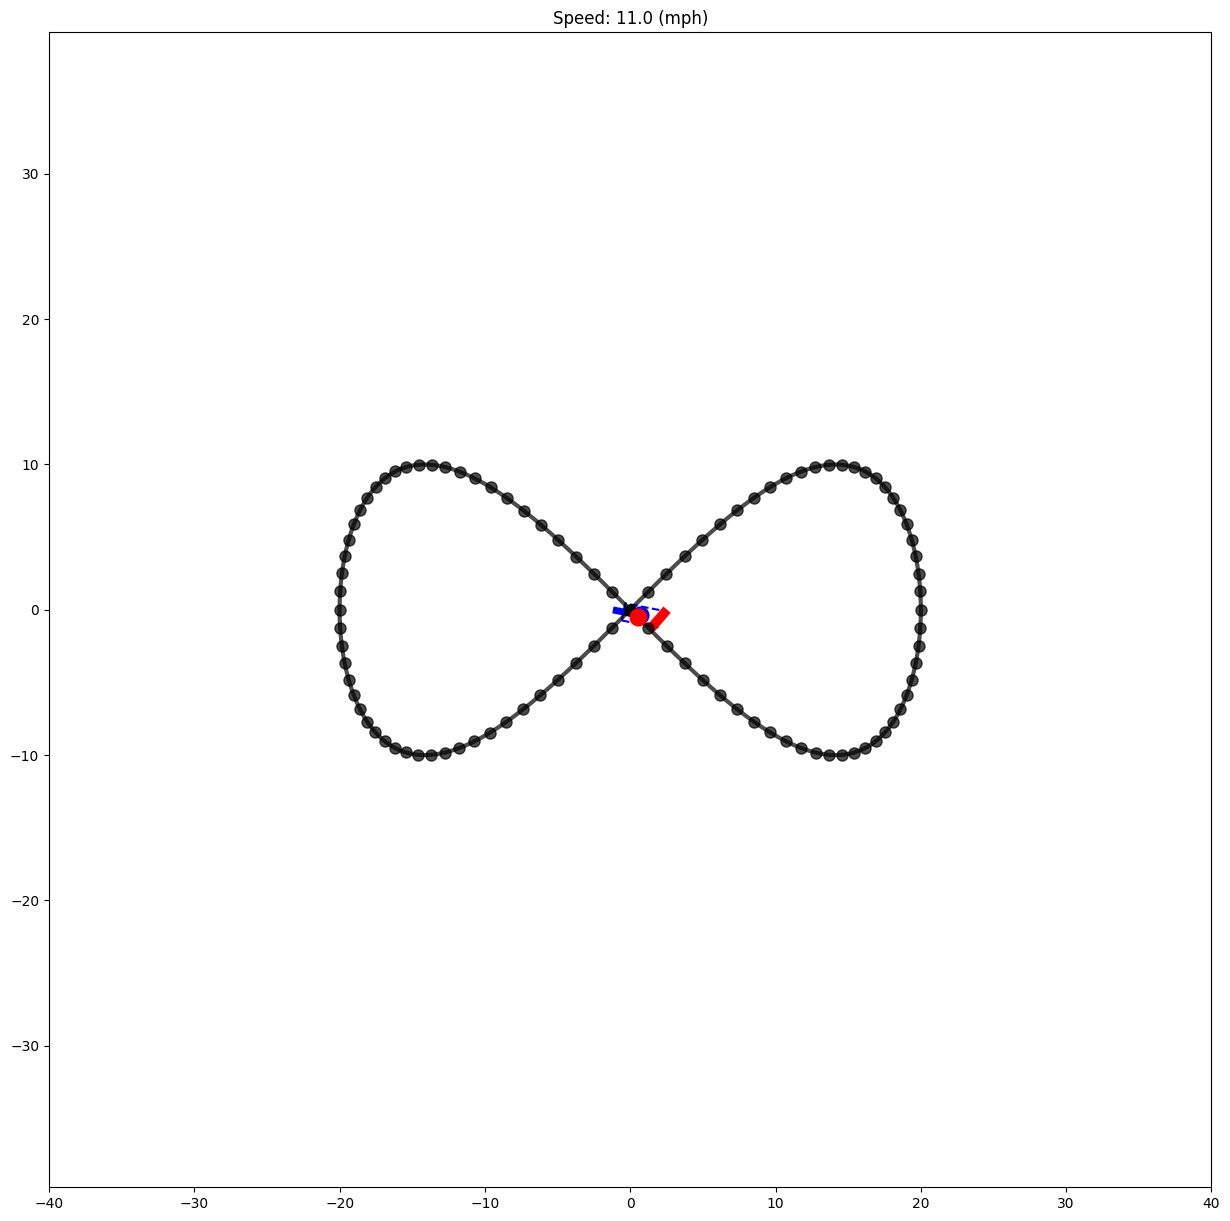

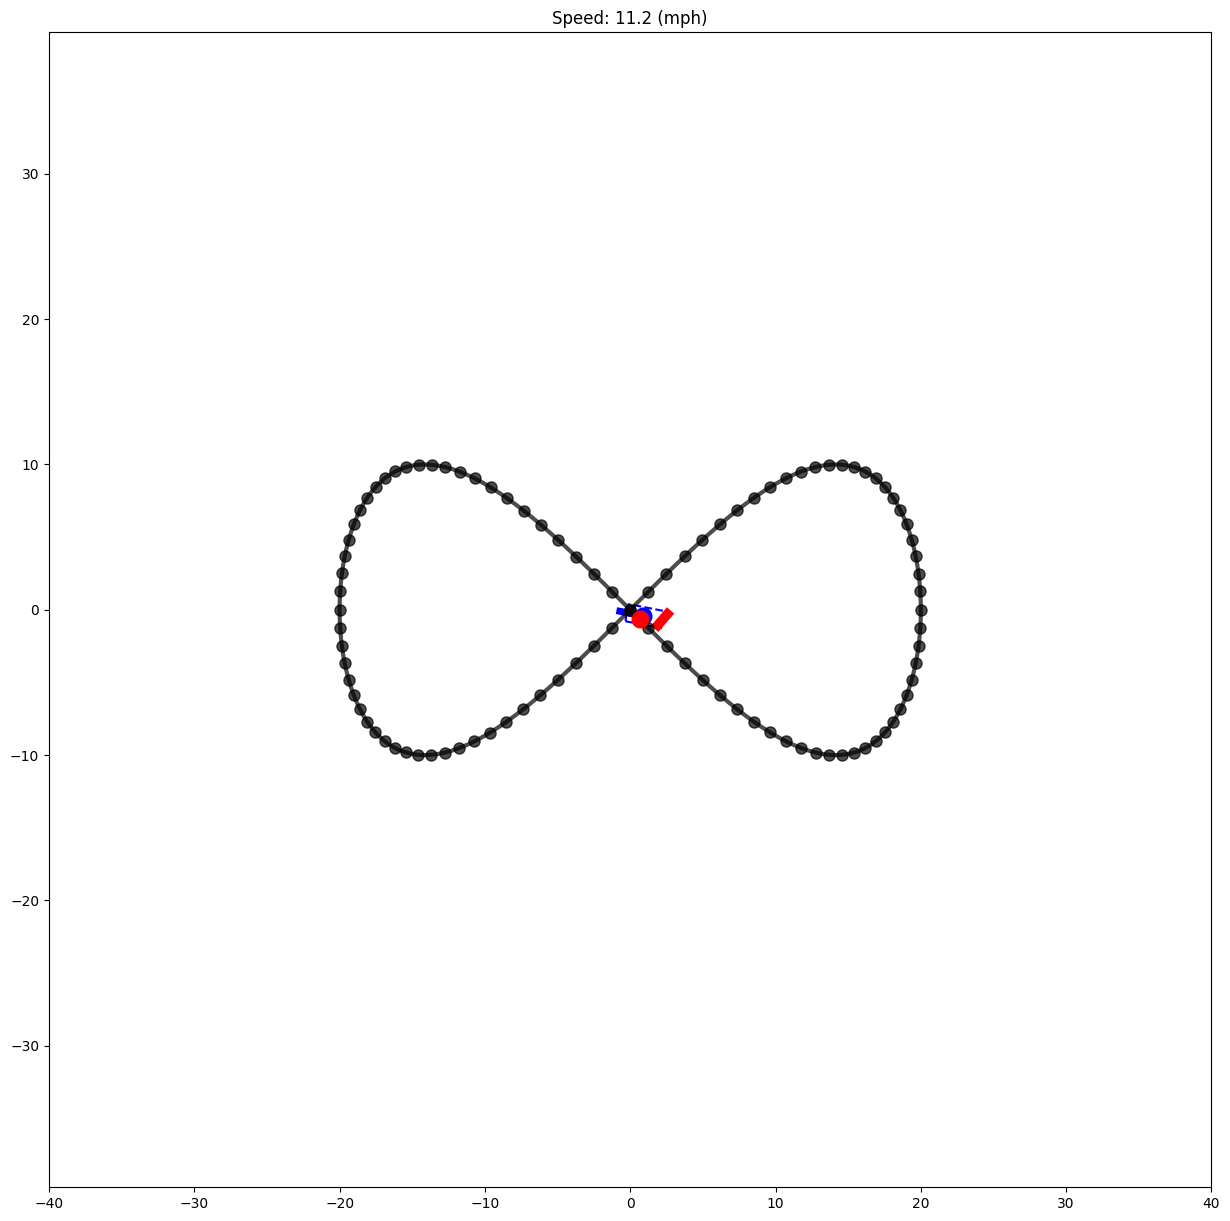

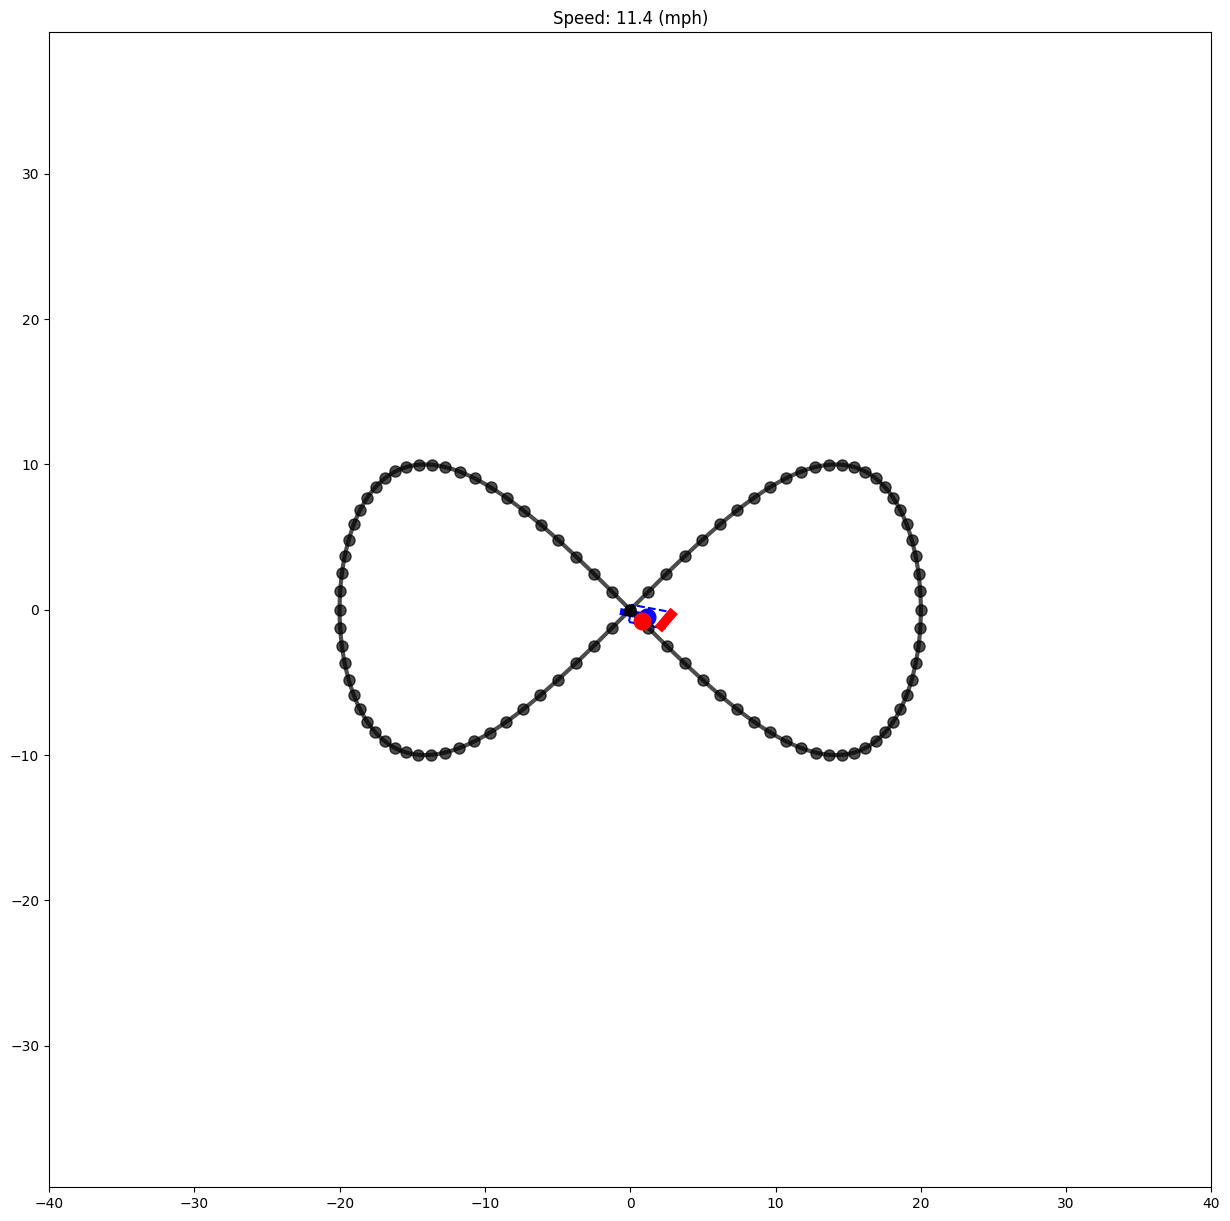

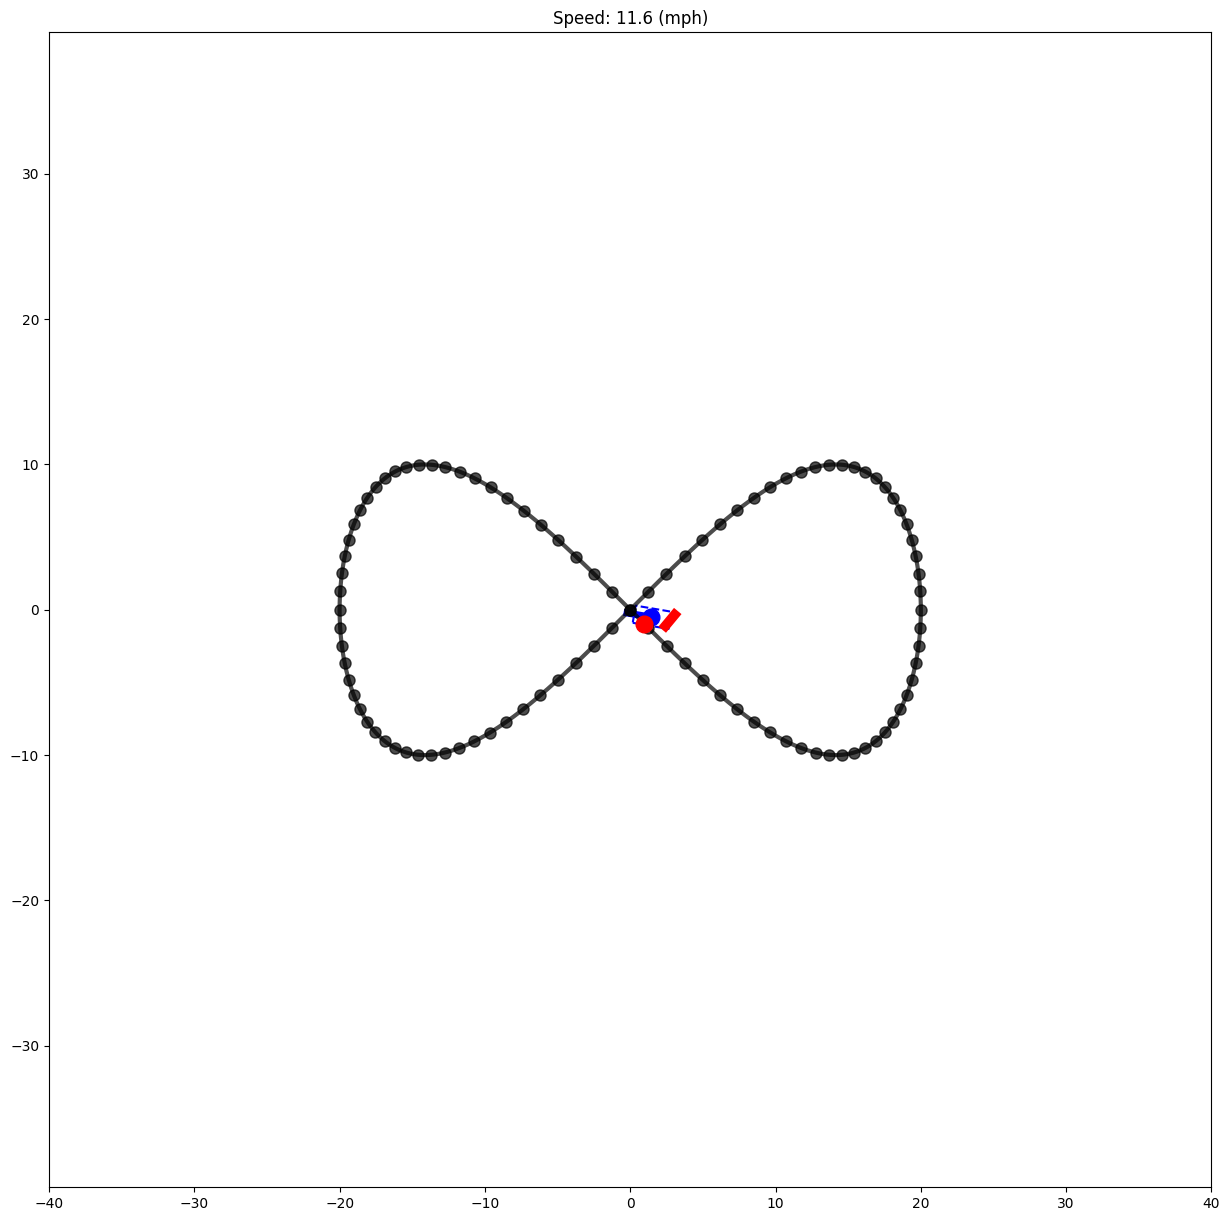

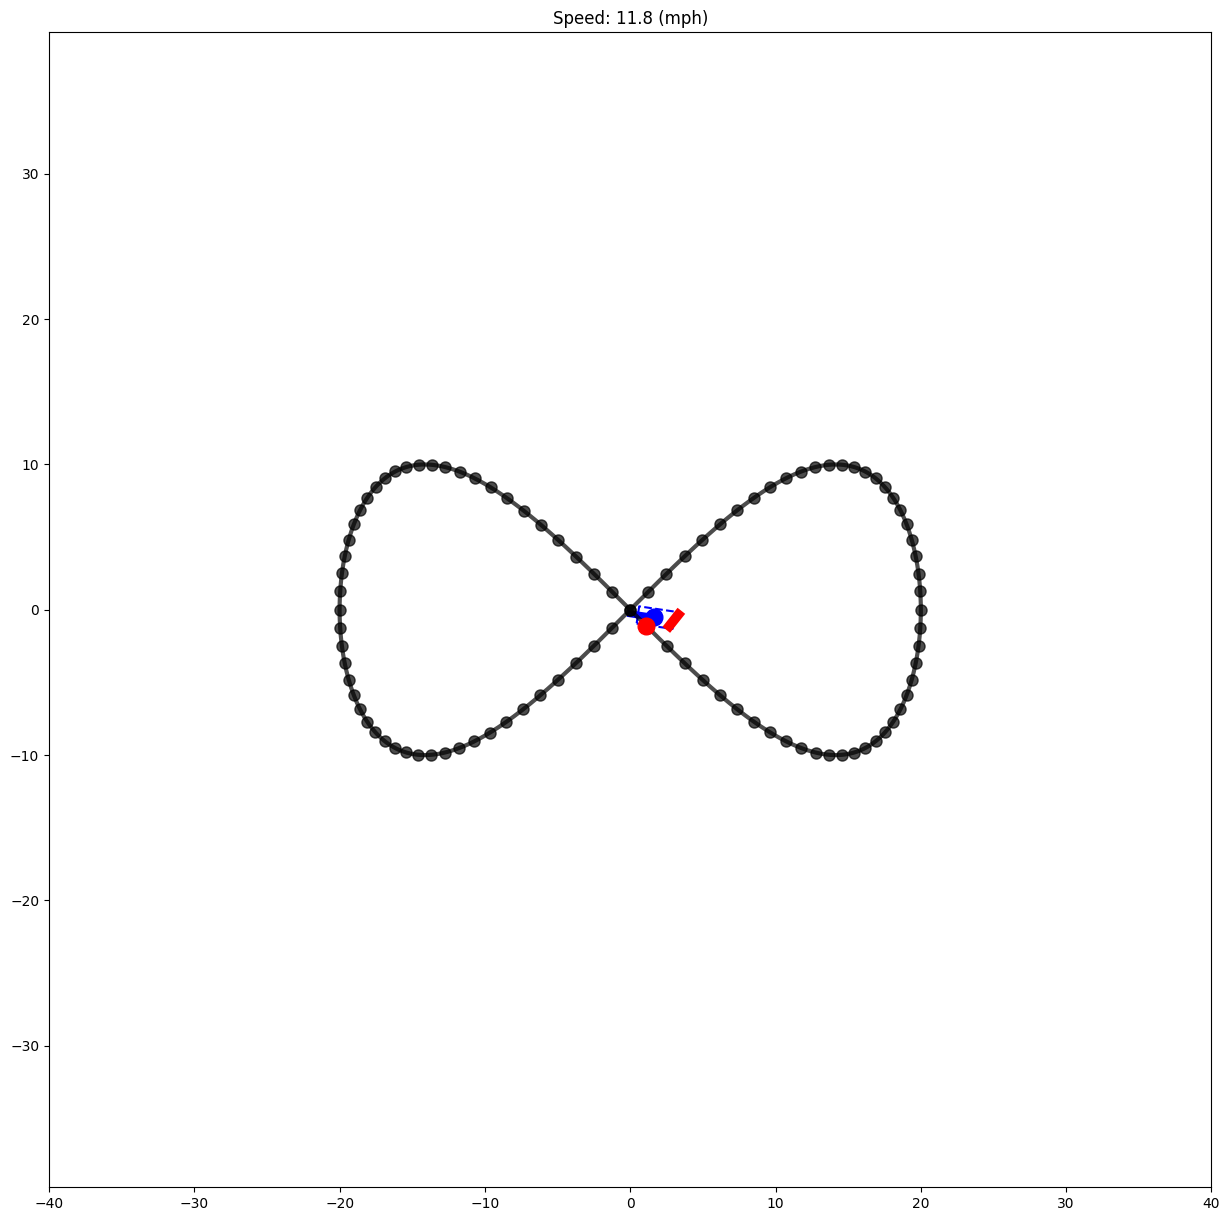

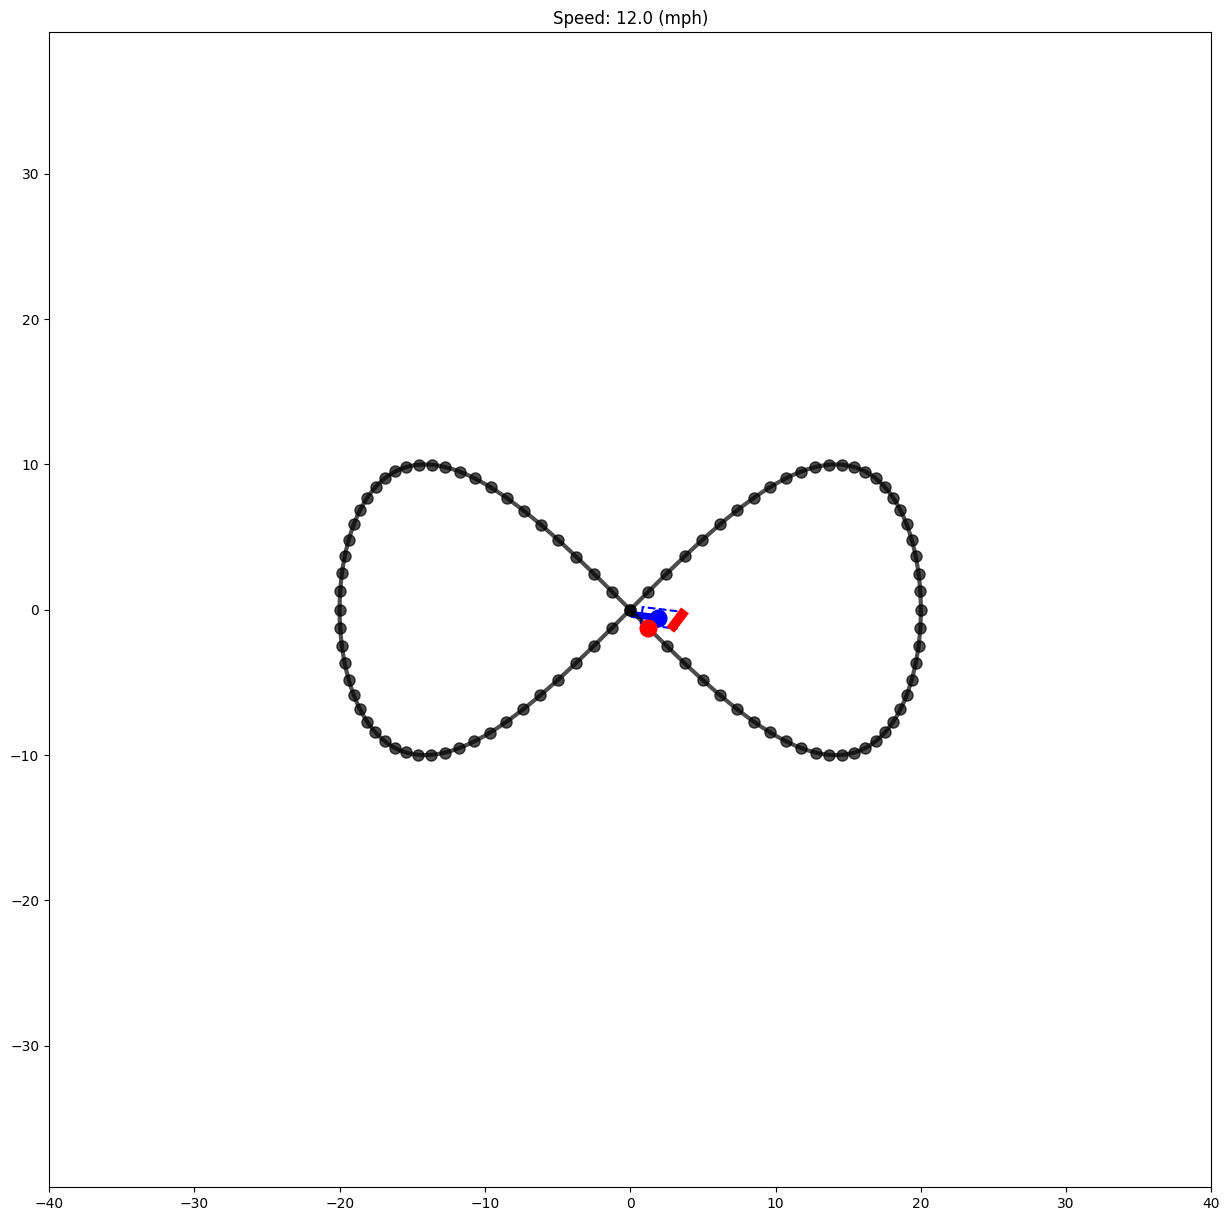

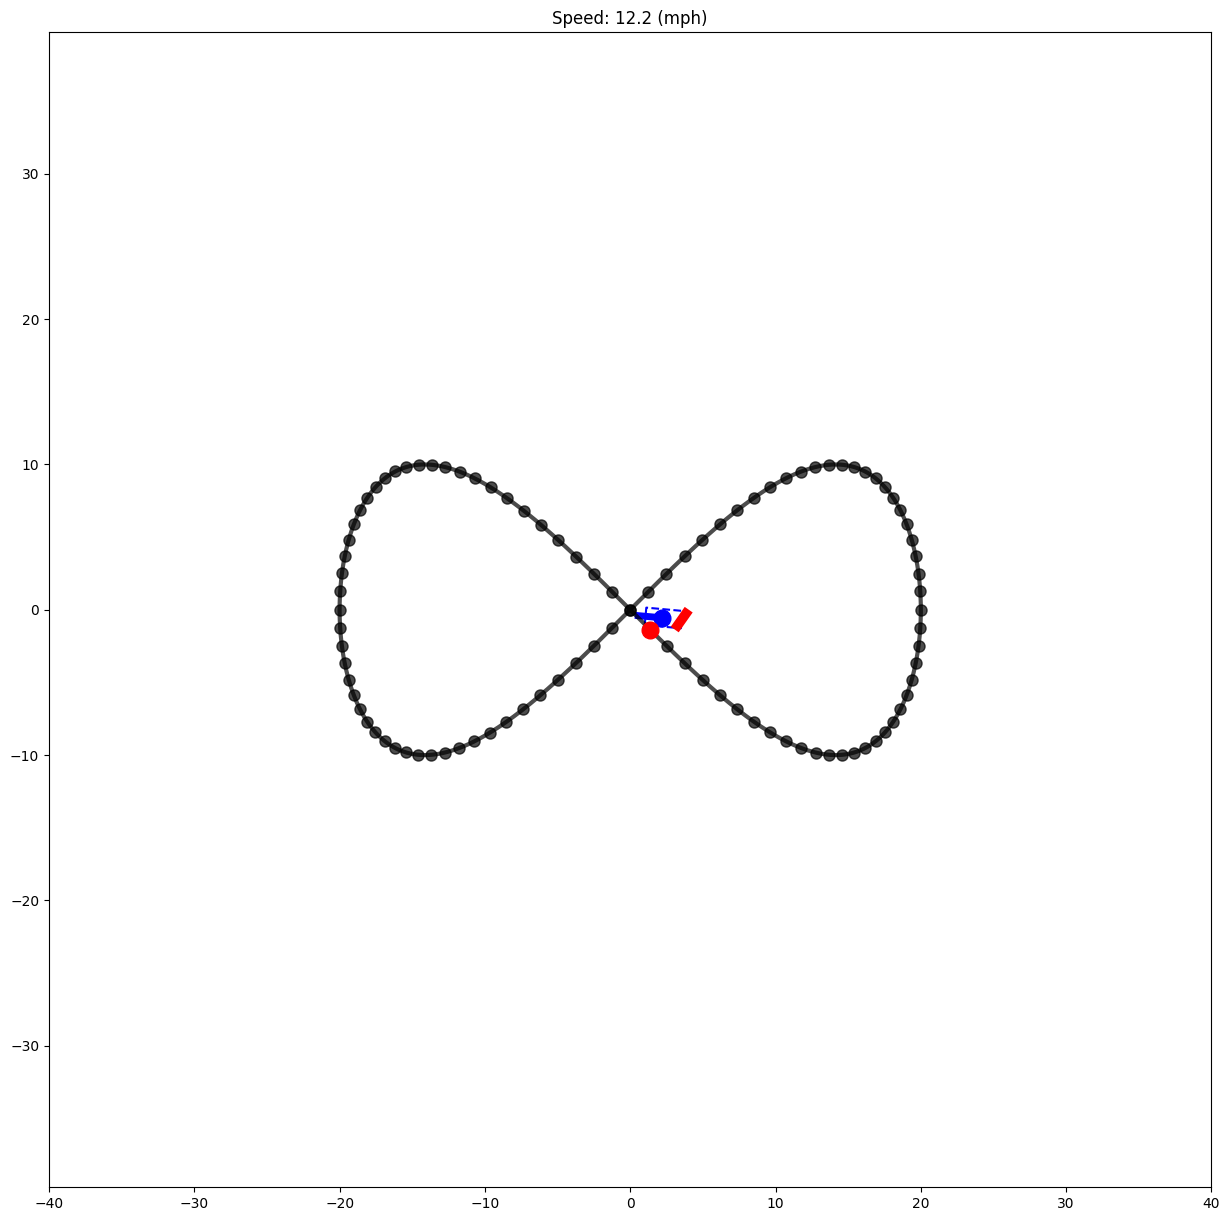

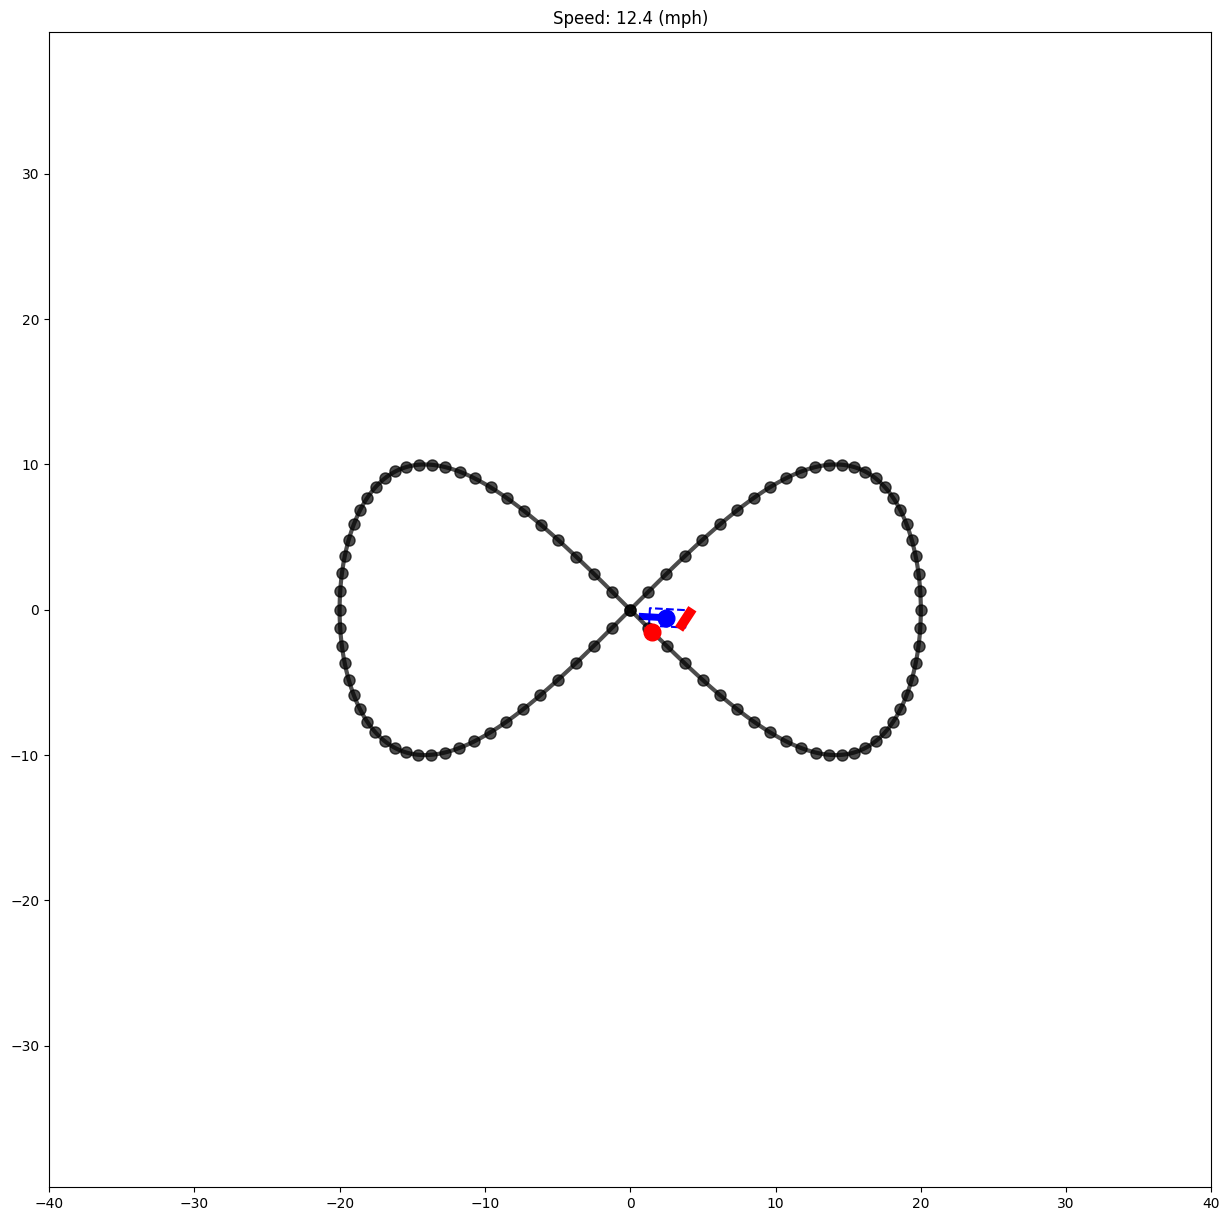

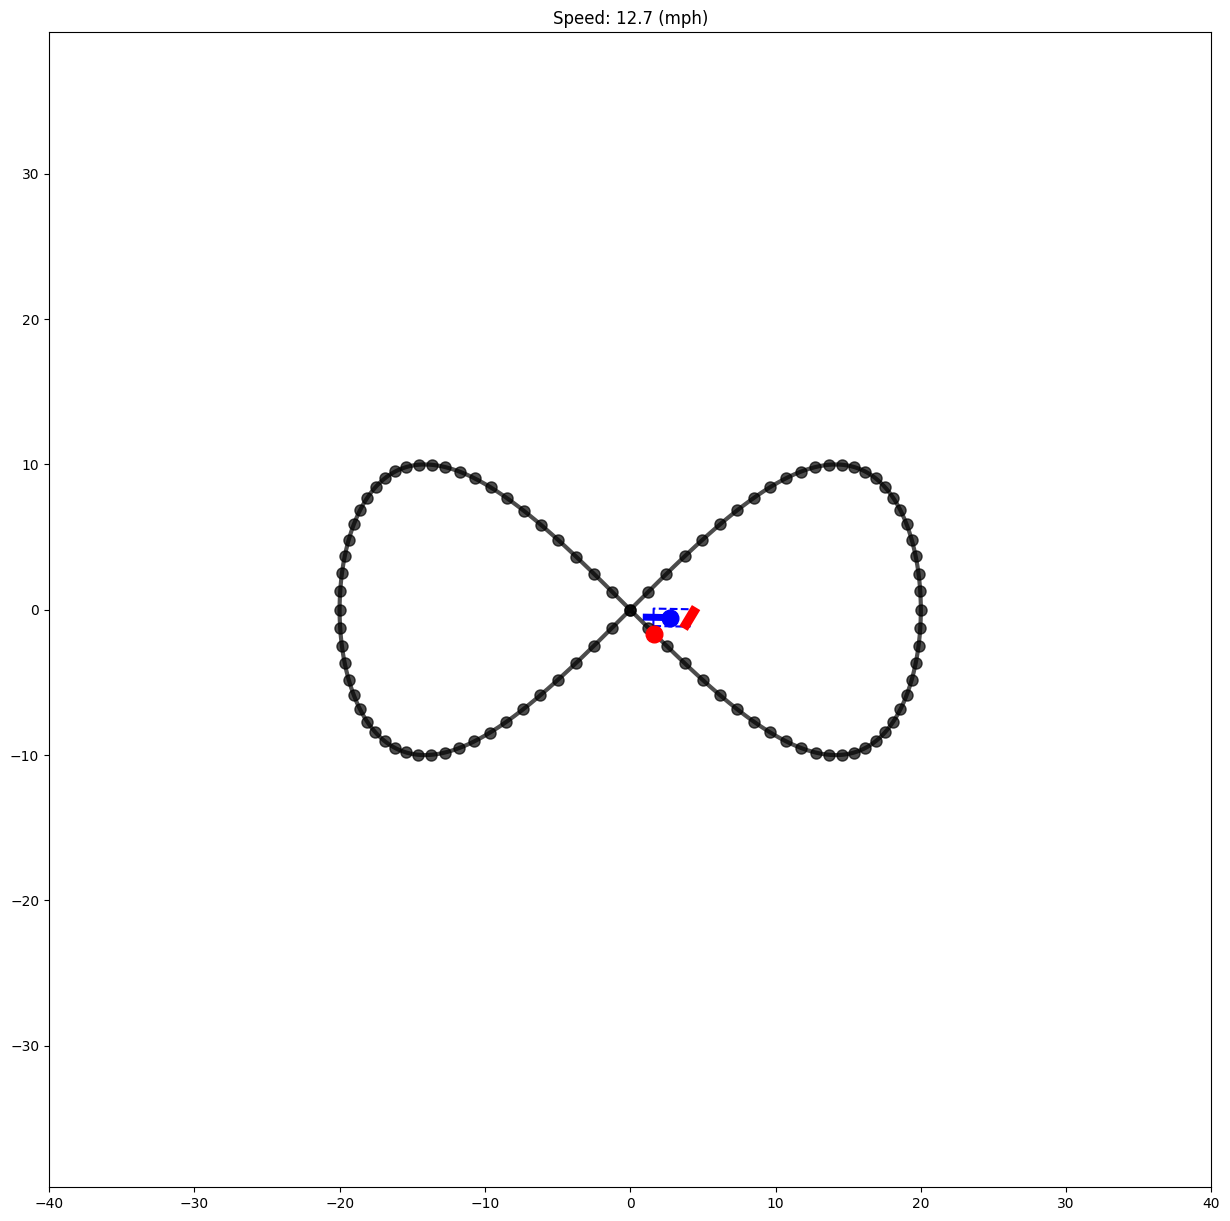

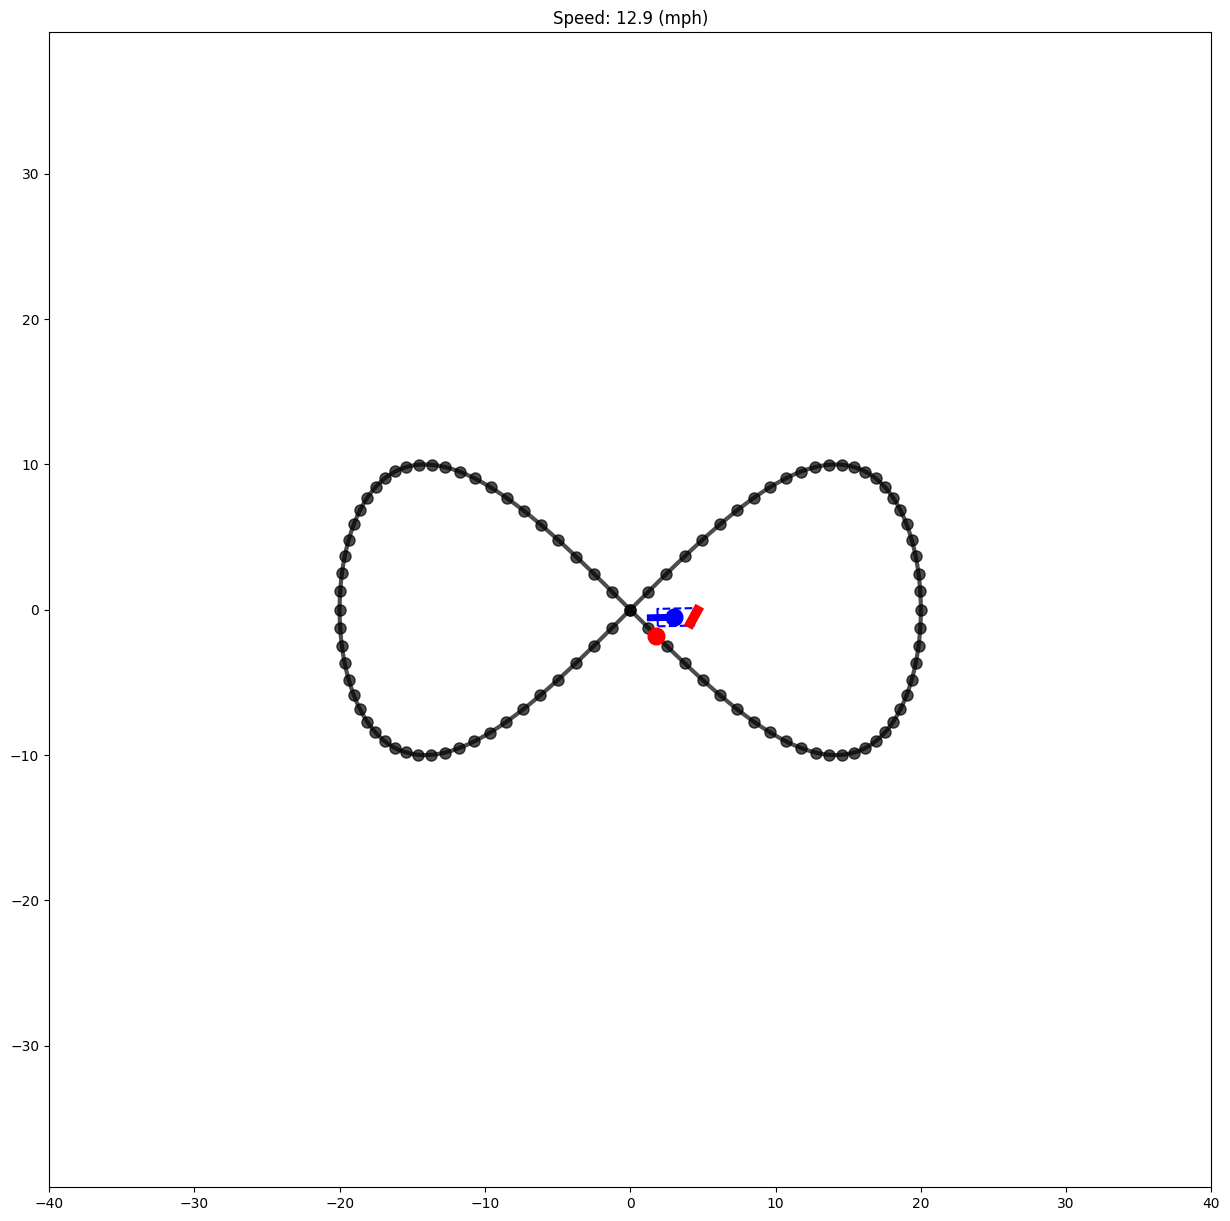

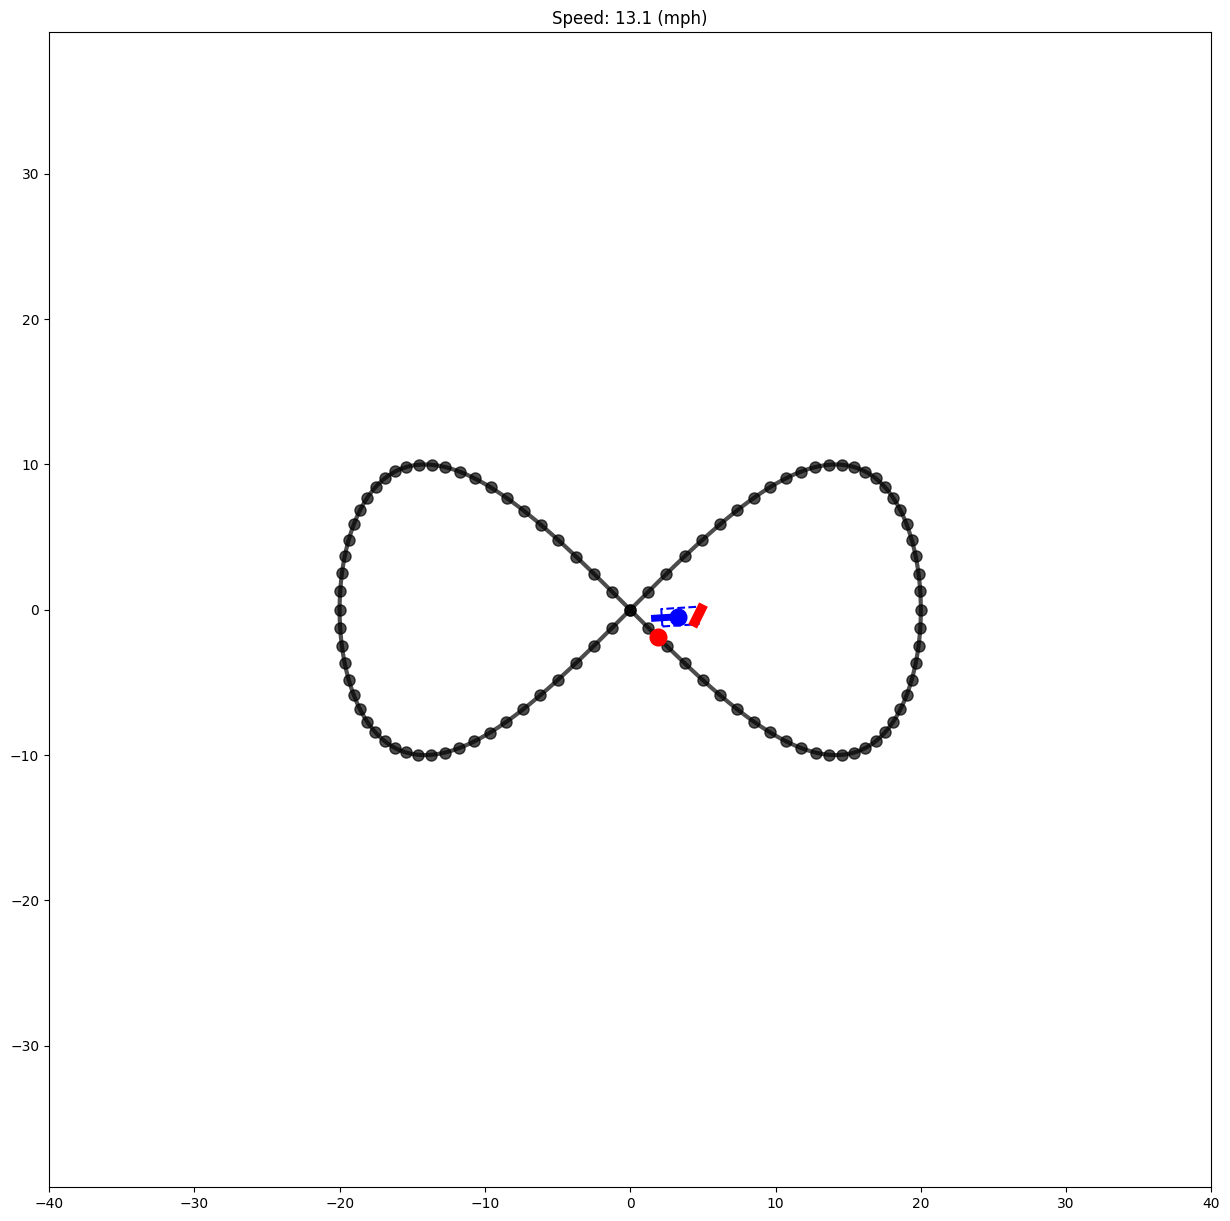

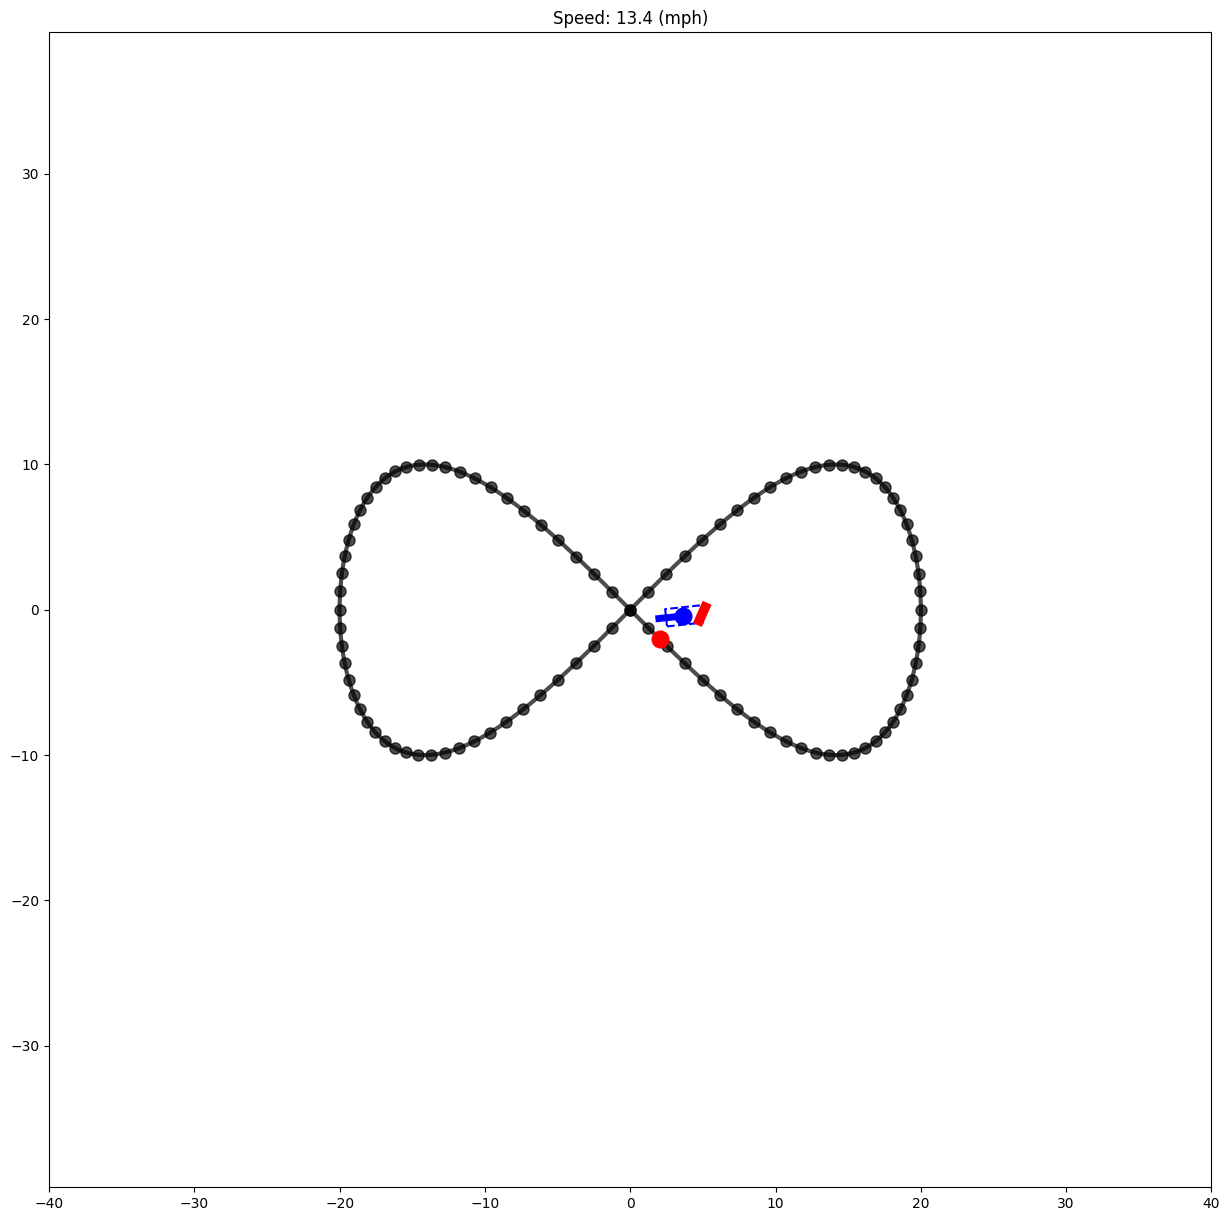

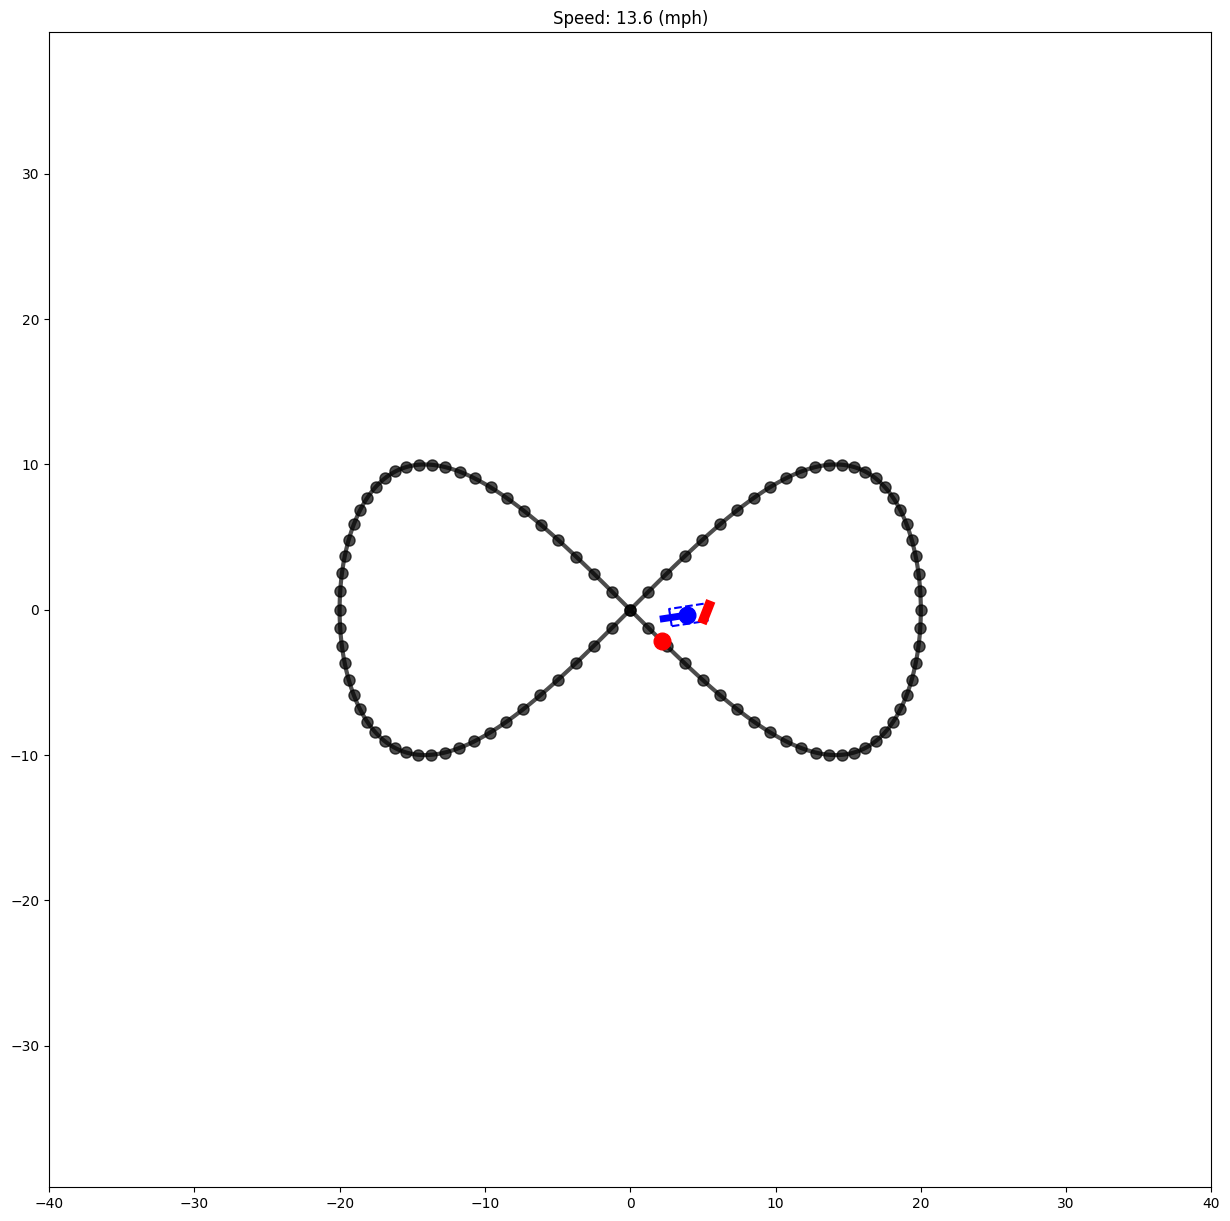

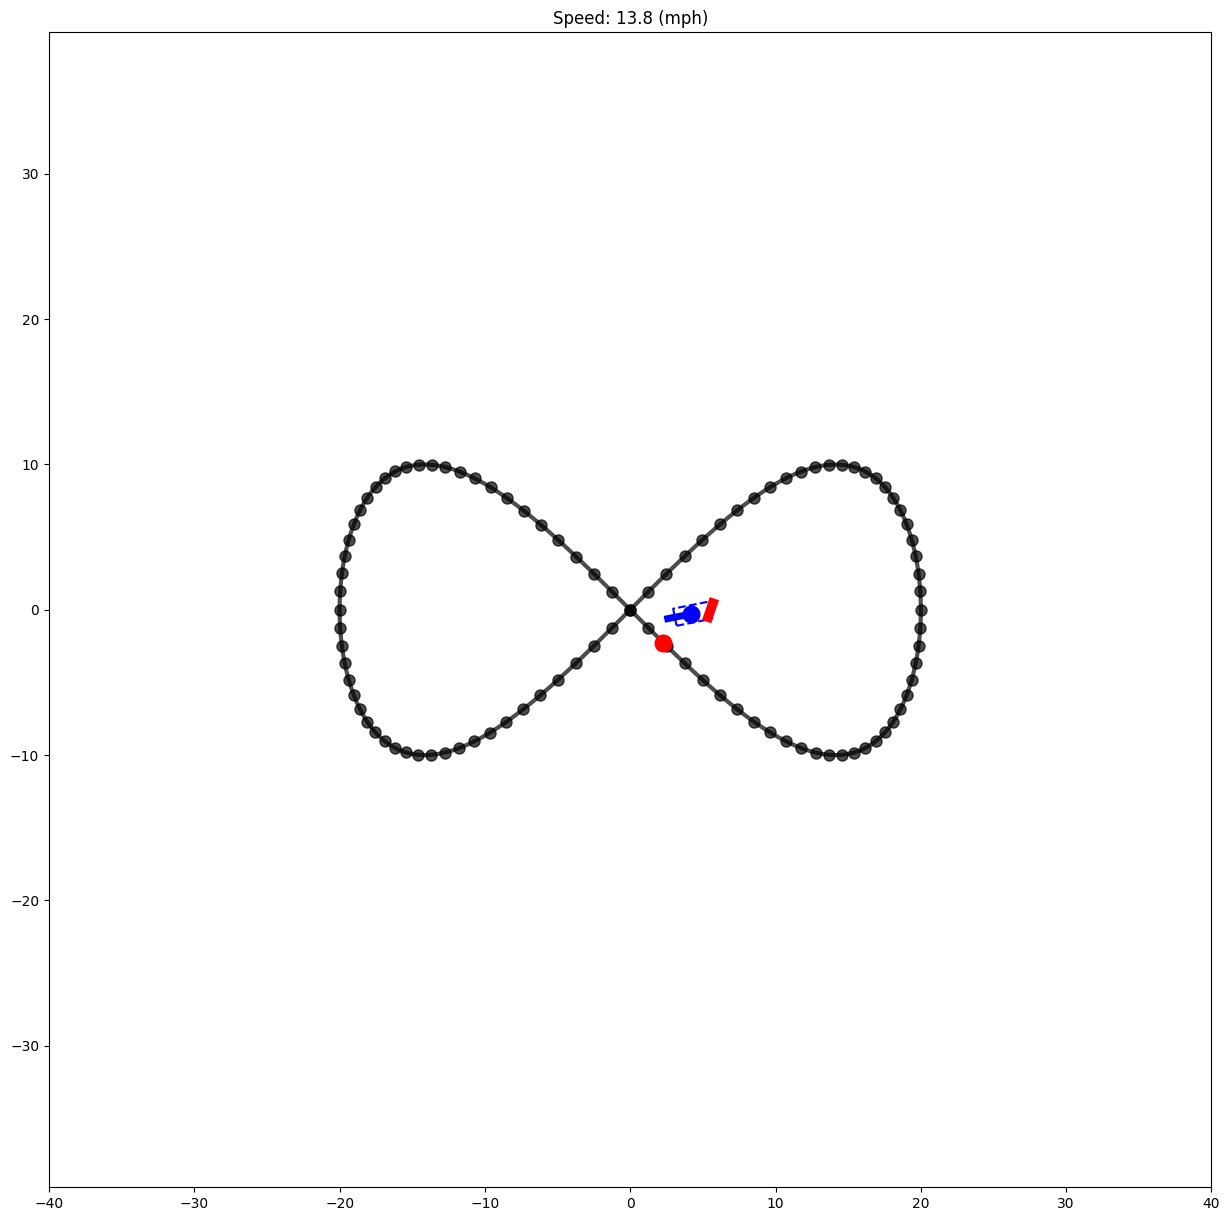

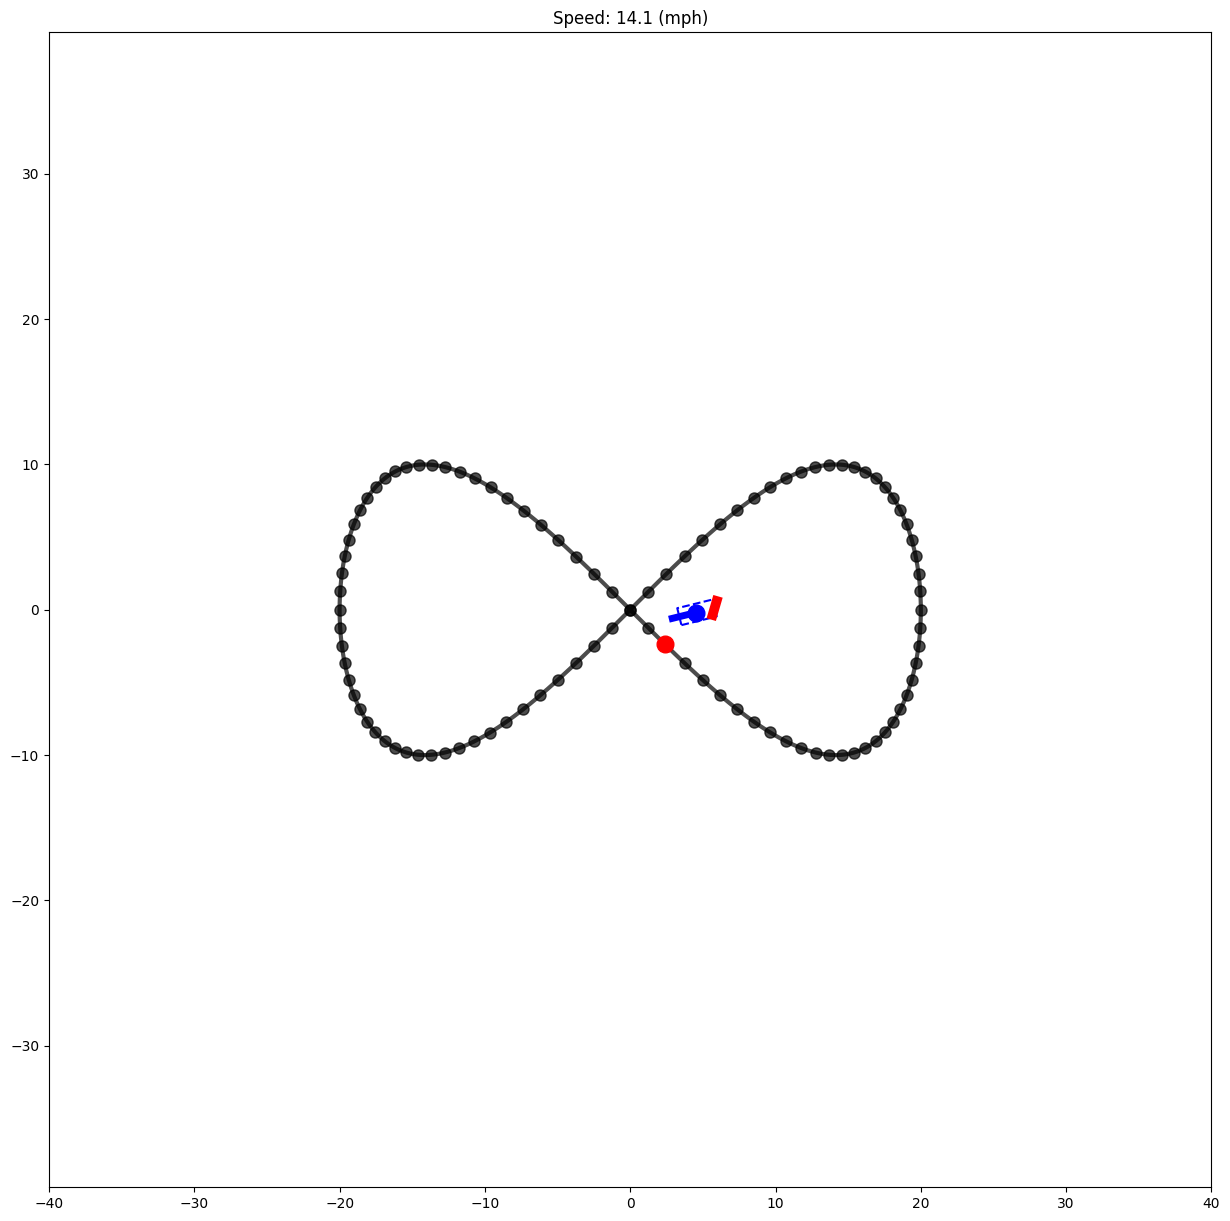

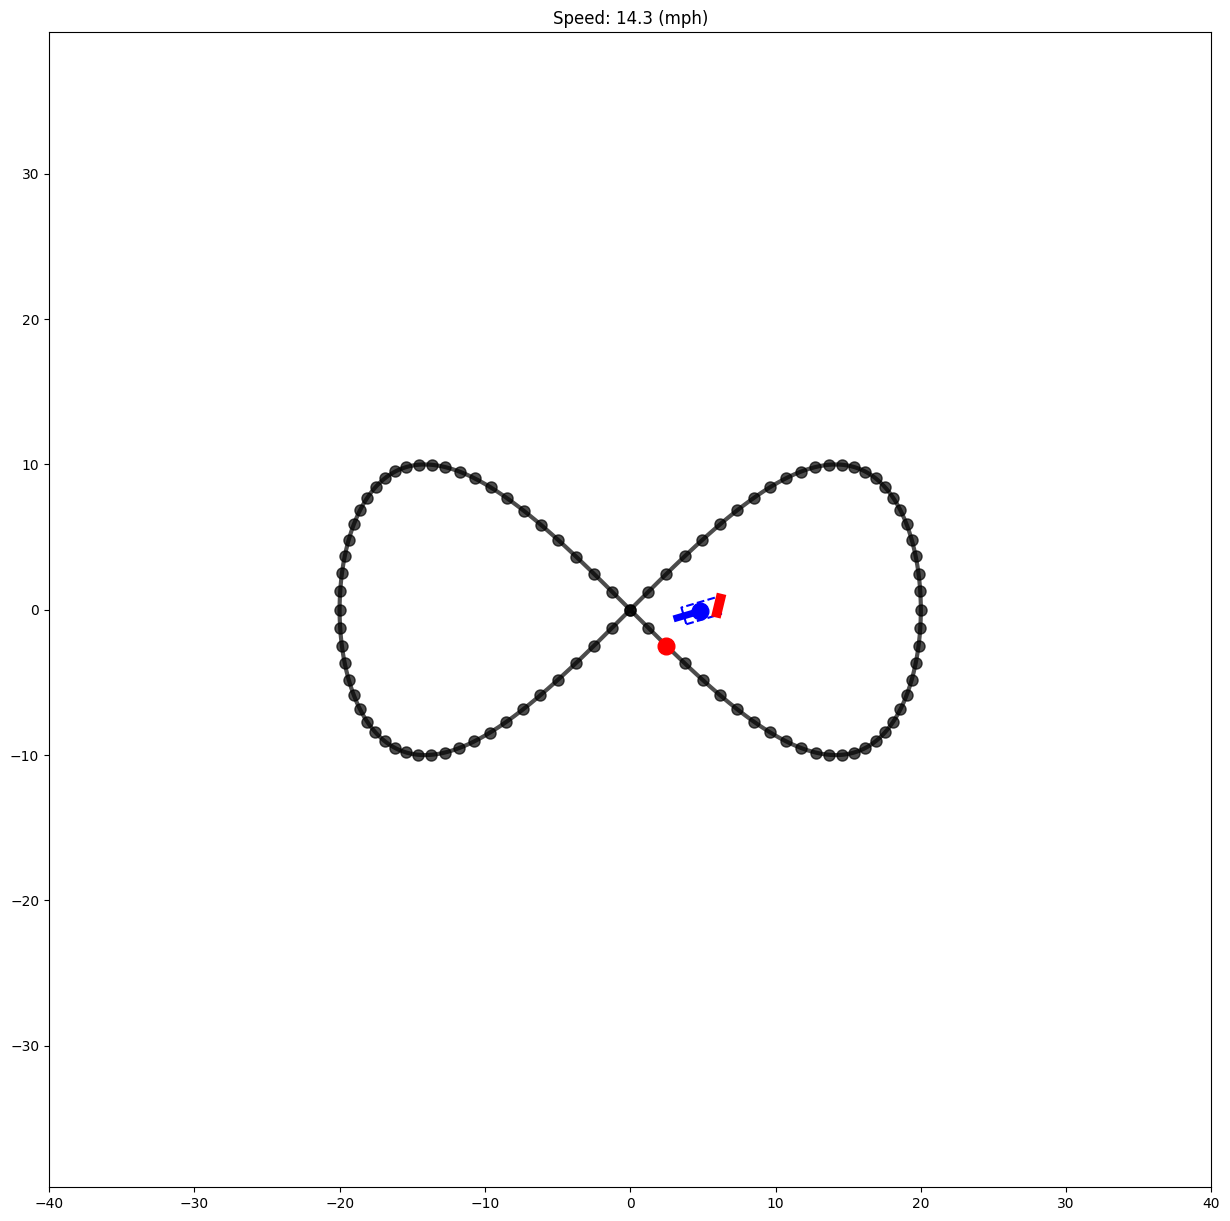

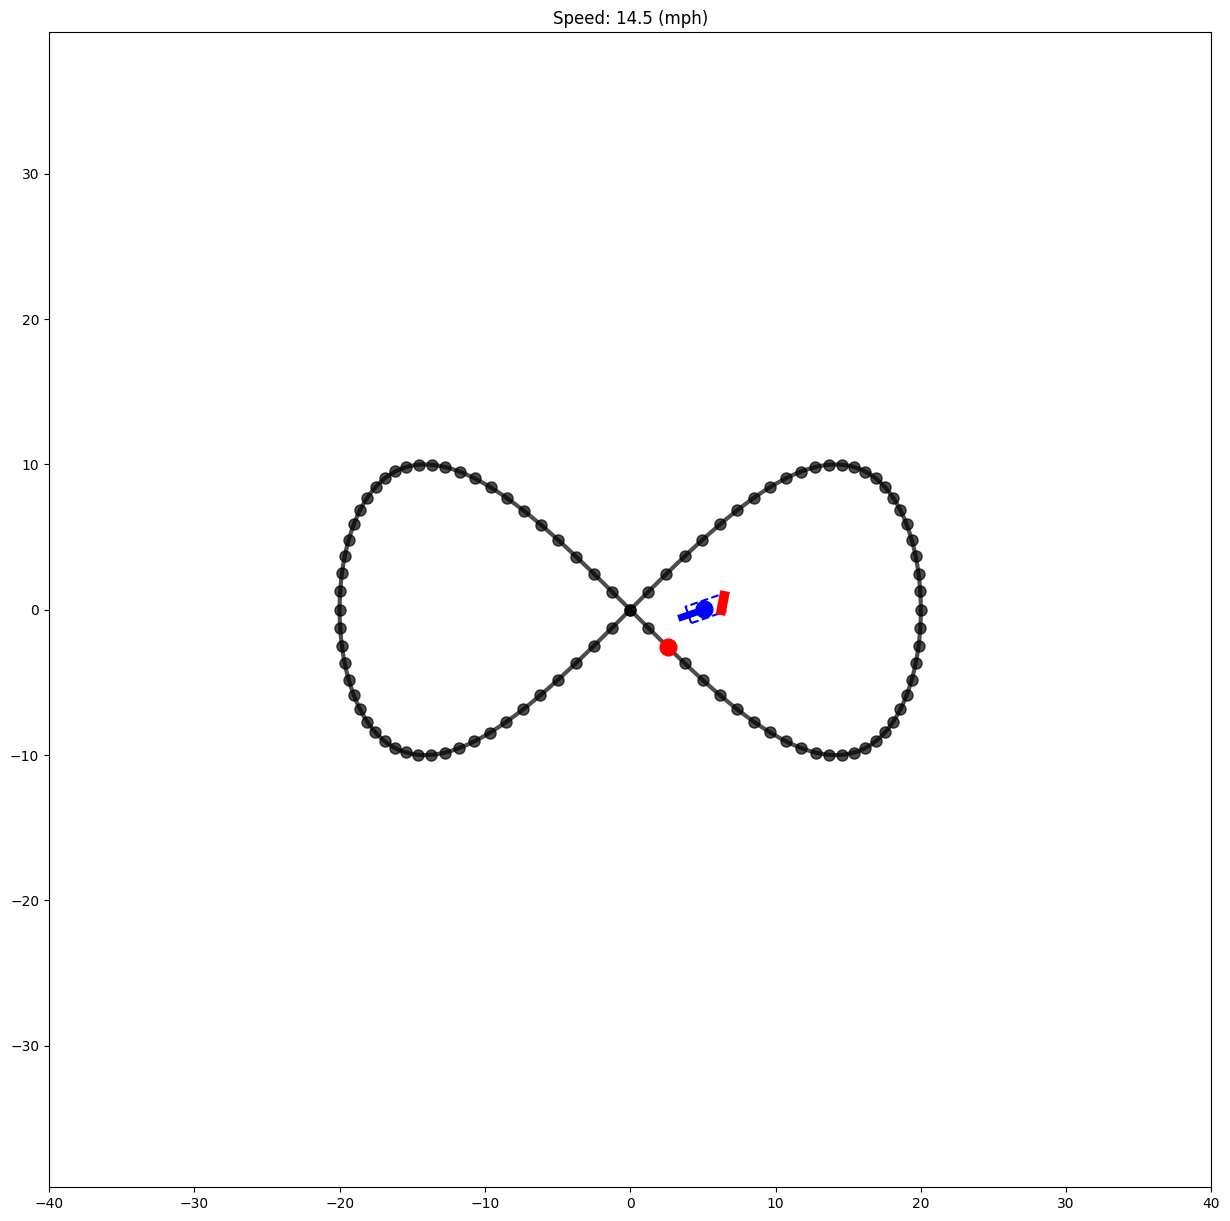

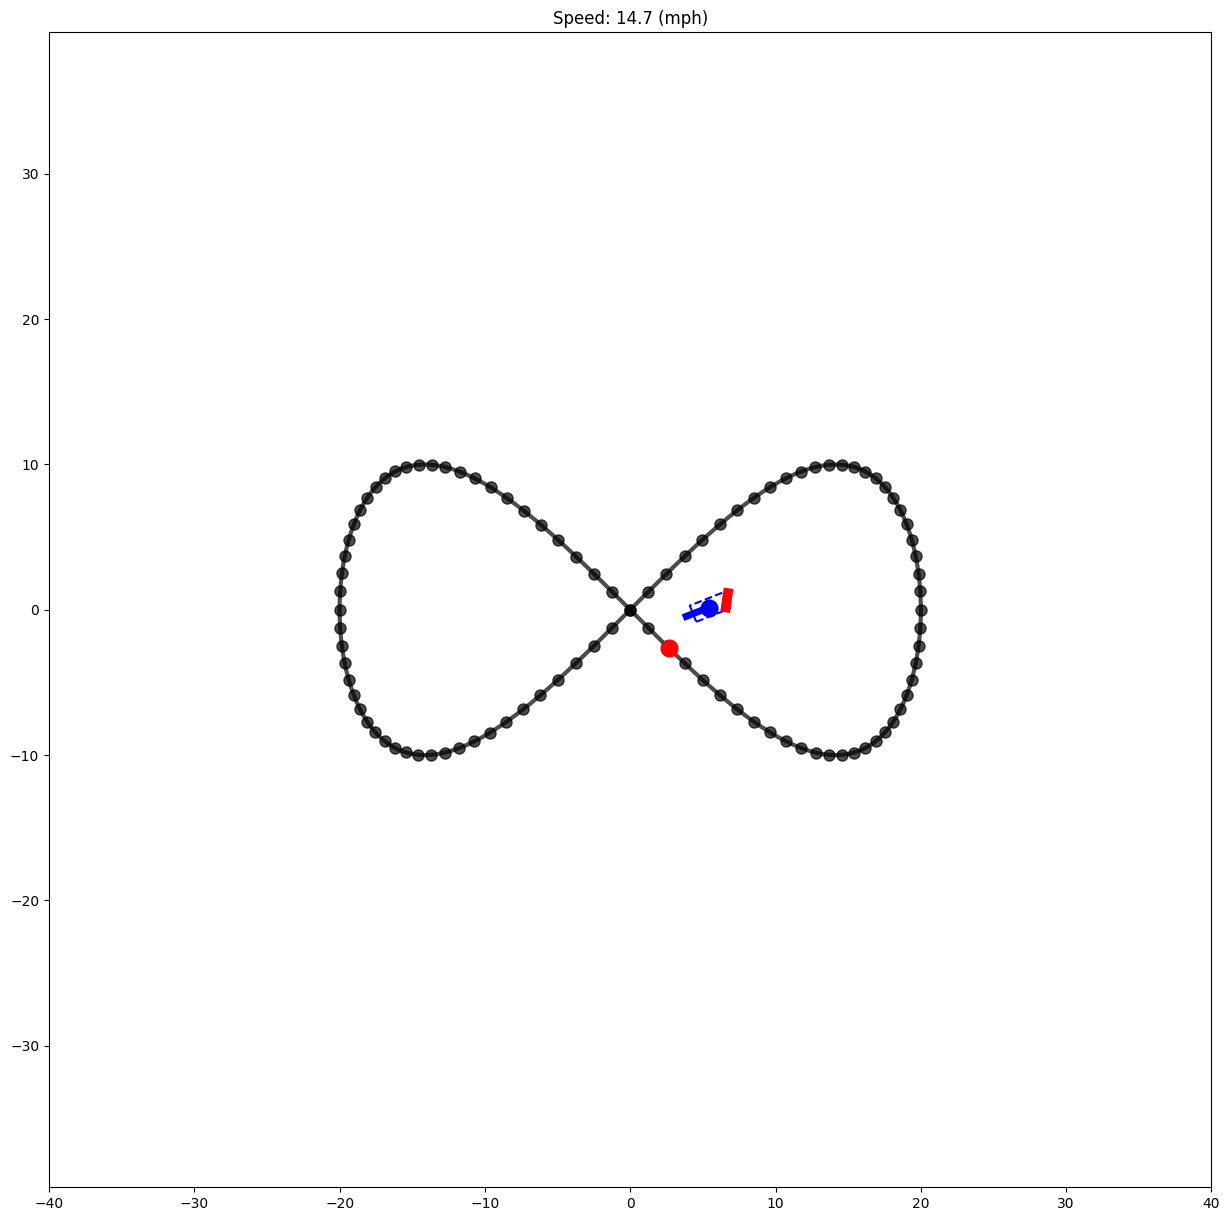

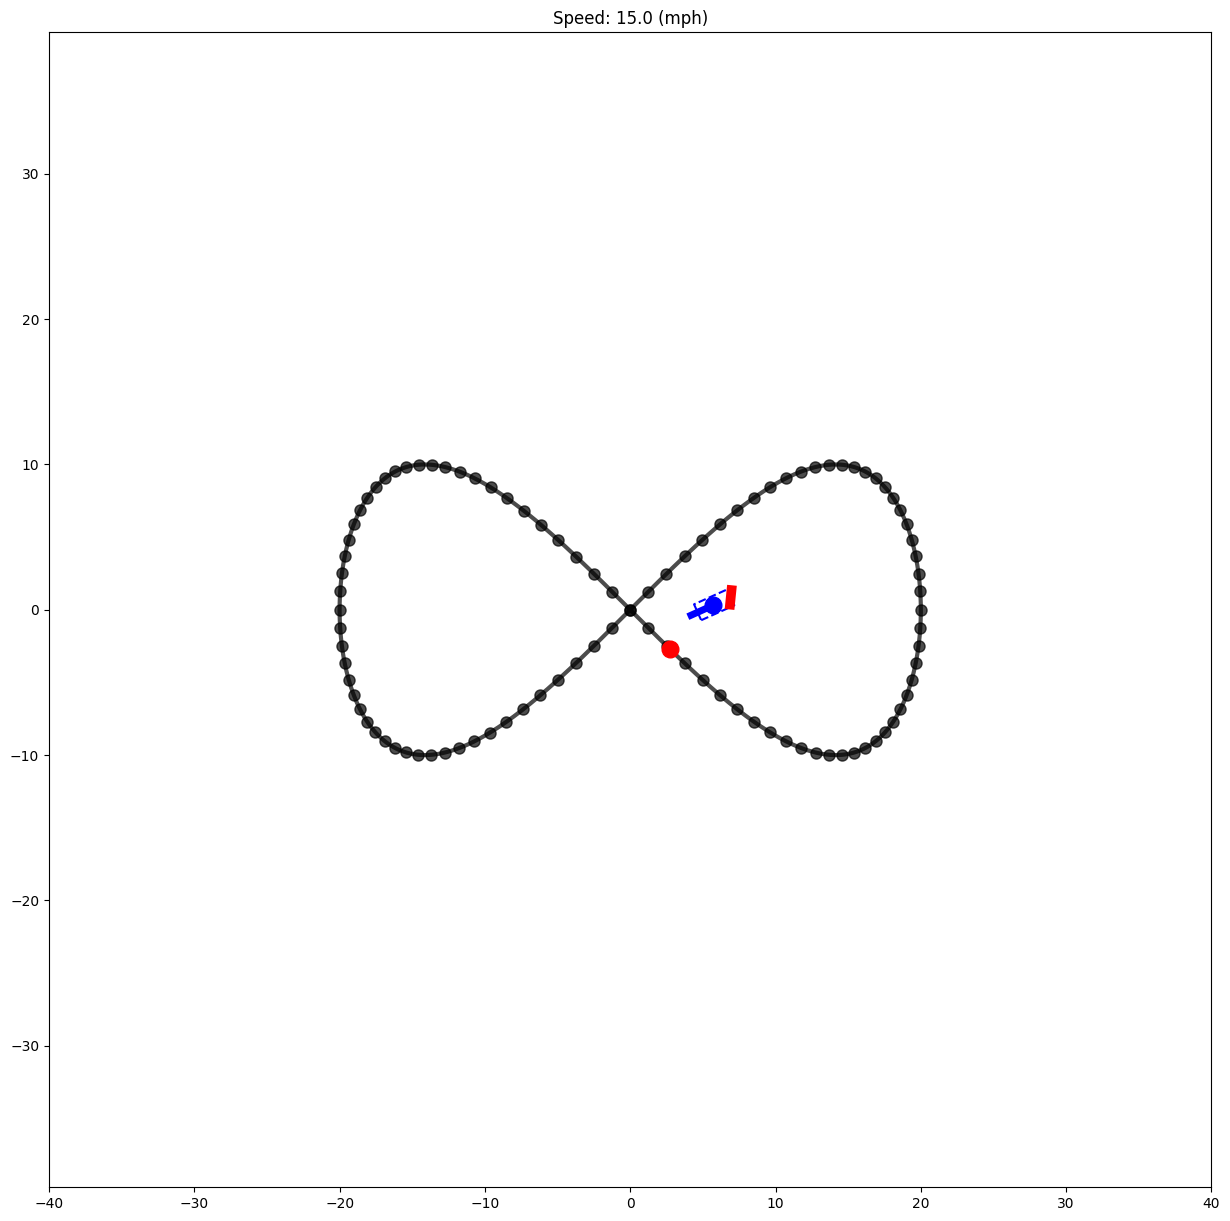

FigureEight total reward: 13.990103366324377


In [18]:
rc_env = SDRaceCar(render_env=True,track='FigureEight')
controller = RaceCarController("FigureEight")

obs = rc_env.reset()
total_reward = 0.0

for step in range(6000):   # give it slightly more time
    action = controller(obs)
    obs, reward, done, info = rc_env.step(action)
    total_reward += float(reward)

    rc_env.render()

    if done:
        break

print("FigureEight total reward:", total_reward)

